In [1]:
import numpy as np
import pandas as pd
import joblib
import glob
import pickle
import yaml
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import os
from functools import partial
import gc

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
def _load_feature(feature, base_dir, logger=None):
    load_filename = base_dir + feature + '.pkl.gz'
    feature = pd.read_pickle(load_filename, compression='gzip')
    # drop index because its very heavy to concat, and already sorted.
    feature.reset_index(drop=True, inplace=True)
    return feature


def load_features(features, base_dir, nthread, logger=None):
    loaded_features = []
    with Pool(nthread) as p:
        iter_func = partial(_load_feature, base_dir=base_dir, logger=logger)
        loaded_features = p.map(iter_func, features)
        p.close()
        p.join()
        gc.collect()
    features_df = pd.concat(loaded_features, axis=1)[features]
    return features_df

## できた features を train vs test で可視化してみる

In [22]:
def plot_train_and_test_hist(trn_feat, tst_feat, col, ax, title, vs_label):
#    plt.figure(figsize=(8, 4))
    trn_feat = trn_feat.replace(np.inf, np.nan).dropna()
    tst_feat = tst_feat.replace(np.inf, np.nan).dropna()
    x_min = min(trn_feat.min(), trn_feat.min())
    x_max = min(trn_feat.max(), tst_feat.max())
    sns.distplot(trn_feat, color='blue', label='train', kde=False, bins=100, norm_hist=True, ax=ax[0])
    sns.distplot(tst_feat, color='orange', label=vs_label, kde=False, bins=100, norm_hist=True, ax=ax[1])
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title('train')
    ax[1].set_title(vs_label)
    ax[0].set_xlabel(f'{col}')
    ax[1].set_xlabel(f'{col}')
    ax[0].set_xlim((x_min, x_max))
    ax[1].set_xlim((x_min, x_max))
#    plt.show()

In [5]:
features = [path.split('/')[-1].split('.')[0] for path in glob.glob('../inputs/features/e020*')]
features.append('MachineIdentifier')
features

['e020_weekly_SMode_local_mean_cov',
 'e020_six_hourly_HasDetections_local_mean_cov',
 'e020_weekly_Census_IsWIMBootEnabled_local_mean_var',
 'e020_monthly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var',
 'e020_six_hourly_Census_IsFlightingInternal_local_mean_var',
 'e020_daily_Census_HasOpticalDiskDrive_local_mean_mean',
 'e020_six_hourly_Firewall_local_mean_mean',
 'e020_weekly_IsSxsPassiveMode_local_mean_mean',
 'e020_weekly_Census_IsFlightsDisabled_local_mean_cov',
 'e020_six_hourly_Census_IsVirtualDevice_local_mean_mean',
 'e020_monthly_Census_IsWIMBootEnabled_local_mean_var',
 'e020_weekly_Census_IsTouchEnabled_local_mean_mean',
 'e020_daily_Wdft_IsGamer_local_mean_mean',
 'e020_six_hourly_HasDetections_local_mean_mean',
 'e020_Census_IsFlightsDisabled_local_mean',
 'e020_monthly_HasDetections_local_mean_cov',
 'e020_six_hourly_Firewall_local_mean_var',
 'e020_daily_Census_IsFlightingInternal_local_mean_var',
 'e020_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean',
 '

In [6]:
df = load_features(features, '../inputs/features/', os.cpu_count())
df.head()

e020_weekly_SMode_local_mean_cov  \
0                               NaN   
1                          0.000147   
2                          0.000101   
3                          0.000124   
4                          0.000103   

   e020_six_hourly_HasDetections_local_mean_cov  \
0                                           NaN   
1                                      0.012769   
2                                      0.006441   
3                                      0.016150   
4                                      0.013089   

   e020_weekly_Census_IsWIMBootEnabled_local_mean_var  \
0                                                NaN    
1                                                0.0    
2                                                0.0    
3                                                0.0    
4                                                0.0    

   e020_monthly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var  \
0                                                NaN                     
1                                           0.000458                     
2                                           0.000300                     
3                                           0.000201                     
4                                           0.000186                     

   e020_six_hourly_Census_IsFlightingInternal_local_mean_var  \
0                                                NaN           
1                                       0.000000e+00           
2                                       0.000000e+00           
3                                       0.000000e+00           
4                                       2.603906e-09           

   e020_daily_Census_HasOpticalDiskDrive_local_mean_mean  \
0                                           0.070985       
1                                           0.046726       
2                                           0.053595       
3                                           0.060887       
4                                           0.065776       

   e020_six_hourly_Firewall_local_mean_mean  \
0                                  0.982513   
1                                  0.982610   
2                                  0.979982   
3                                  0.977073   
4                                  0.977868   

   e020_weekly_IsSxsPassiveMode_local_mean_mean  \
0                                      0.018641   
1                                      0.015171   
2                                      0.015837   
3                                      0.016014   
4                                      0.016379   

   e020_weekly_Census_IsFlightsDisabled_local_mean_cov  \
0                                                NaN     
1                                           0.000004     
2                                           0.000004     
3                                           0.000042     
4                                           0.000043     

   e020_six_hourly_Census_IsVirtualDevice_local_mean_mean  \
0                                           0.005925        
1                                           0.007709        
2                                           0.007632        
3                                           0.007163        
4                                           0.007016        

   e020_monthly_Census_IsWIMBootEnabled_local_mean_var  \
0                                                NaN     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   e020_weekly_Census_IsTouchEnabled_local_mean_mean  \
0                                           0.136501   
1                                           0.105910   
2                                           0.113016   
3                                           0.11

In [7]:
trn_ids = pd.read_pickle('../inputs/nes_info/trn_MachineIdentifier.pkl.gz')
tst_ids = pd.read_pickle('../inputs/nes_info/tst_MachineIdentifier.pkl.gz')
trn_df = df.set_index('MachineIdentifier').loc[trn_ids]
tst_df = df.set_index('MachineIdentifier').loc[tst_ids]

In [8]:
val_flgs = pd.read_pickle('../inputs/nes_info/val_flg.pkl')
val_trn_df = trn_df[(val_flgs == 0).values]
val_val_df = trn_df[(val_flgs != 0).values]

========== e020_weekly_SMode_local_mean_cov ===========


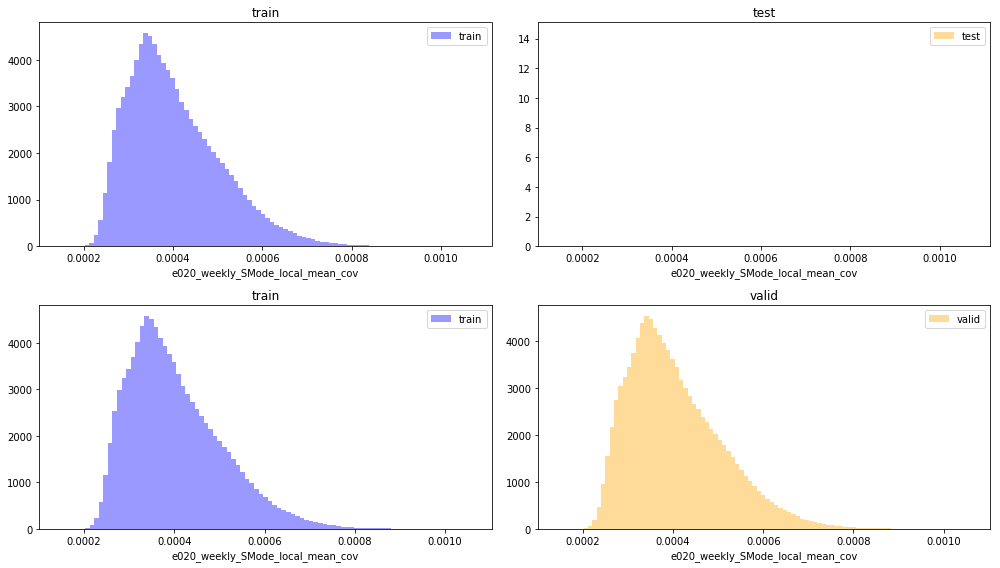

========== e020_six_hourly_HasDetections_local_mean_cov ===========


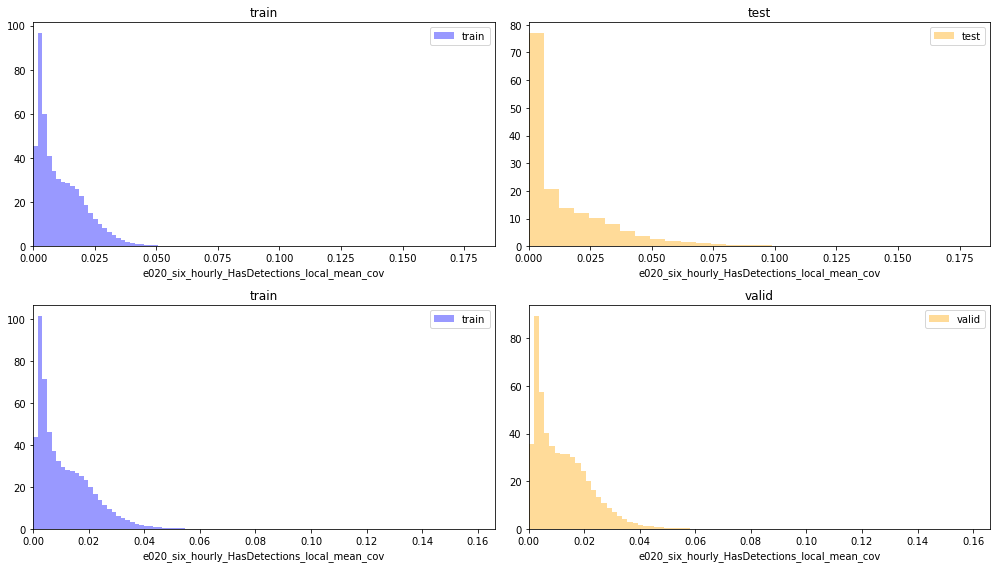

========== e020_weekly_Census_IsWIMBootEnabled_local_mean_var ===========


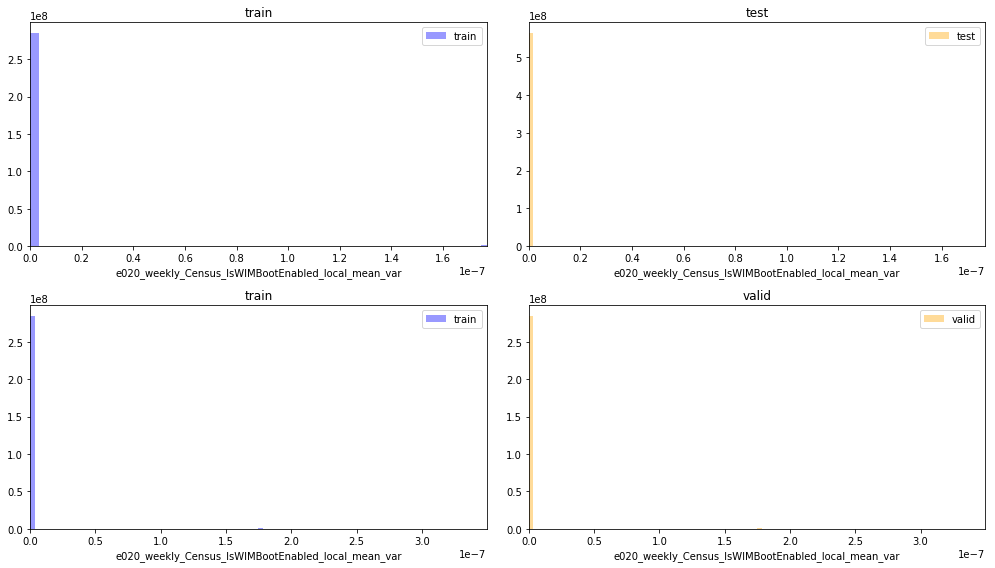

========== e020_monthly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var ===========


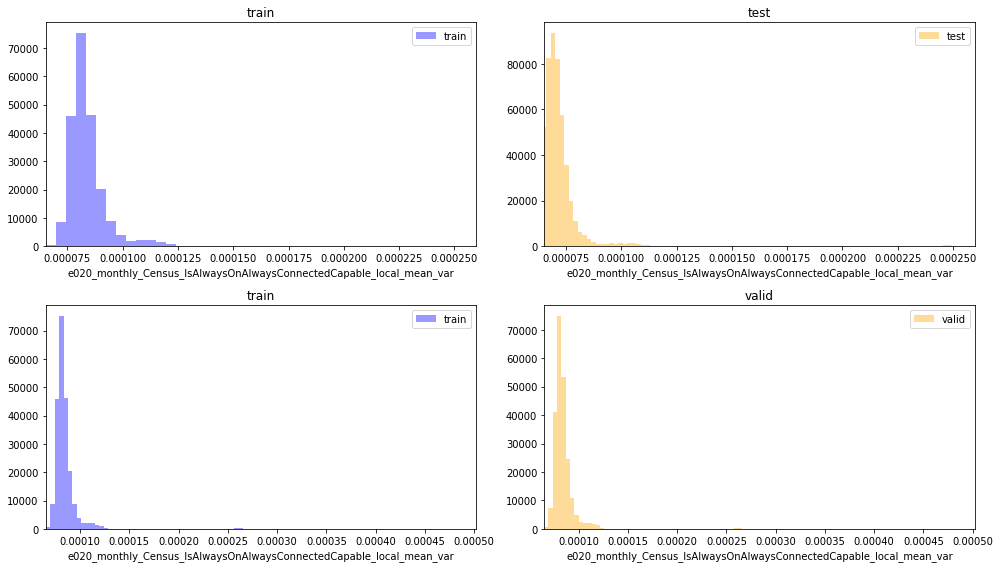

========== e020_six_hourly_Census_IsFlightingInternal_local_mean_var ===========


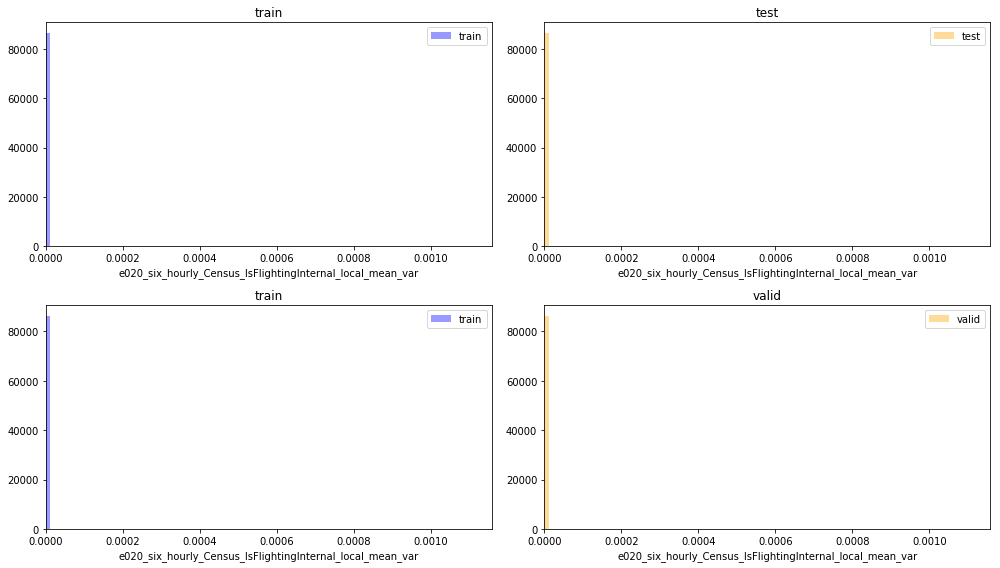

========== e020_daily_Census_HasOpticalDiskDrive_local_mean_mean ===========


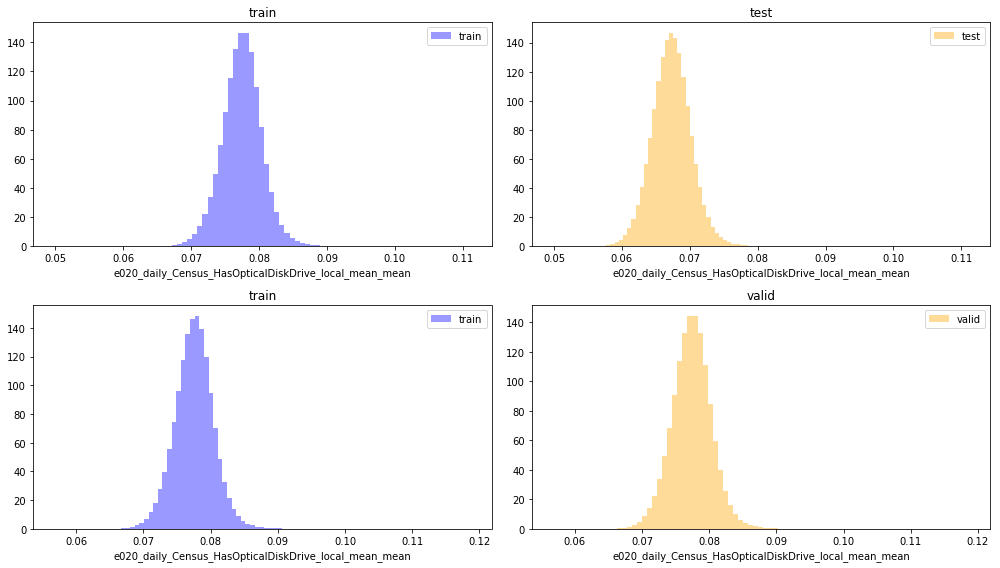

========== e020_six_hourly_Firewall_local_mean_mean ===========


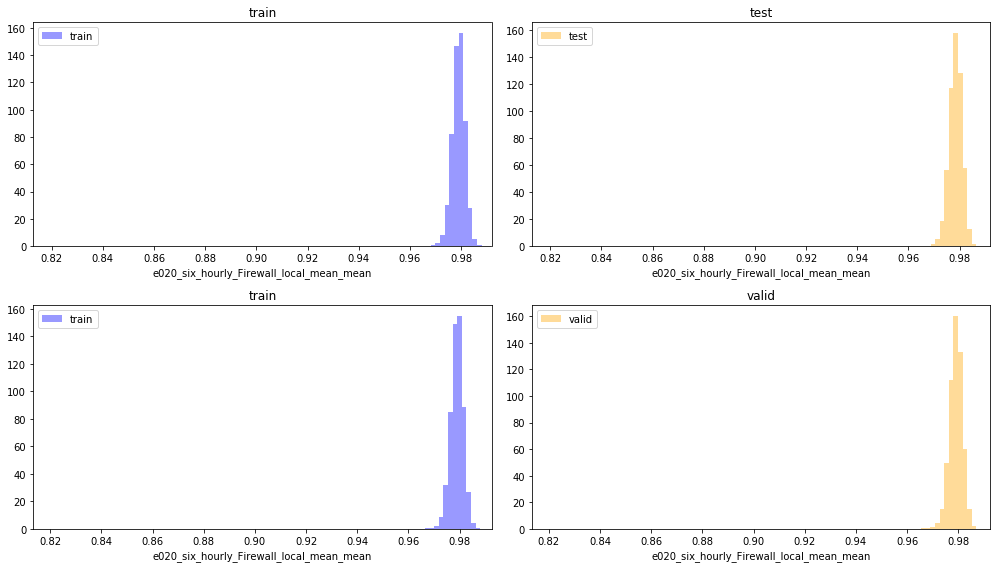

========== e020_weekly_IsSxsPassiveMode_local_mean_mean ===========


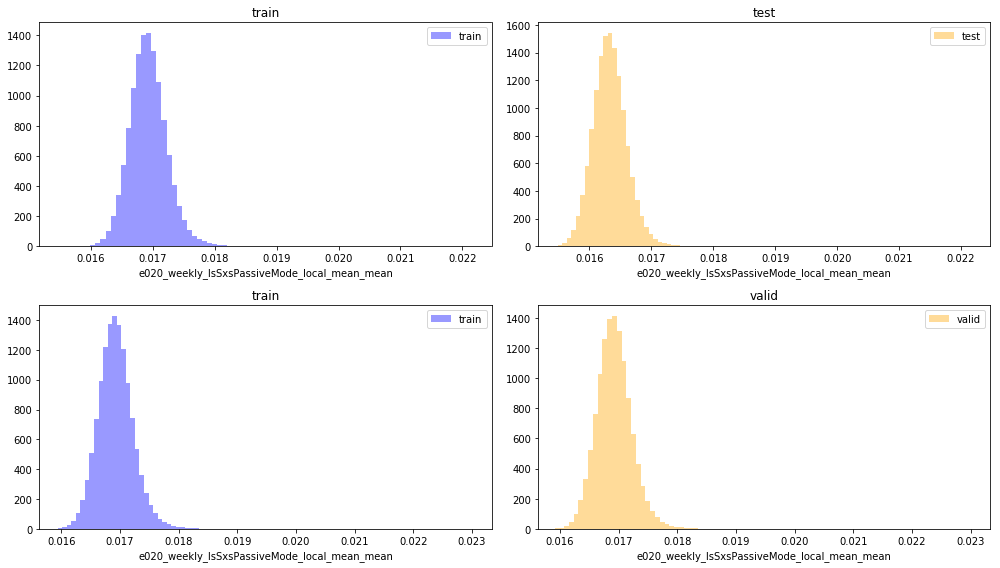

========== e020_weekly_Census_IsFlightsDisabled_local_mean_cov ===========


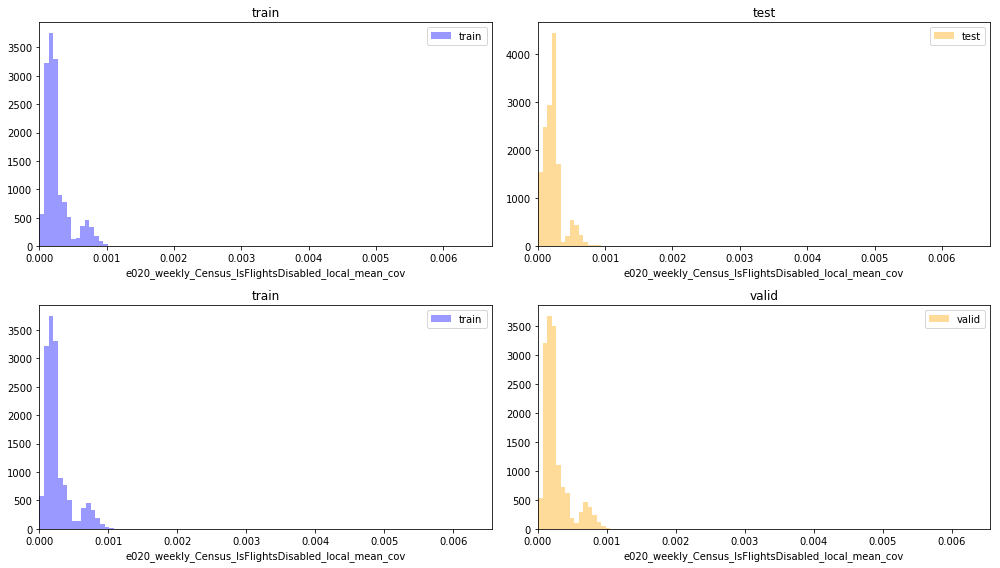

========== e020_six_hourly_Census_IsVirtualDevice_local_mean_mean ===========


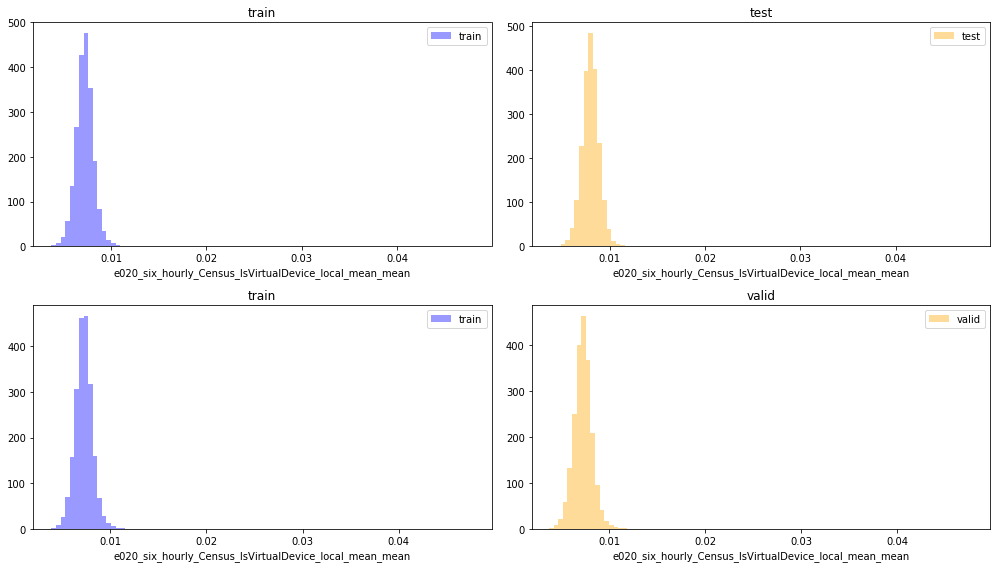

========== e020_monthly_Census_IsWIMBootEnabled_local_mean_var ===========


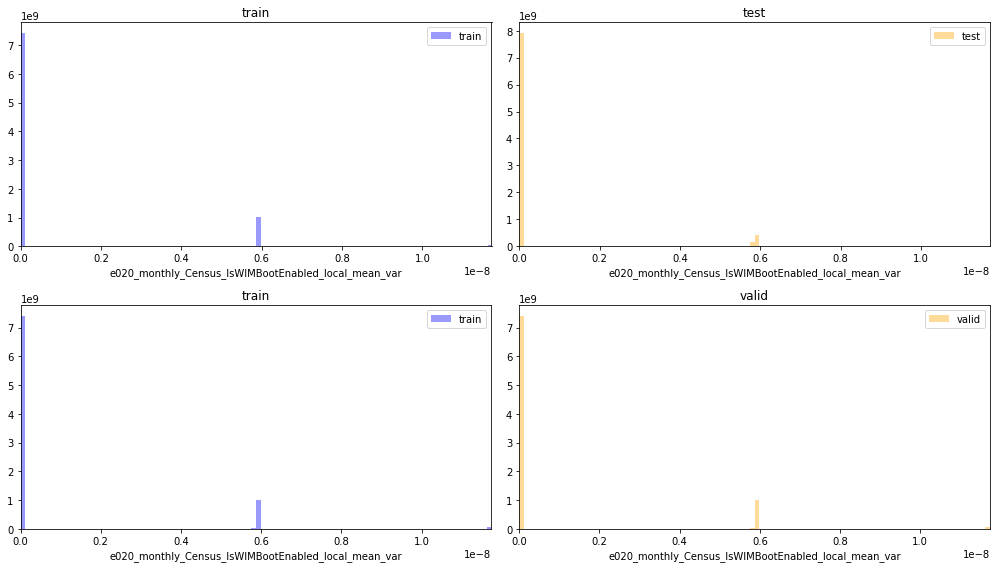

========== e020_weekly_Census_IsTouchEnabled_local_mean_mean ===========


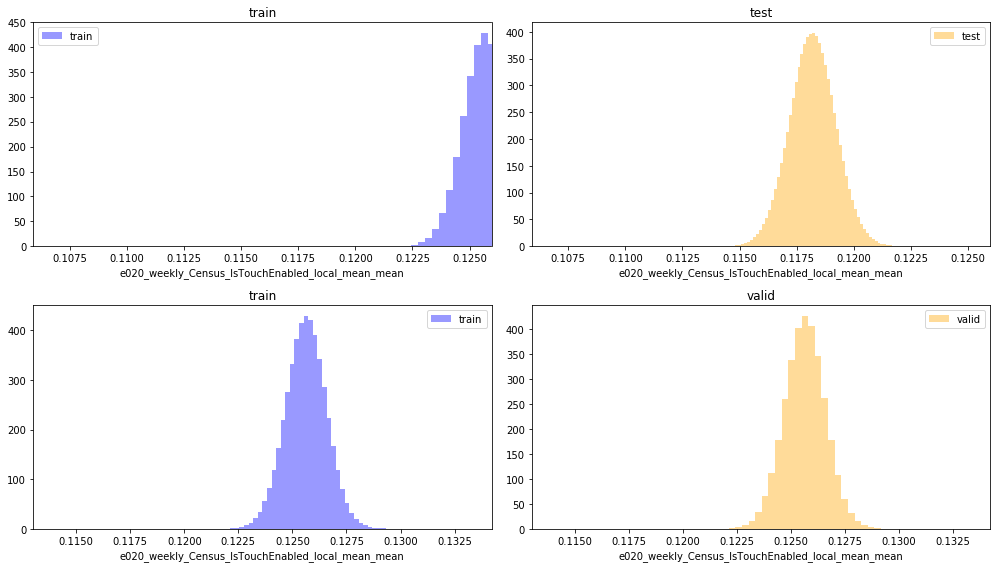

========== e020_daily_Wdft_IsGamer_local_mean_mean ===========


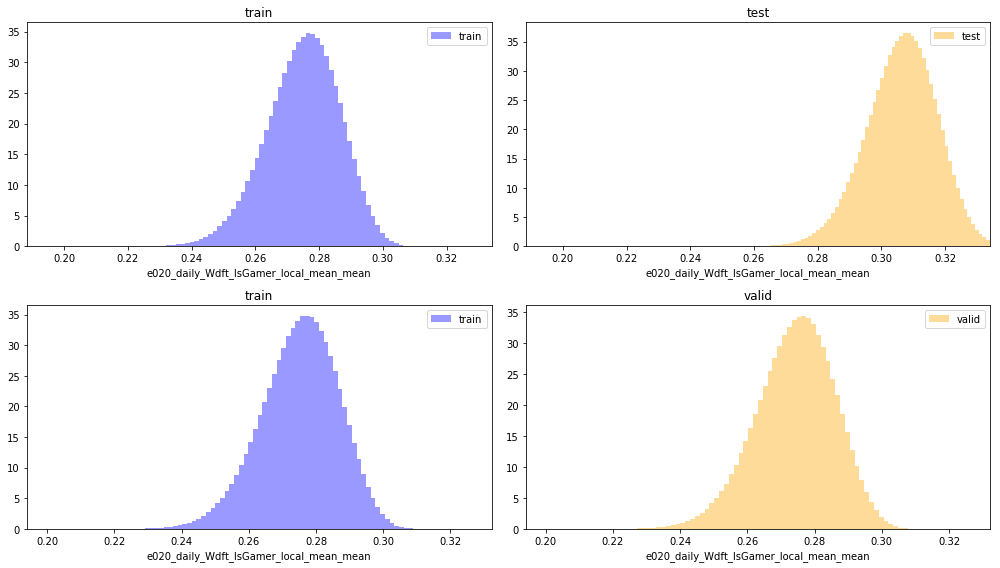

========== e020_six_hourly_HasDetections_local_mean_mean ===========


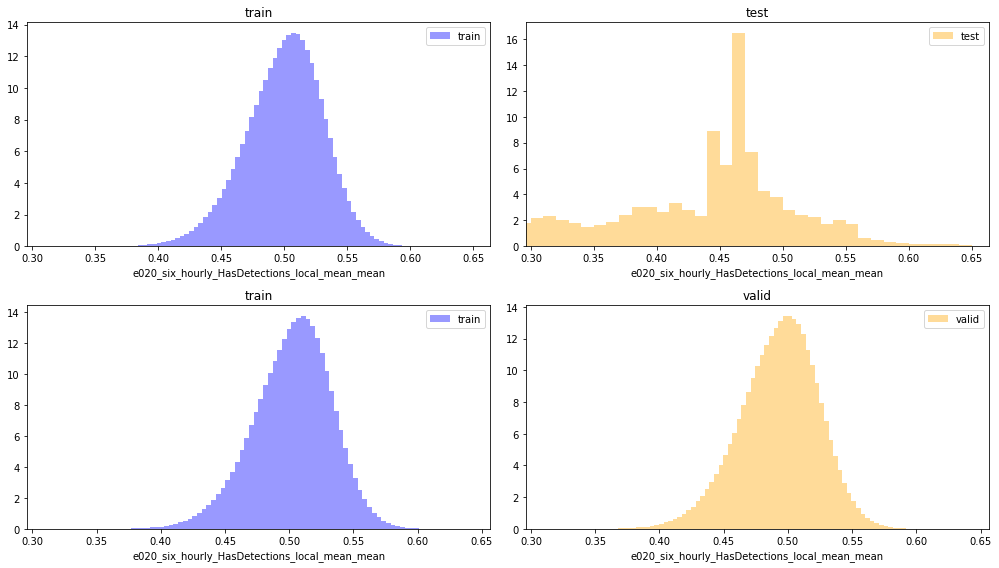

========== e020_Census_IsFlightsDisabled_local_mean ===========


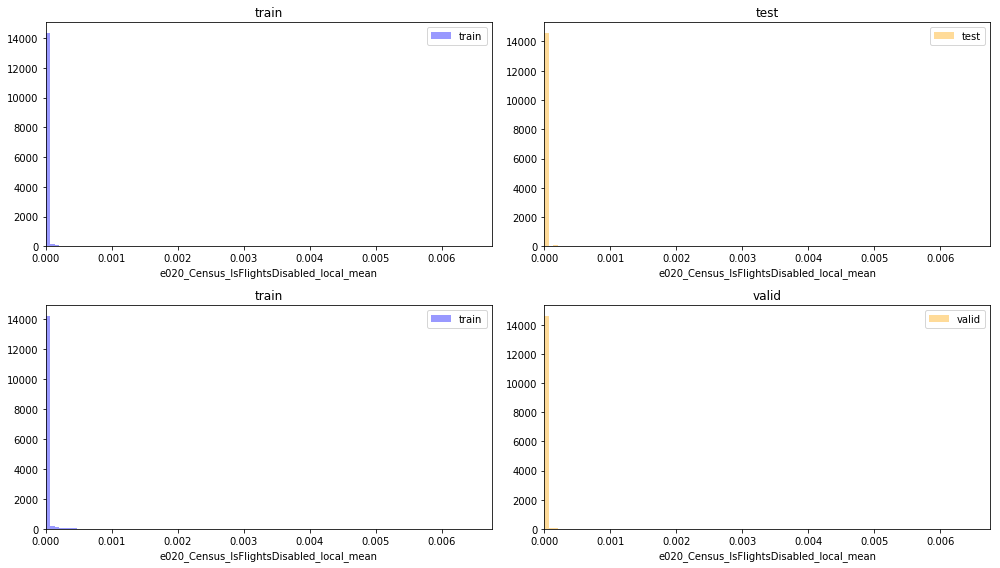

========== e020_monthly_HasDetections_local_mean_cov ===========


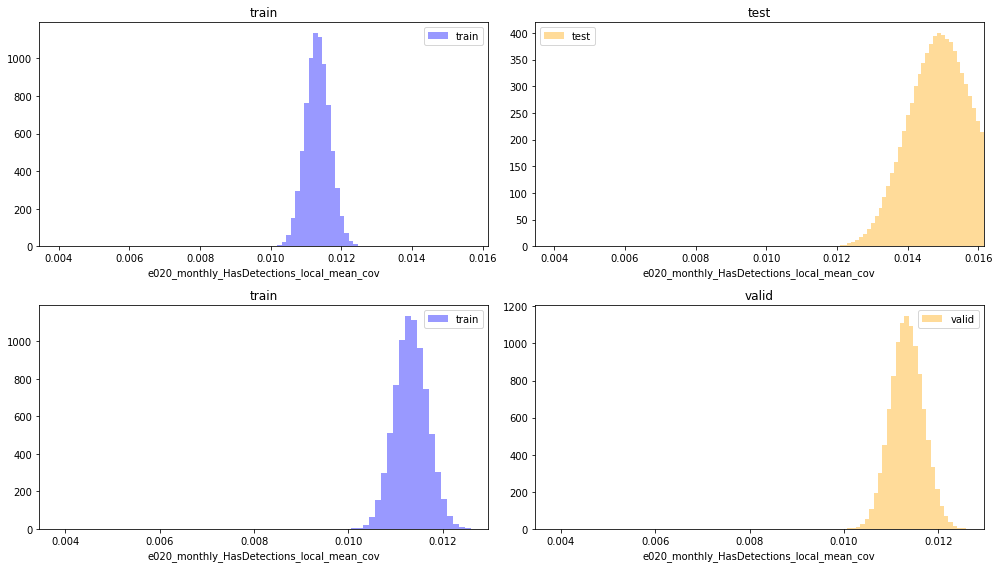

========== e020_six_hourly_Firewall_local_mean_var ===========


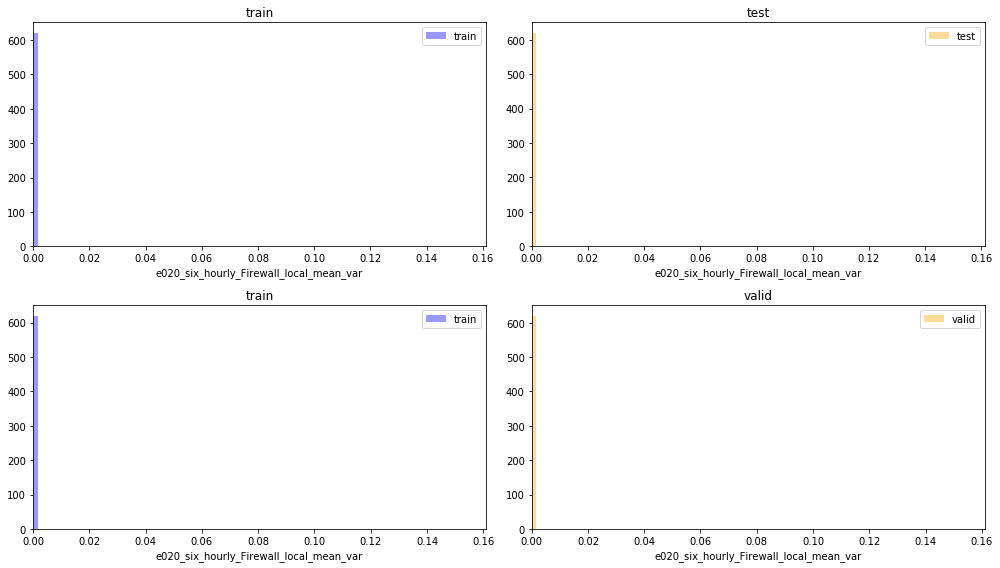

========== e020_daily_Census_IsFlightingInternal_local_mean_var ===========


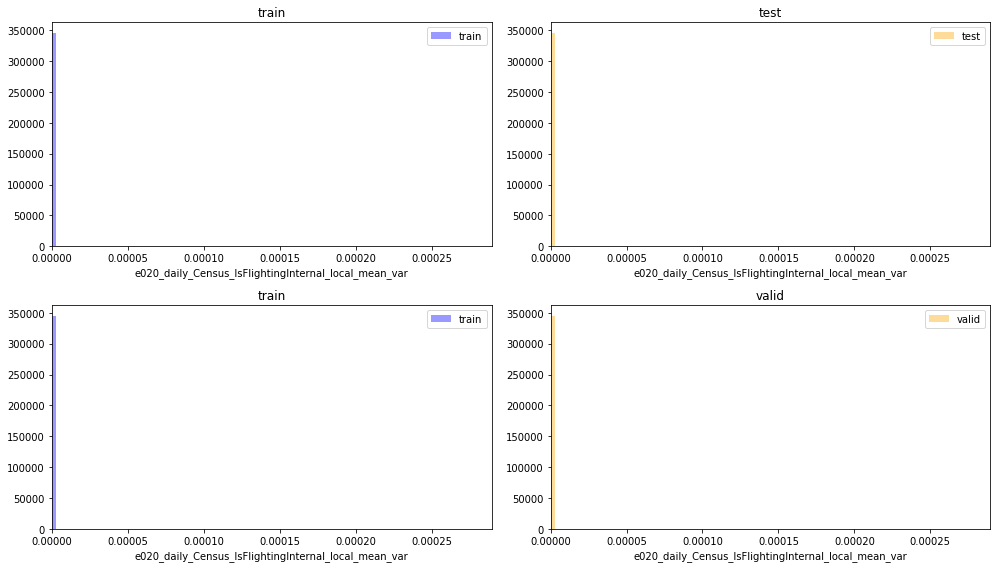

========== e020_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean ===========


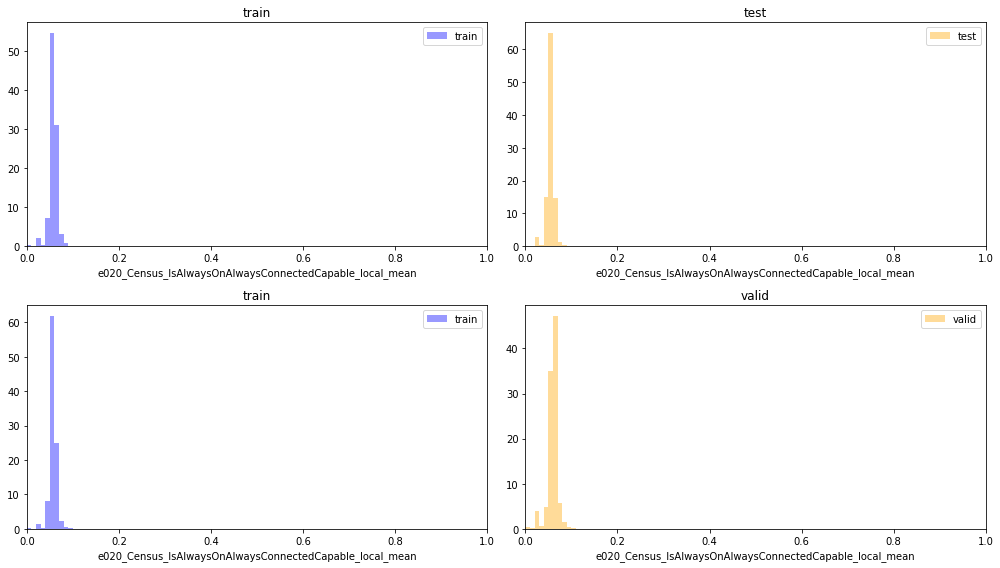

========== e020_daily_Census_IsFlightingInternal_local_mean_cov ===========


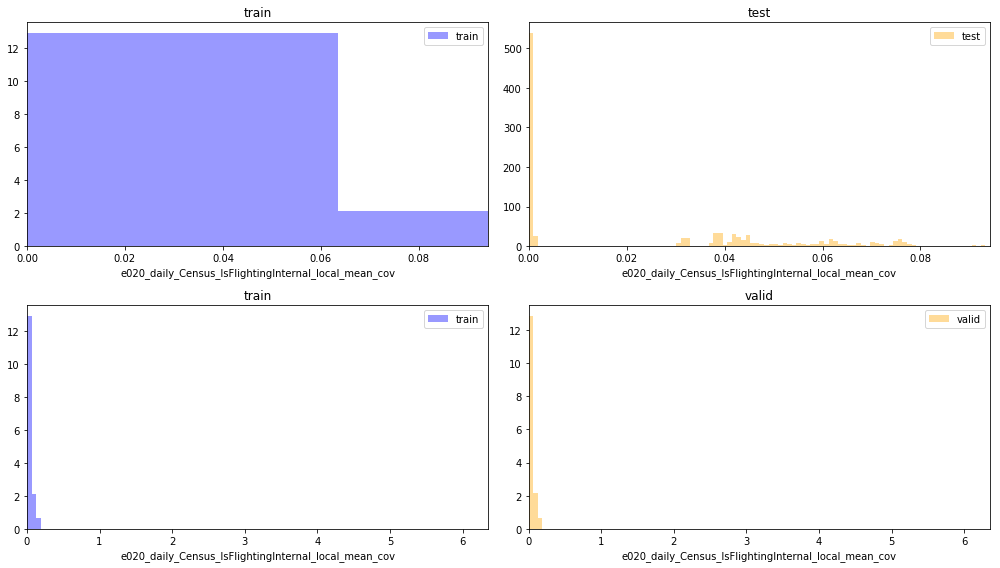

========== e020_six_hourly_Census_IsPenCapable_local_mean_var ===========


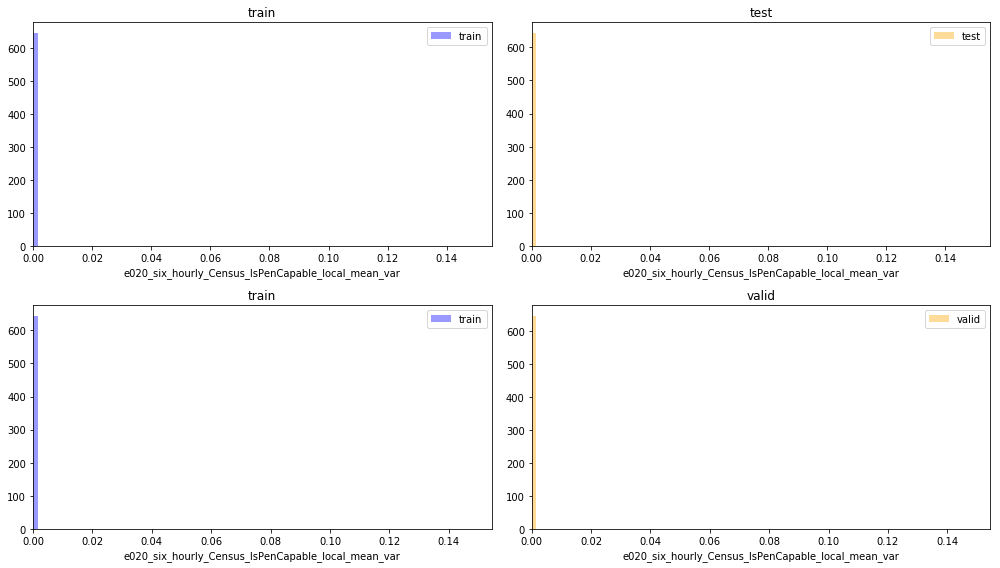

========== e020_six_hourly_HasTpm_local_mean_mean ===========


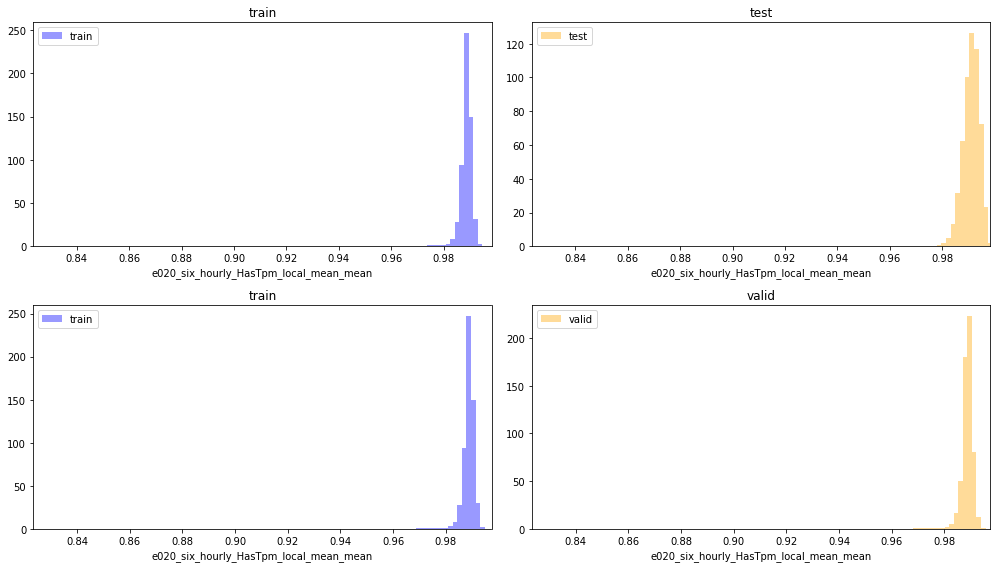

========== e020_daily_Census_IsFlightsDisabled_local_mean_var ===========


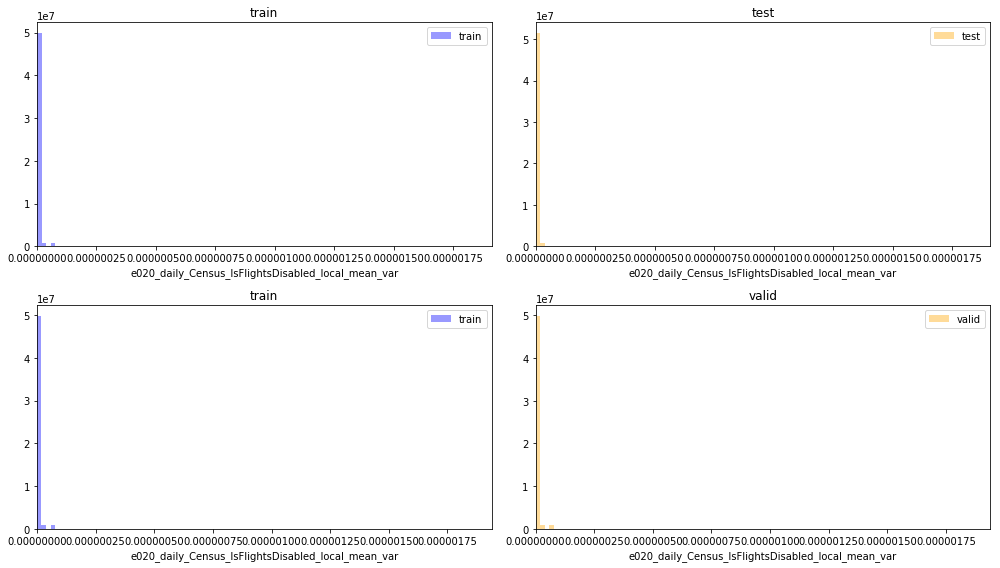

========== e020_weekly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_cov ===========


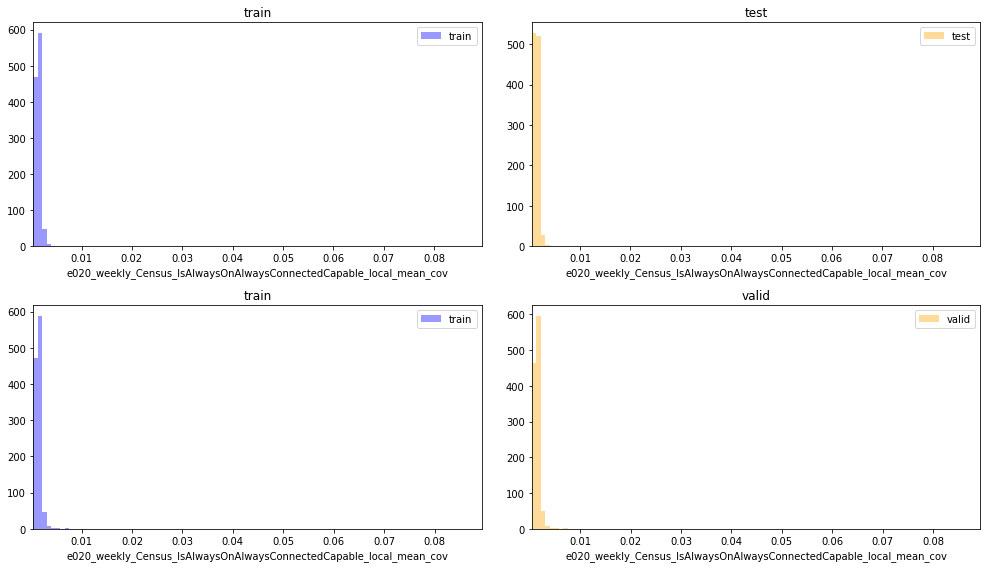

========== e020_weekly_Census_IsWIMBootEnabled_local_mean_cov ===========


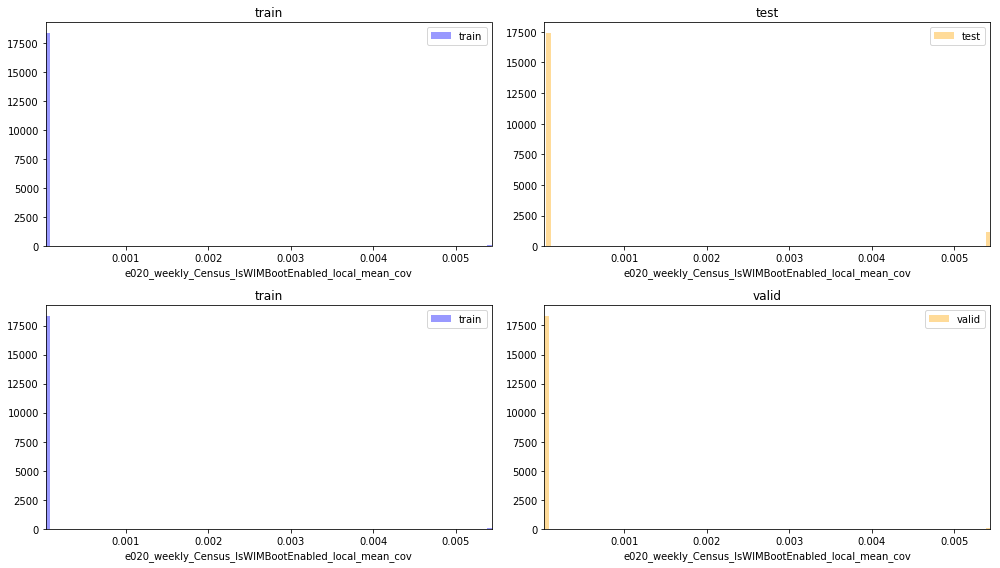

========== e020_daily_IsSxsPassiveMode_local_mean_cov ===========


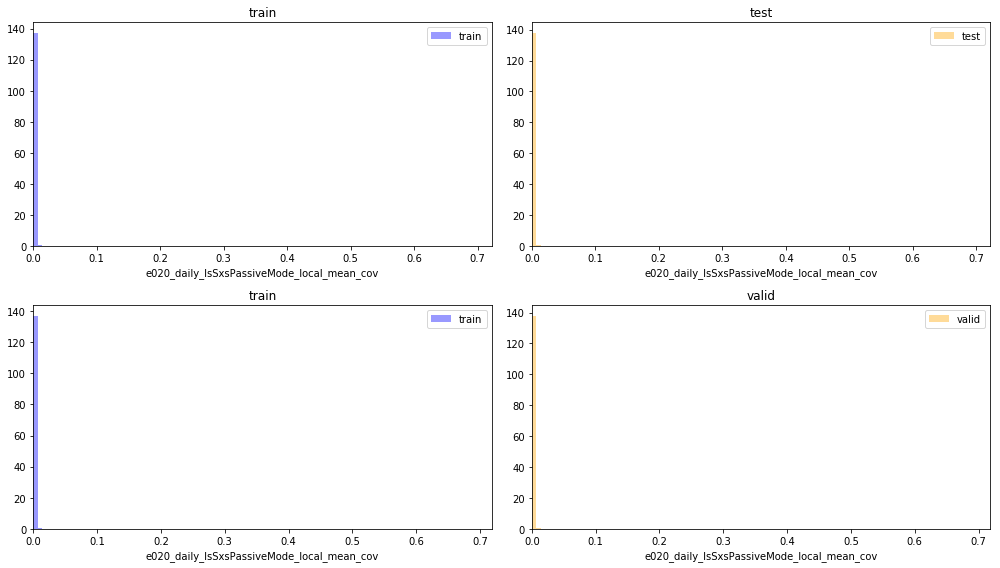

========== e020_six_hourly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_cov ===========


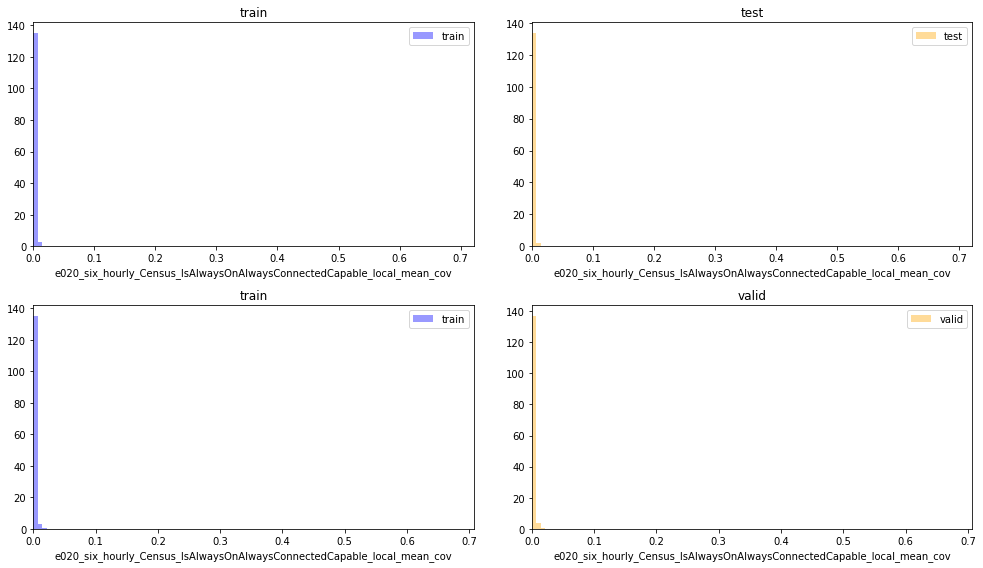

========== e020_monthly_IsSxsPassiveMode_local_mean_cov ===========


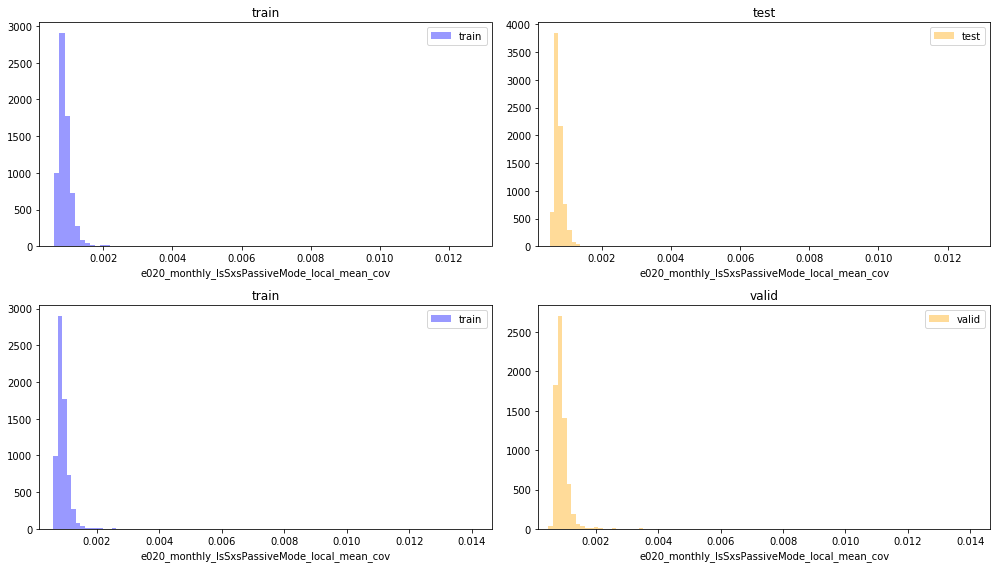

========== e020_weekly_Census_IsSecureBootEnabled_local_mean_cov ===========


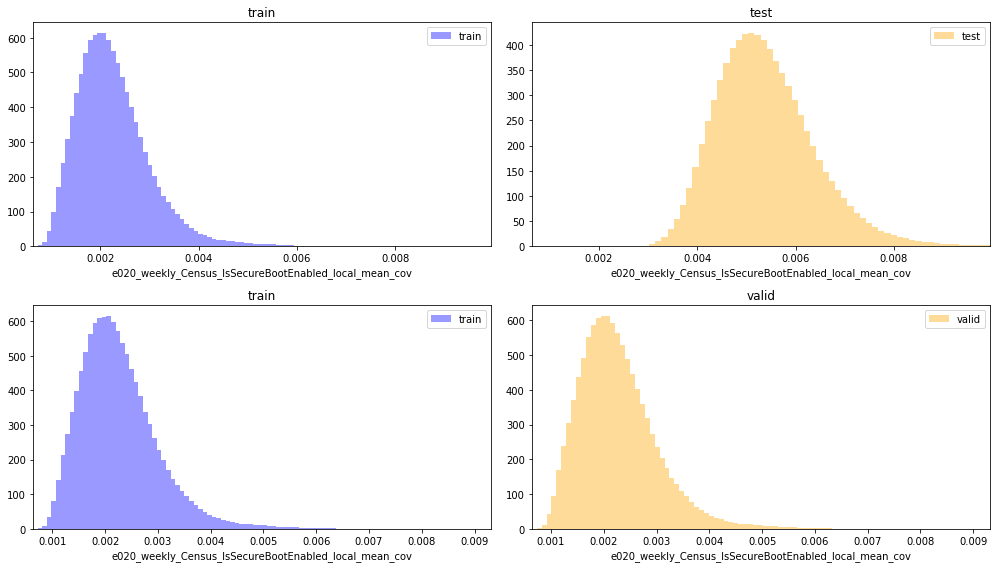

========== e020_monthly_Census_IsTouchEnabled_local_mean_var ===========


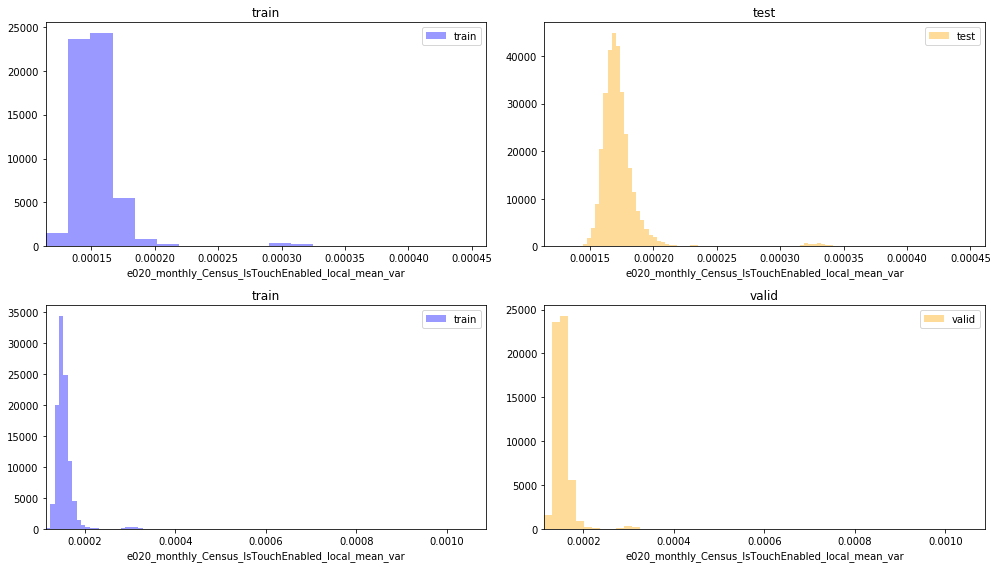

========== e020_daily_Census_IsVirtualDevice_local_mean_mean ===========


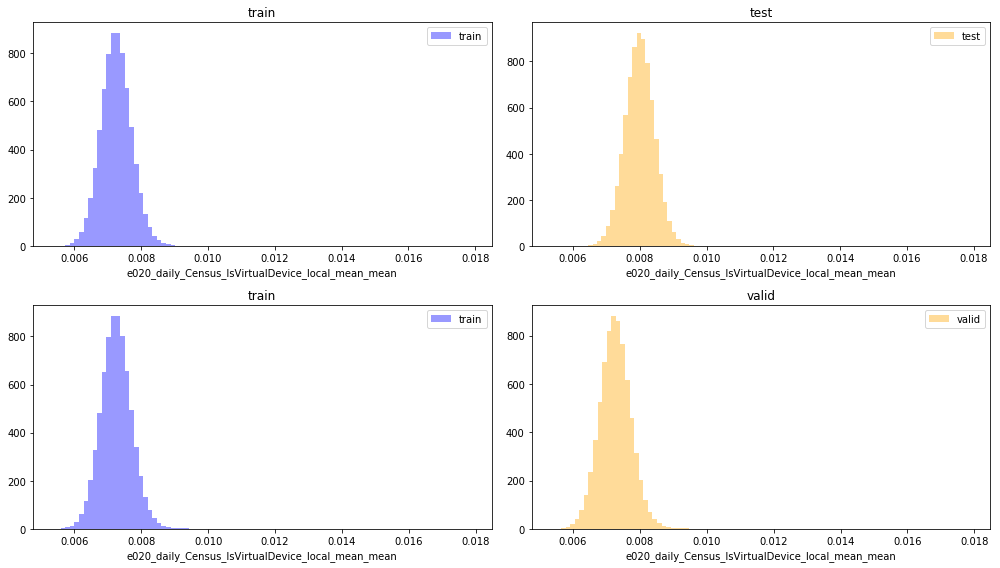

========== e020_monthly_SMode_local_mean_cov ===========


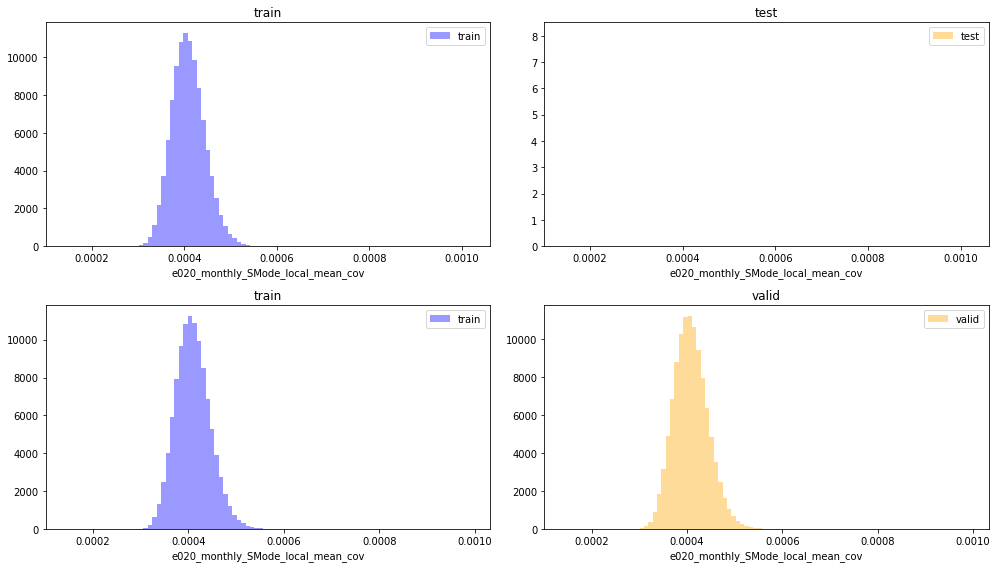

========== e020_six_hourly_SMode_local_mean_var ===========


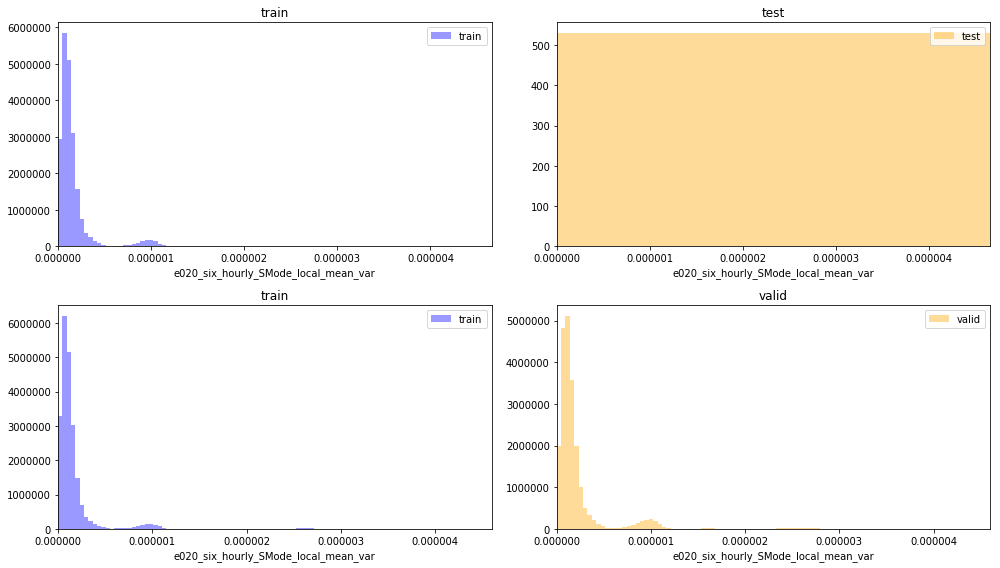

========== e020_six_hourly_SMode_local_mean_cov ===========


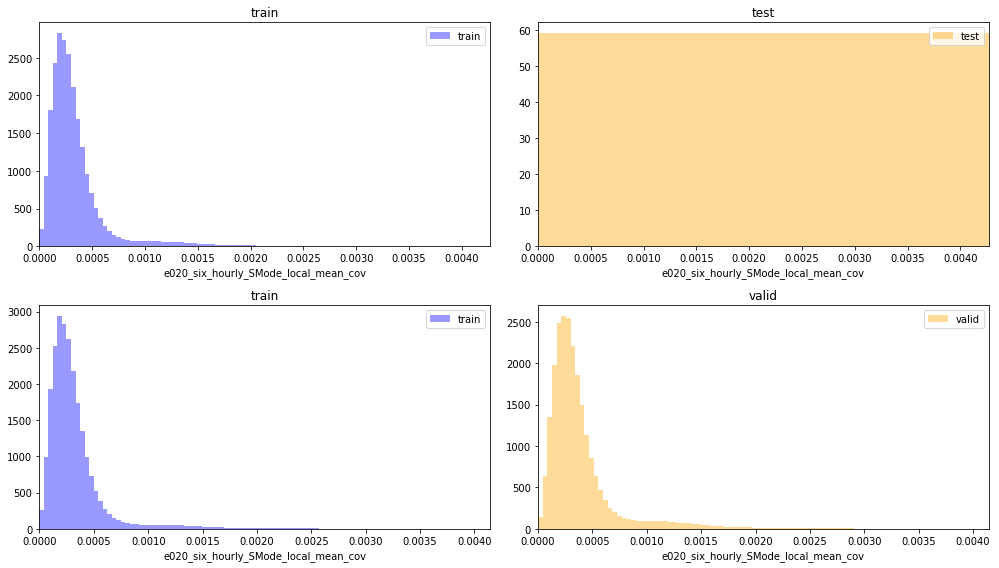

========== e020_Census_IsWIMBootEnabled_local_mean ===========


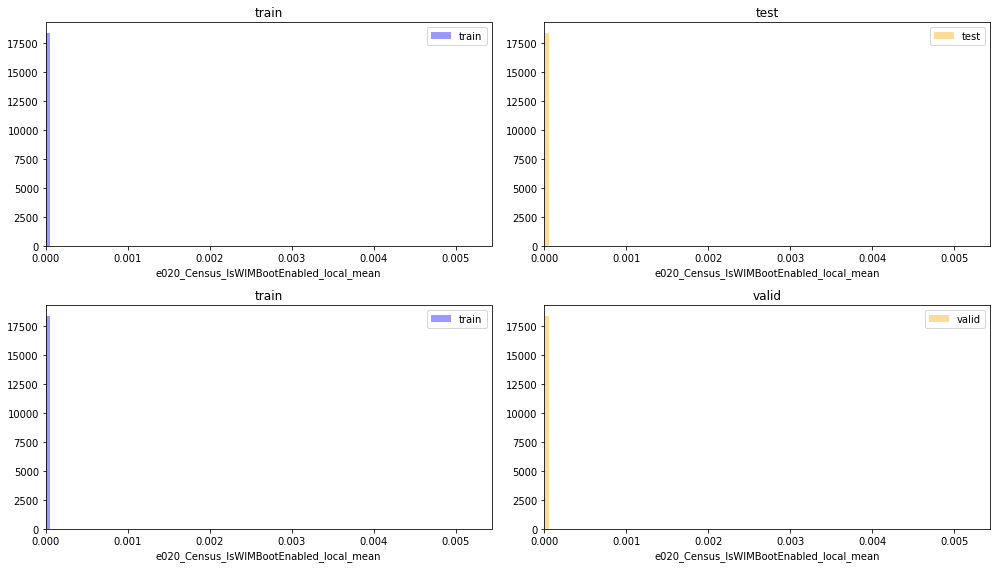

========== e020_weekly_Census_IsPortableOperatingSystem_local_mean_var ===========


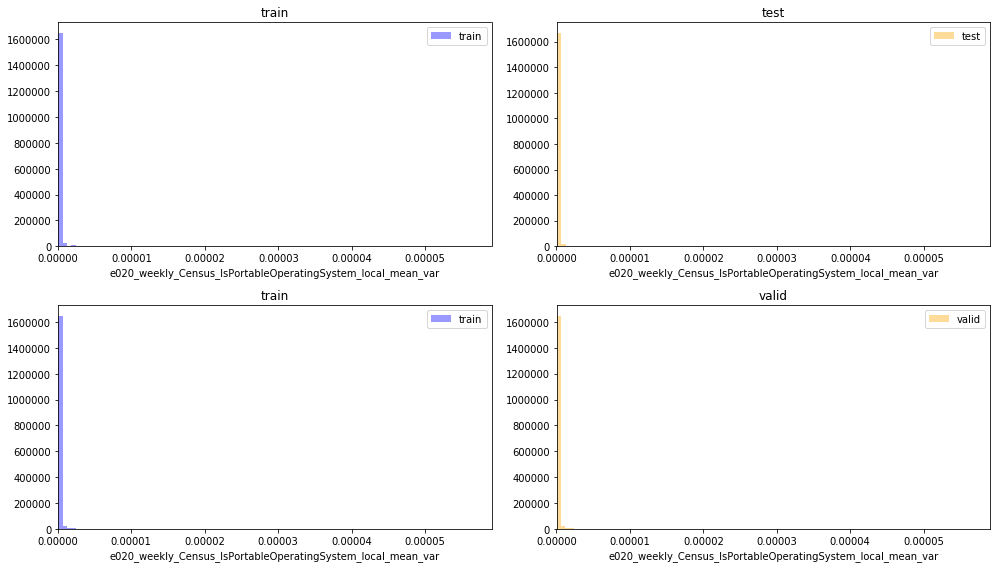

========== e020_six_hourly_IsBeta_local_mean_var ===========


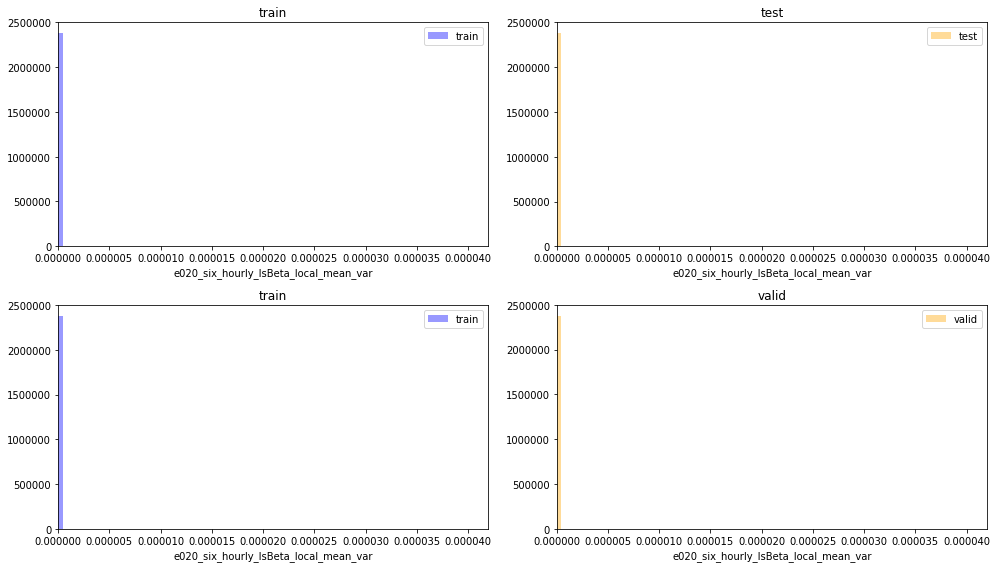

========== e020_six_hourly_Census_IsVirtualDevice_local_mean_cov ===========


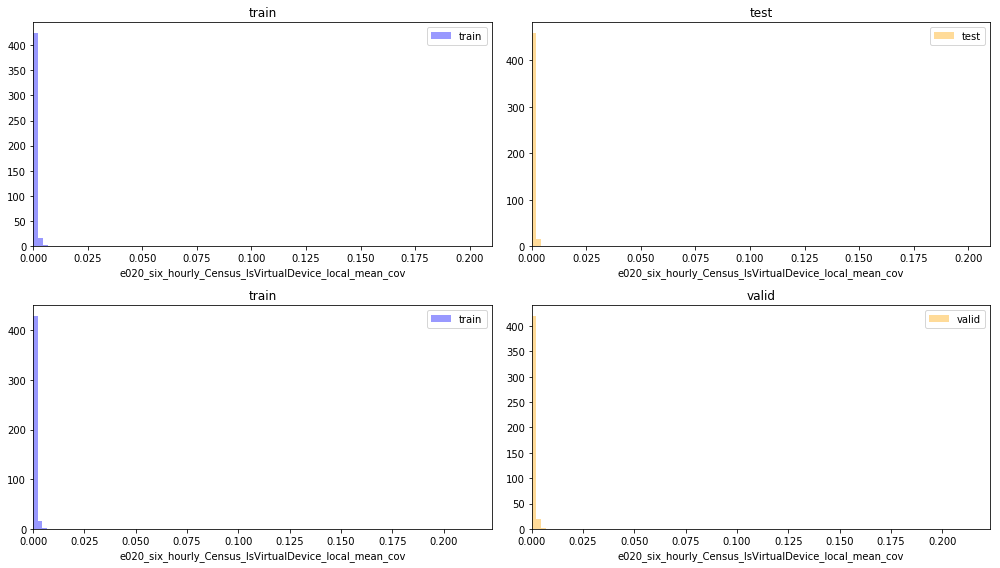

========== e020_HasDetections_local_mean ===========


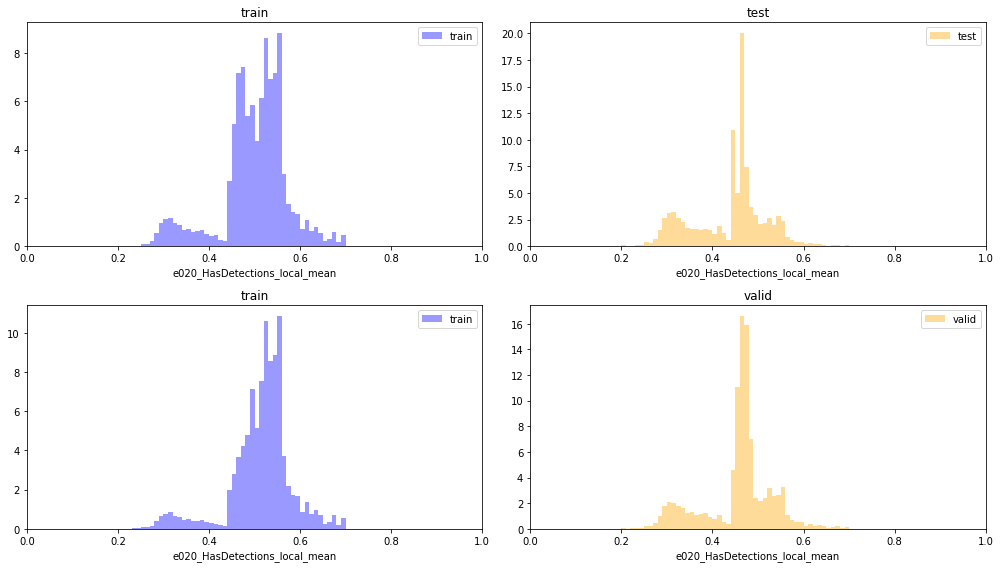

========== e020_daily_SMode_local_mean_cov ===========


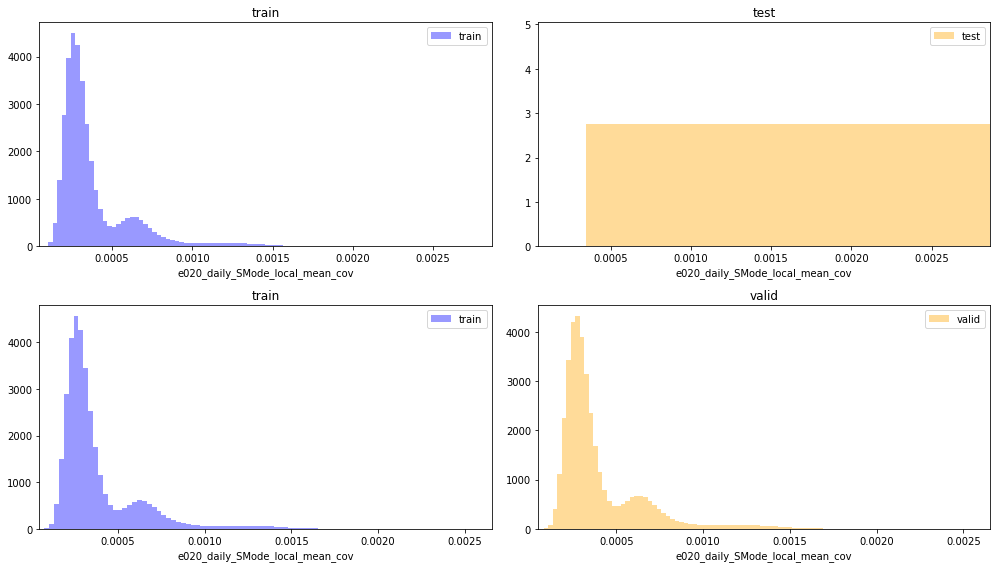

========== e020_six_hourly_IsSxsPassiveMode_local_mean_var ===========


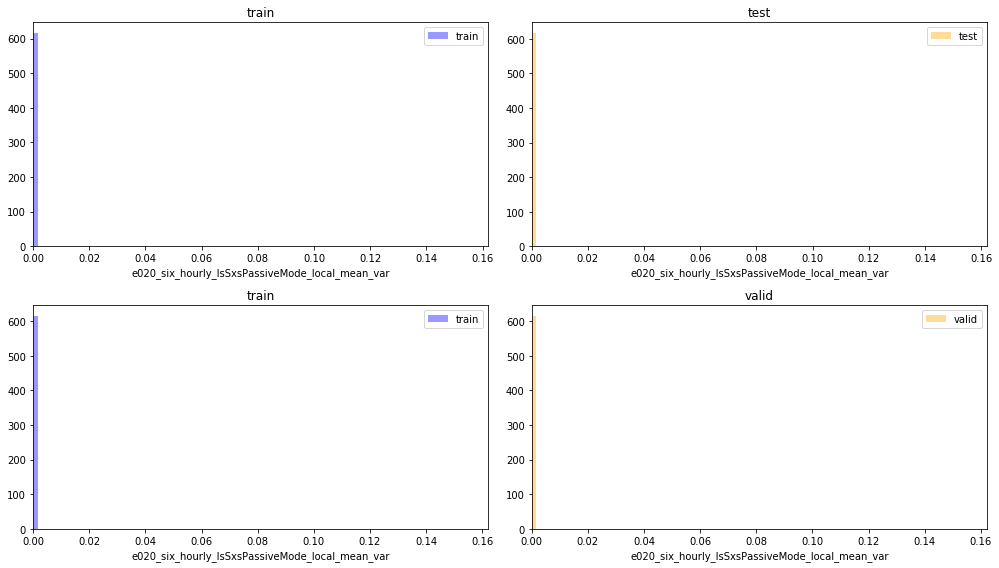

========== e020_weekly_HasTpm_local_mean_cov ===========


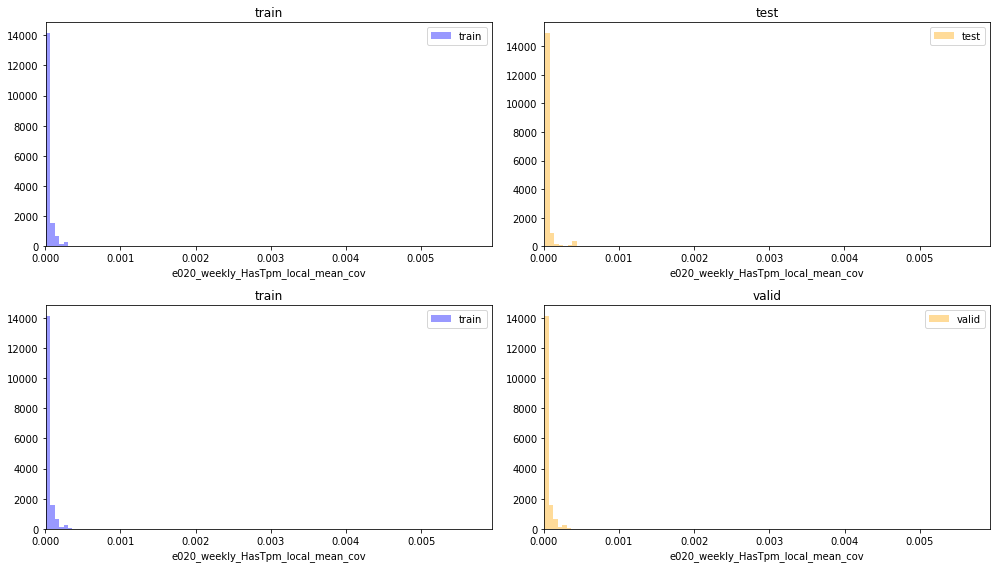

========== e020_daily_Census_IsWIMBootEnabled_local_mean_cov ===========


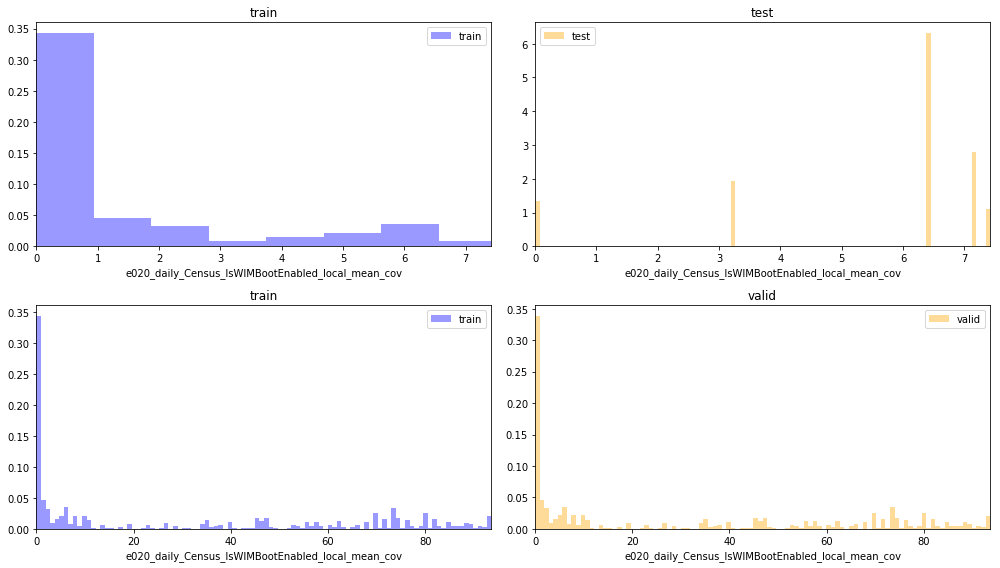

========== e020_weekly_HasDetections_local_mean_cov ===========


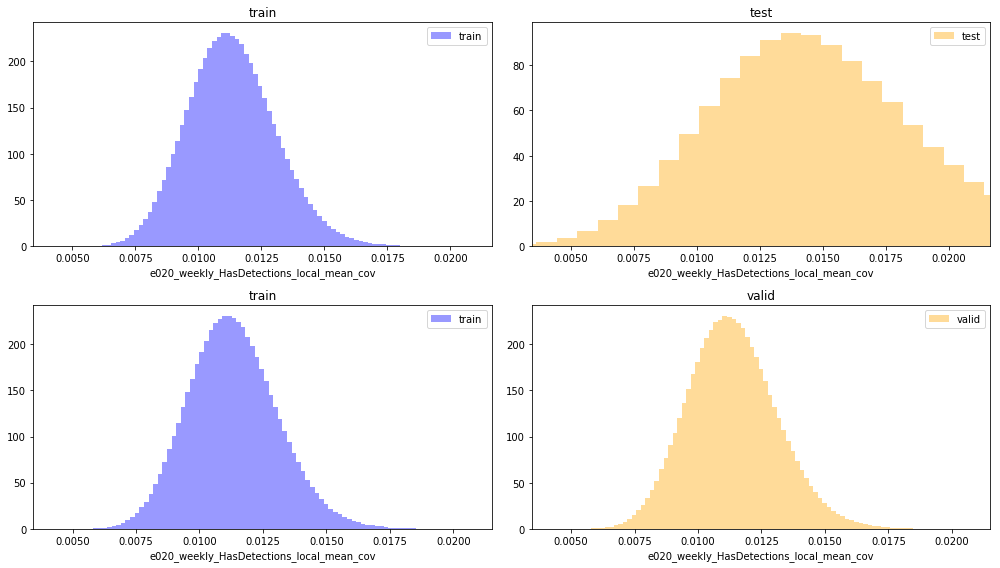

========== e020_Census_IsSecureBootEnabled_local_mean ===========


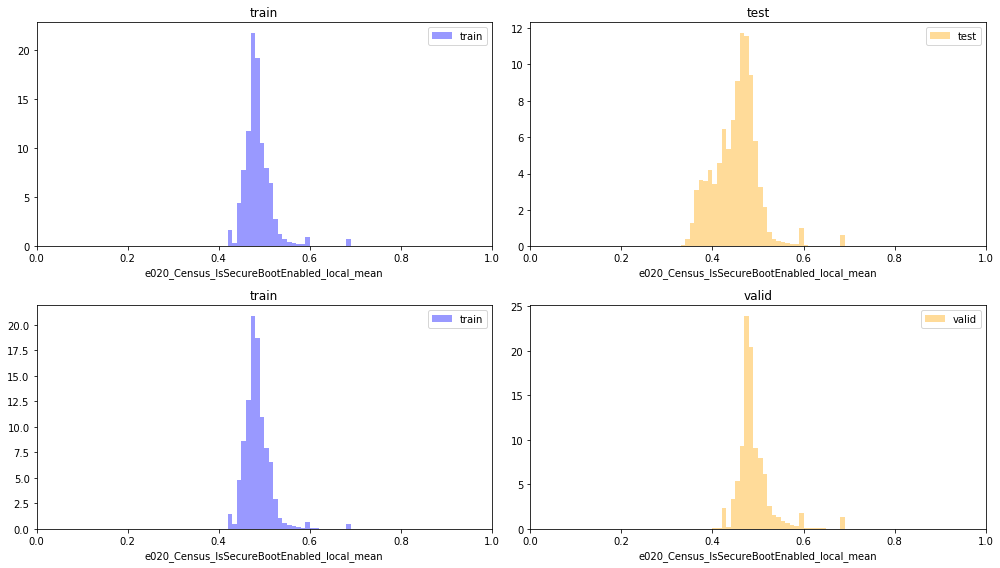

========== e020_weekly_Wdft_IsGamer_local_mean_mean ===========


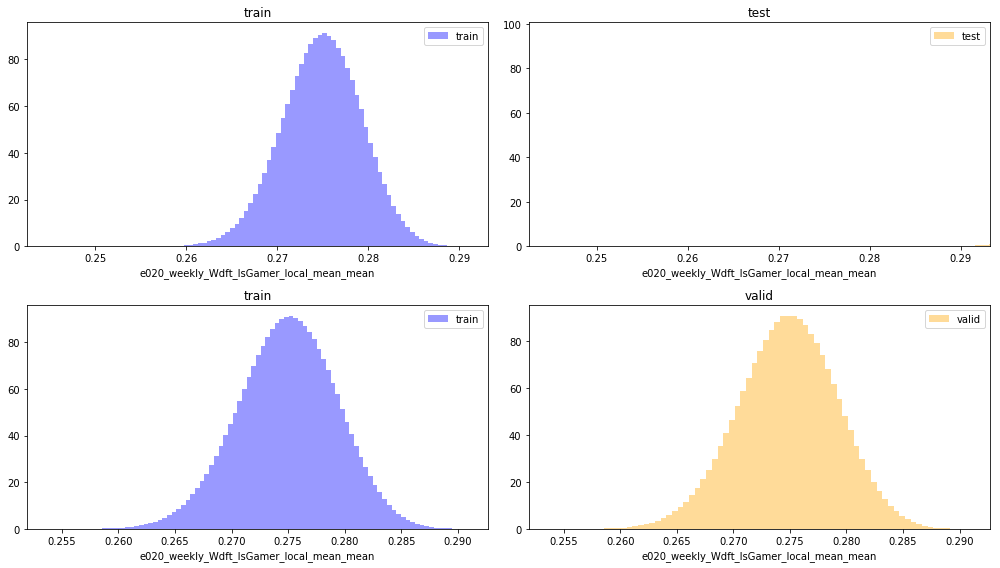

========== e020_weekly_Census_ThresholdOptIn_local_mean_mean ===========


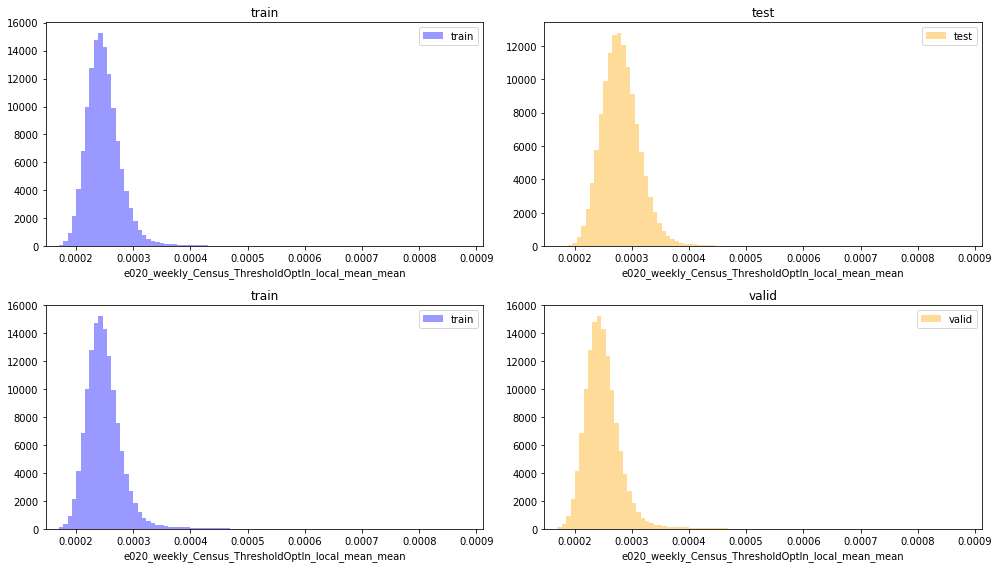

========== e020_weekly_Census_IsFlightsDisabled_local_mean_var ===========


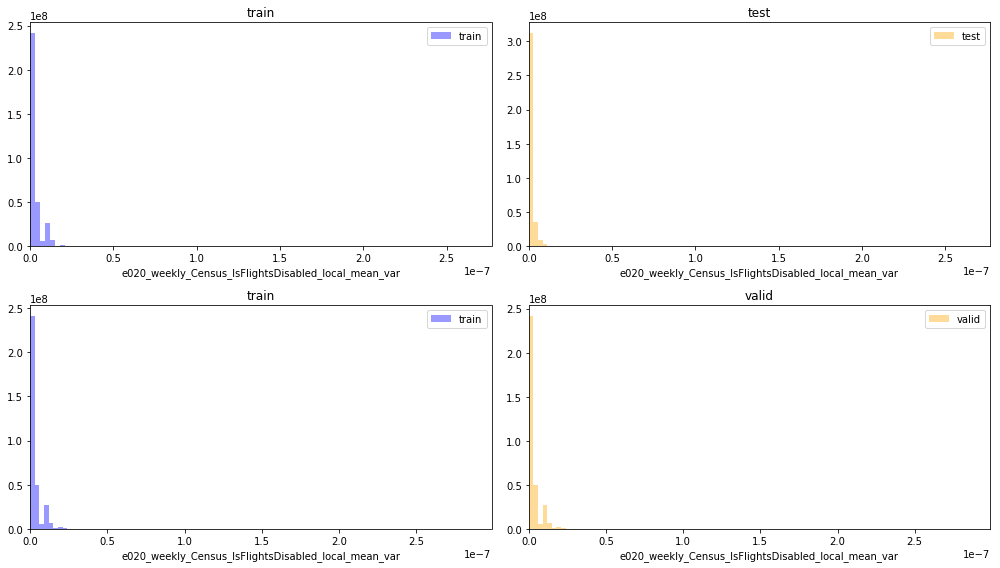

========== e020_IsProtected_local_mean ===========


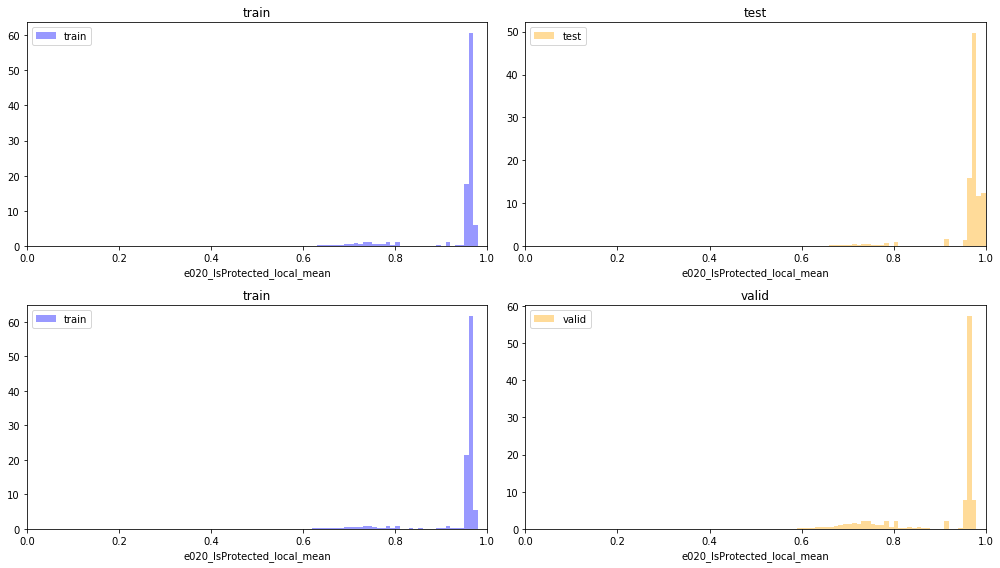

========== e020_six_hourly_Census_HasOpticalDiskDrive_local_mean_mean ===========


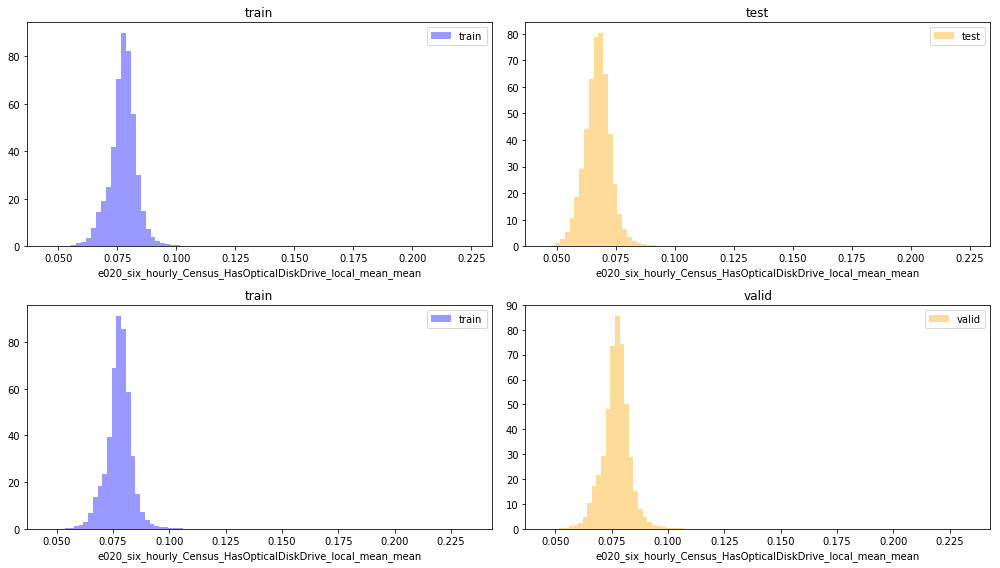

========== e020_six_hourly_Census_IsFlightingInternal_local_mean_mean ===========


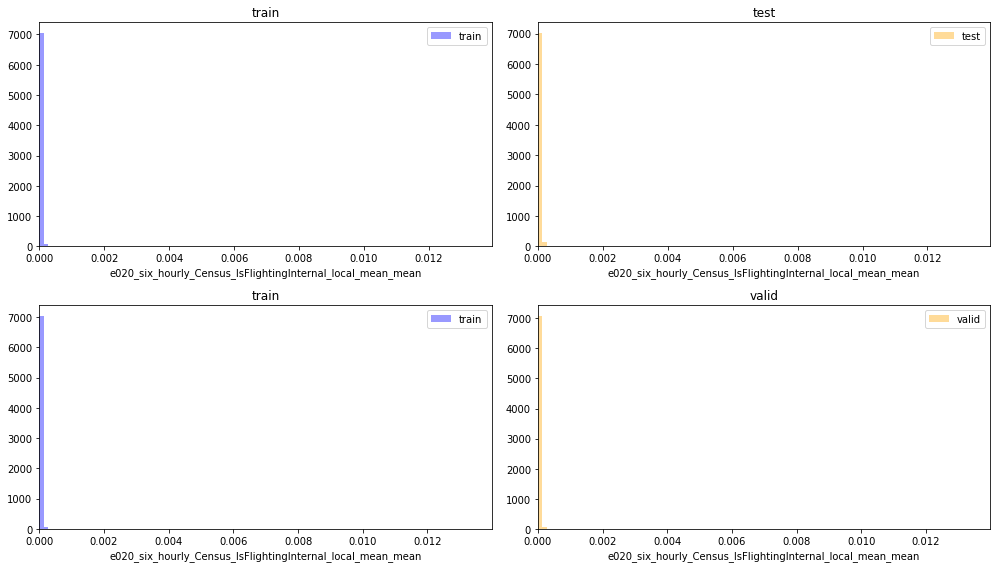

========== e020_weekly_Census_IsTouchEnabled_local_mean_cov ===========


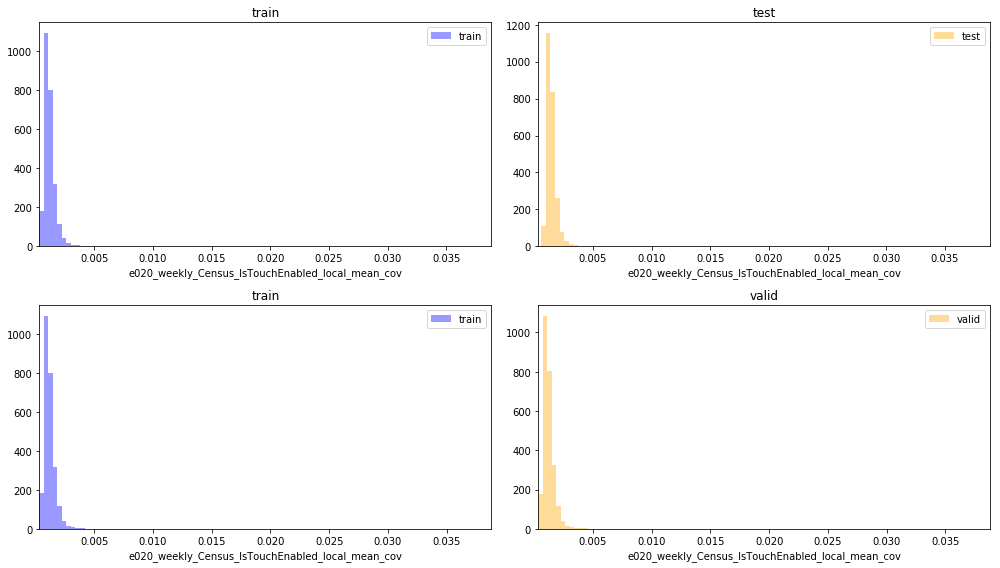

========== e020_daily_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var ===========


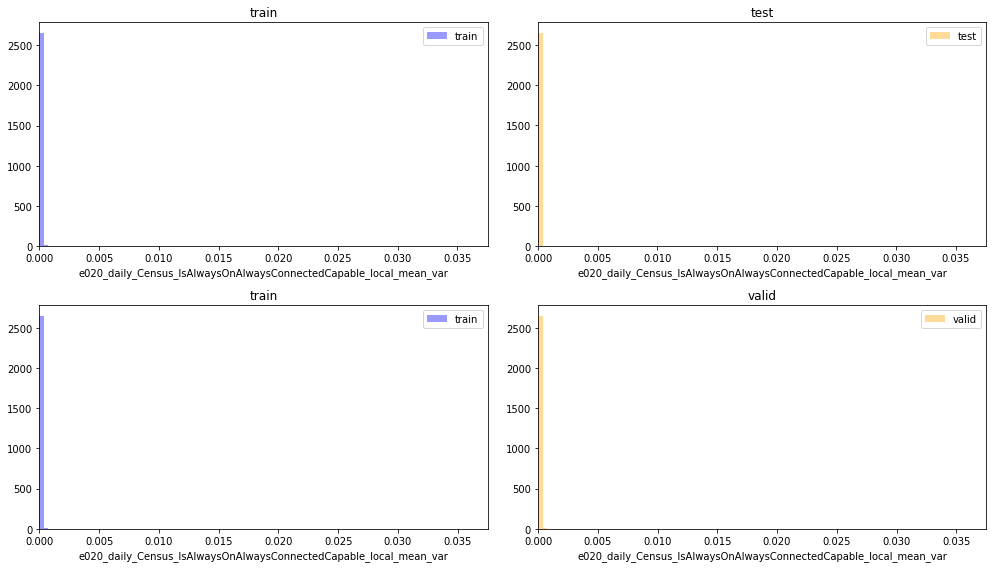

========== e020_six_hourly_SMode_local_mean_mean ===========


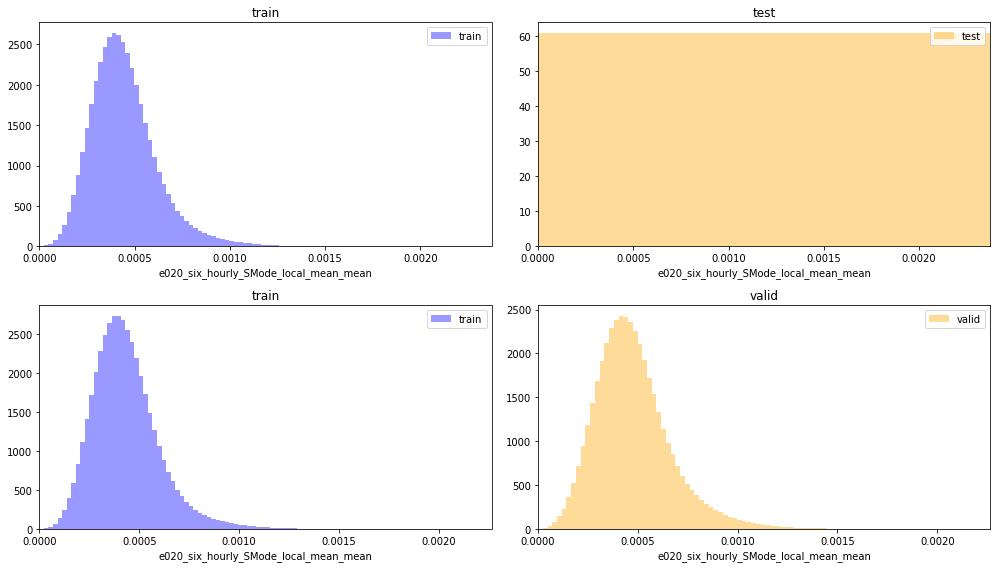

========== e020_daily_Census_ThresholdOptIn_local_mean_cov ===========


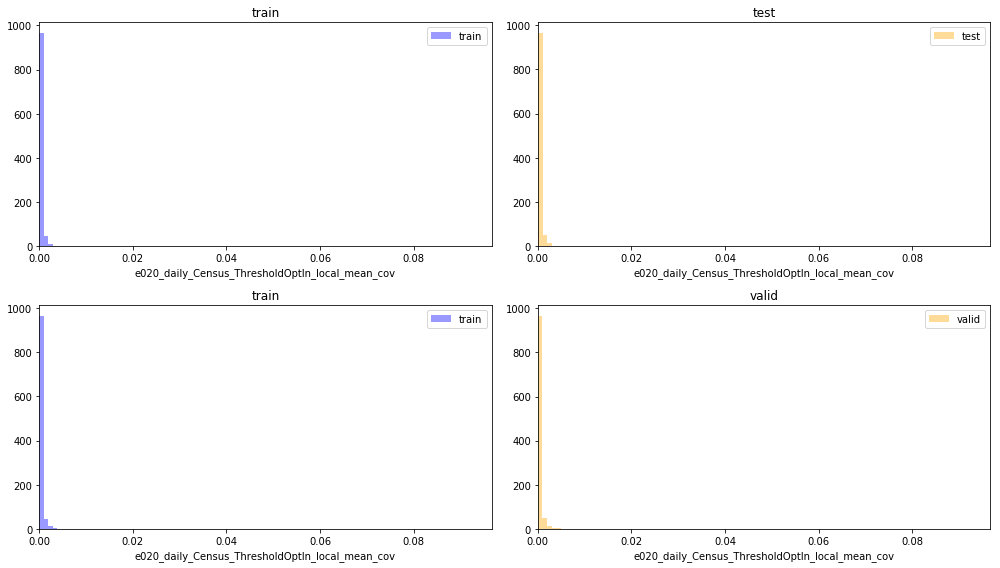

========== e020_weekly_AutoSampleOptIn_local_mean_cov ===========


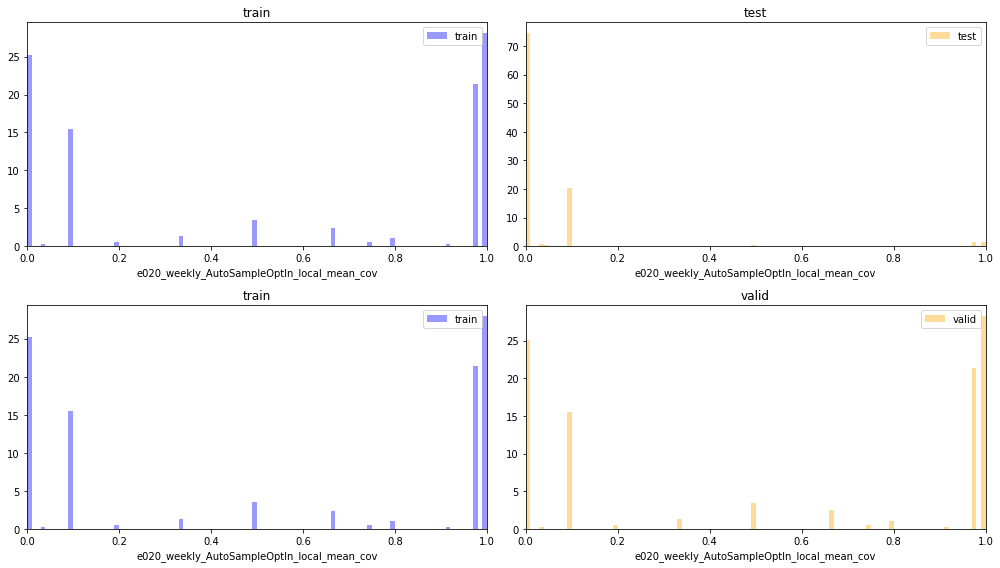

========== e020_monthly_AutoSampleOptIn_local_mean_cov ===========


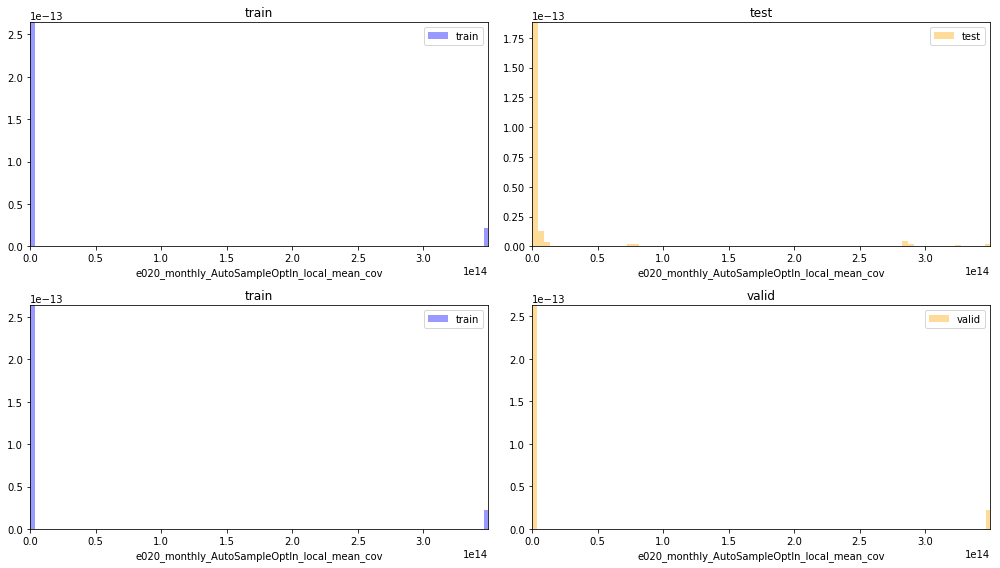

========== e020_daily_Census_HasOpticalDiskDrive_local_mean_var ===========


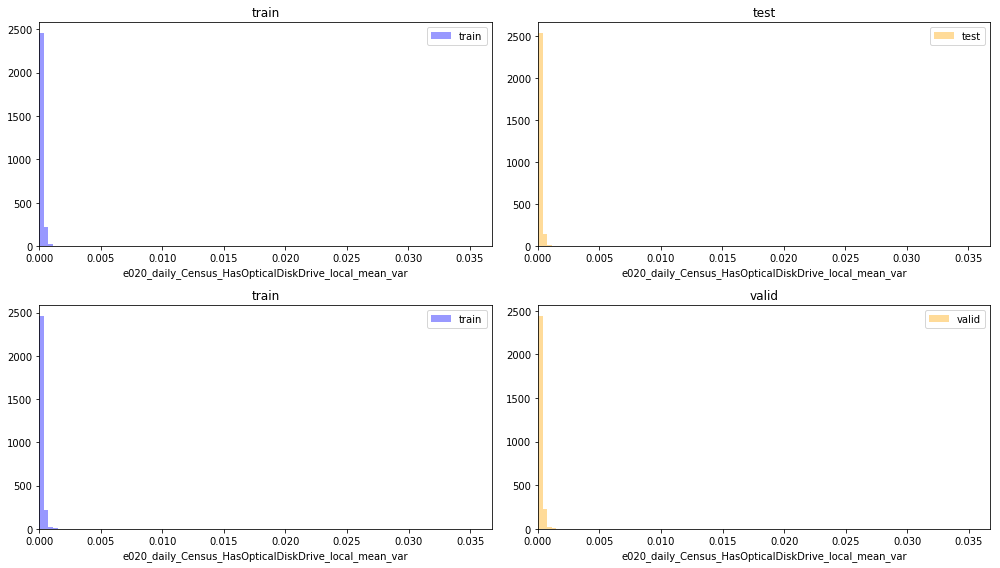

========== e020_Wdft_IsGamer_local_mean ===========


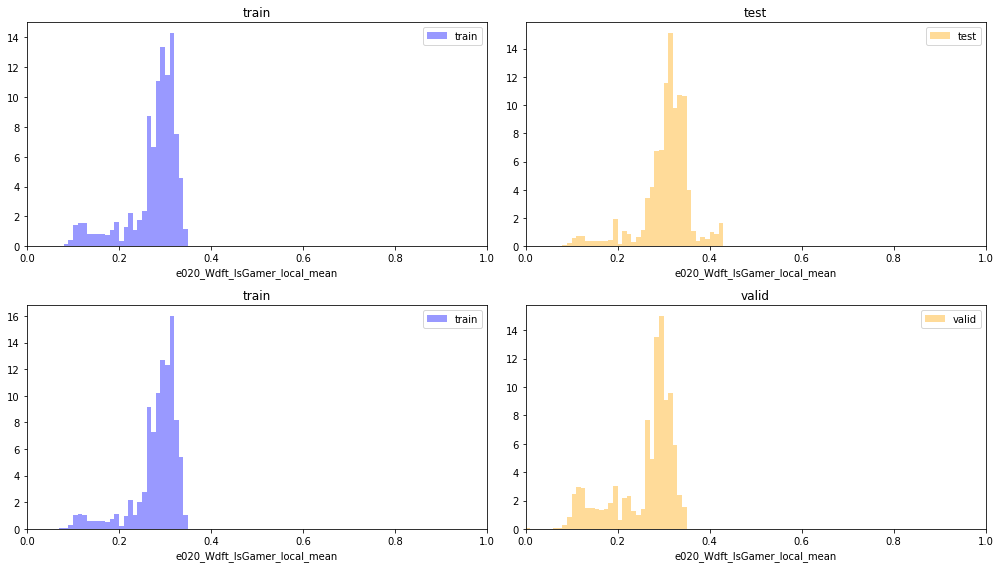

========== e020_weekly_HasDetections_local_mean_var ===========


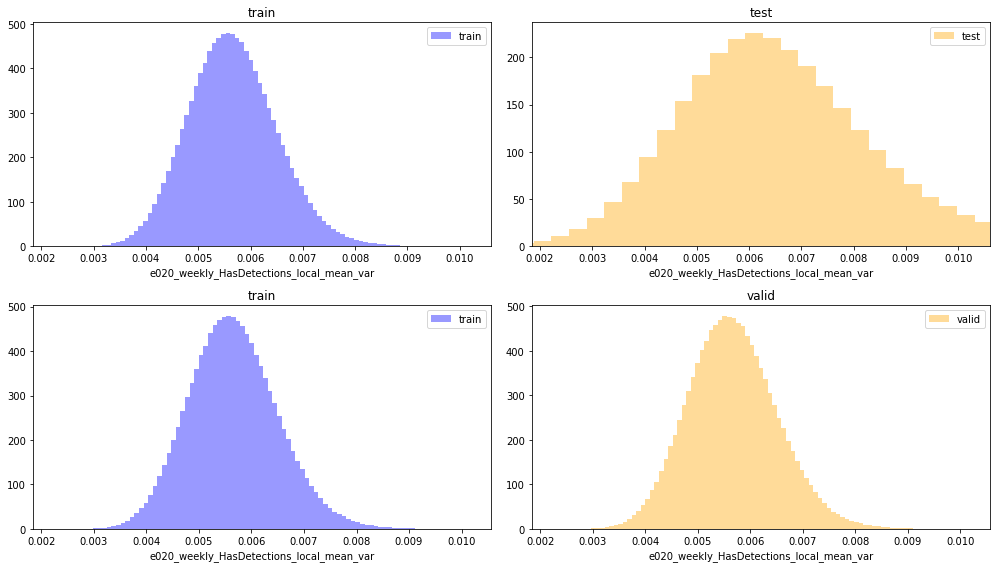

========== e020_daily_HasTpm_local_mean_var ===========


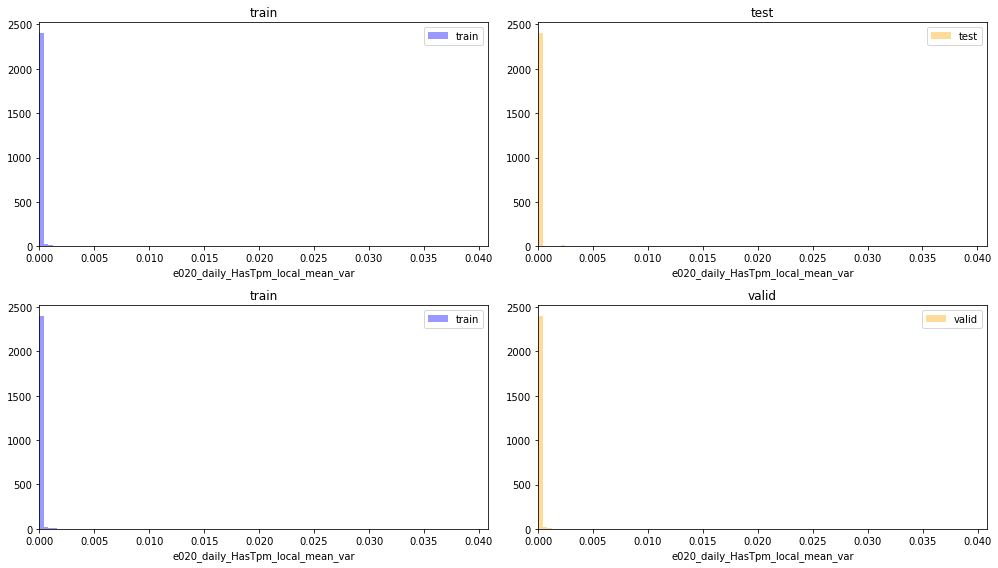

========== e020_weekly_Firewall_local_mean_var ===========


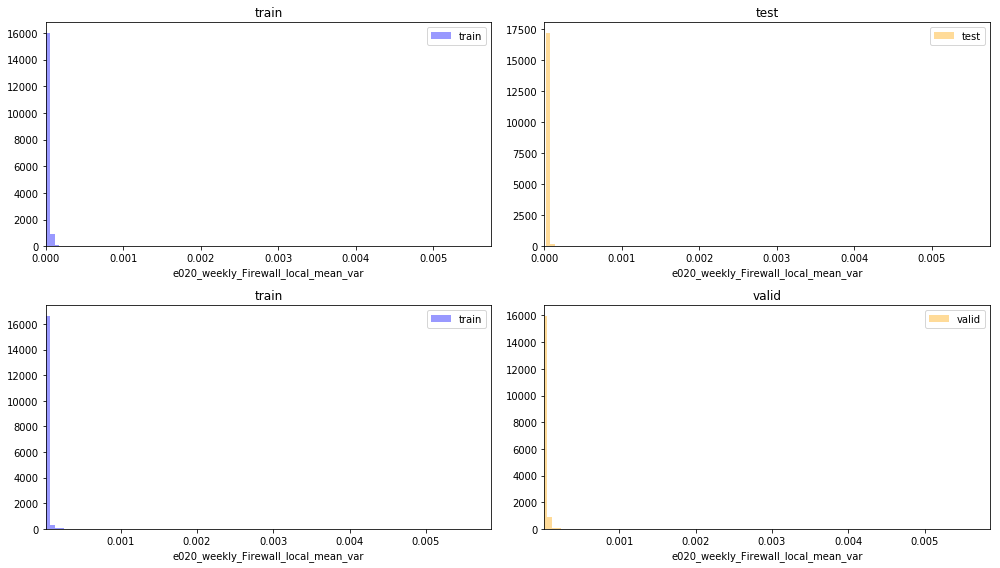

========== e020_monthly_HasDetections_local_mean_var ===========


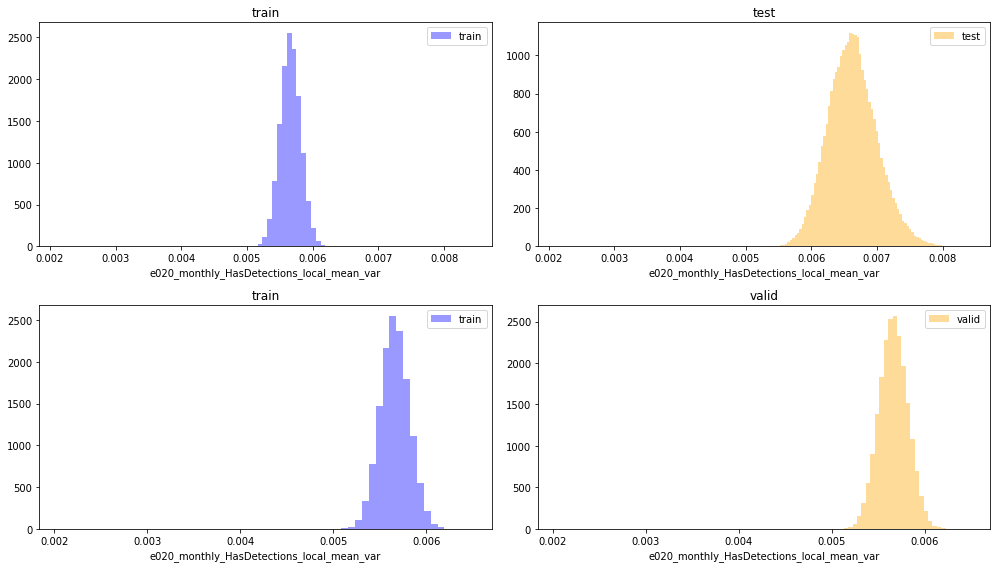

========== e020_Census_IsVirtualDevice_local_mean ===========


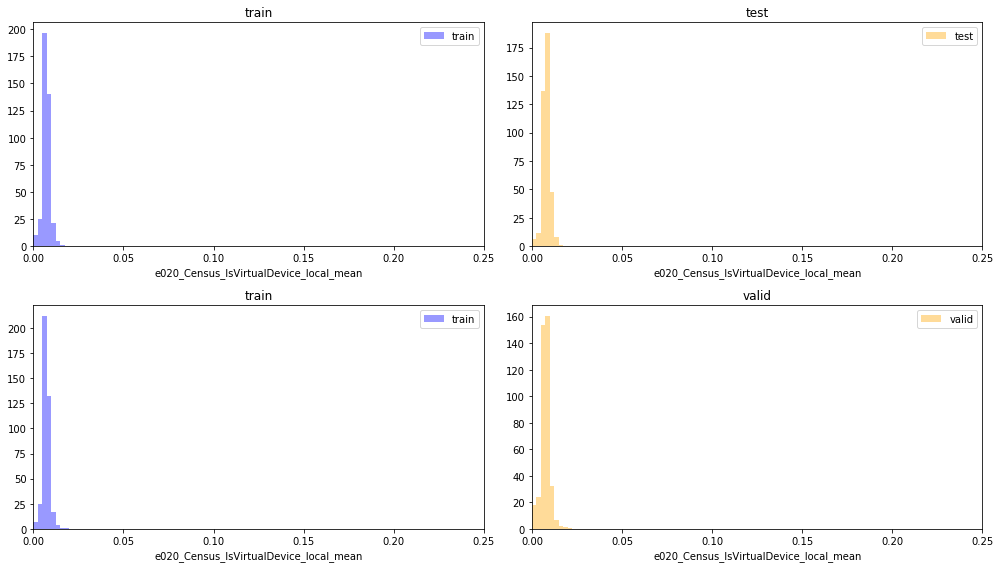

========== e020_monthly_Firewall_local_mean_var ===========


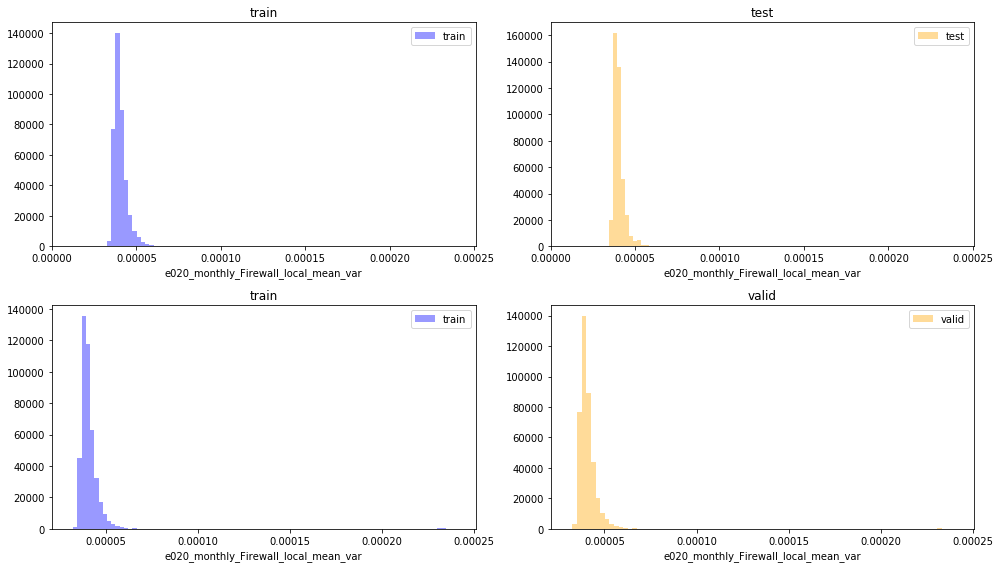

========== e020_weekly_Census_IsPenCapable_local_mean_mean ===========


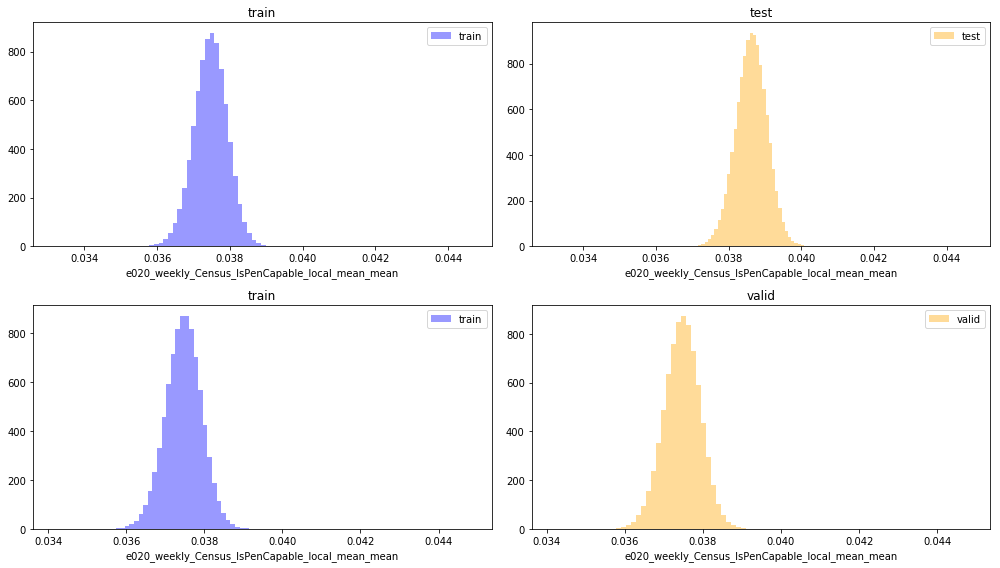

========== e020_six_hourly_Census_IsSecureBootEnabled_local_mean_var ===========


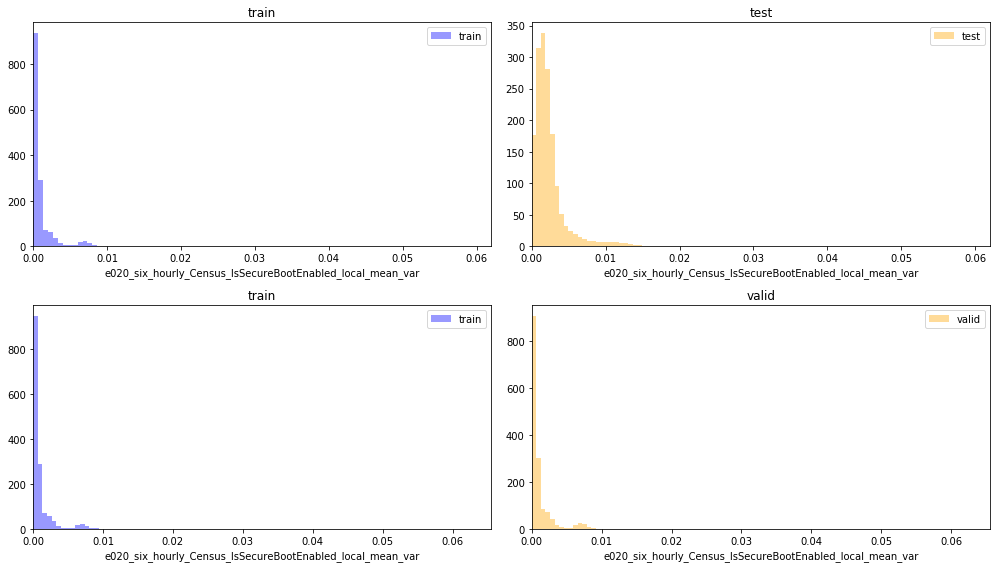

========== e020_weekly_IsProtected_local_mean_var ===========


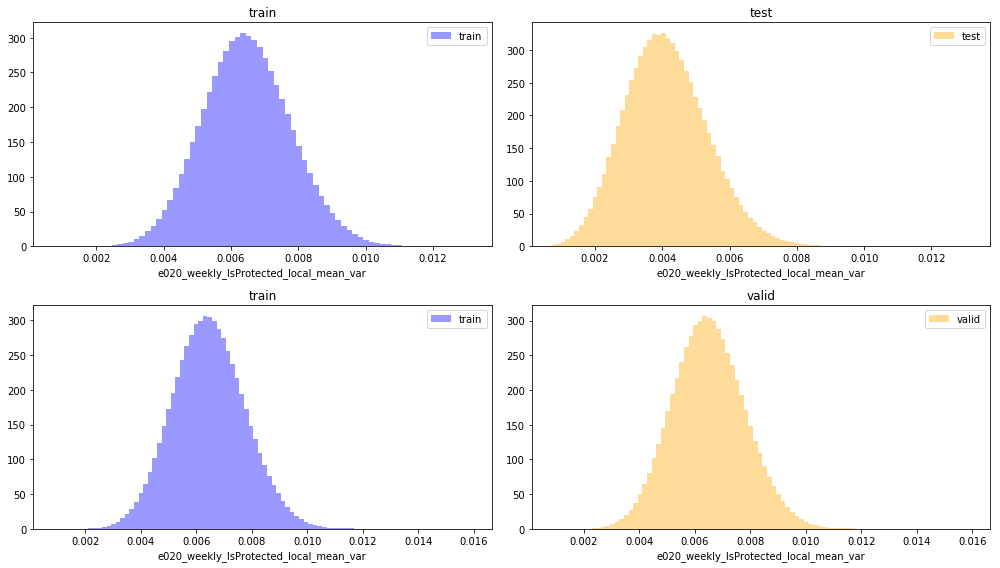

========== e020_six_hourly_Census_ThresholdOptIn_local_mean_var ===========


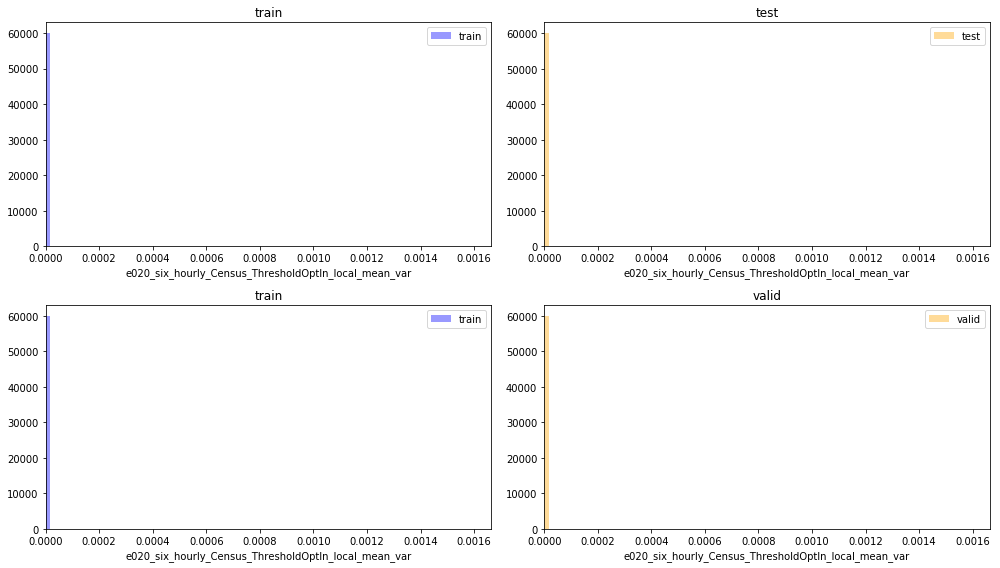

========== e020_monthly_HasTpm_local_mean_cov ===========


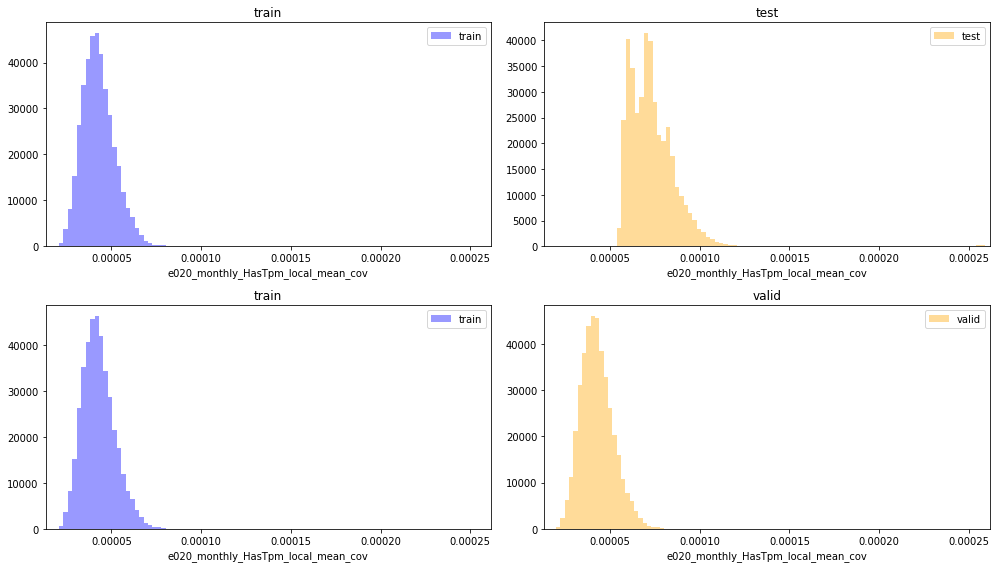

========== e020_daily_Census_IsSecureBootEnabled_local_mean_var ===========


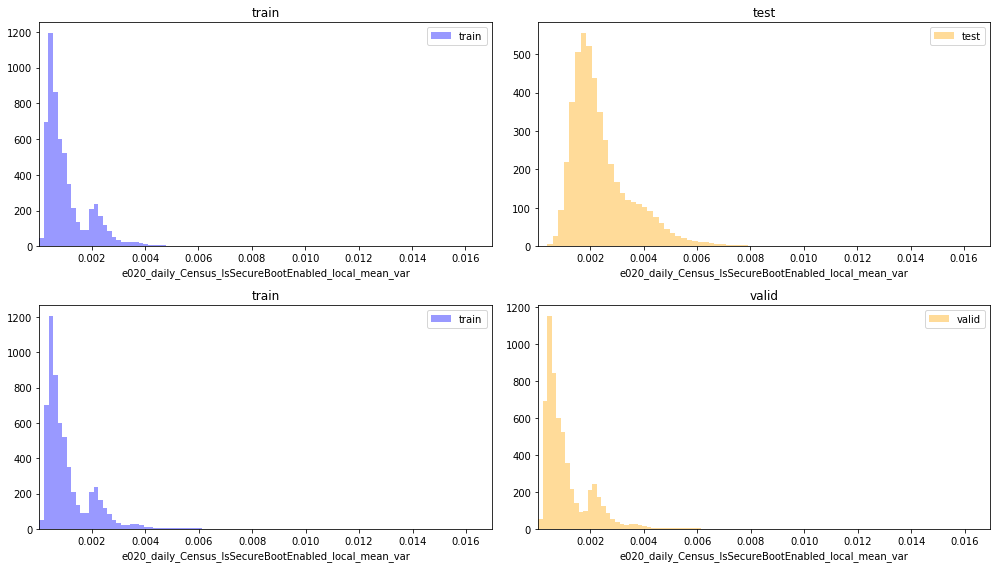

========== e020_daily_Census_IsFlightingInternal_local_mean_mean ===========


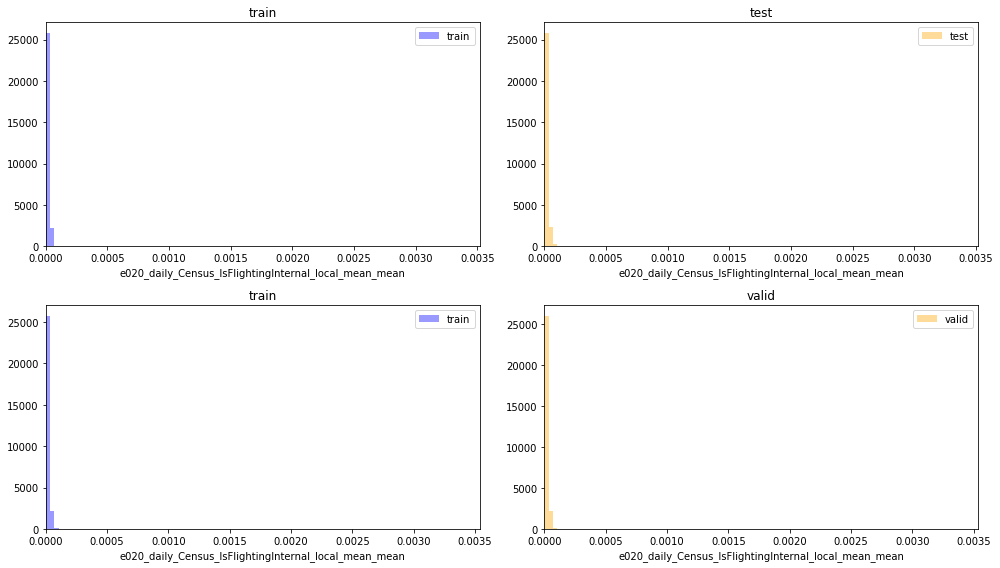

========== e020_HasTpm_local_mean ===========


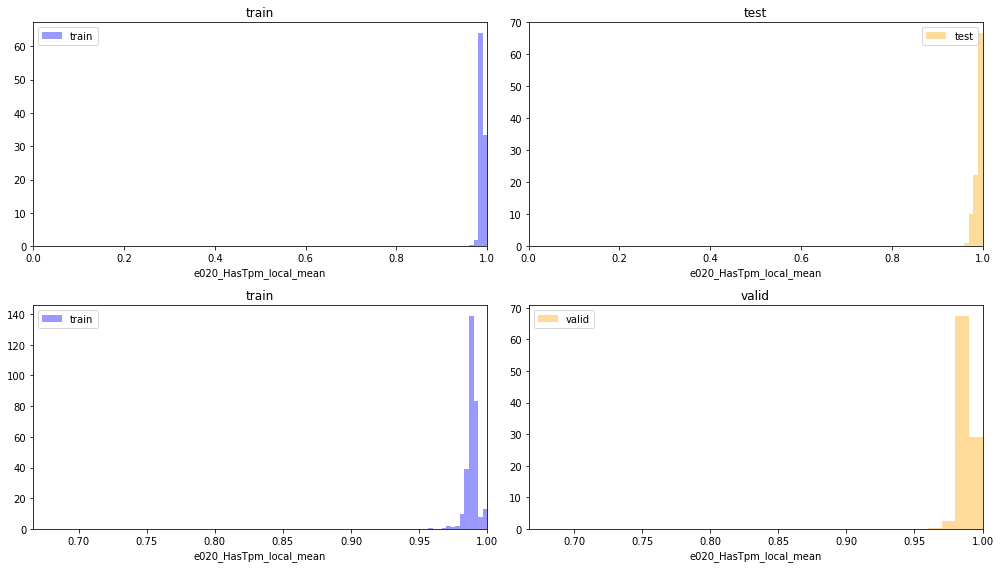

========== e020_daily_Census_IsPortableOperatingSystem_local_mean_cov ===========


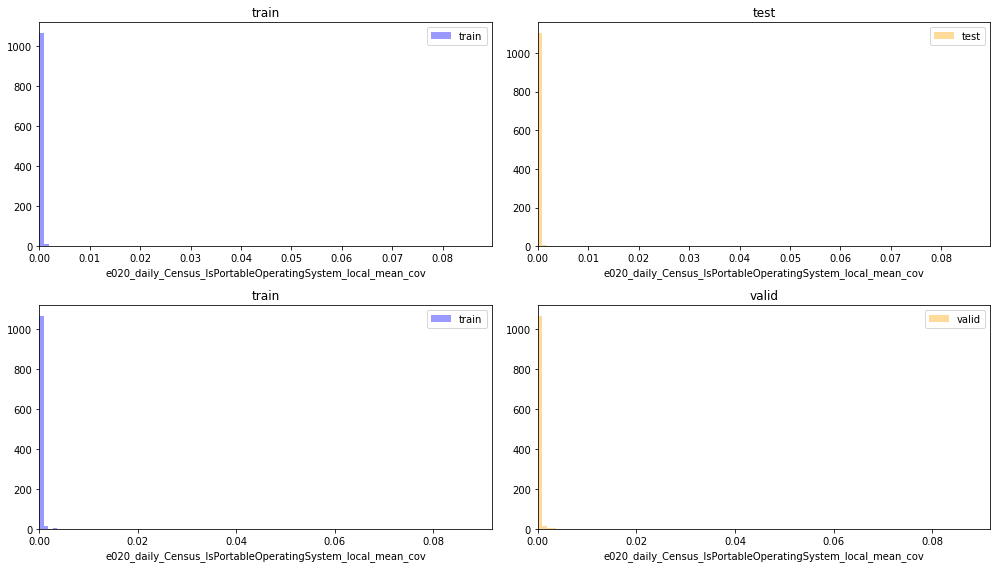

========== e020_weekly_Census_IsWIMBootEnabled_local_mean_mean ===========


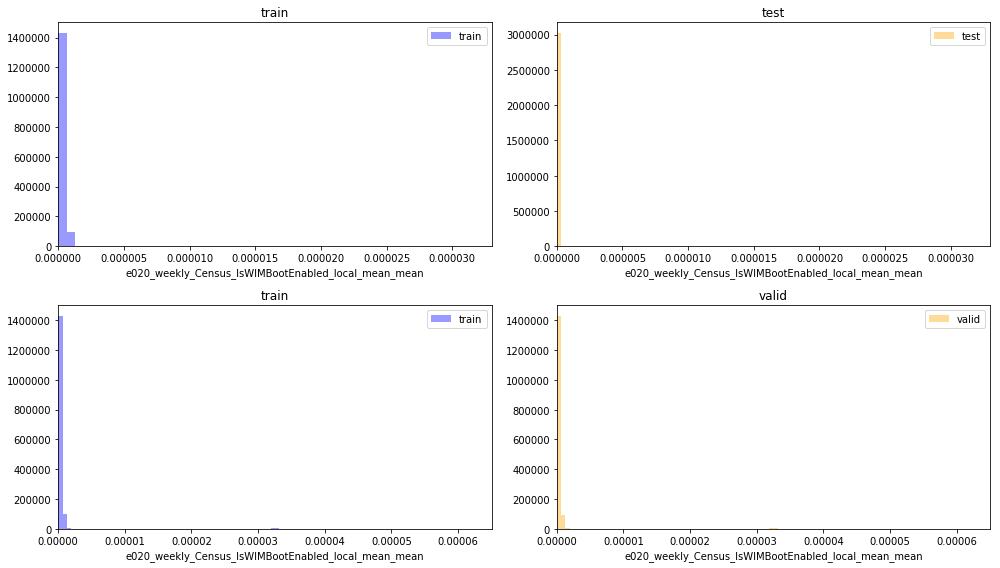

========== e020_daily_IsBeta_local_mean_var ===========


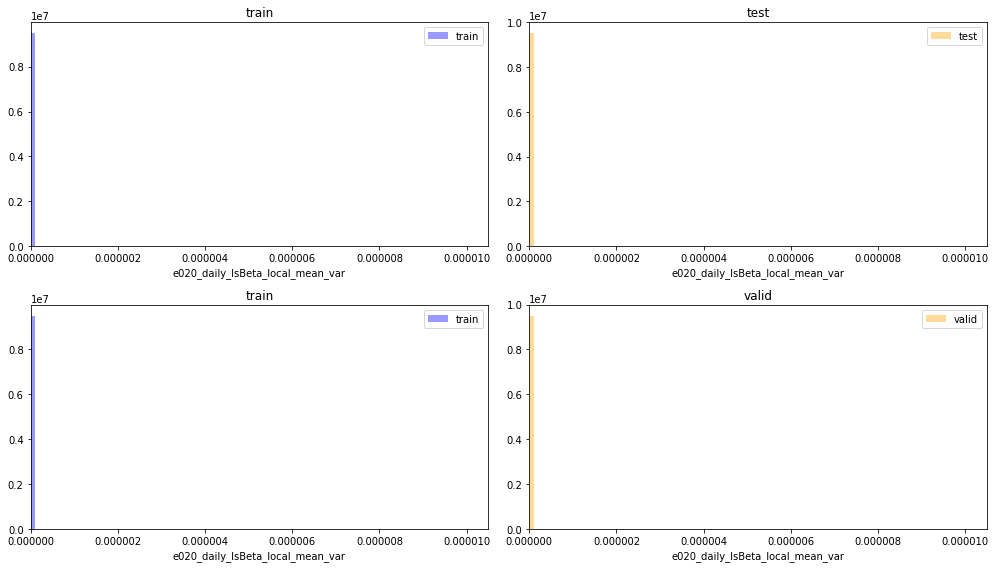

========== e020_weekly_HasTpm_local_mean_mean ===========


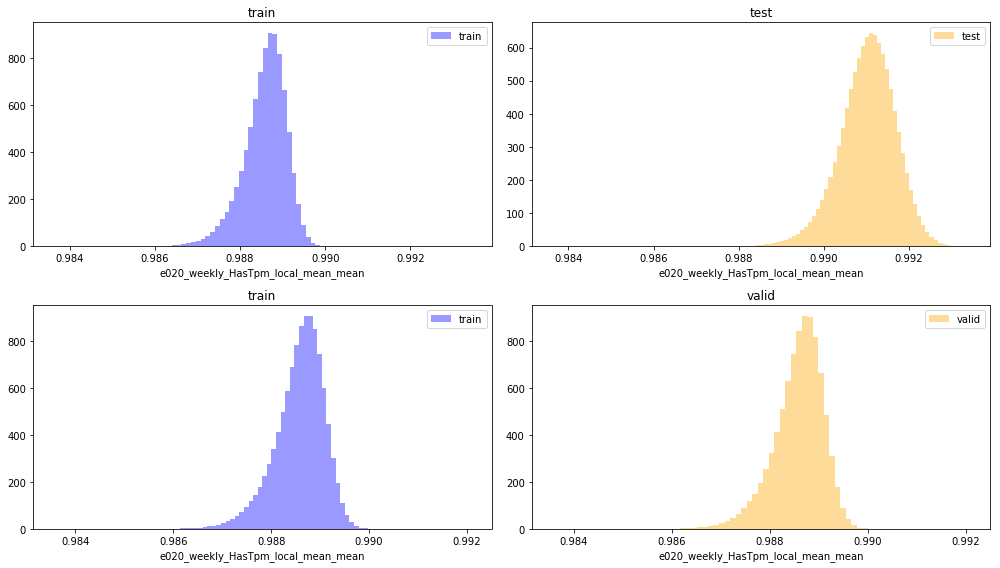

========== e020_weekly_IsSxsPassiveMode_local_mean_var ===========


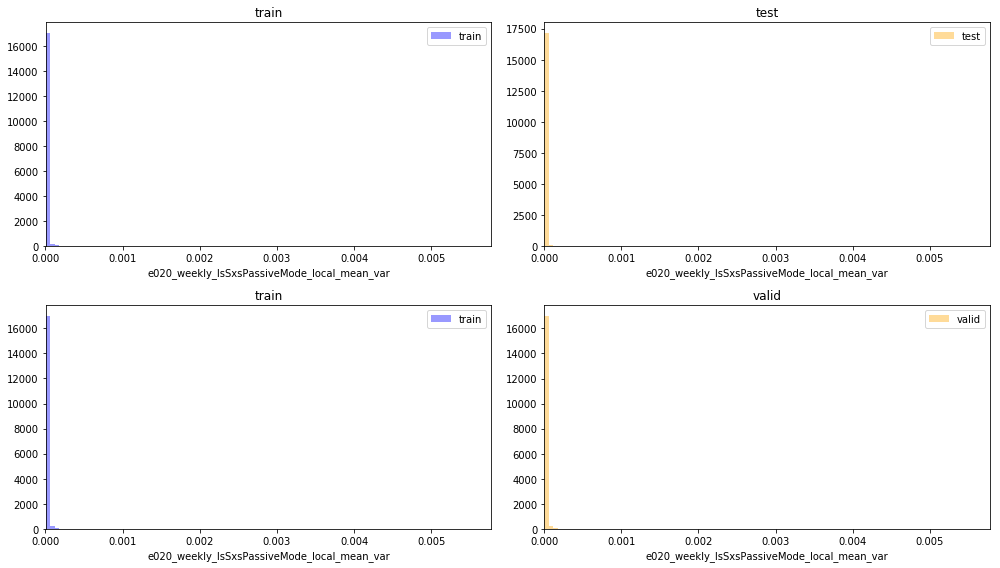

========== e020_daily_SMode_local_mean_var ===========


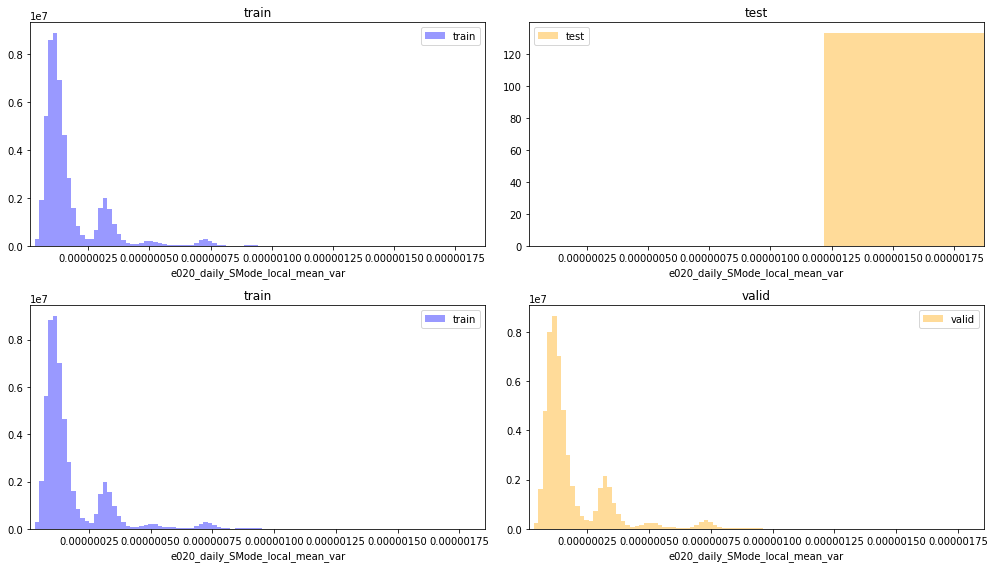

========== e020_weekly_Census_IsFlightingInternal_local_mean_cov ===========


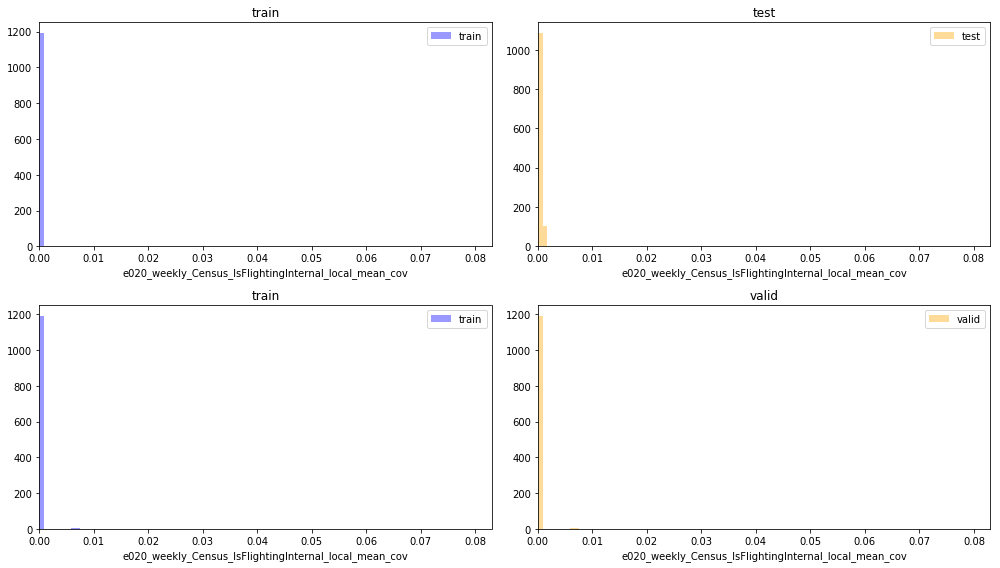

========== e020_daily_HasDetections_local_mean_mean ===========


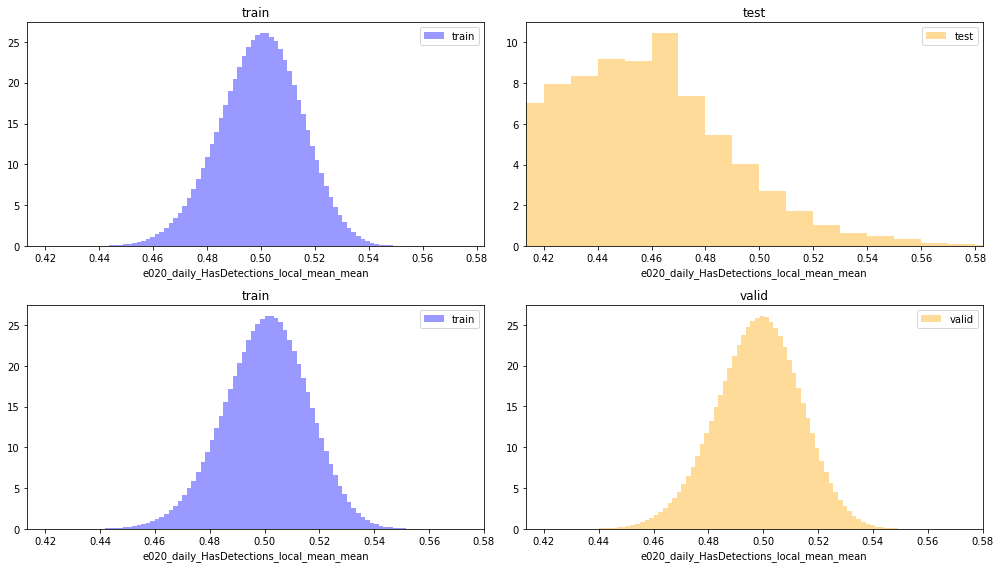

========== e020_six_hourly_Census_IsPortableOperatingSystem_local_mean_mean ===========


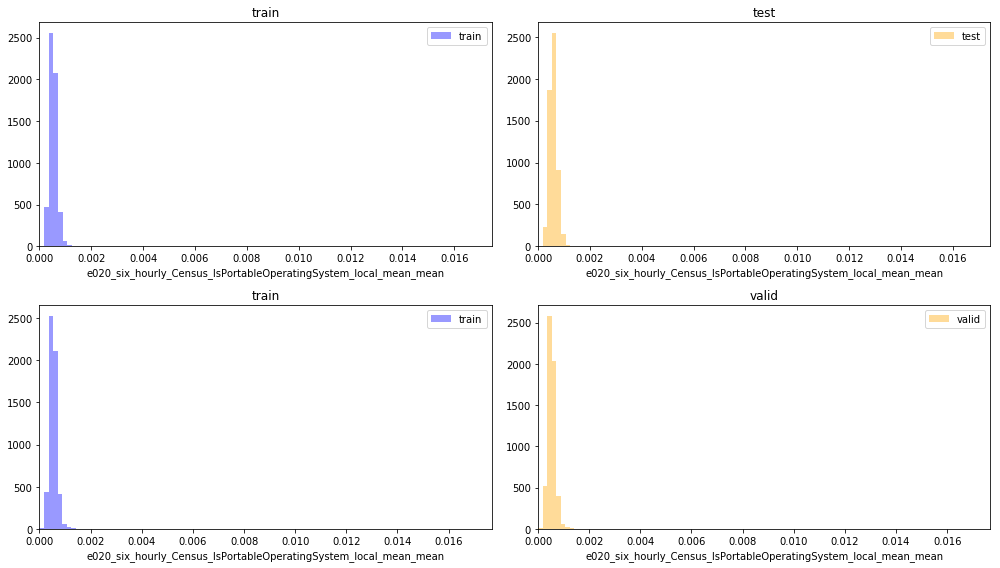

========== e020_daily_Census_IsPenCapable_local_mean_var ===========


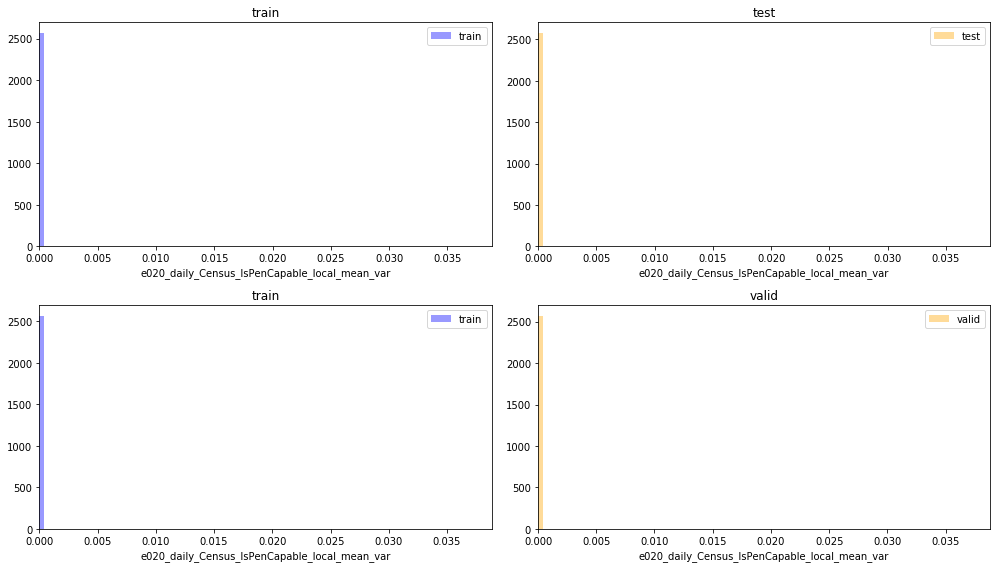

========== e020_daily_Census_ThresholdOptIn_local_mean_mean ===========


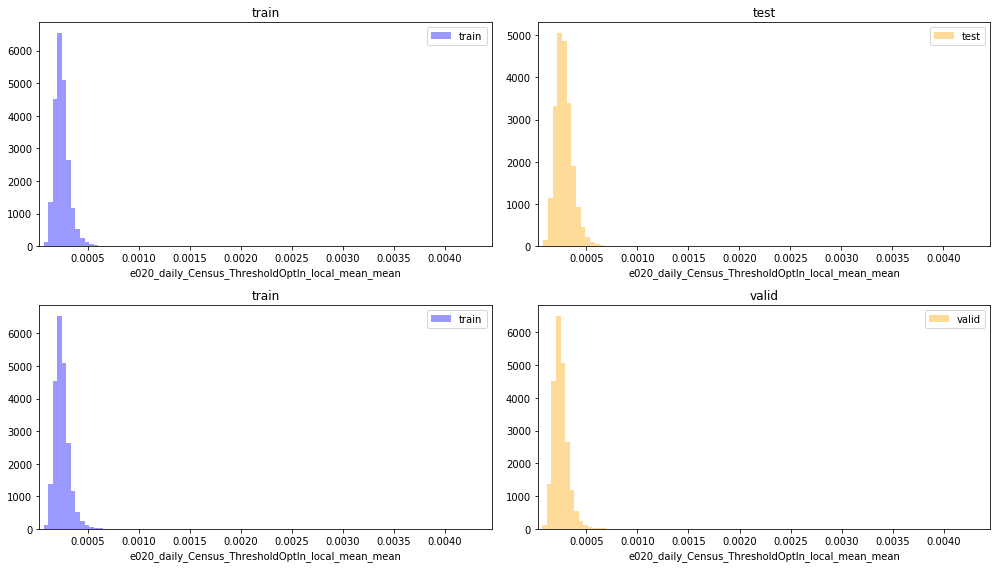

========== e020_weekly_AutoSampleOptIn_local_mean_var ===========


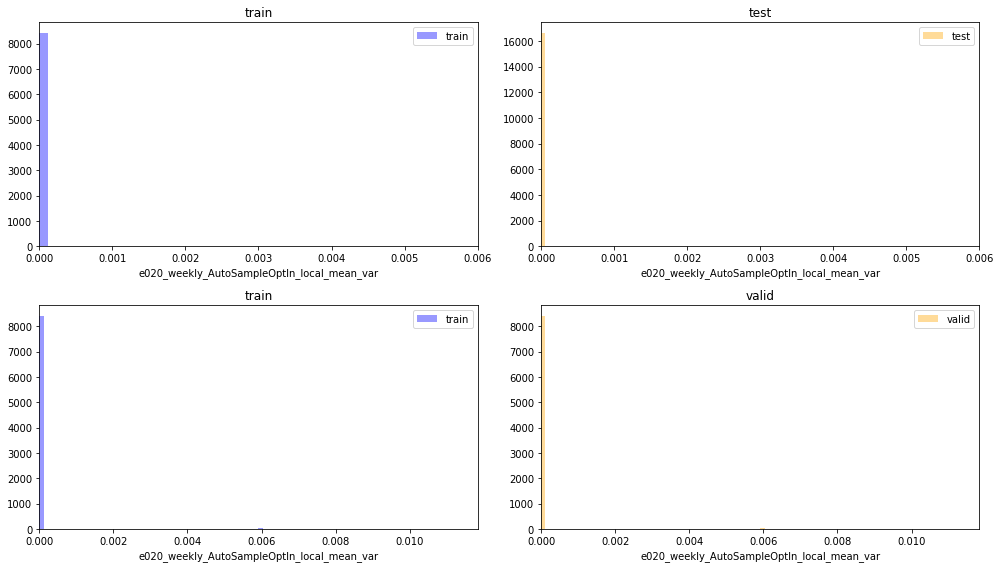

========== e020_monthly_Census_HasOpticalDiskDrive_local_mean_var ===========


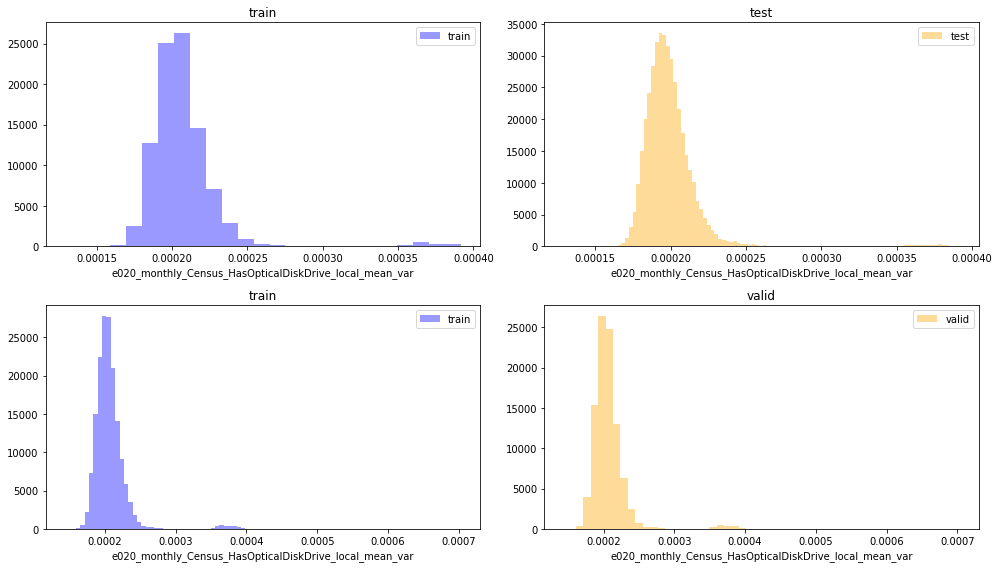

========== e020_daily_AutoSampleOptIn_local_mean_mean ===========


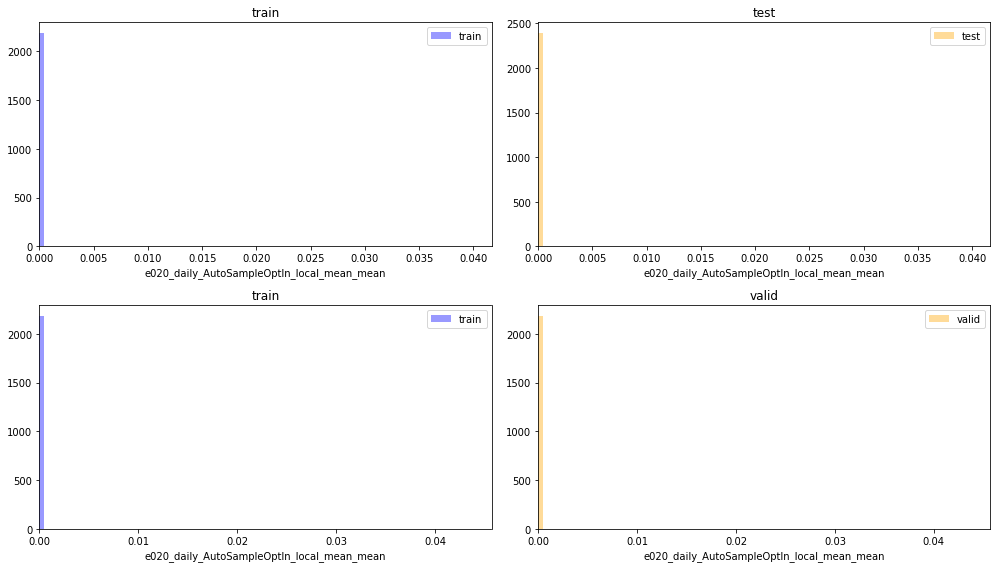

========== e020_weekly_SMode_local_mean_var ===========


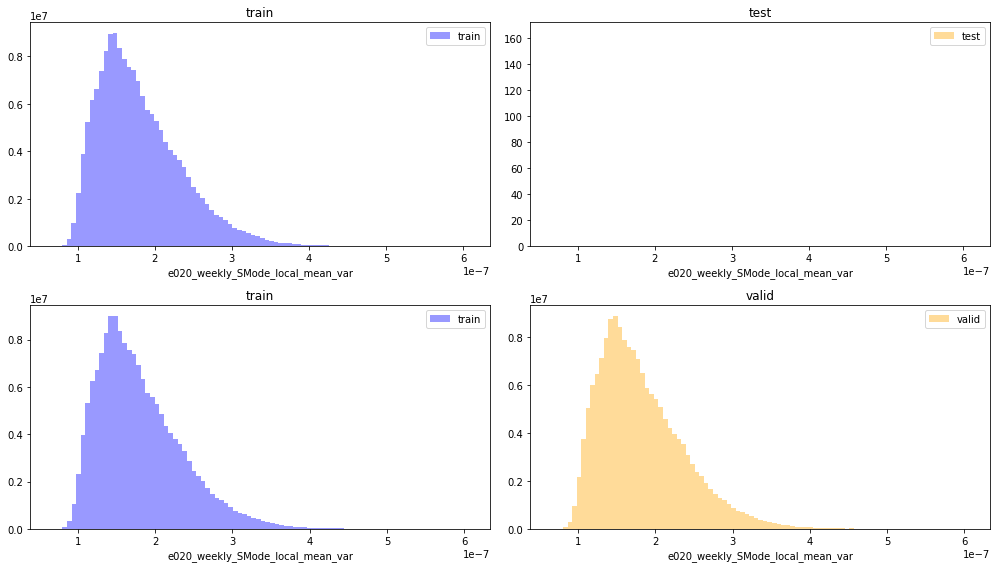

========== e020_weekly_Census_IsPortableOperatingSystem_local_mean_mean ===========


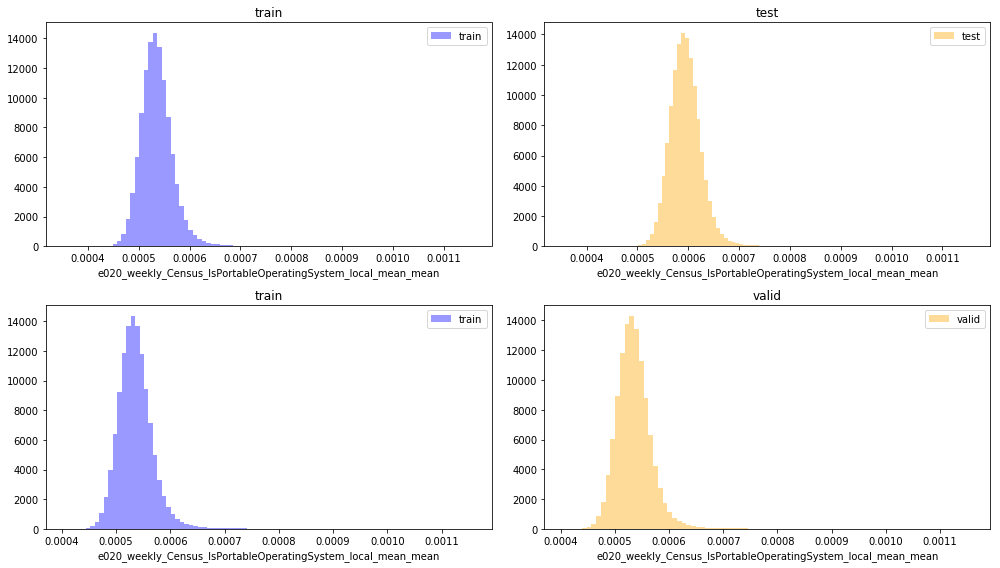

========== e020_weekly_Census_IsPenCapable_local_mean_var ===========


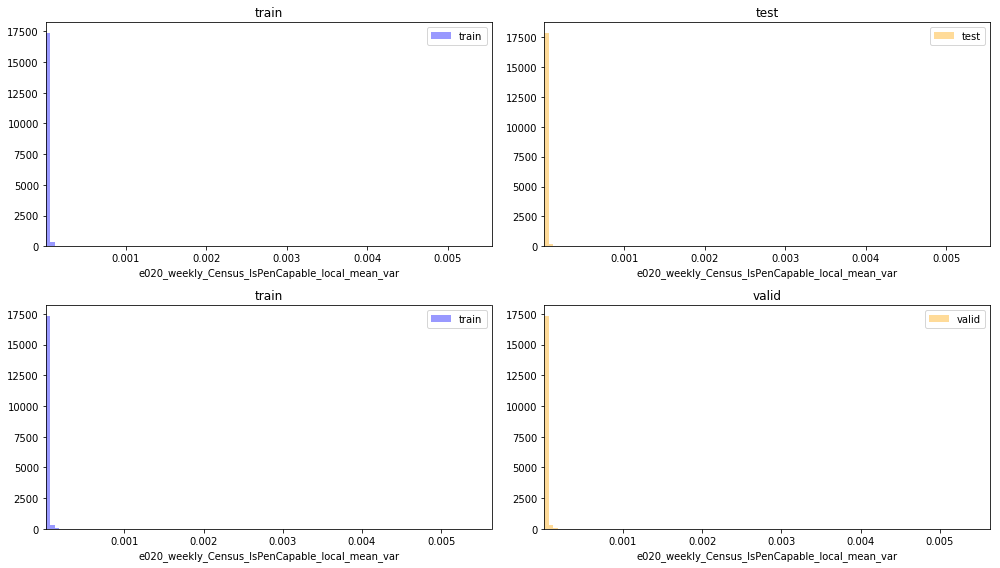

========== e020_daily_IsBeta_local_mean_mean ===========


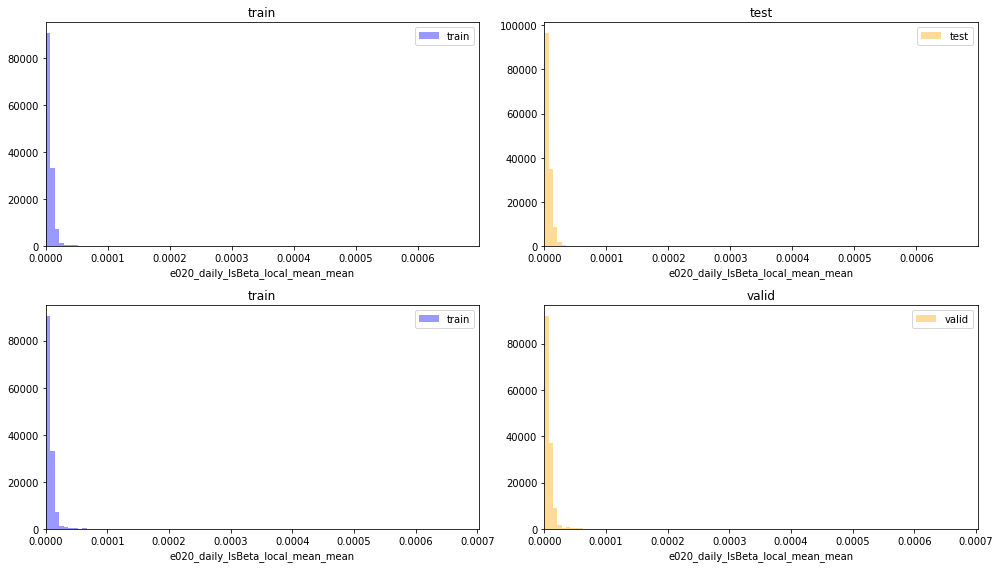

========== e020_six_hourly_Census_IsWIMBootEnabled_local_mean_mean ===========


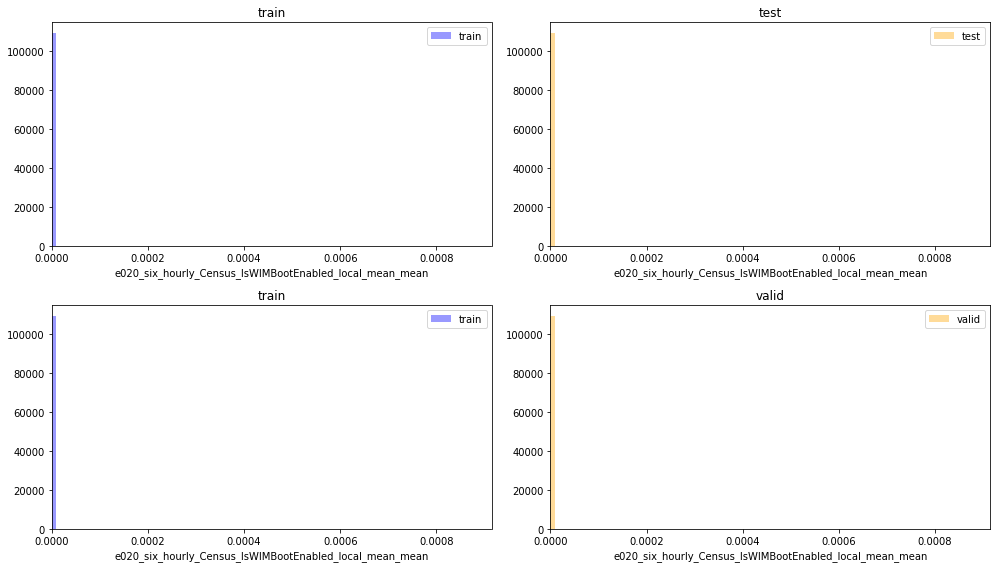

========== e020_SMode_local_mean ===========


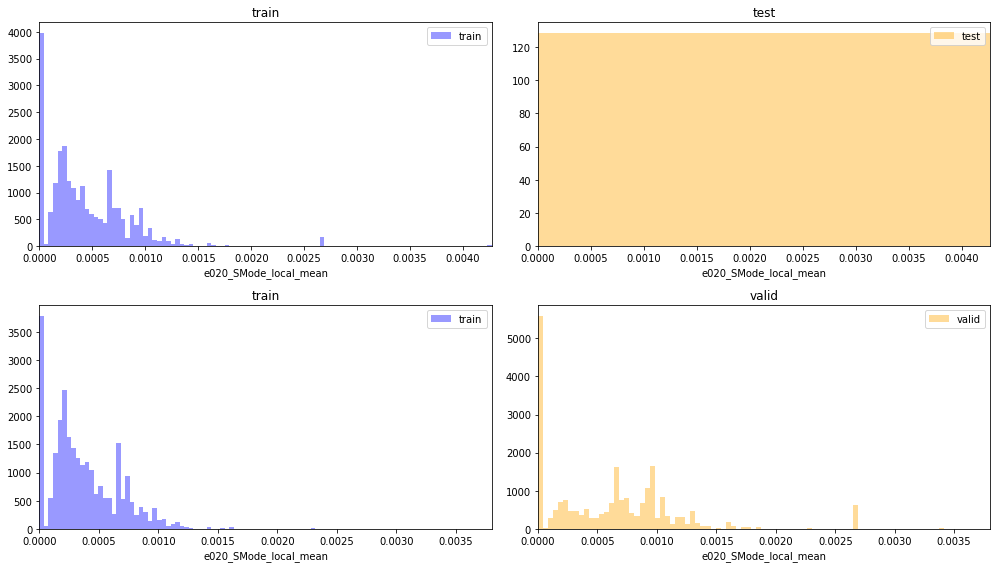

========== e020_weekly_Census_HasOpticalDiskDrive_local_mean_var ===========


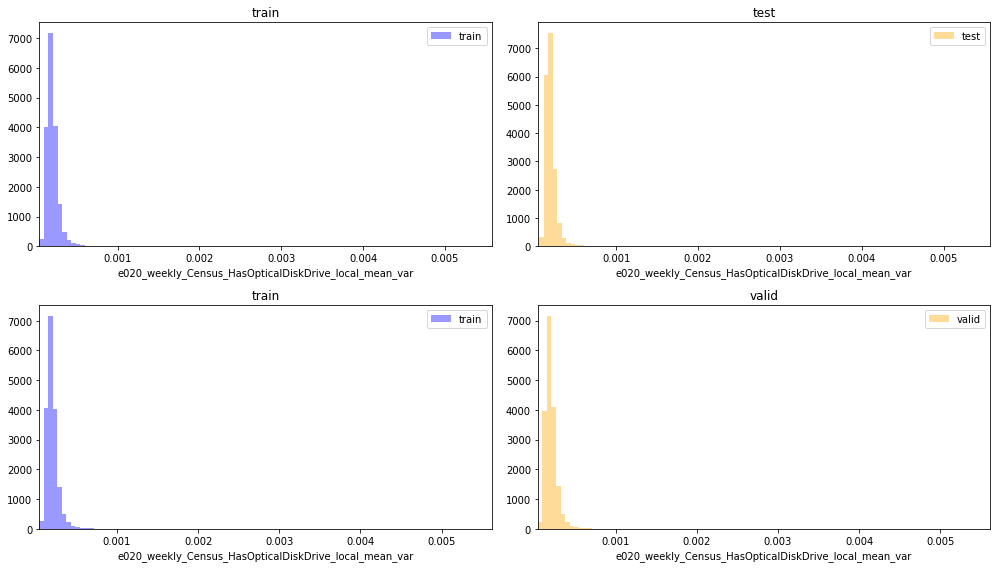

========== e020_monthly_Census_IsSecureBootEnabled_local_mean_var ===========


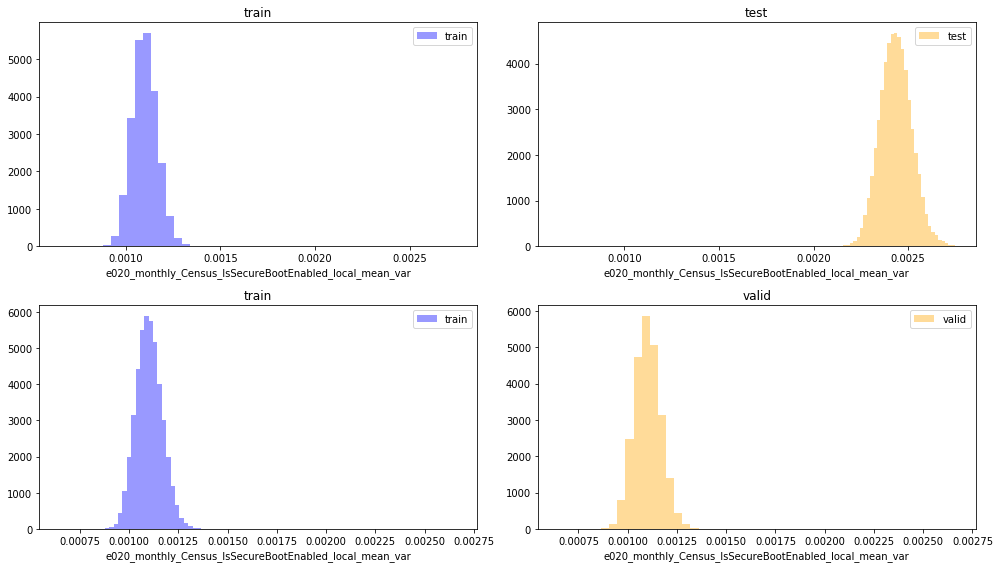

========== e020_Census_ThresholdOptIn_local_mean ===========


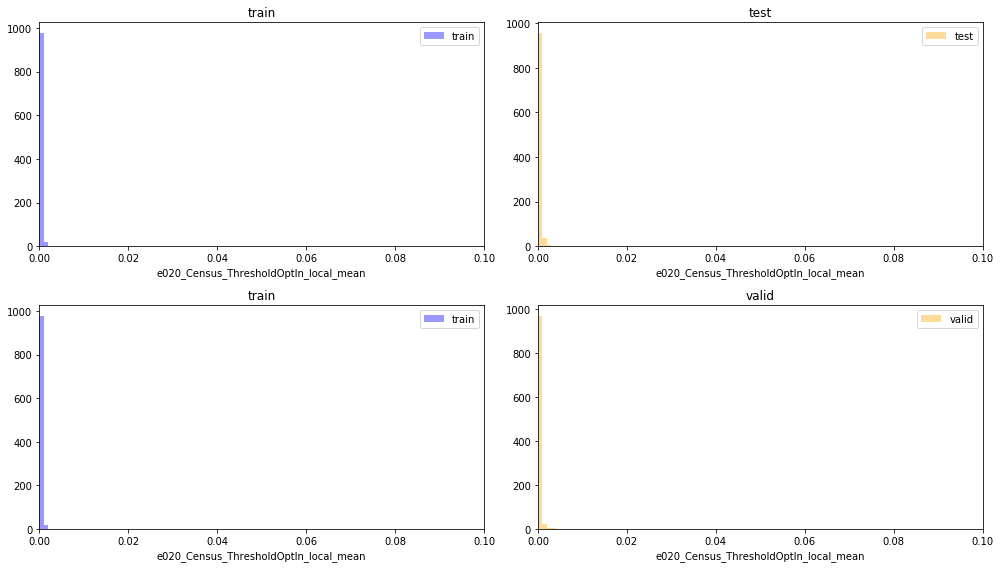

========== e020_six_hourly_Census_IsPenCapable_local_mean_cov ===========


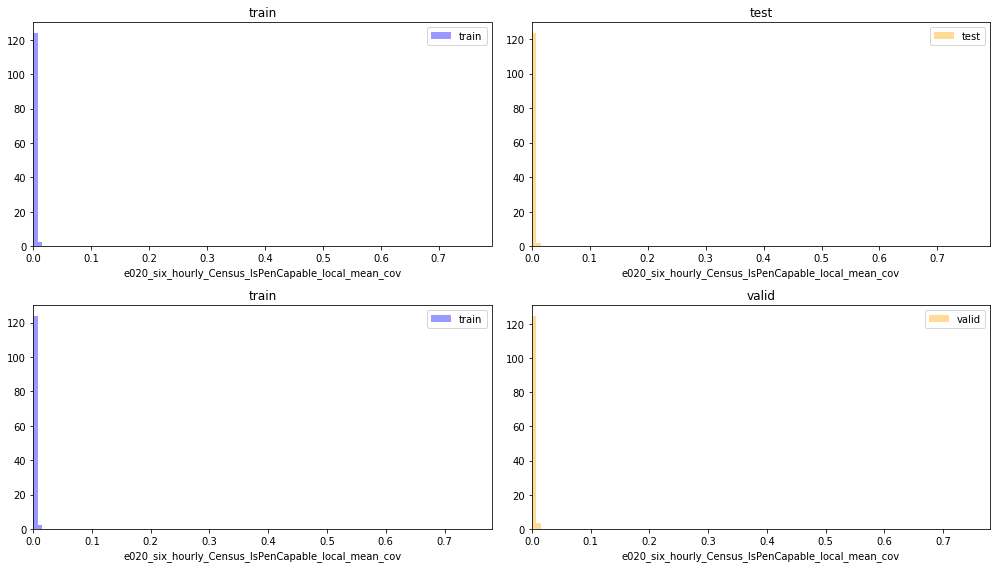

========== e020_daily_IsBeta_local_mean_cov ===========


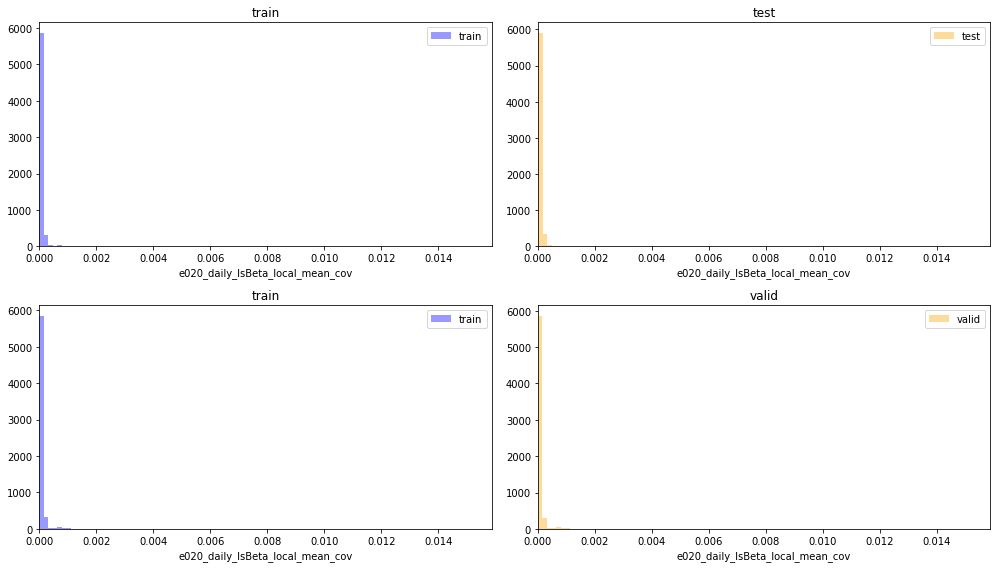

========== e020_Census_IsPortableOperatingSystem_local_mean ===========


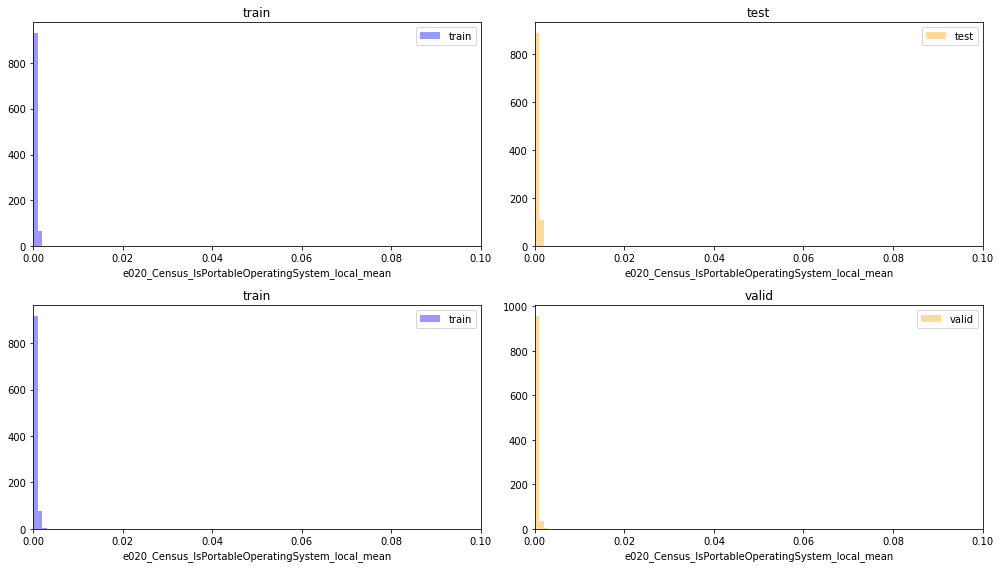

========== e020_weekly_Wdft_IsGamer_local_mean_var ===========


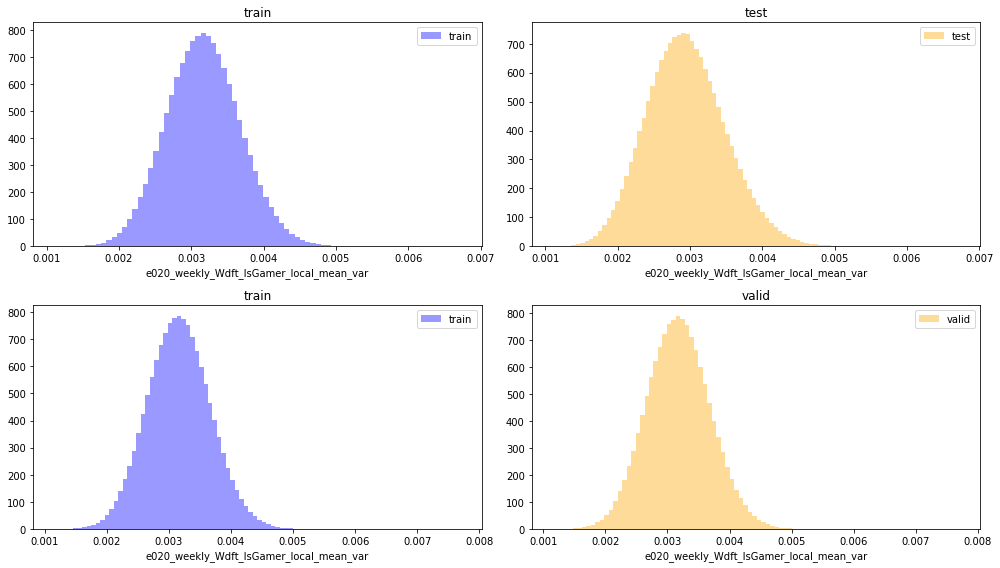

========== e020_six_hourly_Census_IsVirtualDevice_local_mean_var ===========


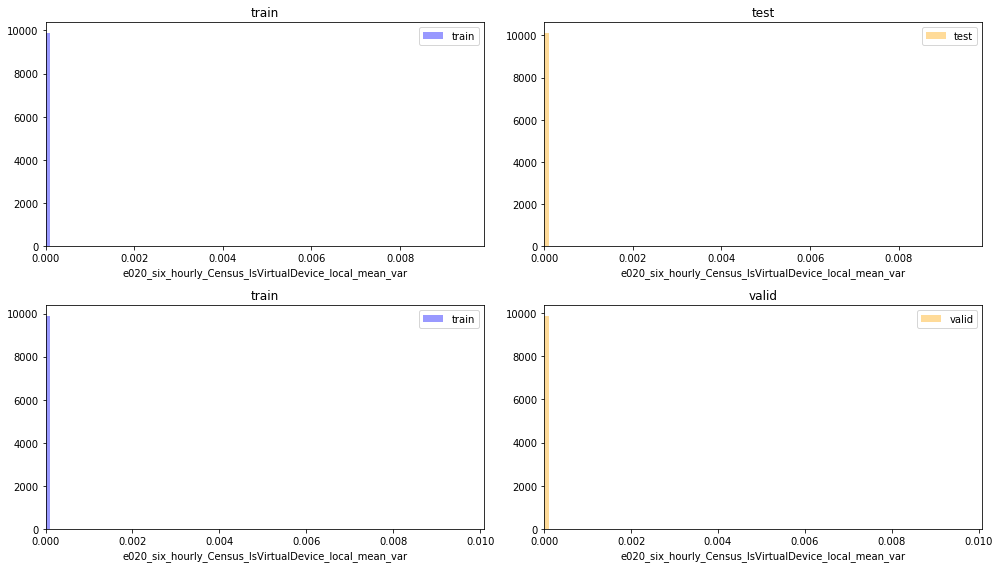

========== e020_daily_HasDetections_local_mean_cov ===========


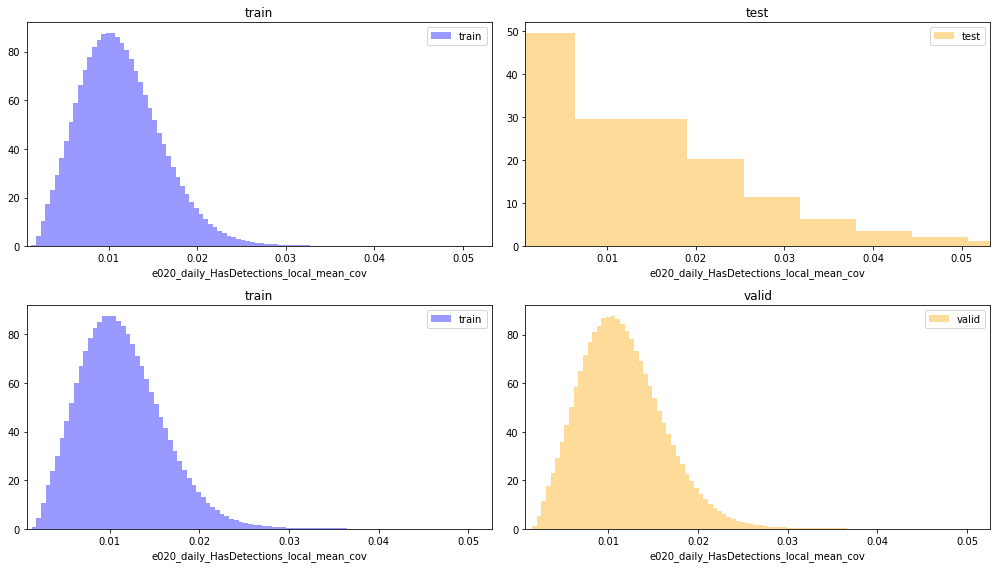

========== e020_AutoSampleOptIn_local_mean ===========


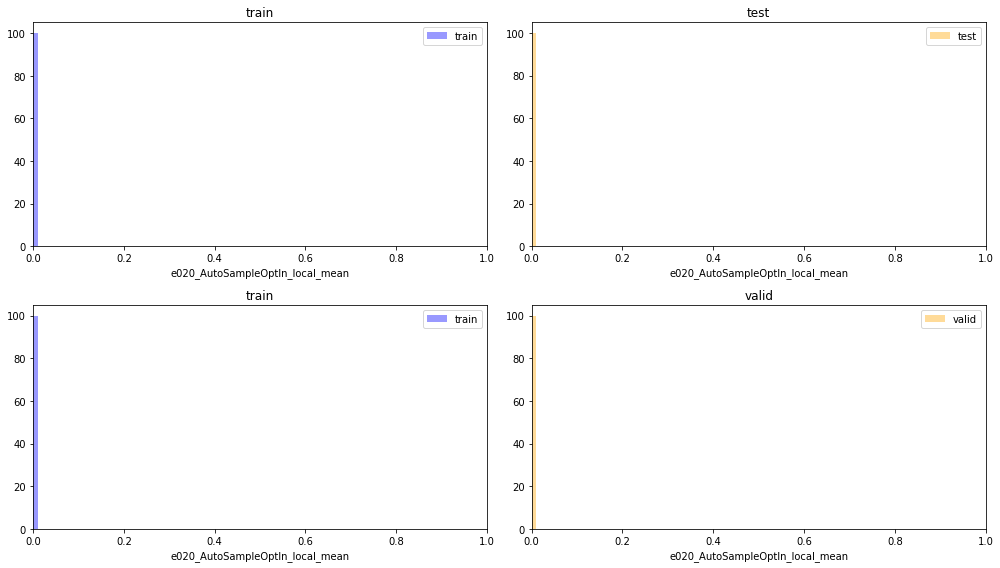

========== e020_weekly_IsSxsPassiveMode_local_mean_cov ===========


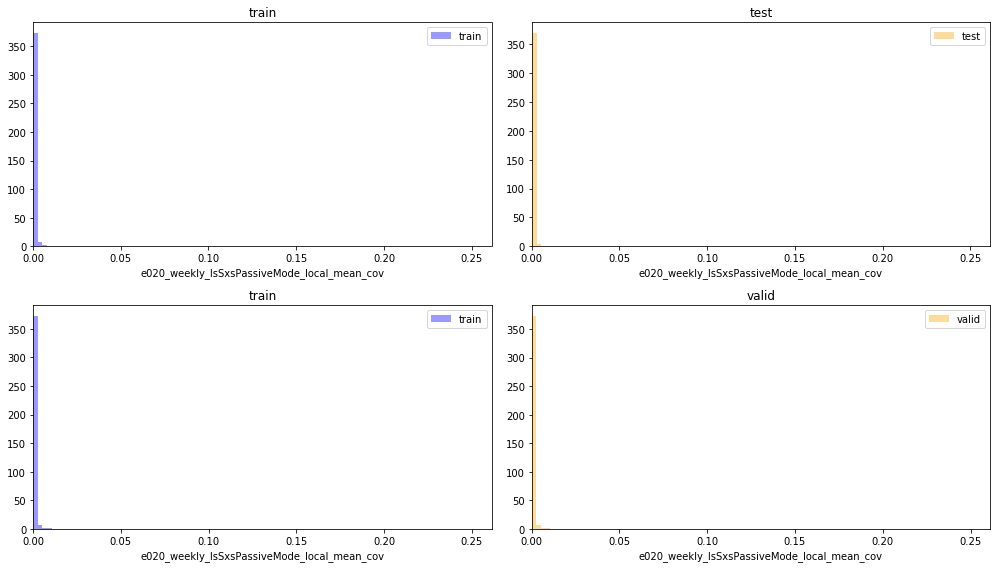

========== e020_daily_Census_ThresholdOptIn_local_mean_var ===========


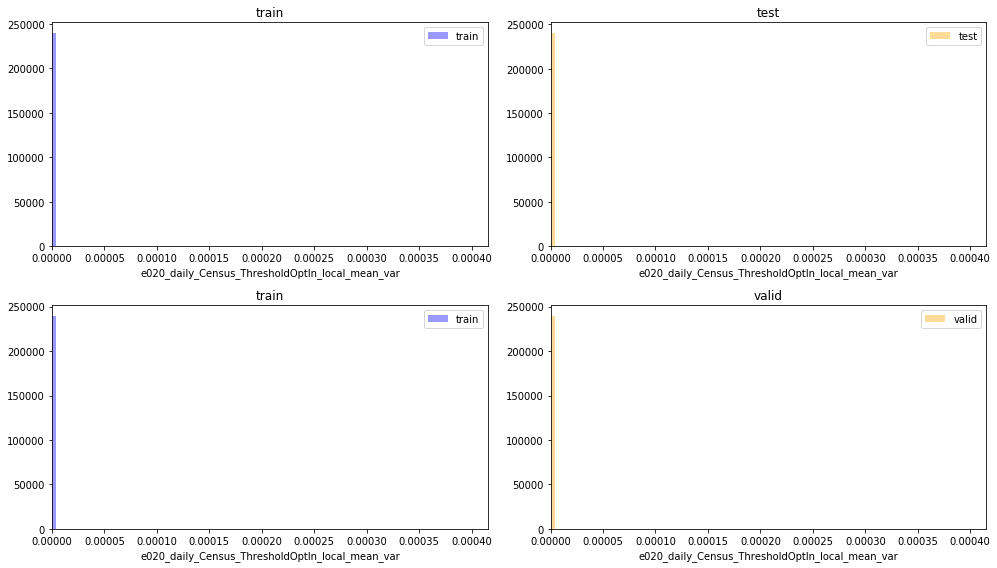

========== e020_weekly_Census_ThresholdOptIn_local_mean_var ===========


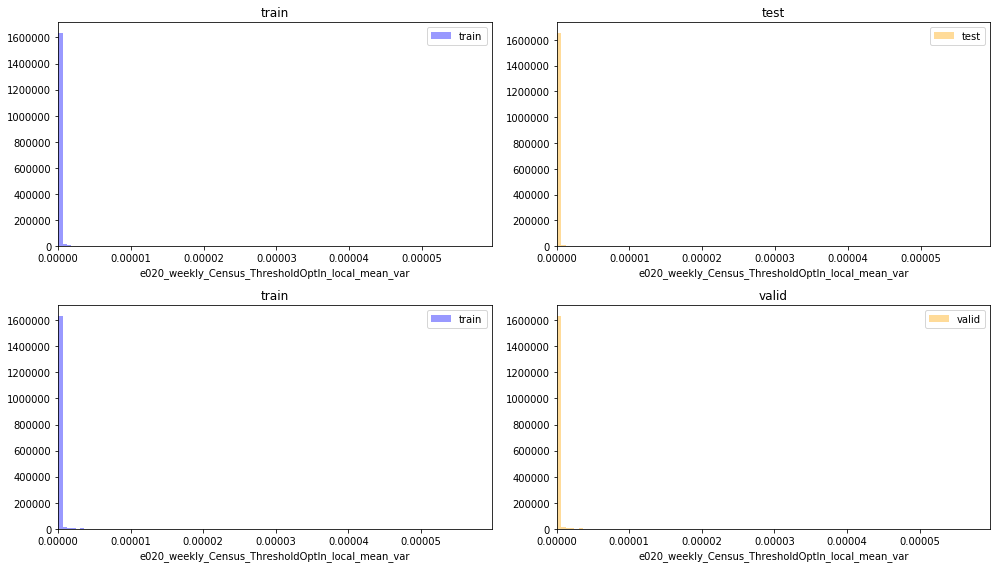

========== e020_monthly_Census_IsFlightsDisabled_local_mean_cov ===========


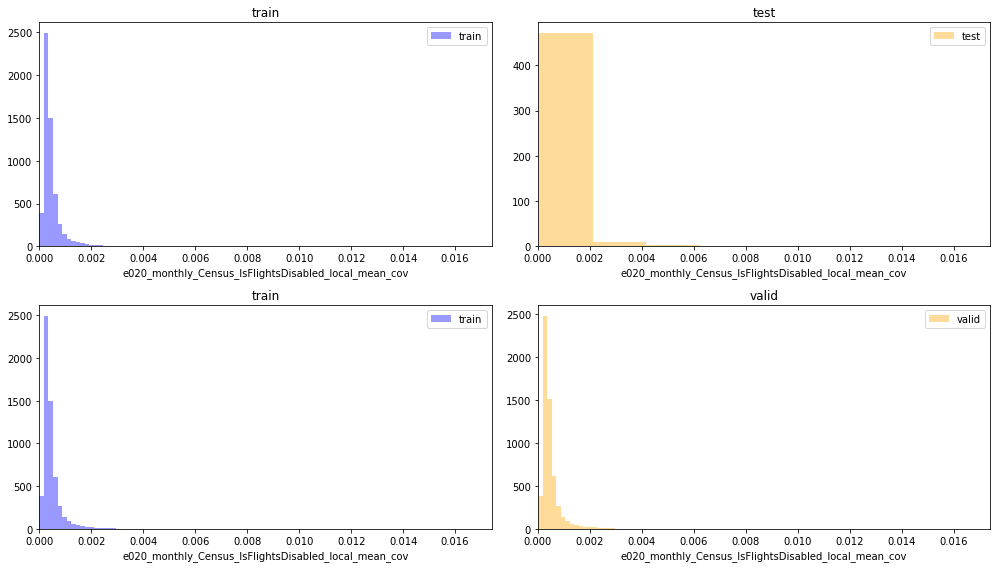

========== e020_six_hourly_Wdft_IsGamer_local_mean_cov ===========


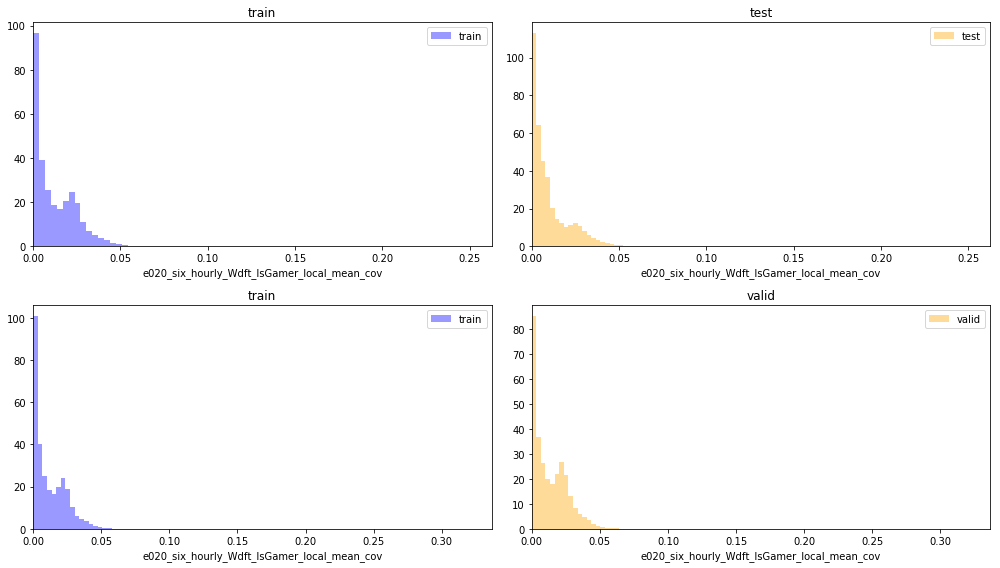

========== e020_daily_IsSxsPassiveMode_local_mean_mean ===========


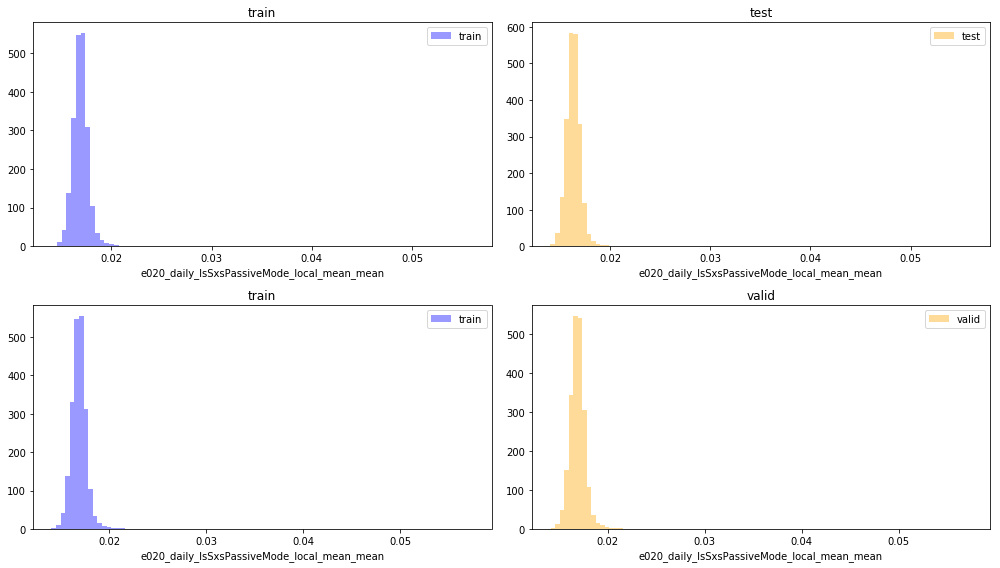

========== e020_weekly_IsBeta_local_mean_cov ===========


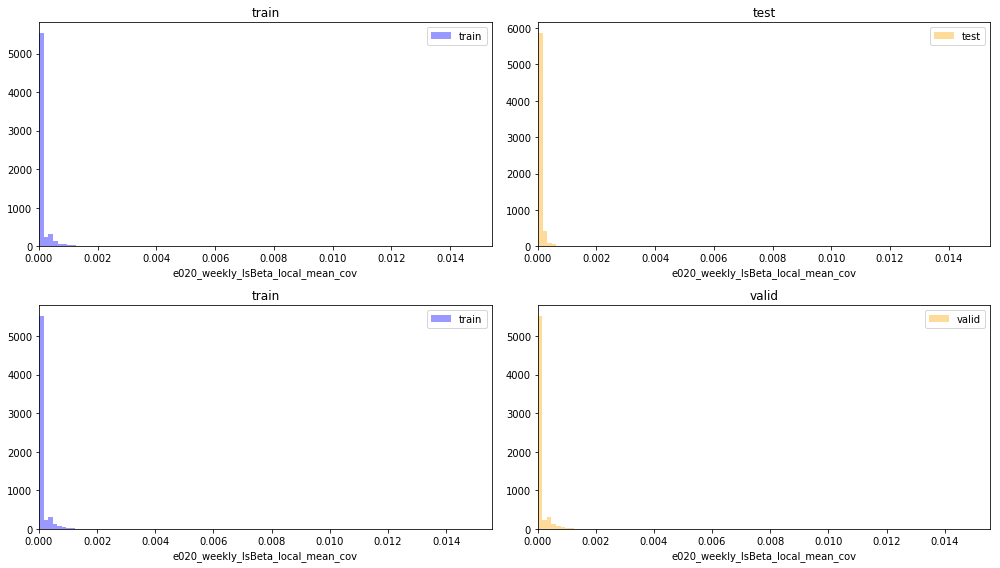

========== e020_six_hourly_Census_ThresholdOptIn_local_mean_cov ===========


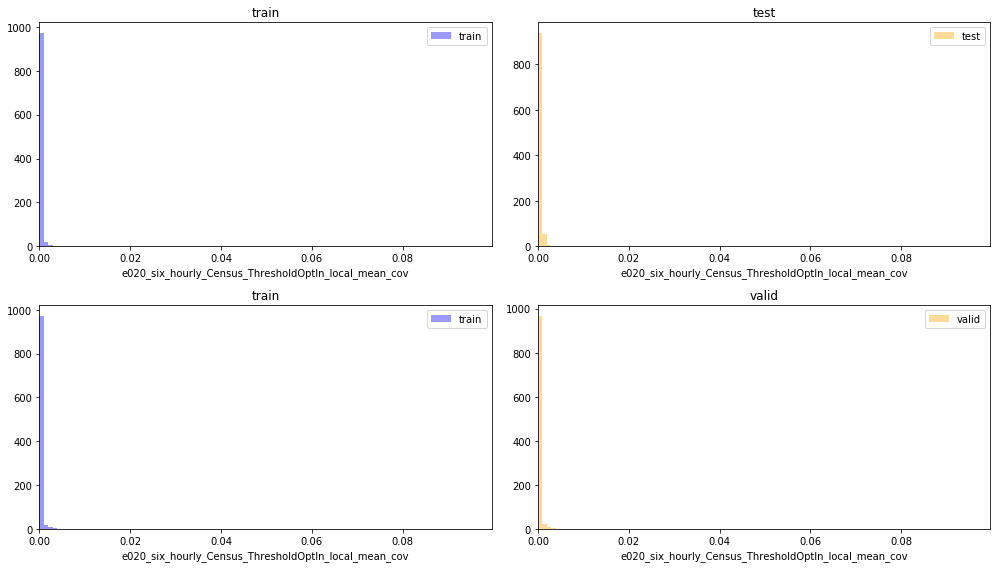

========== e020_monthly_Census_IsSecureBootEnabled_local_mean_cov ===========


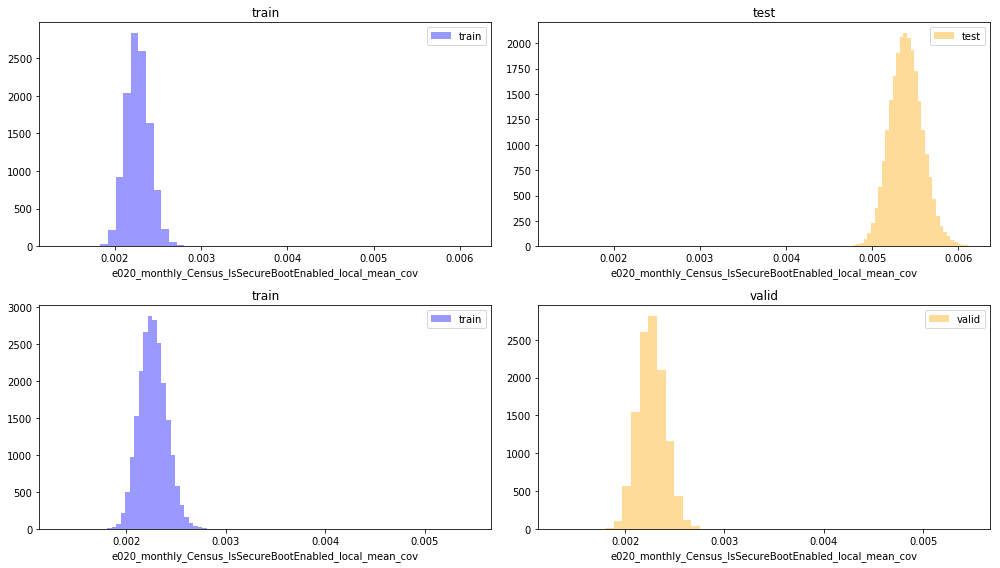

========== e020_monthly_Census_IsVirtualDevice_local_mean_var ===========


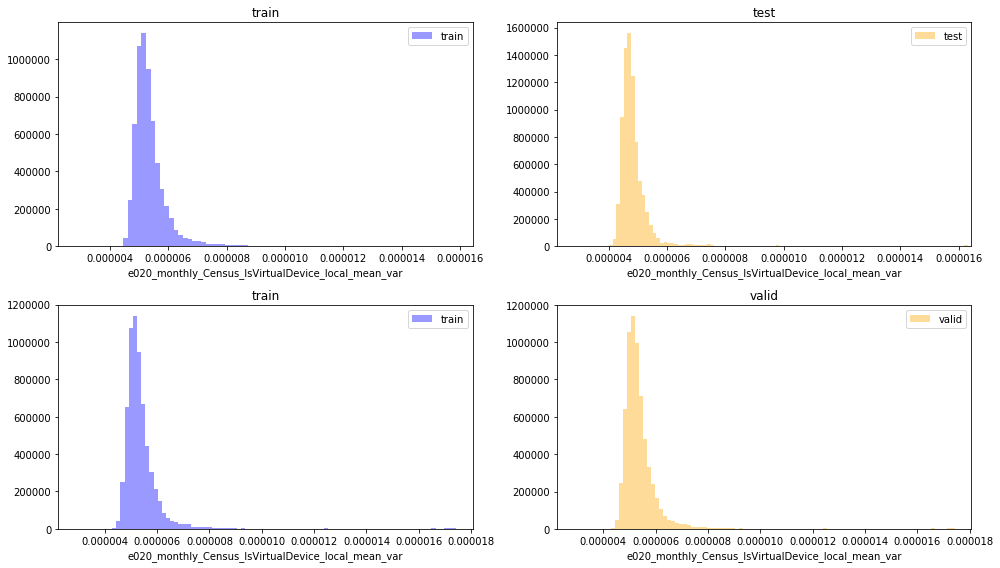

========== e020_daily_HasDetections_local_mean_var ===========


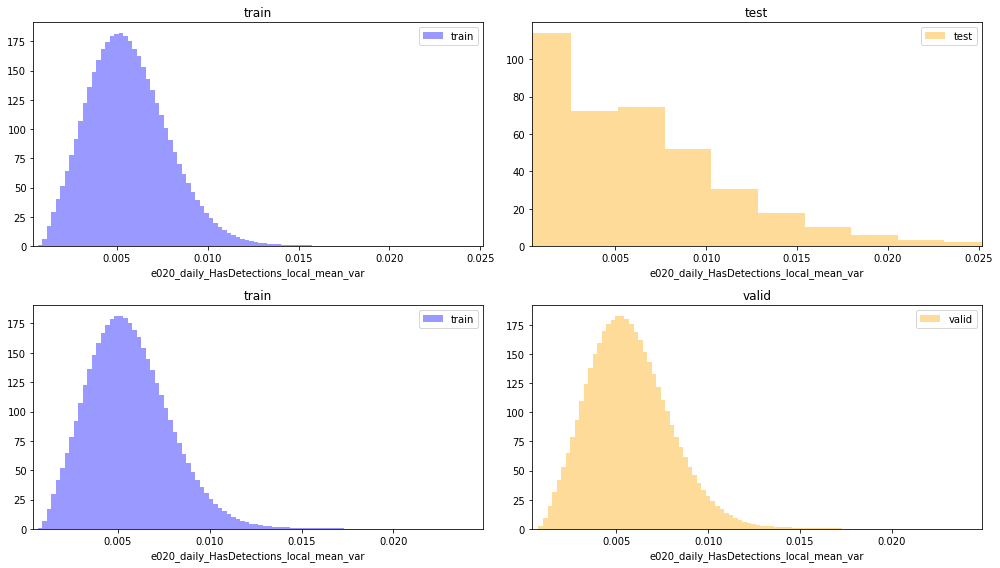

========== e020_monthly_AutoSampleOptIn_local_mean_var ===========


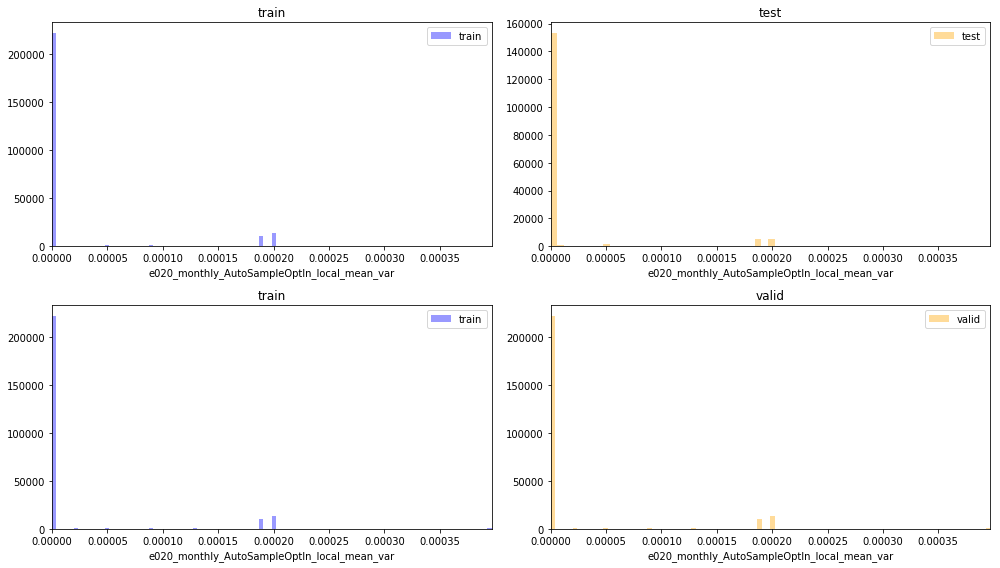

========== e020_six_hourly_IsSxsPassiveMode_local_mean_mean ===========


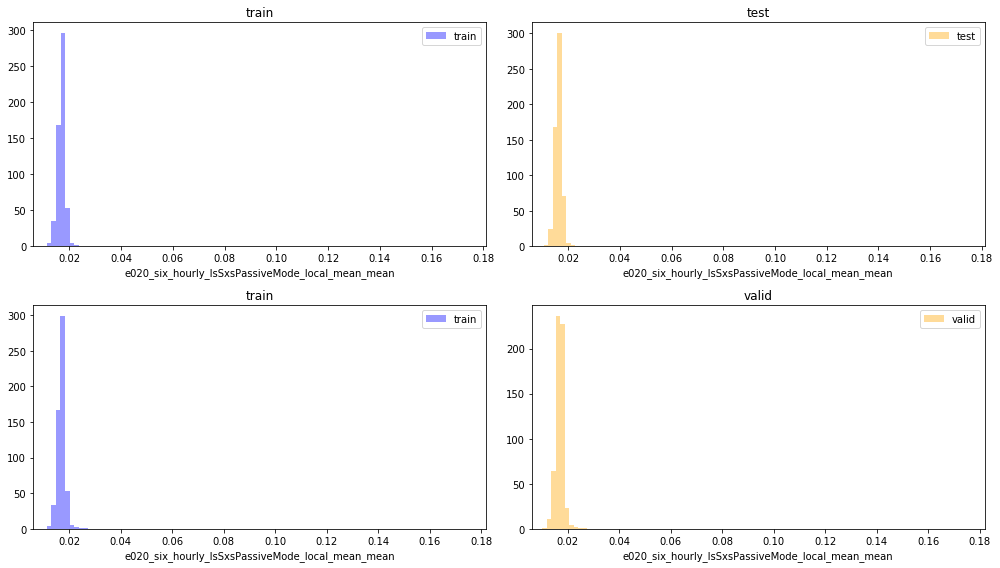

========== e020_monthly_Census_IsVirtualDevice_local_mean_cov ===========


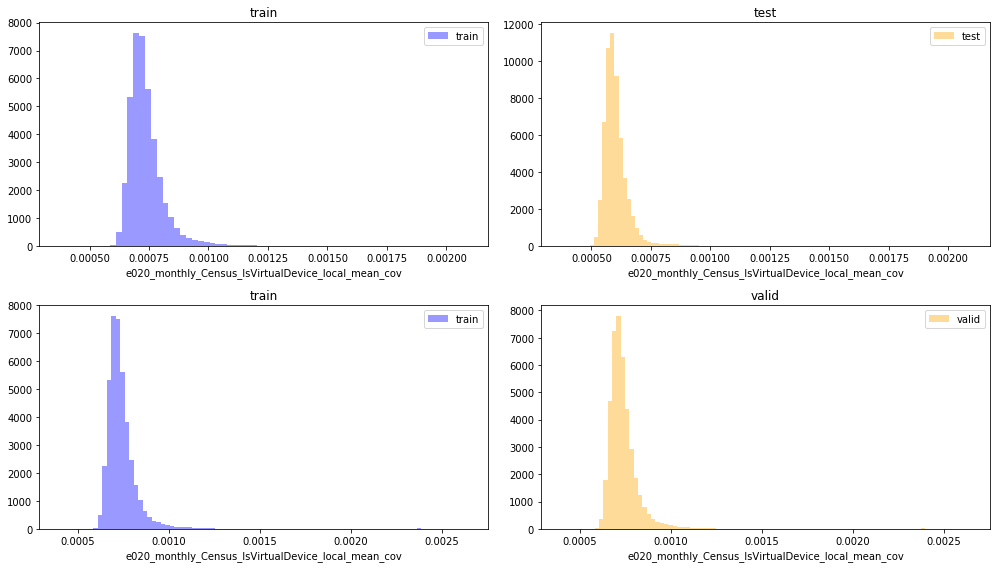

========== e020_six_hourly_IsProtected_local_mean_cov ===========


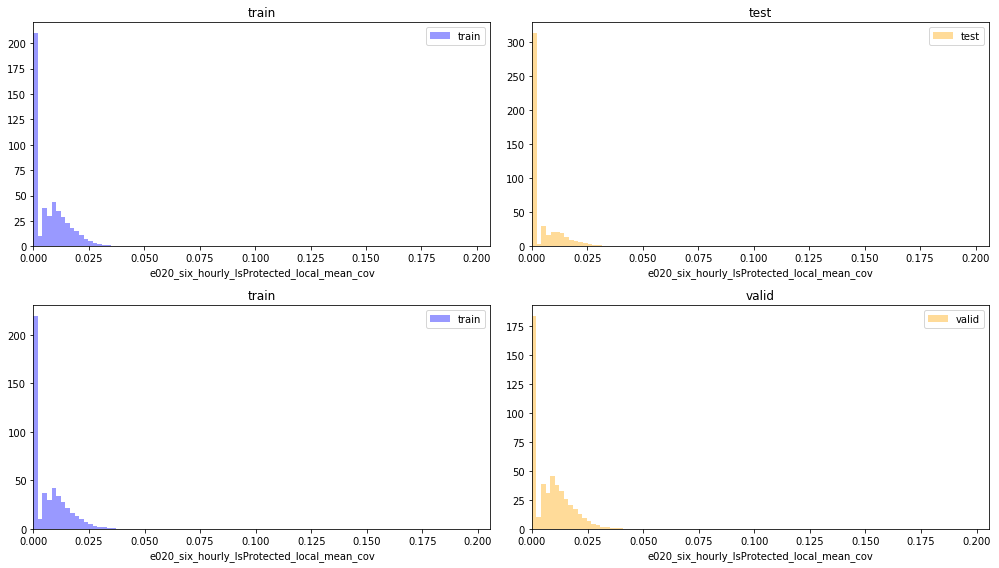

========== e020_weekly_Census_IsVirtualDevice_local_mean_cov ===========


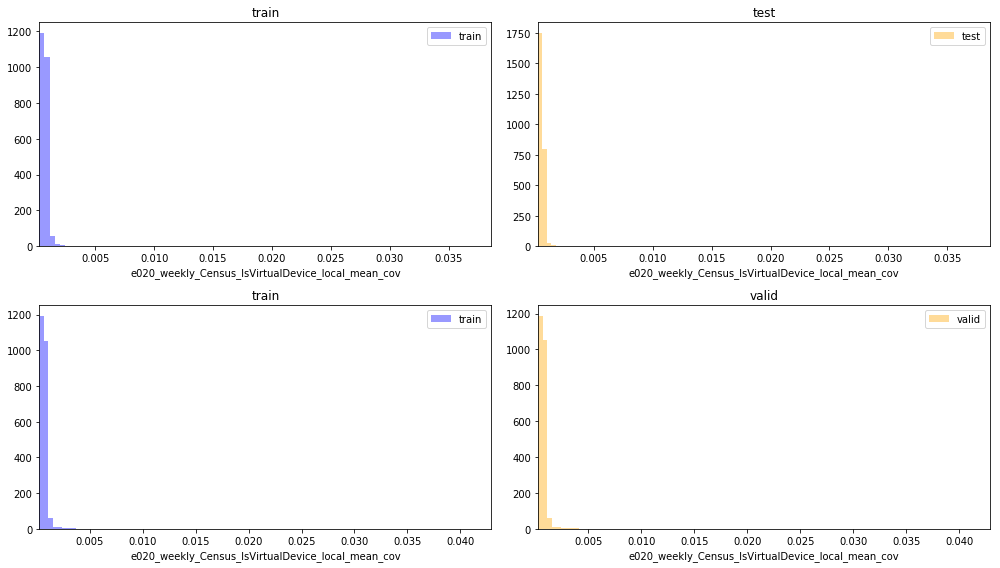

========== e020_weekly_Firewall_local_mean_mean ===========


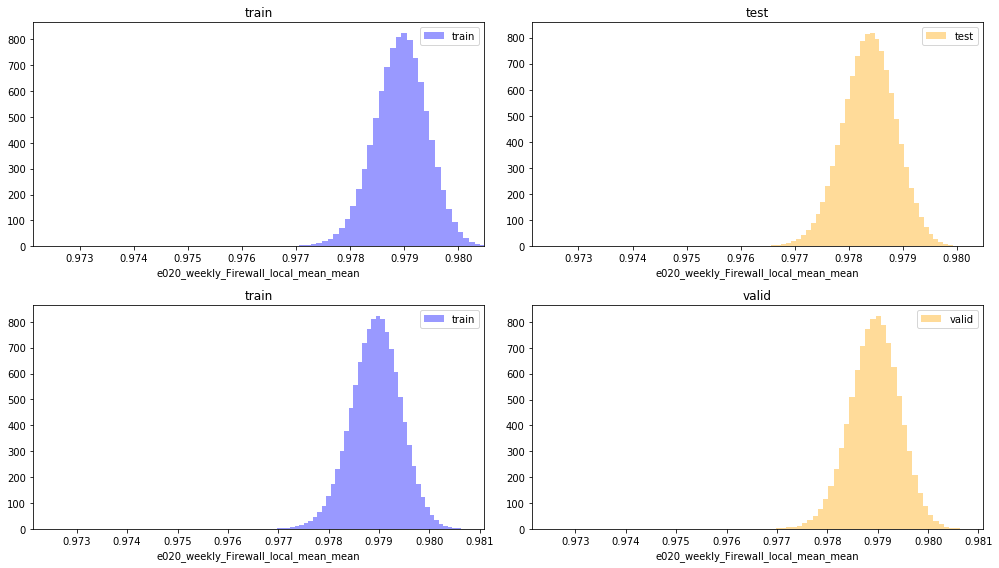

========== e020_daily_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_mean ===========


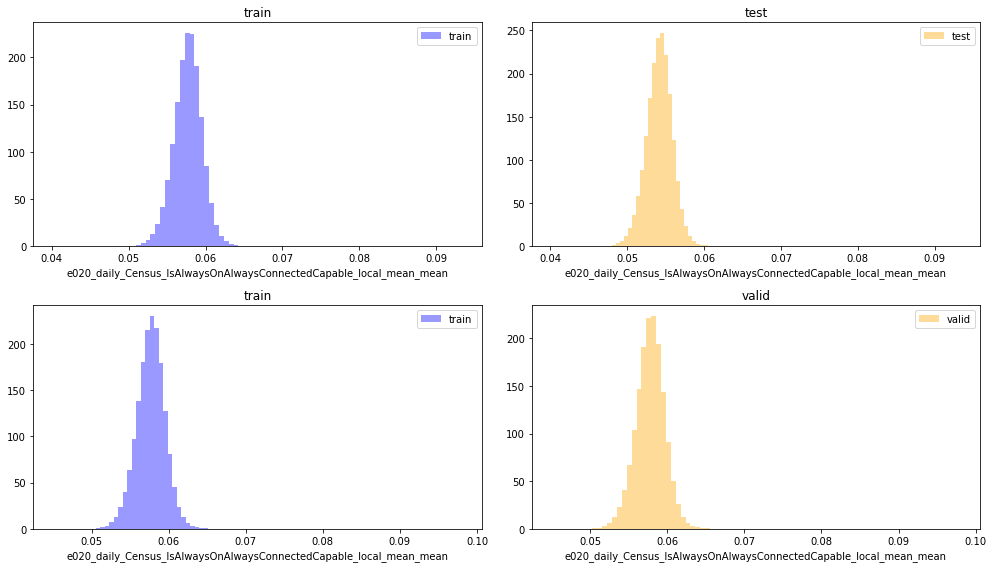

========== e020_daily_IsProtected_local_mean_var ===========


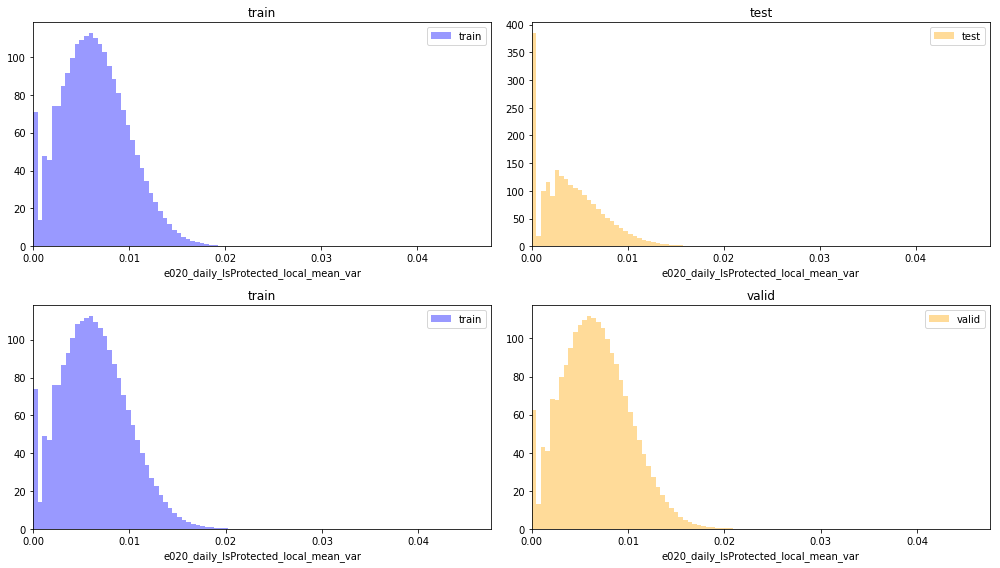

========== e020_daily_Census_IsTouchEnabled_local_mean_cov ===========


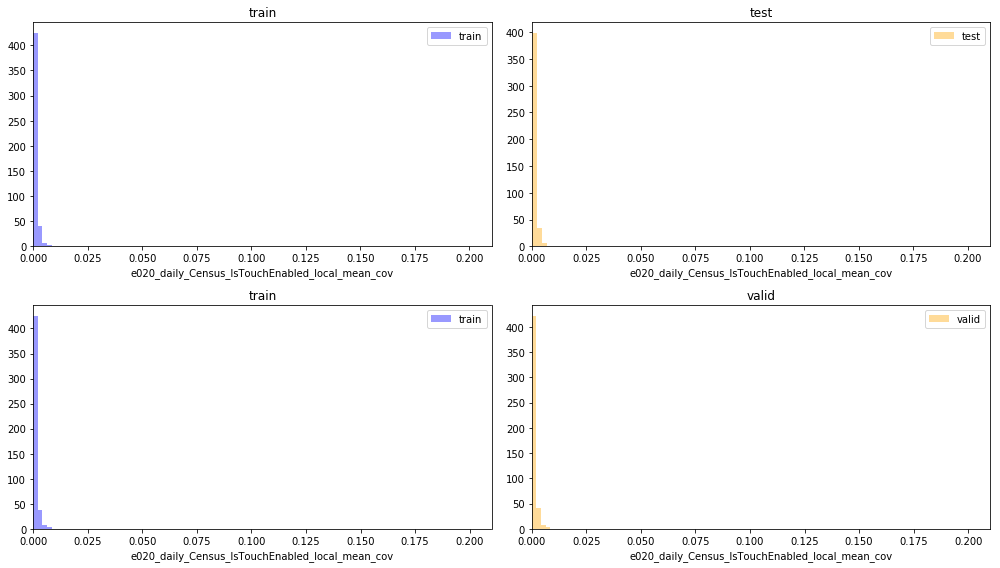

========== e020_daily_Census_IsPortableOperatingSystem_local_mean_var ===========


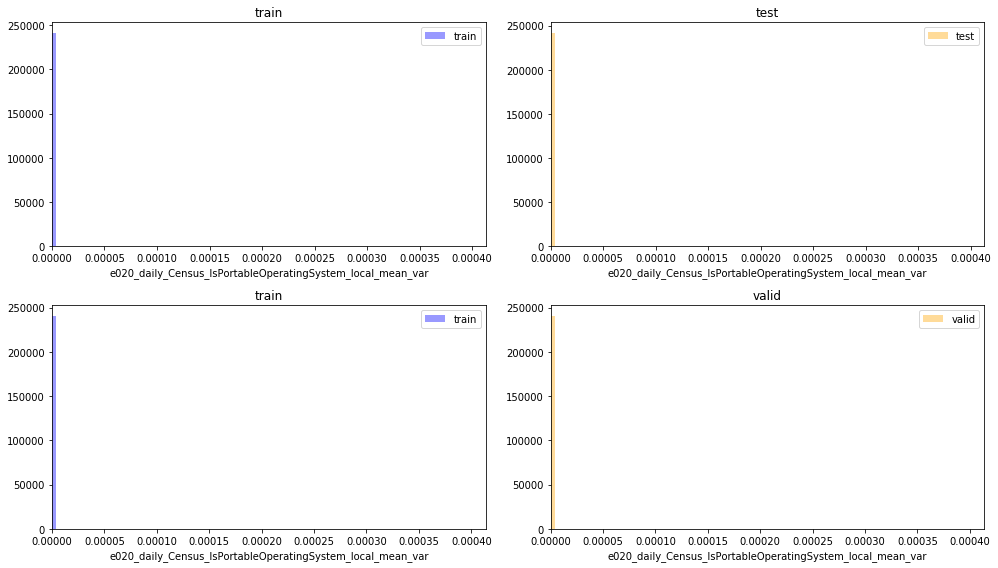

========== e020_six_hourly_AutoSampleOptIn_local_mean_var ===========


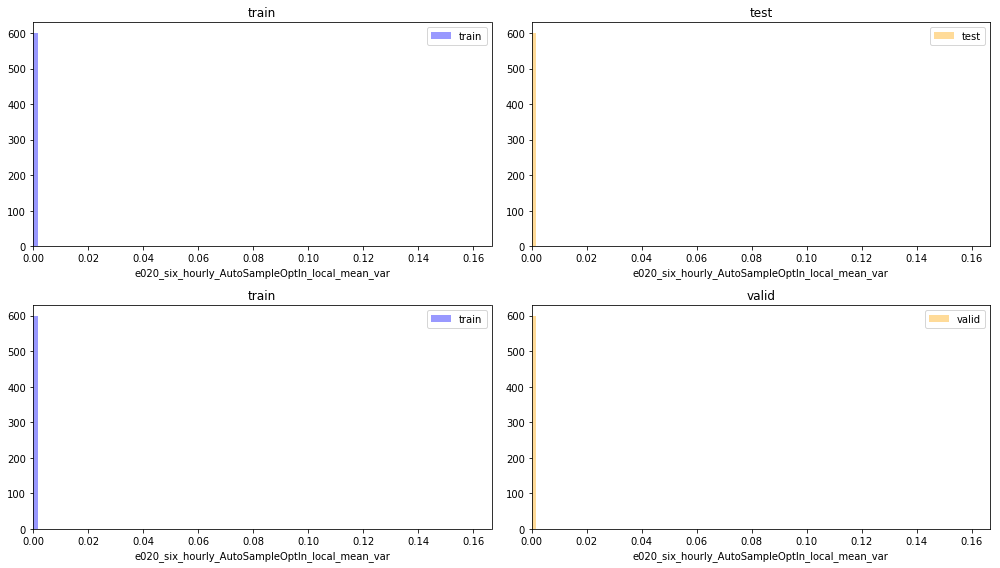

========== e020_daily_Census_IsWIMBootEnabled_local_mean_var ===========


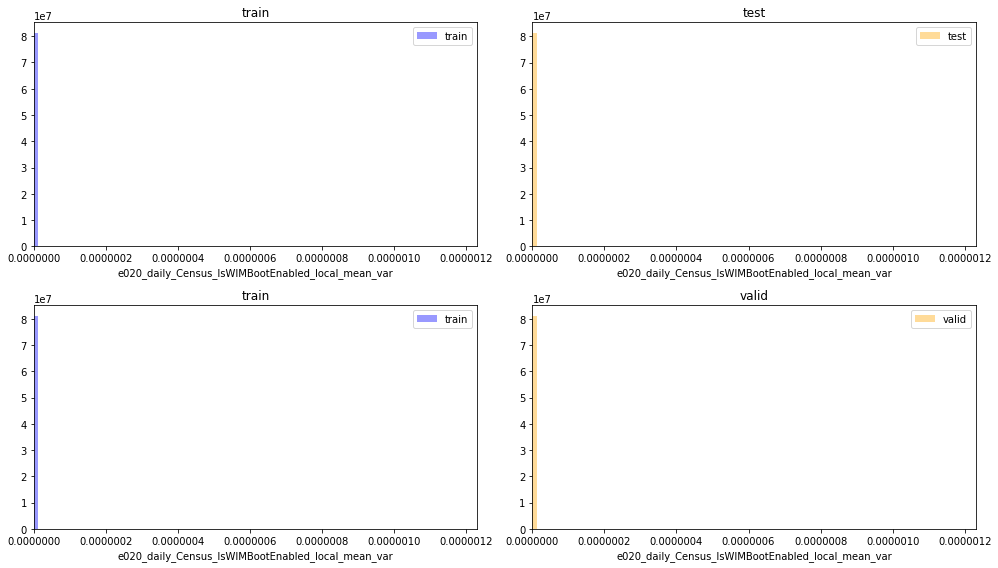

========== e020_monthly_Census_IsTouchEnabled_local_mean_cov ===========


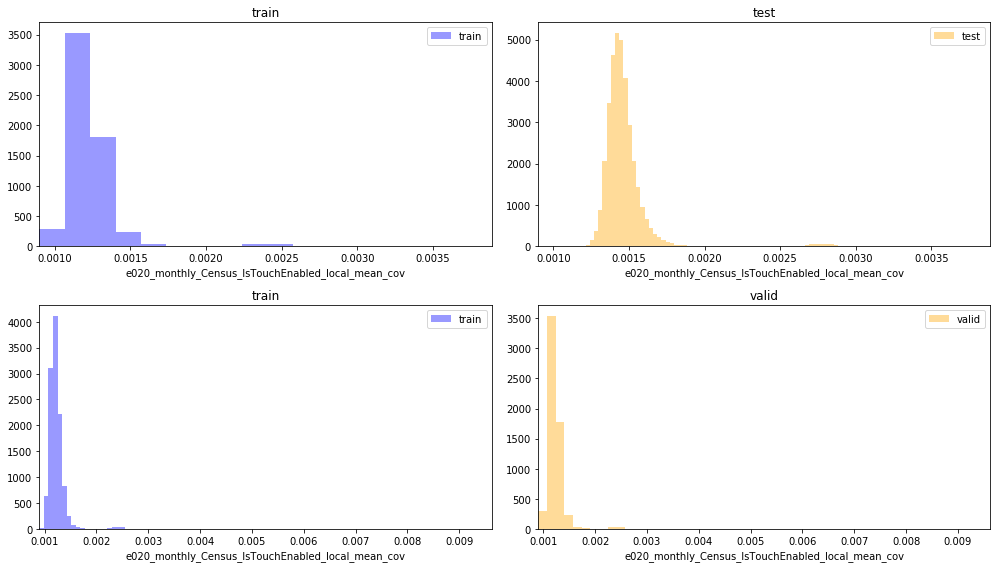

========== e020_weekly_Firewall_local_mean_cov ===========


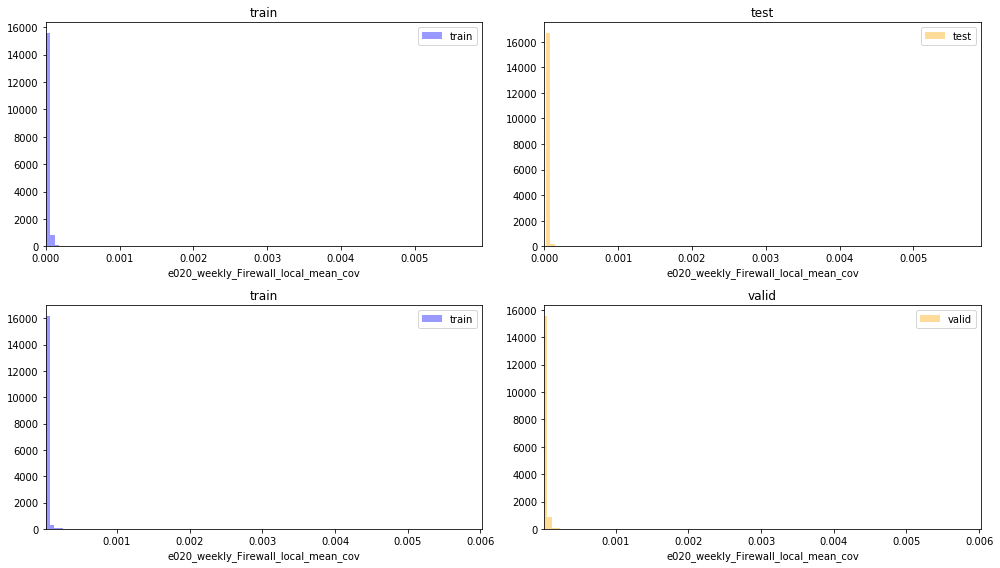

========== e020_six_hourly_Census_IsTouchEnabled_local_mean_mean ===========


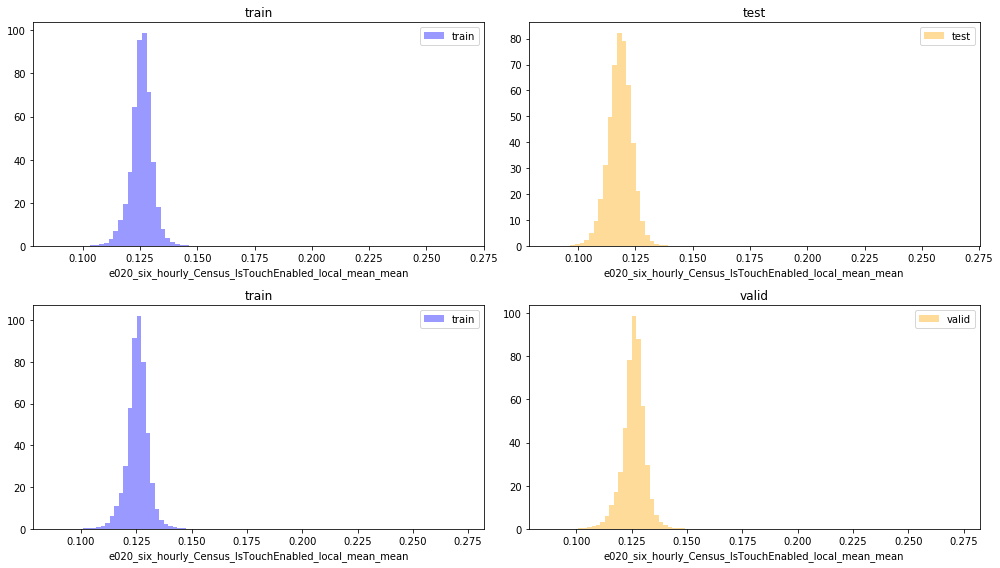

========== e020_six_hourly_Census_IsFlightsDisabled_local_mean_mean ===========


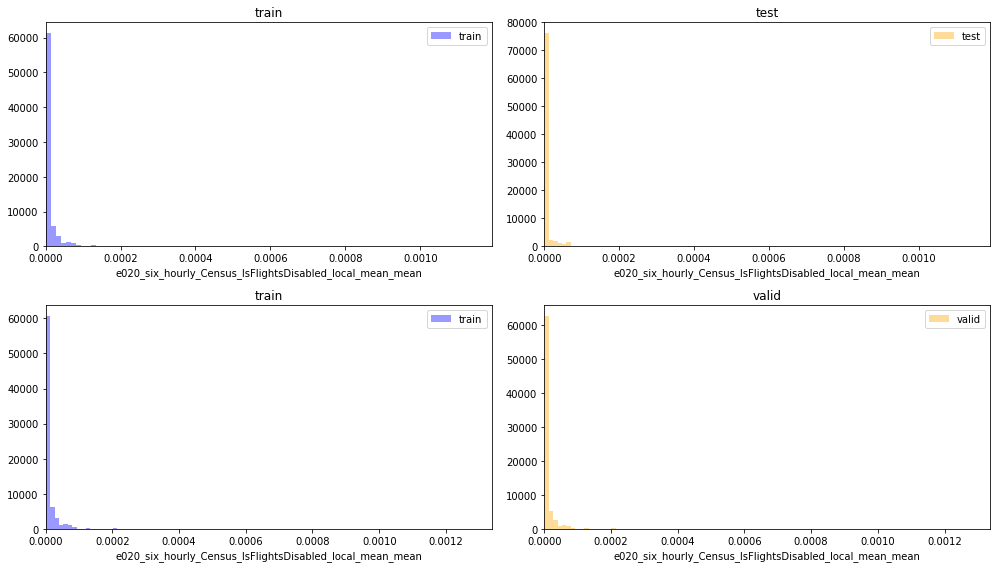

========== e020_weekly_HasDetections_local_mean_mean ===========


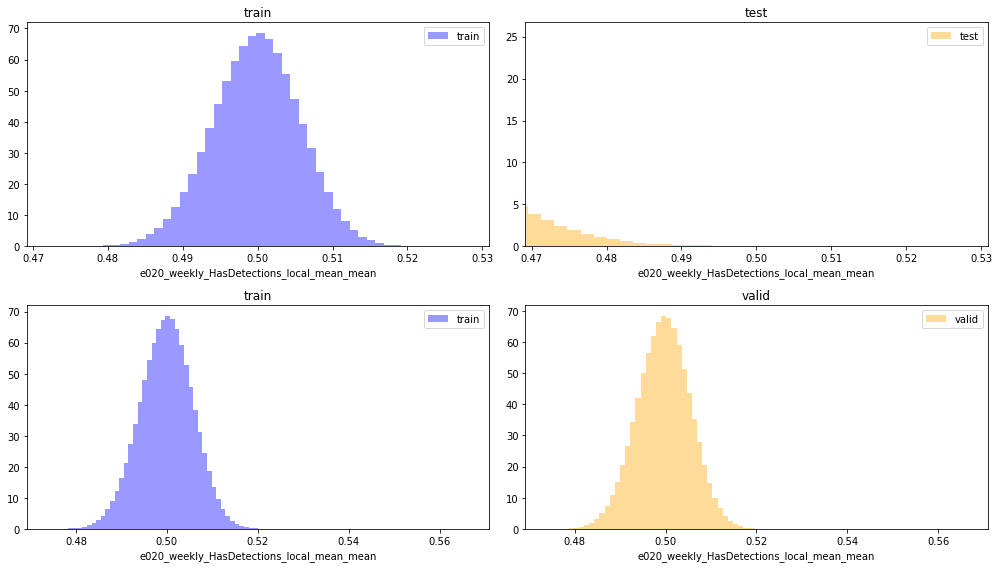

========== e020_six_hourly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var ===========


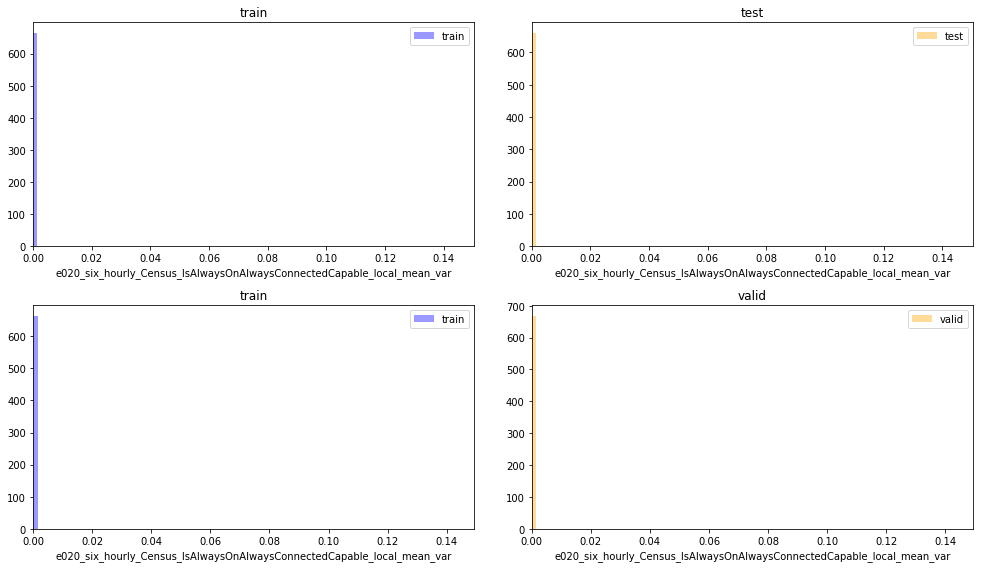

========== e020_daily_AutoSampleOptIn_local_mean_cov ===========


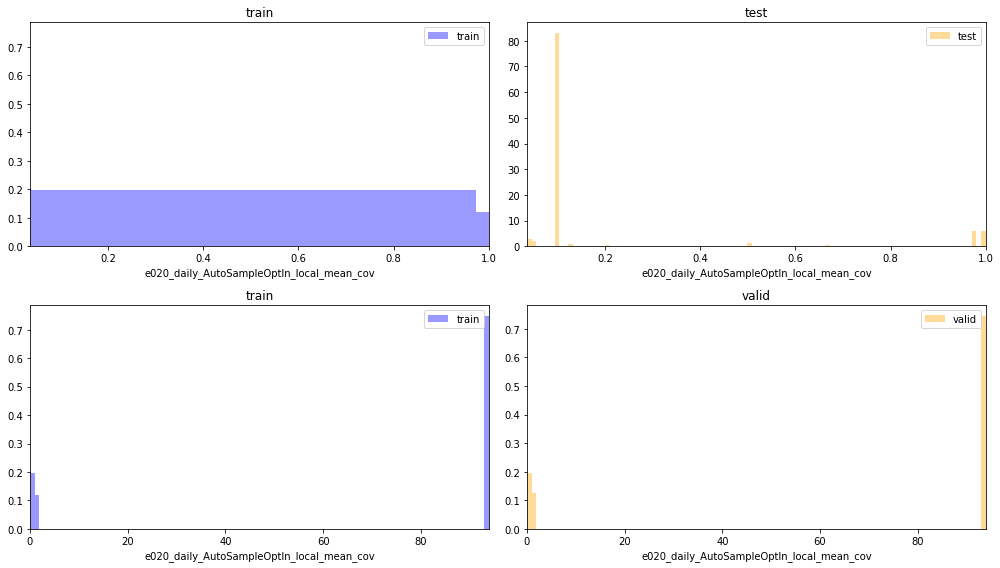

========== e020_six_hourly_Census_IsWIMBootEnabled_local_mean_var ===========


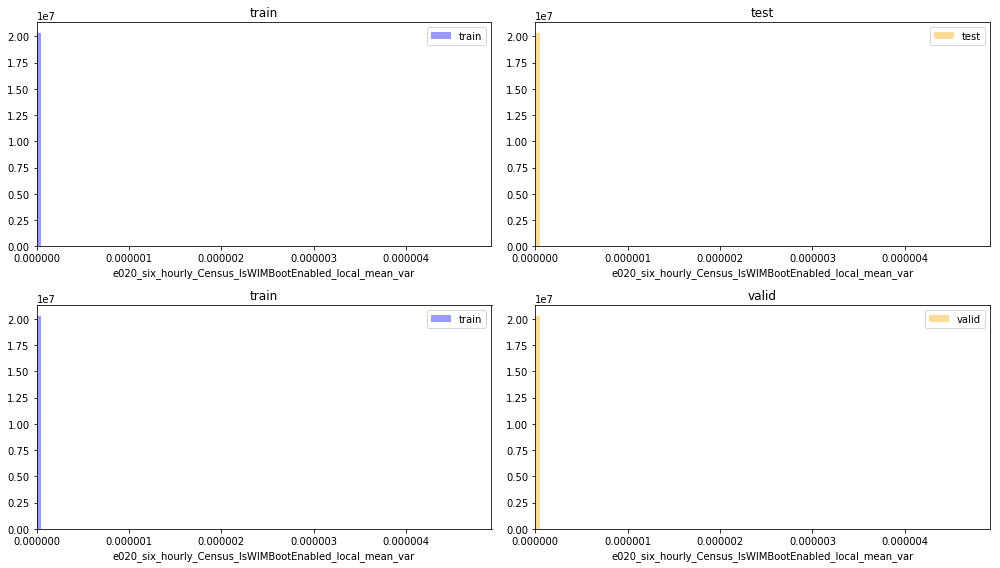

========== e020_daily_Census_IsFlightsDisabled_local_mean_cov ===========


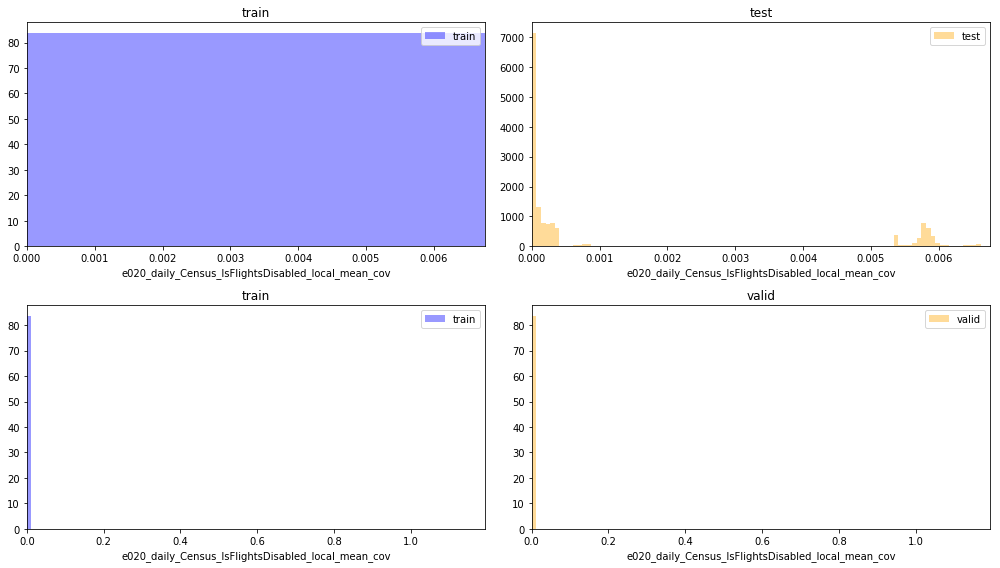

========== e020_daily_AutoSampleOptIn_local_mean_var ===========


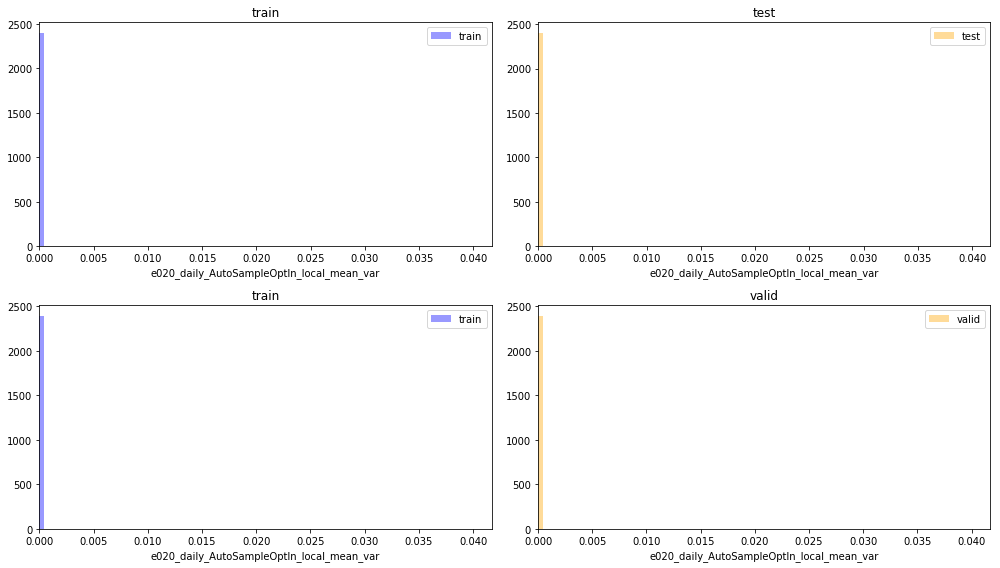

========== e020_weekly_IsBeta_local_mean_mean ===========


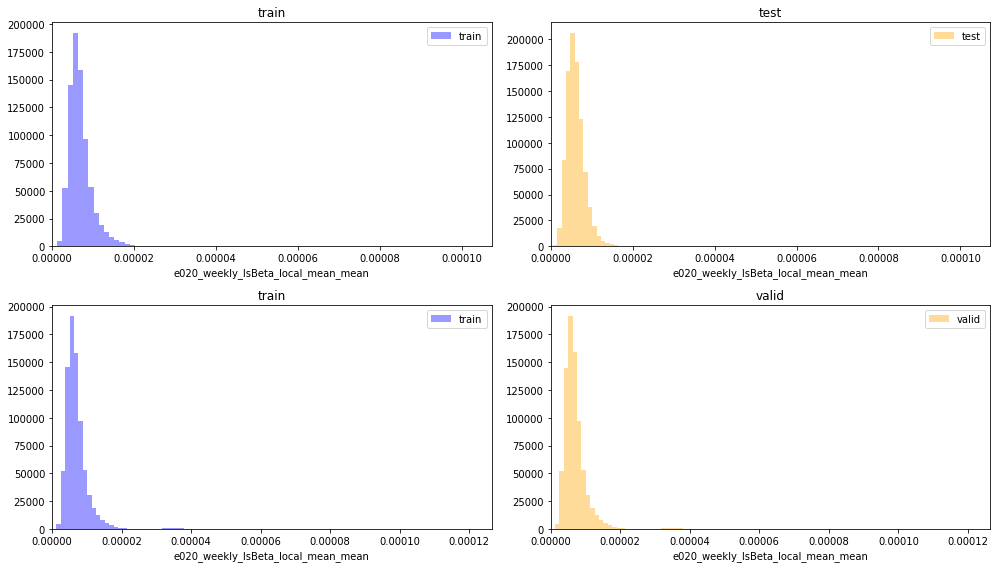

========== e020_weekly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_var ===========


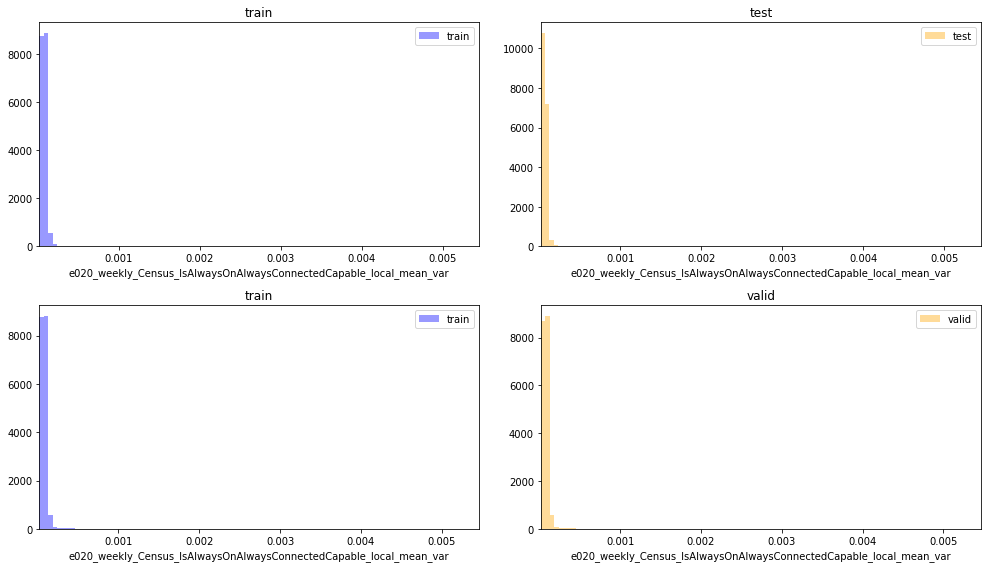

========== e020_monthly_Census_IsWIMBootEnabled_local_mean_cov ===========


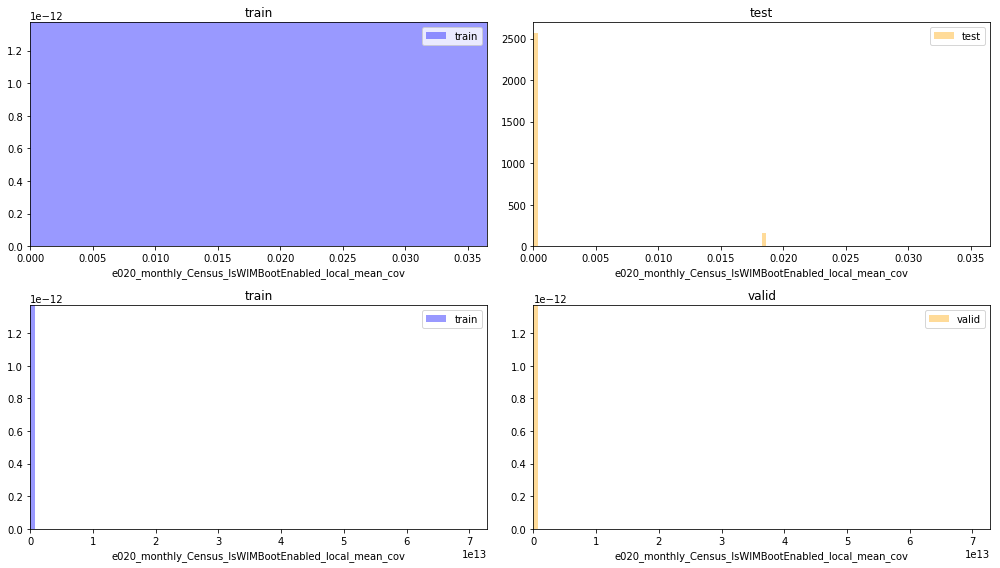

========== e020_monthly_Census_ThresholdOptIn_local_mean_cov ===========


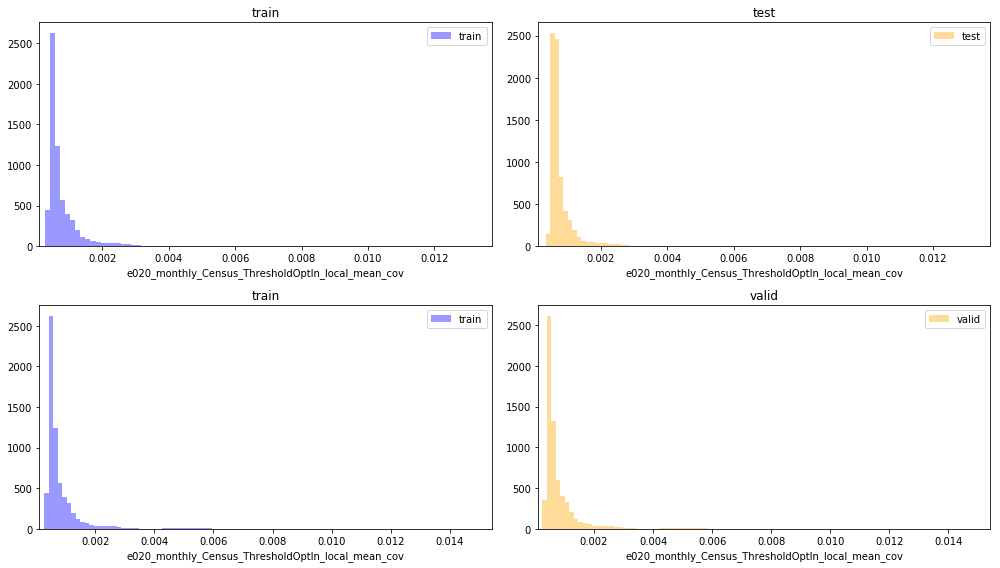

========== e020_daily_Census_HasOpticalDiskDrive_local_mean_cov ===========


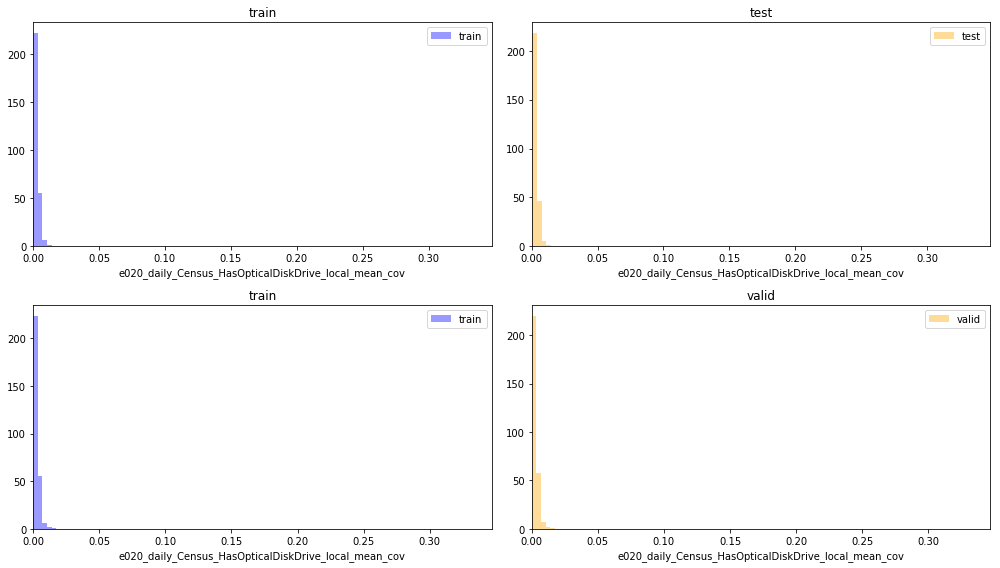

========== e020_six_hourly_Census_IsPortableOperatingSystem_local_mean_var ===========


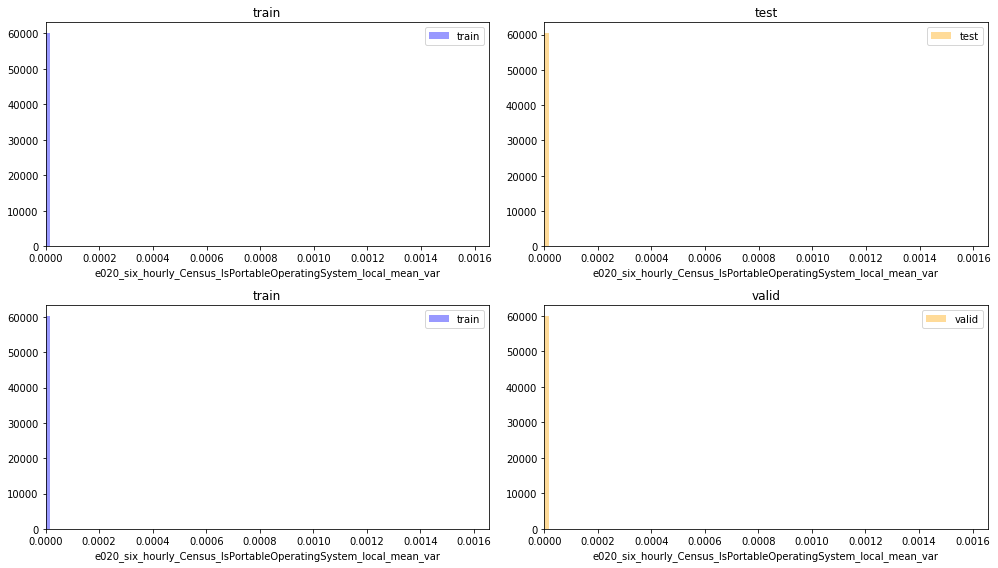

========== e020_monthly_IsBeta_local_mean_cov ===========


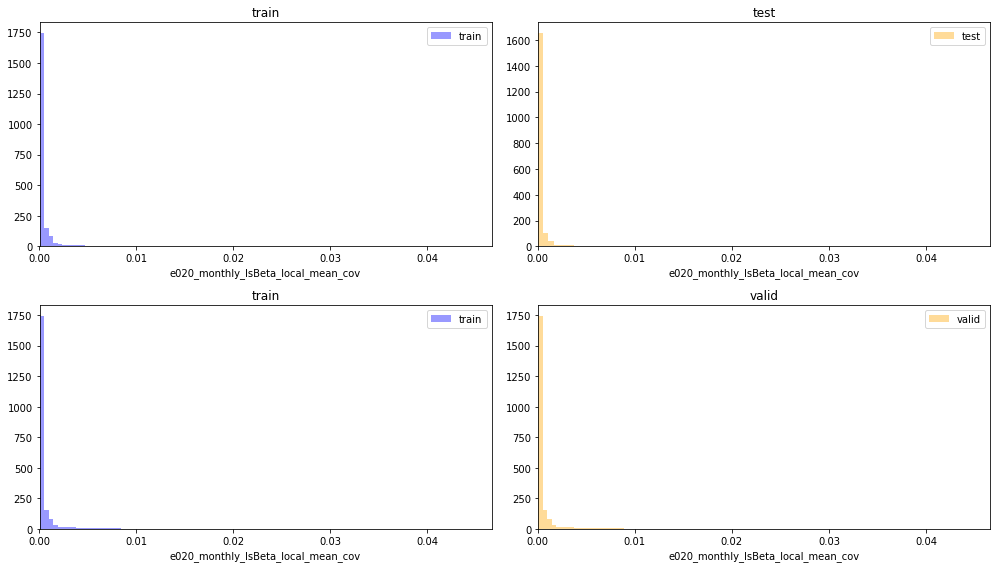

========== e020_daily_Census_IsPenCapable_local_mean_cov ===========


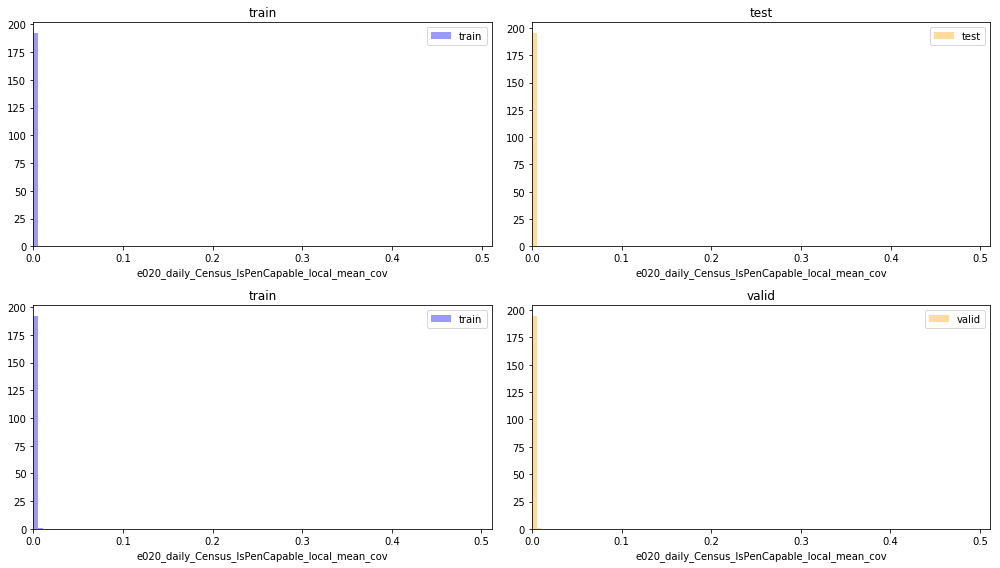

========== e020_weekly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_mean ===========


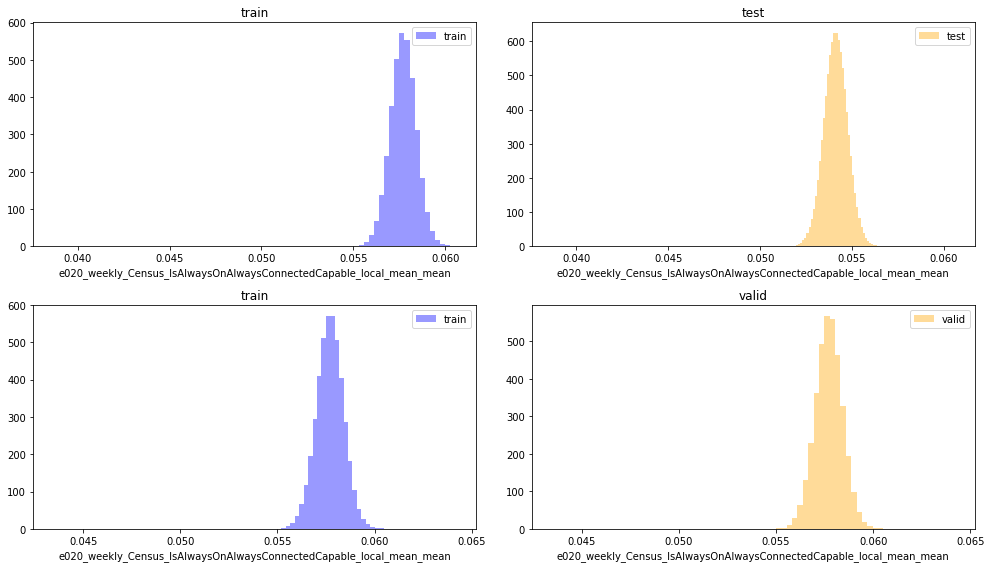

========== e020_monthly_Wdft_IsGamer_local_mean_cov ===========


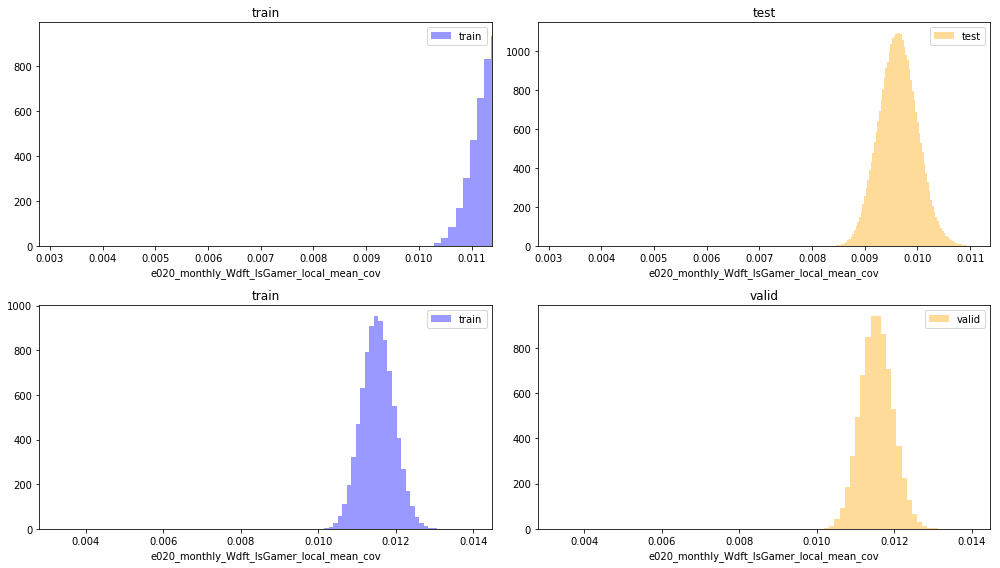

========== e020_six_hourly_Wdft_IsGamer_local_mean_var ===========


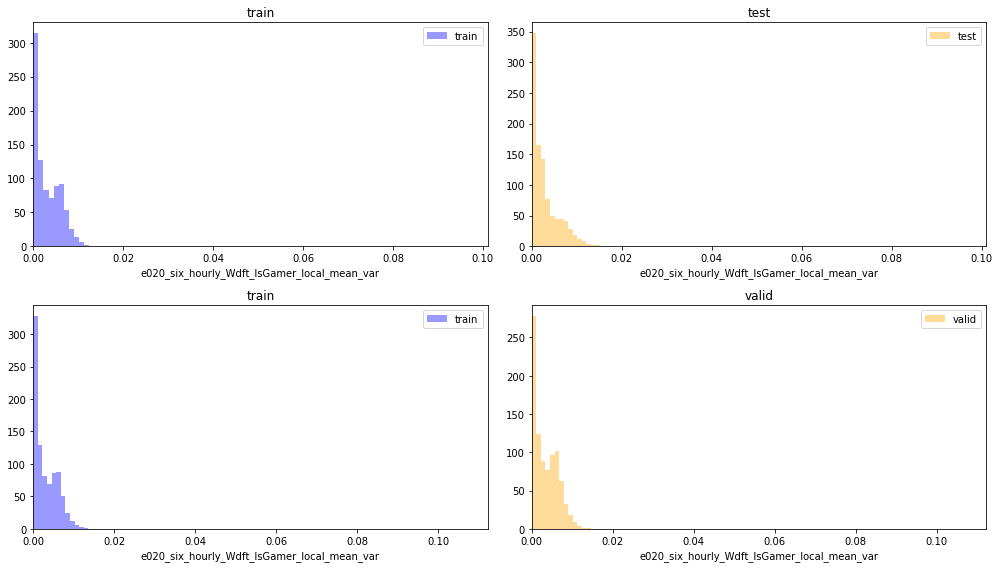

========== e020_weekly_Census_IsFlightingInternal_local_mean_var ===========


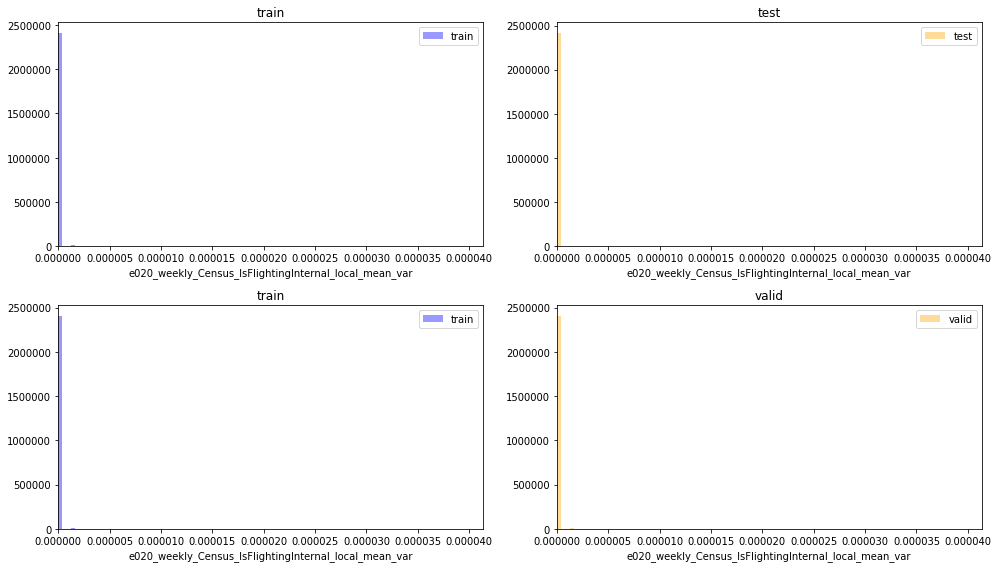

========== e020_monthly_Wdft_IsGamer_local_mean_var ===========


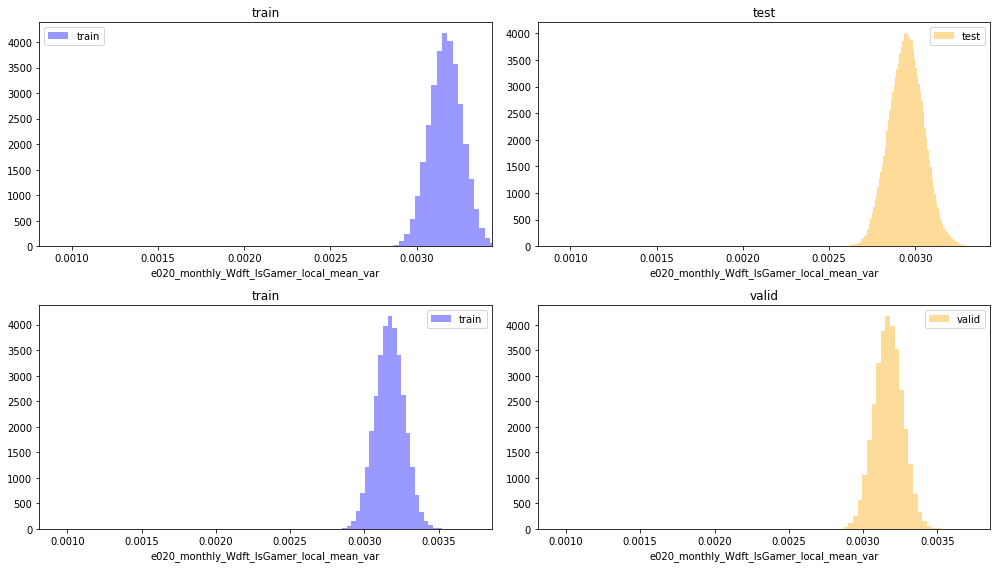

========== e020_six_hourly_HasTpm_local_mean_cov ===========


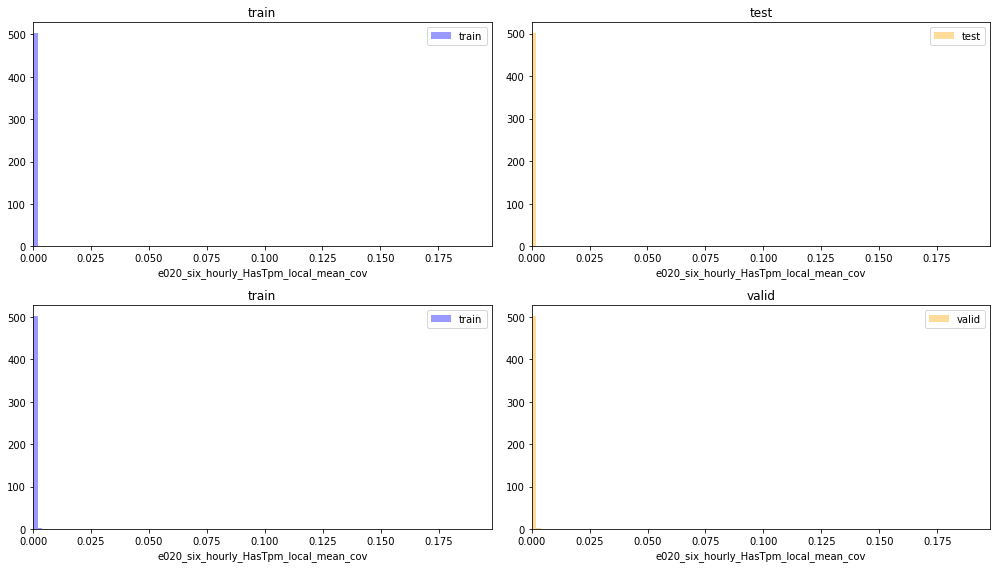

========== e020_six_hourly_IsProtected_local_mean_var ===========


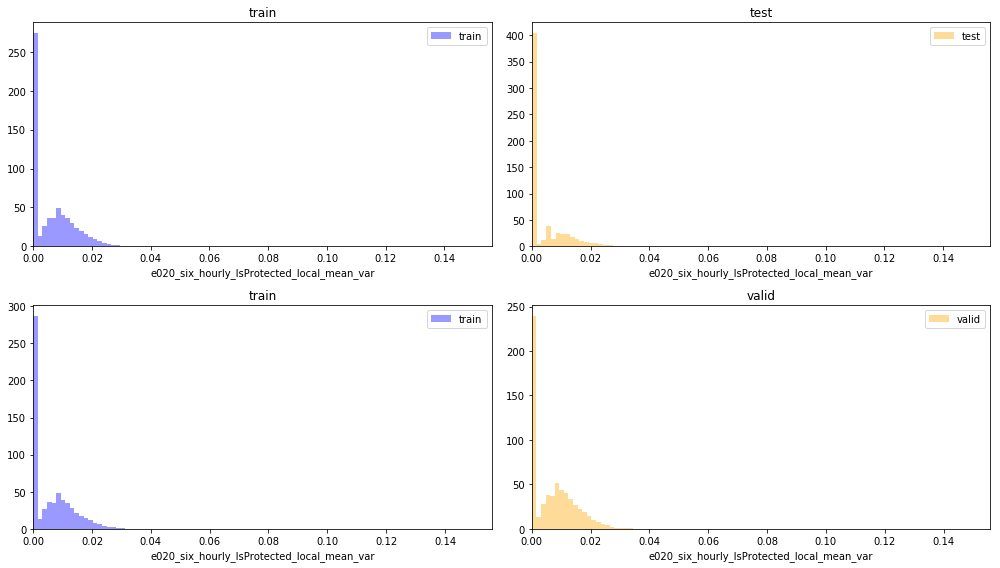

========== e020_six_hourly_AutoSampleOptIn_local_mean_mean ===========


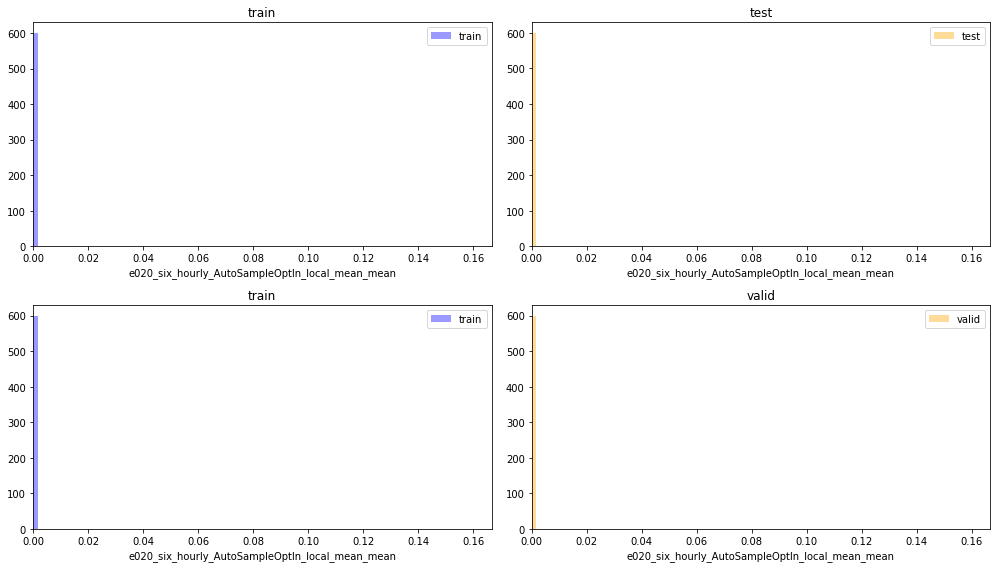

========== e020_monthly_Census_IsPortableOperatingSystem_local_mean_cov ===========


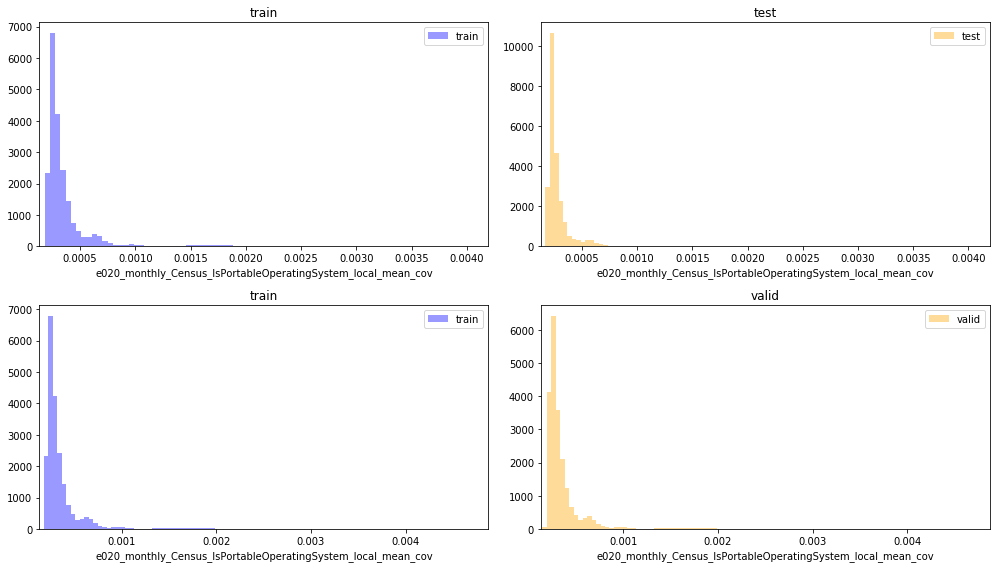

========== e020_six_hourly_Census_IsFlightsDisabled_local_mean_var ===========


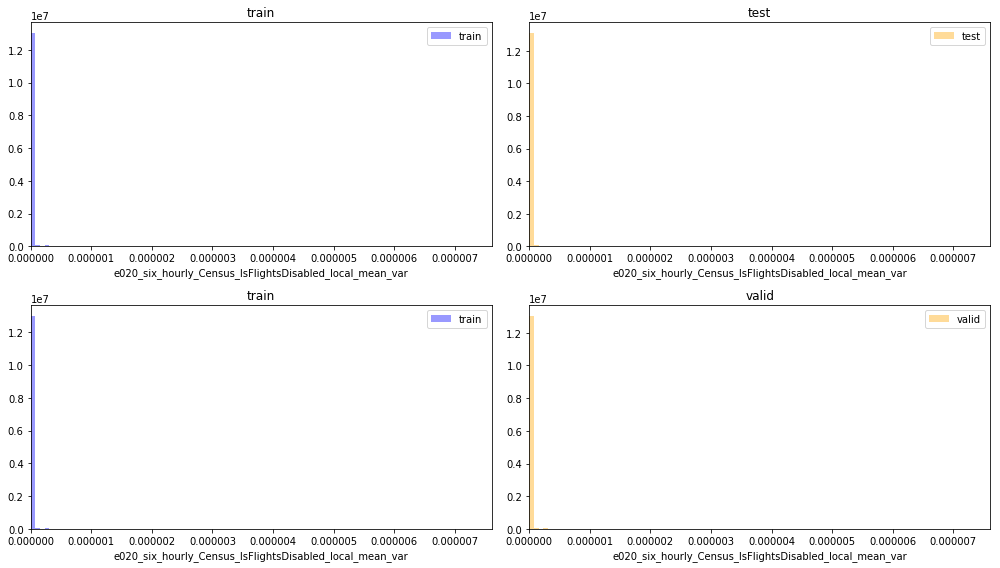

========== e020_six_hourly_Census_IsSecureBootEnabled_local_mean_cov ===========


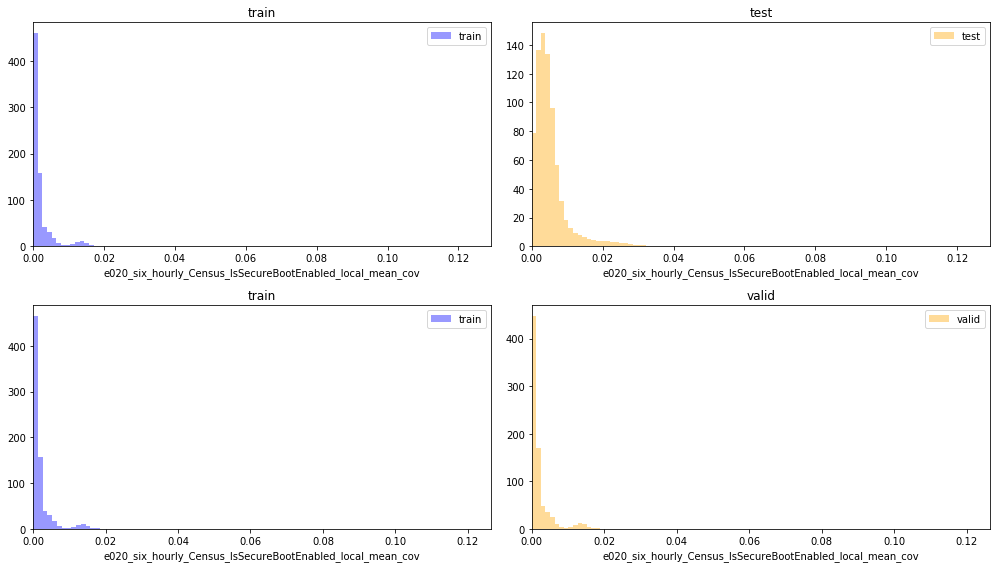

========== e020_weekly_Census_IsVirtualDevice_local_mean_mean ===========


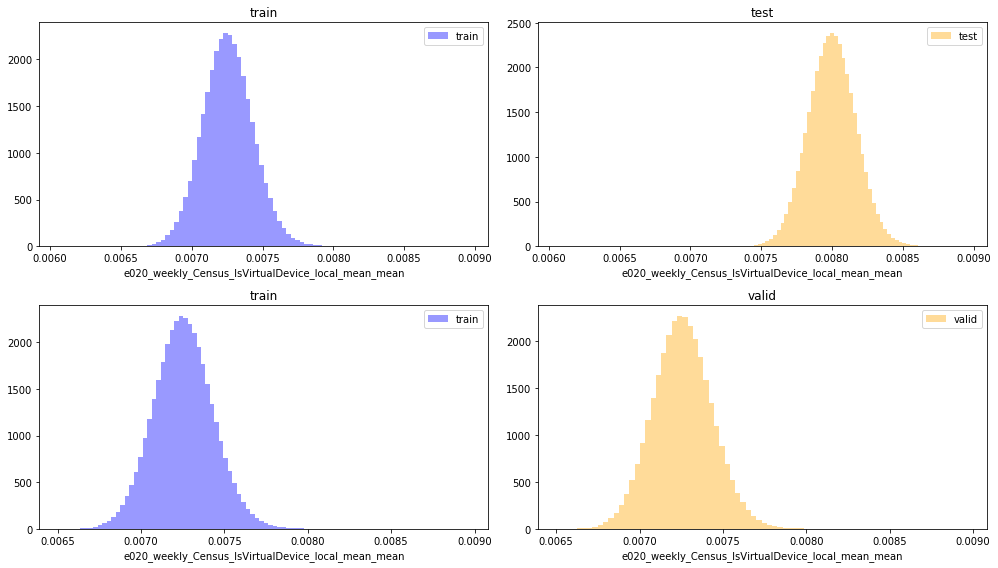

========== e020_six_hourly_Firewall_local_mean_cov ===========


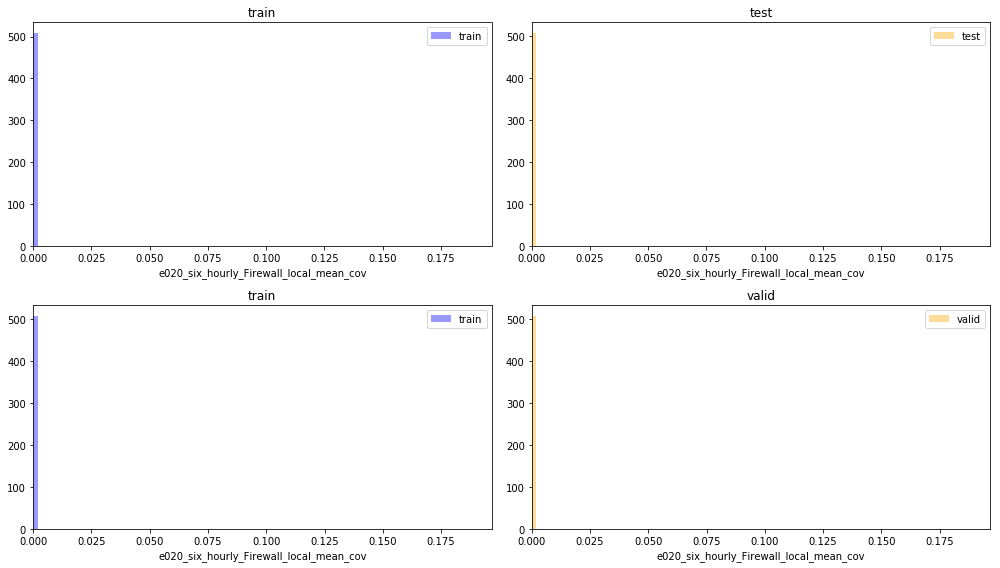

========== e020_six_hourly_IsBeta_local_mean_cov ===========


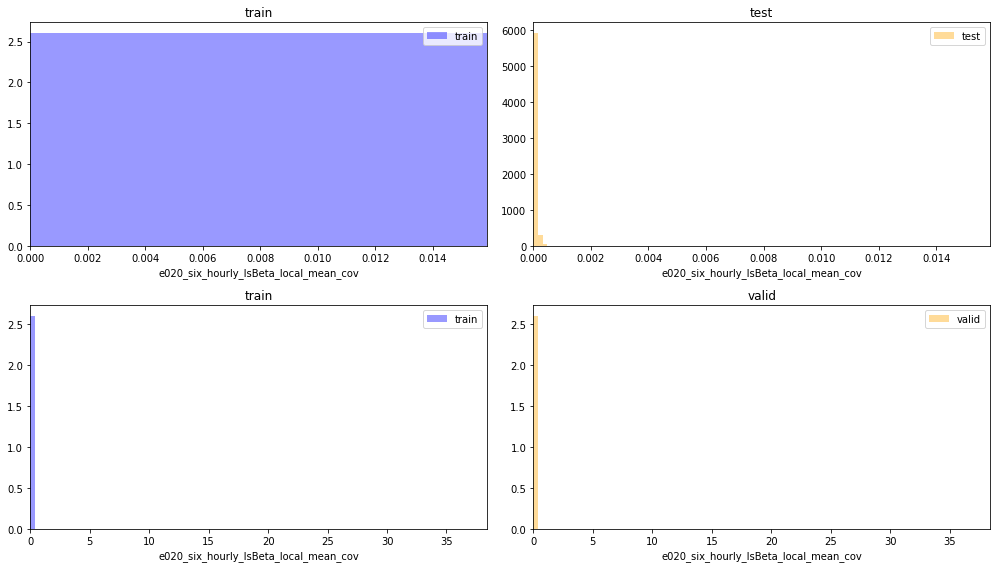

========== e020_weekly_IsProtected_local_mean_cov ===========


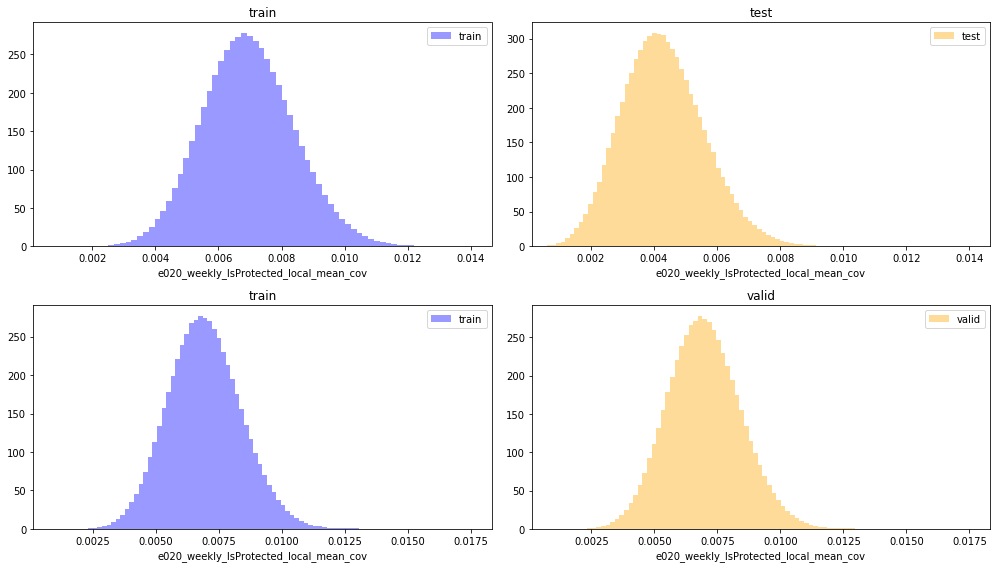

========== e020_six_hourly_Census_IsSecureBootEnabled_local_mean_mean ===========


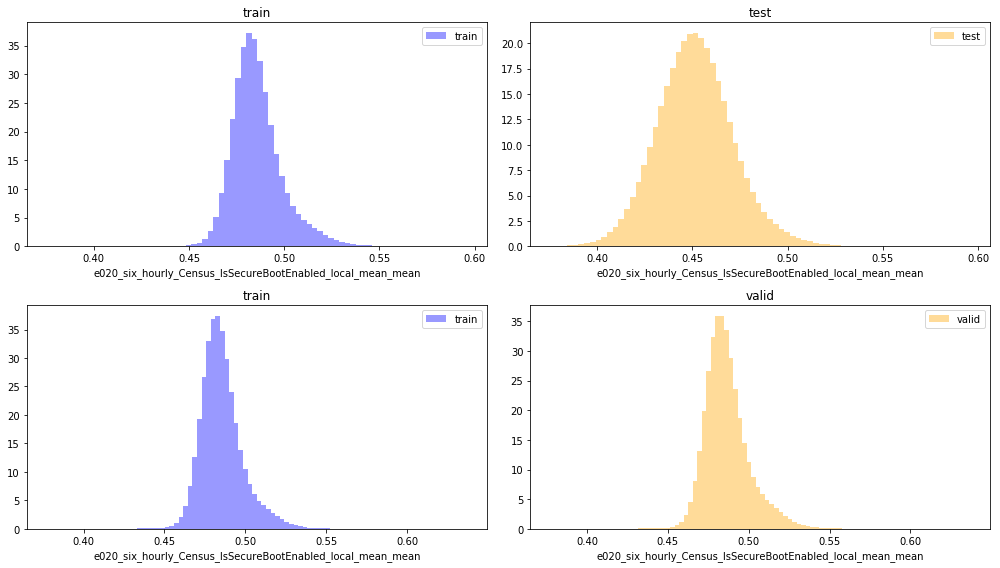

========== e020_daily_HasTpm_local_mean_mean ===========


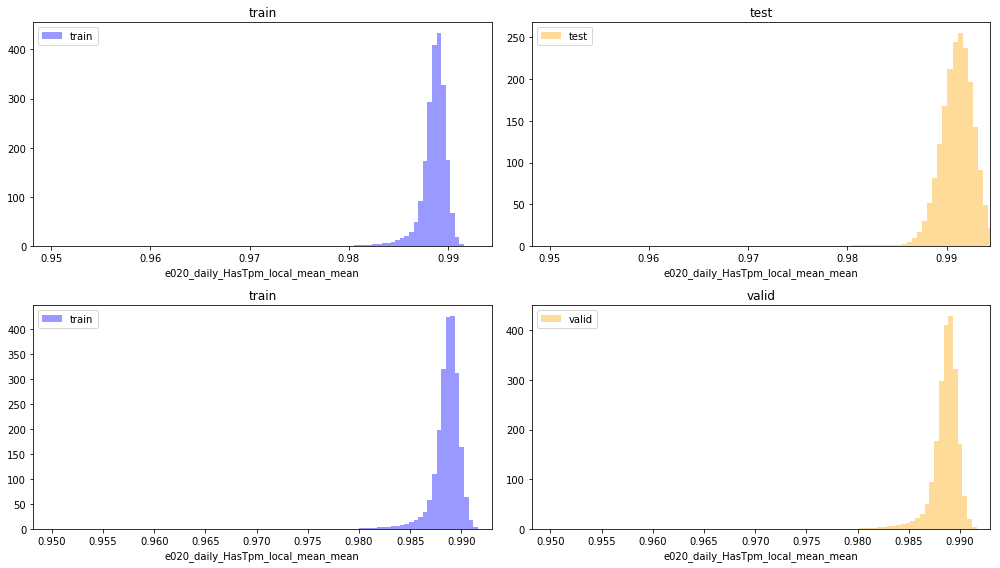

========== e020_weekly_IsBeta_local_mean_var ===========


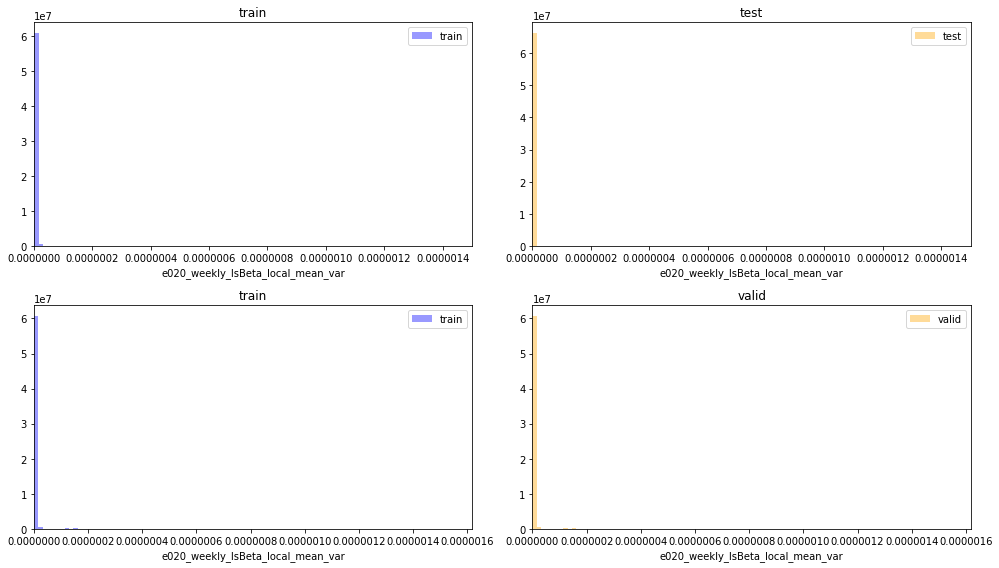

========== e020_monthly_IsBeta_local_mean_var ===========


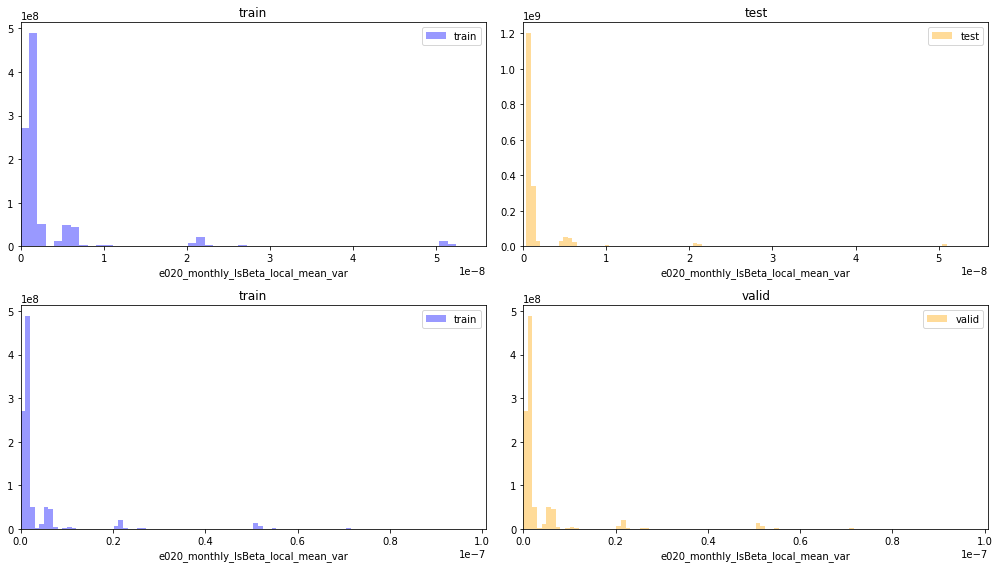

========== e020_six_hourly_Wdft_IsGamer_local_mean_mean ===========


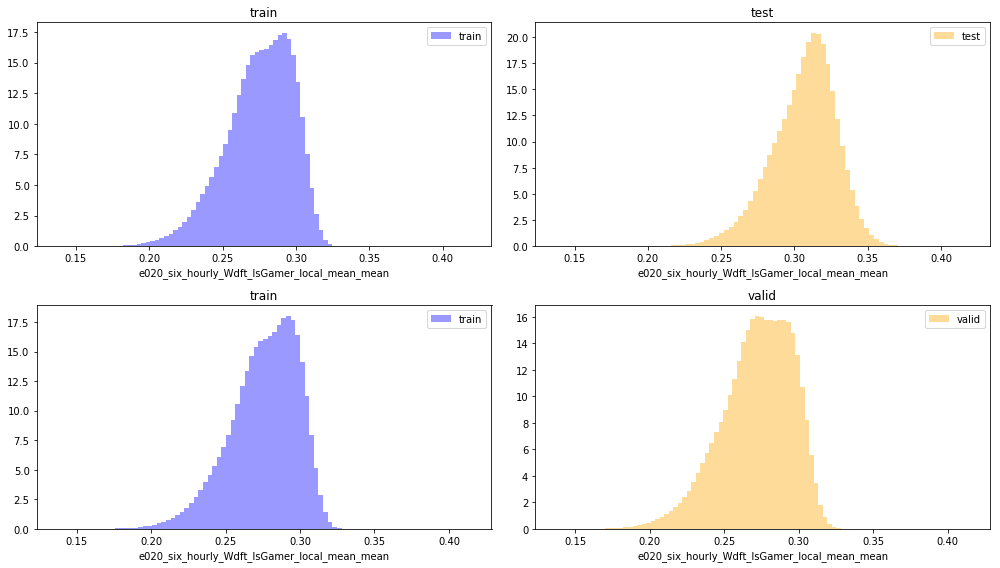

========== e020_weekly_AutoSampleOptIn_local_mean_mean ===========


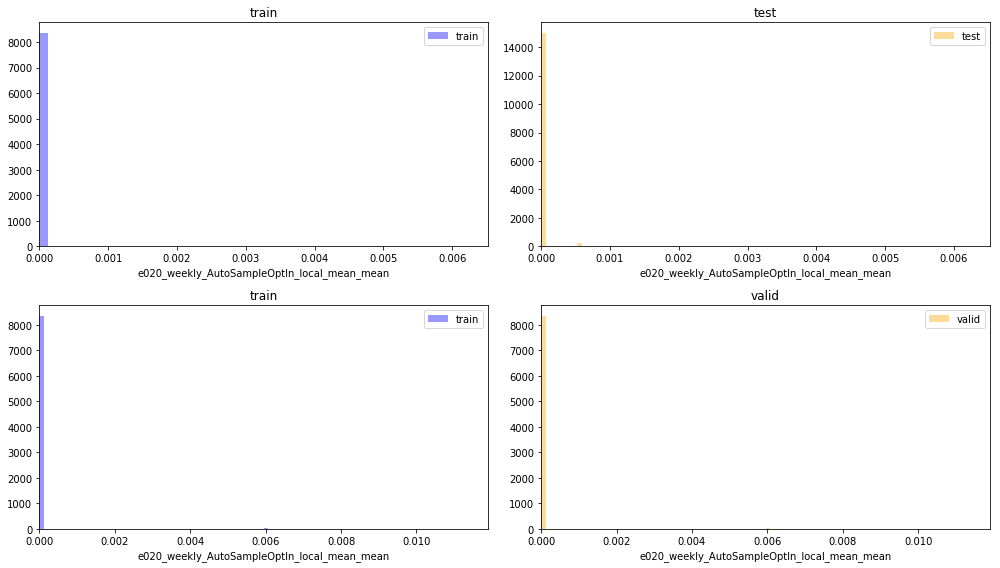

========== e020_daily_Census_IsVirtualDevice_local_mean_var ===========


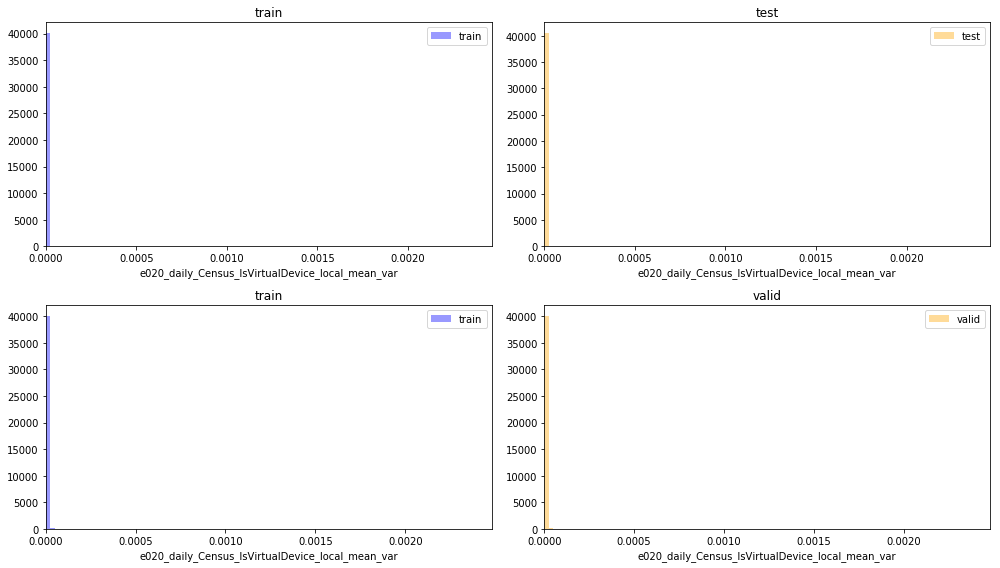

========== e020_weekly_SMode_local_mean_mean ===========


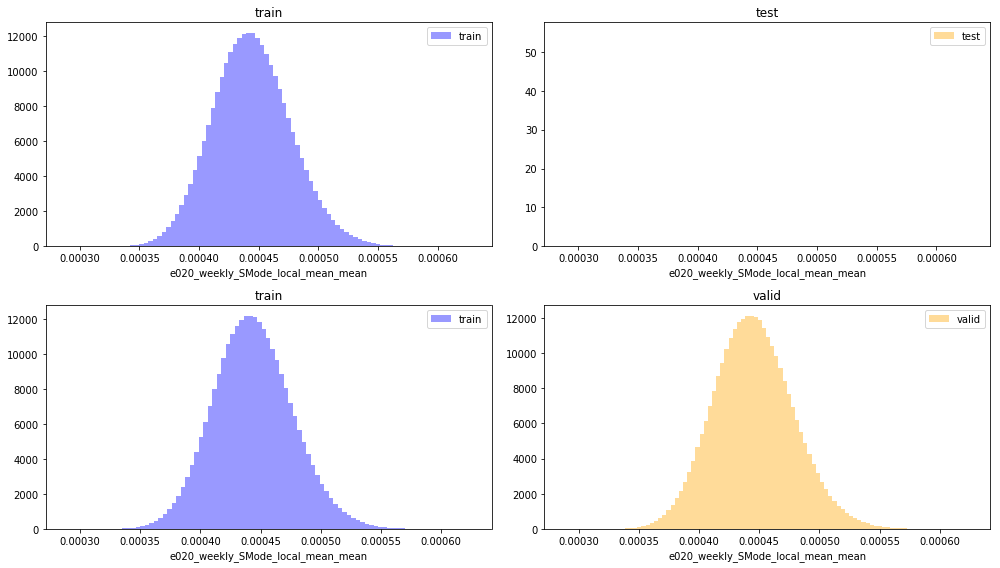

========== e020_weekly_HasTpm_local_mean_var ===========


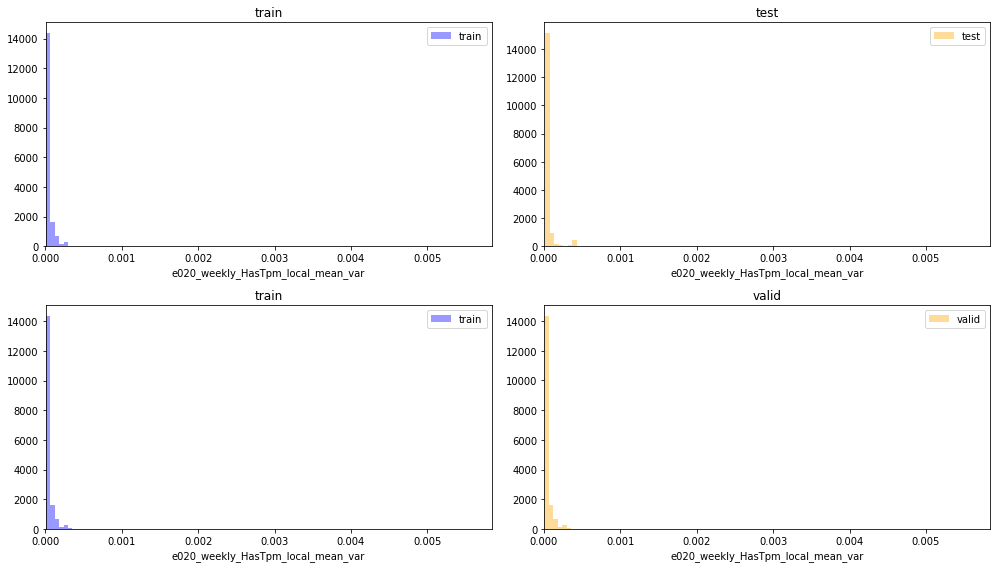

========== e020_six_hourly_Census_HasOpticalDiskDrive_local_mean_cov ===========


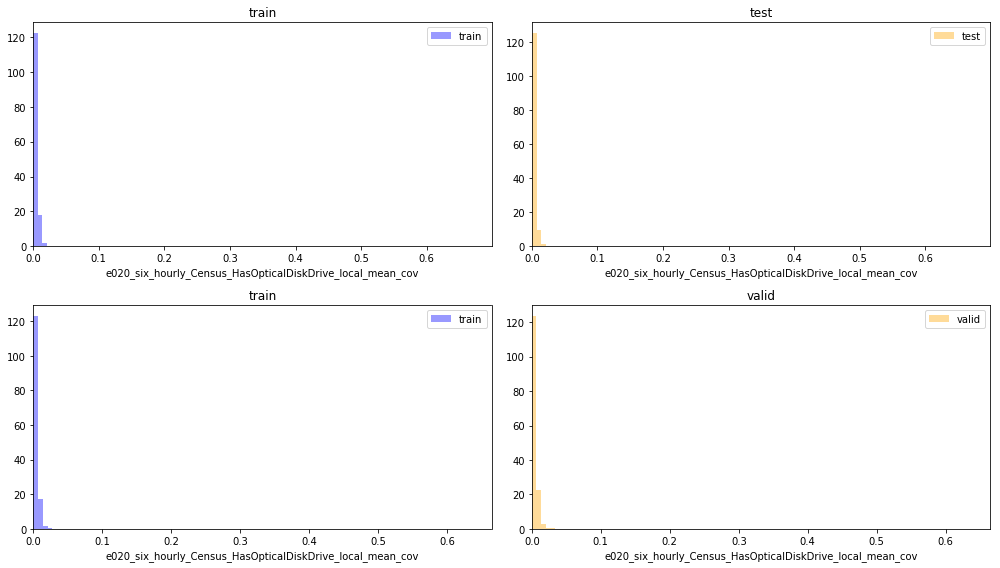

========== e020_weekly_Census_IsSecureBootEnabled_local_mean_var ===========


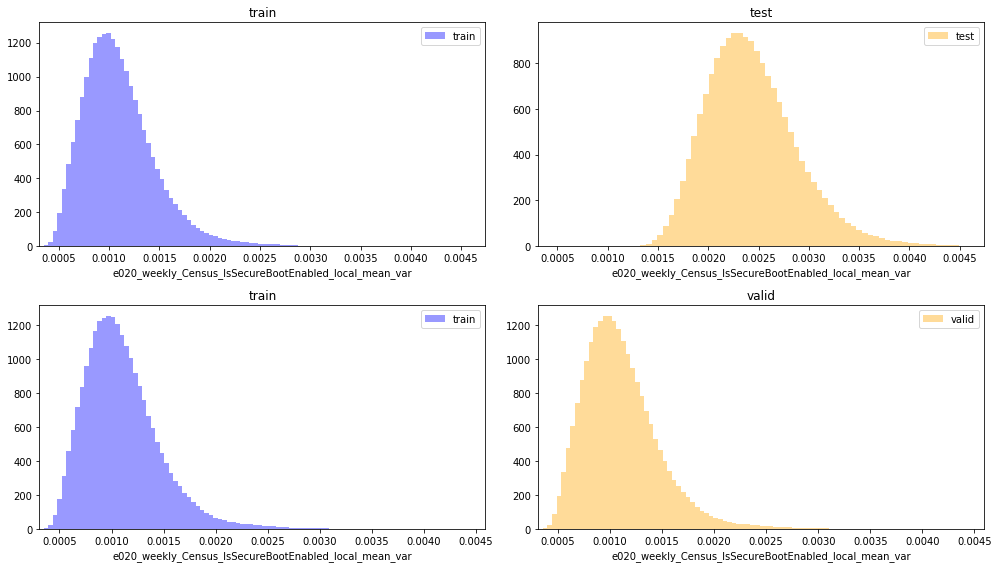

========== e020_weekly_Census_IsFlightsDisabled_local_mean_mean ===========


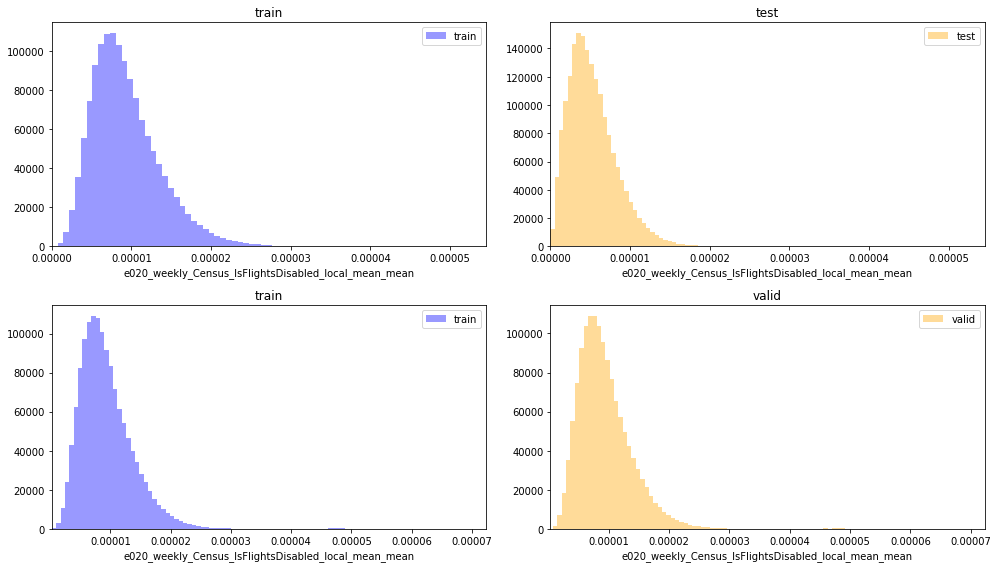

========== e020_six_hourly_IsProtected_local_mean_mean ===========


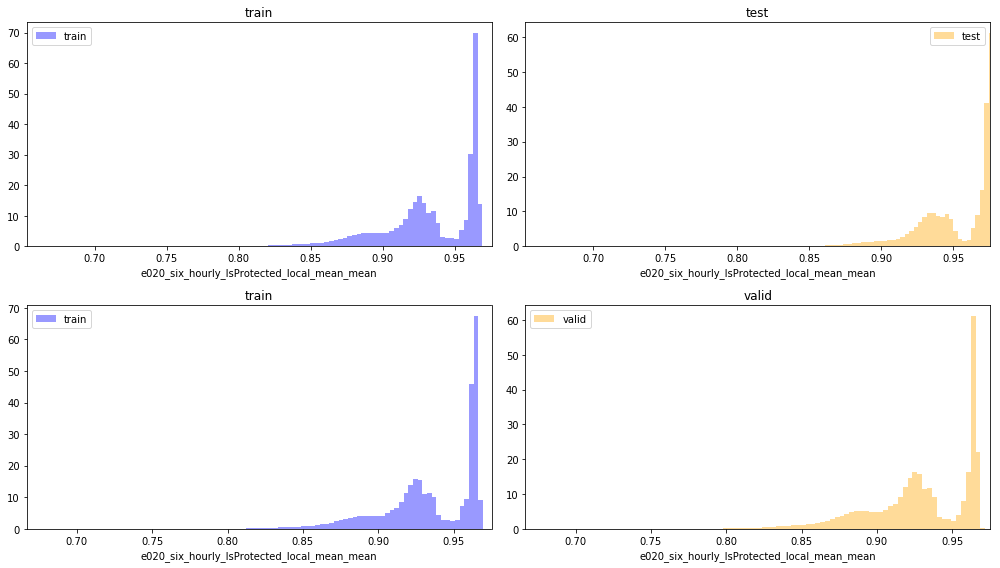

========== e020_monthly_{col}_mean ===========


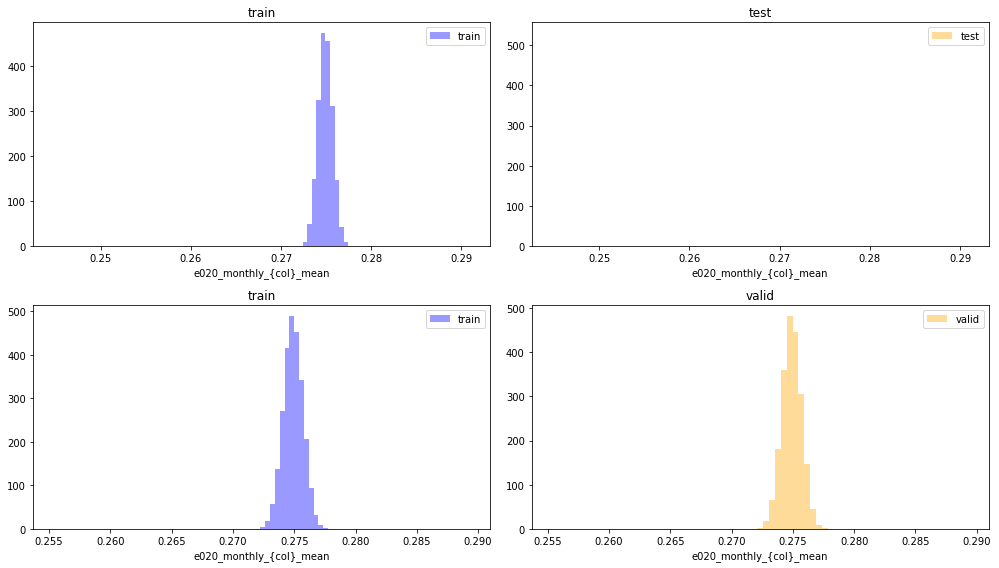

========== e020_daily_Firewall_local_mean_mean ===========


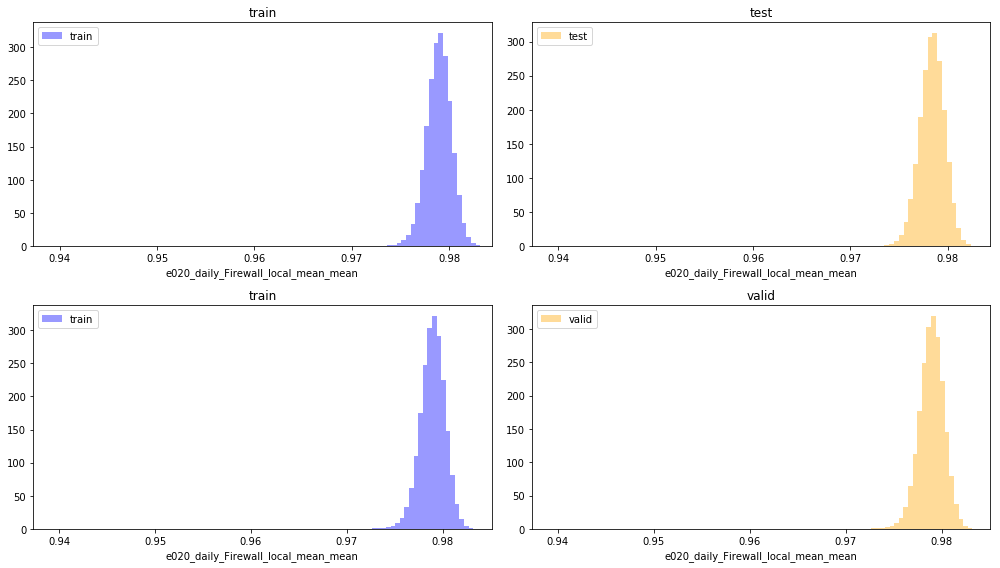

========== e020_daily_Census_IsFlightsDisabled_local_mean_mean ===========


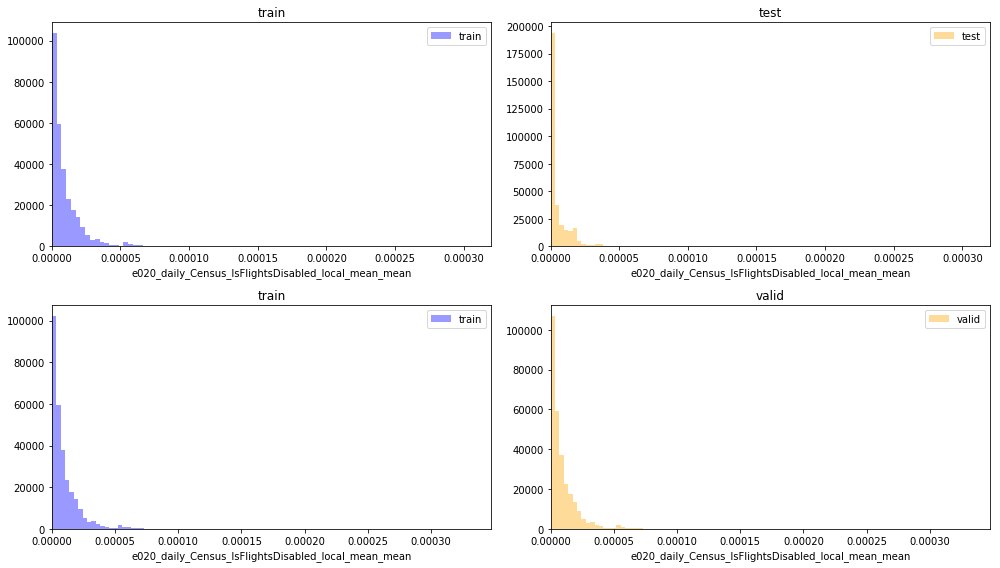

========== e020_Census_HasOpticalDiskDrive_local_mean ===========


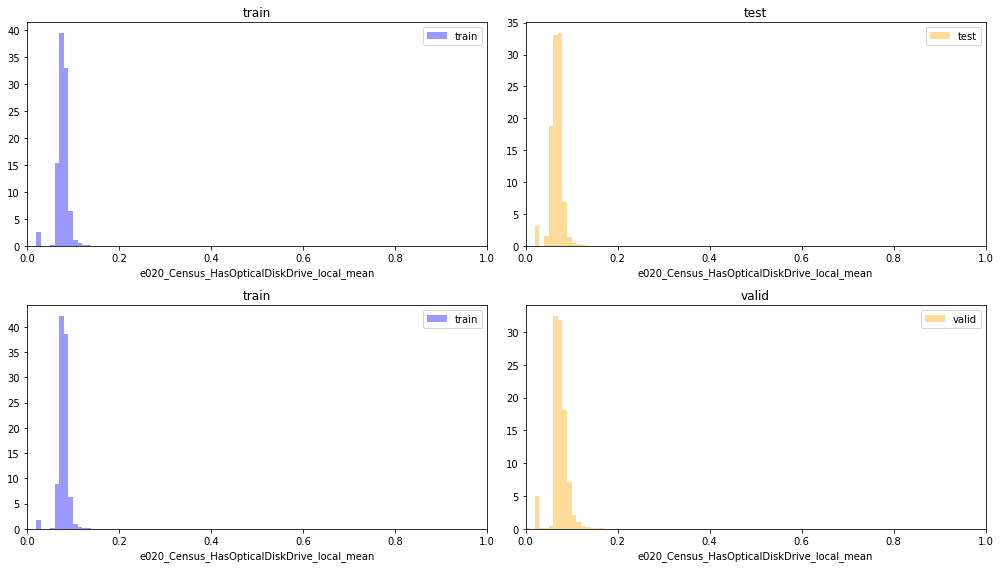

========== e020_weekly_Census_HasOpticalDiskDrive_local_mean_mean ===========


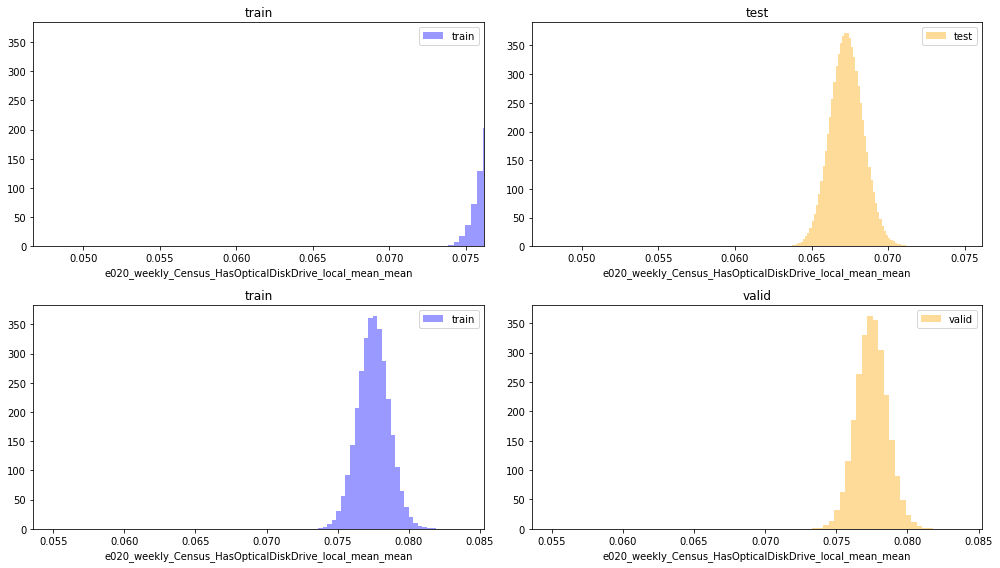

========== e020_weekly_Census_IsPortableOperatingSystem_local_mean_cov ===========


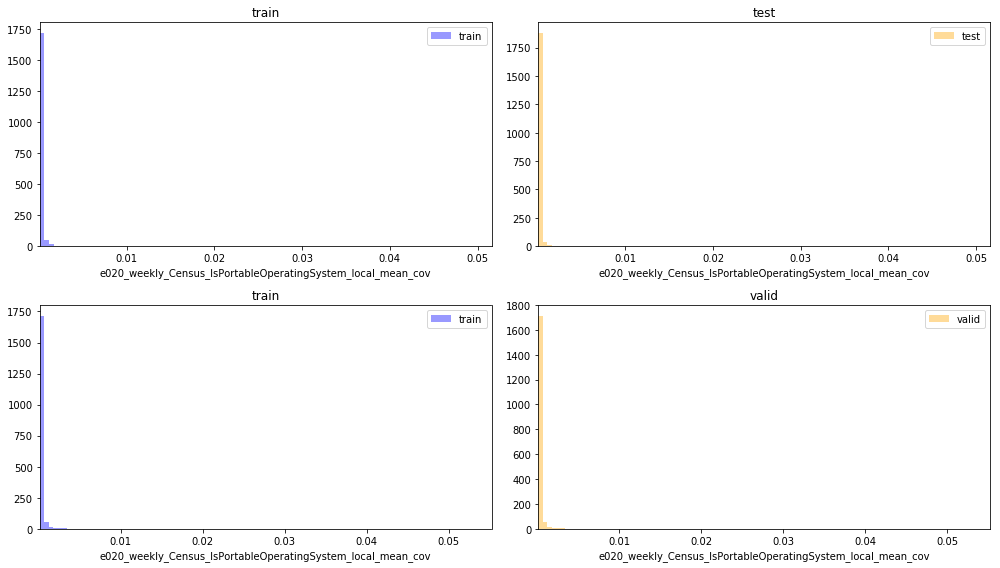

========== e020_weekly_Census_IsFlightingInternal_local_mean_mean ===========


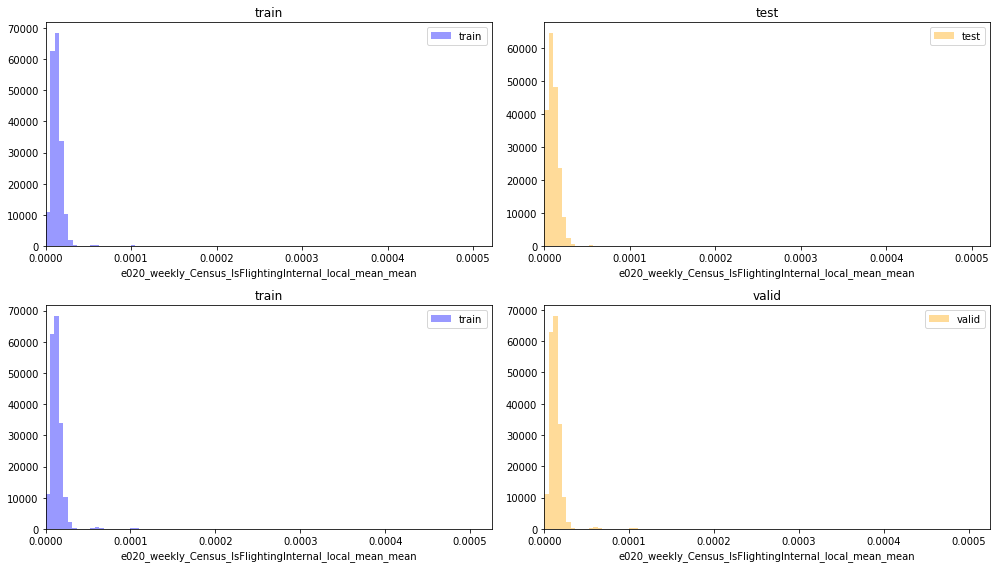

========== e020_daily_Wdft_IsGamer_local_mean_cov ===========


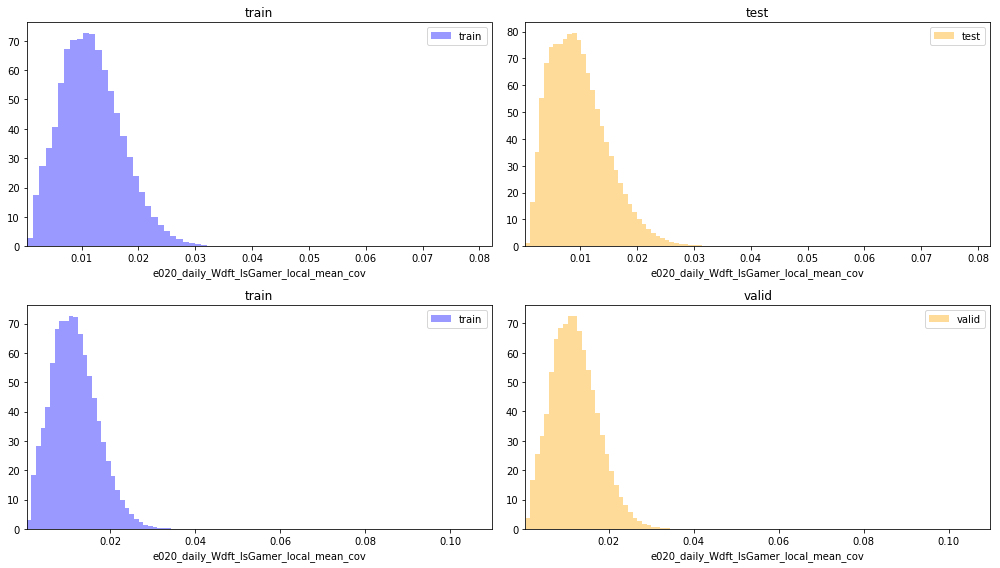

========== e020_monthly_IsSxsPassiveMode_local_mean_var ===========


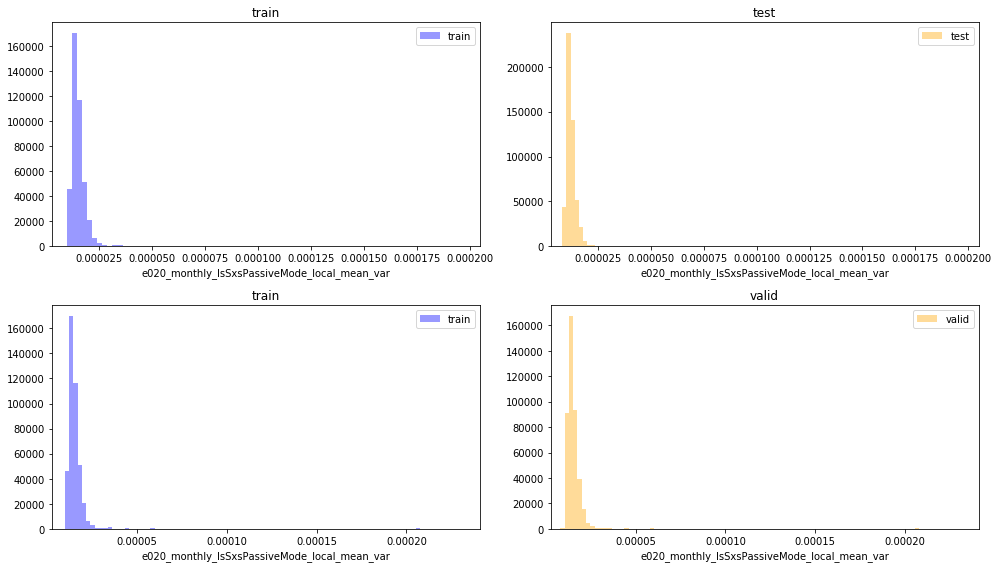

========== e020_six_hourly_Census_IsPenCapable_local_mean_mean ===========


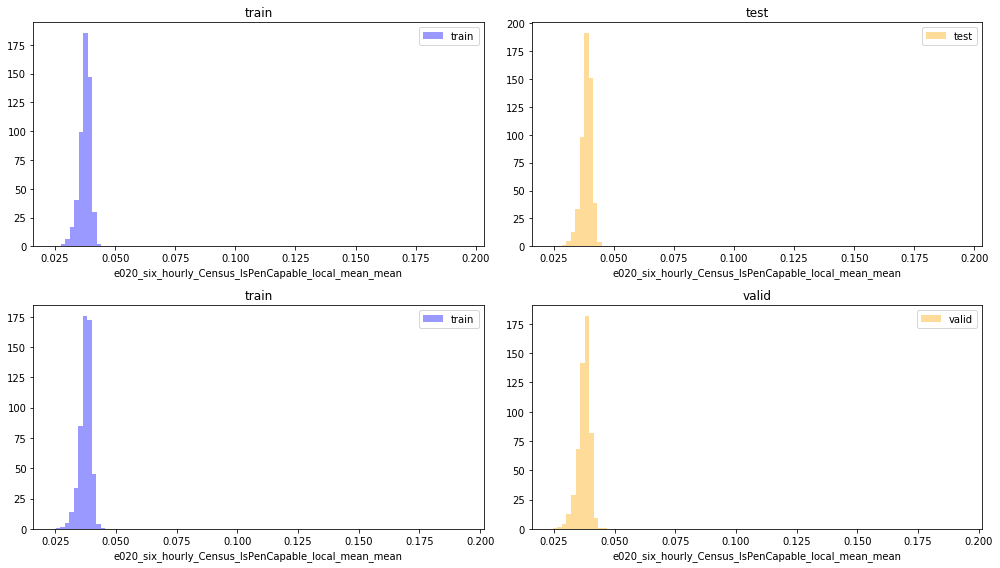

========== e020_daily_SMode_local_mean_mean ===========


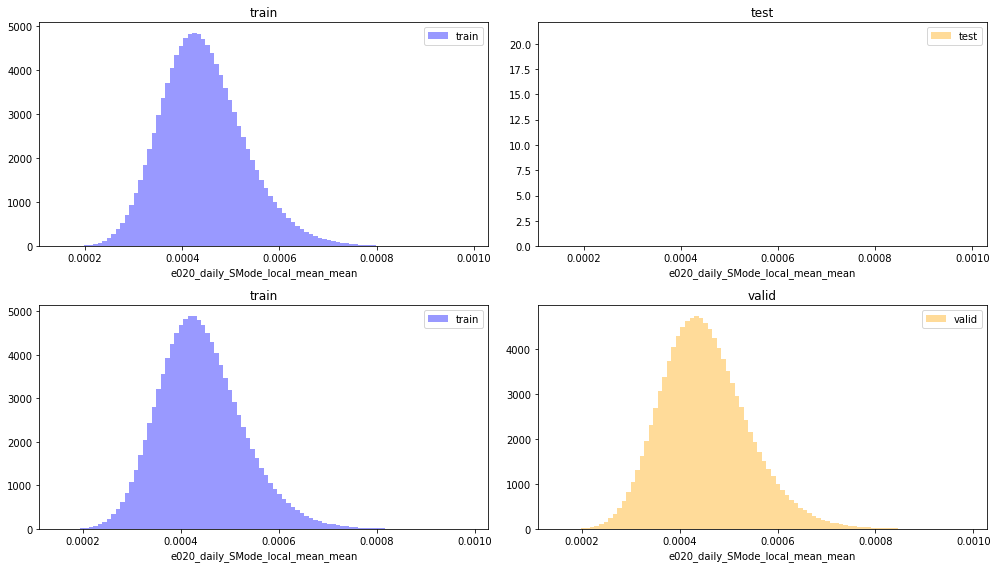

========== e020_daily_Census_IsSecureBootEnabled_local_mean_cov ===========


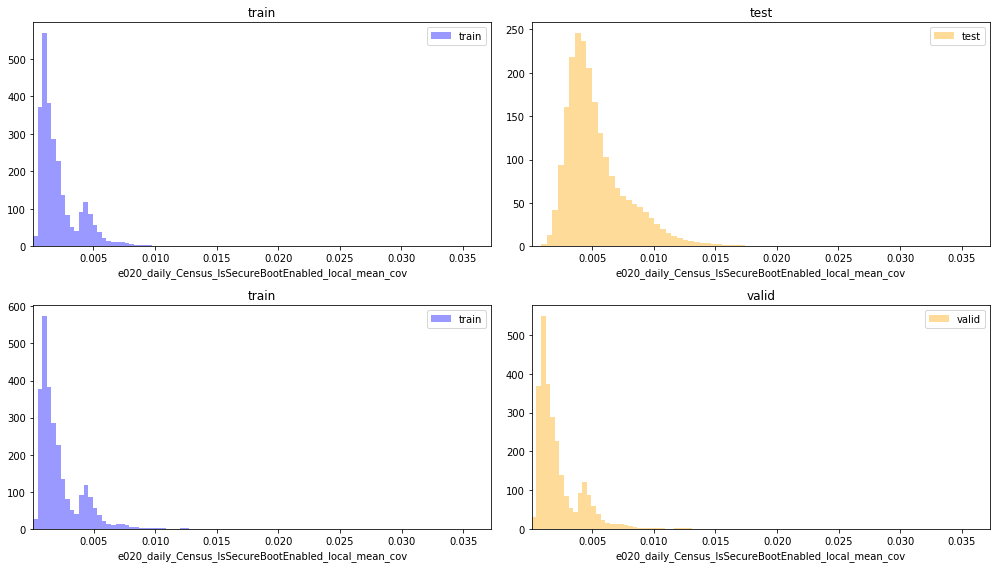

========== e020_six_hourly_Census_IsWIMBootEnabled_local_mean_cov ===========


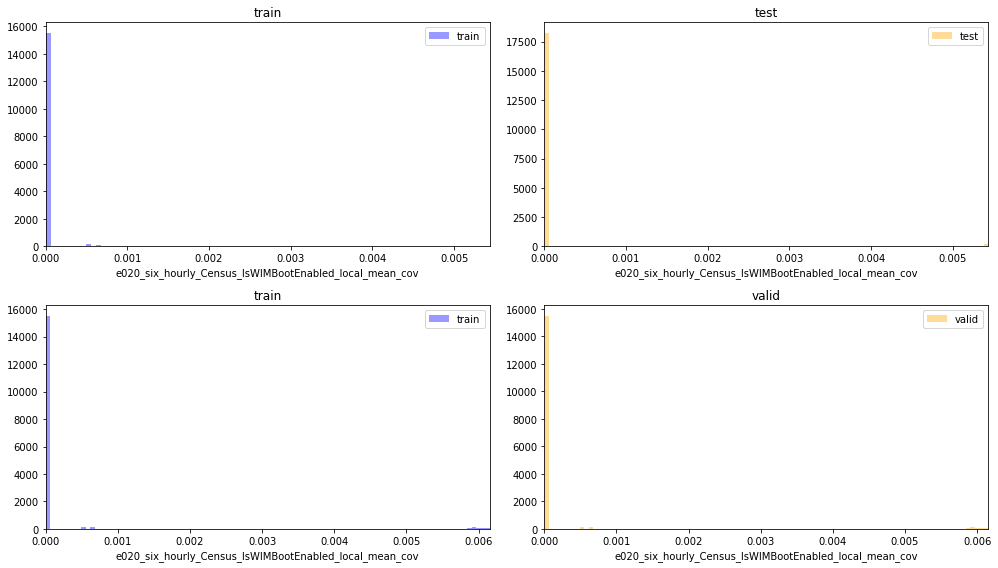

========== e020_daily_Wdft_IsGamer_local_mean_var ===========


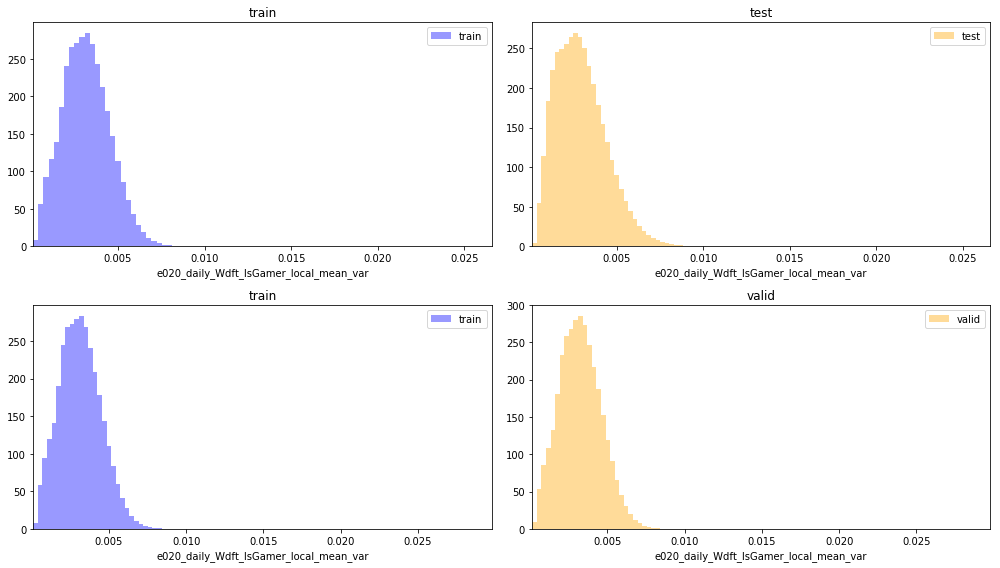

========== e020_weekly_IsProtected_local_mean_mean ===========


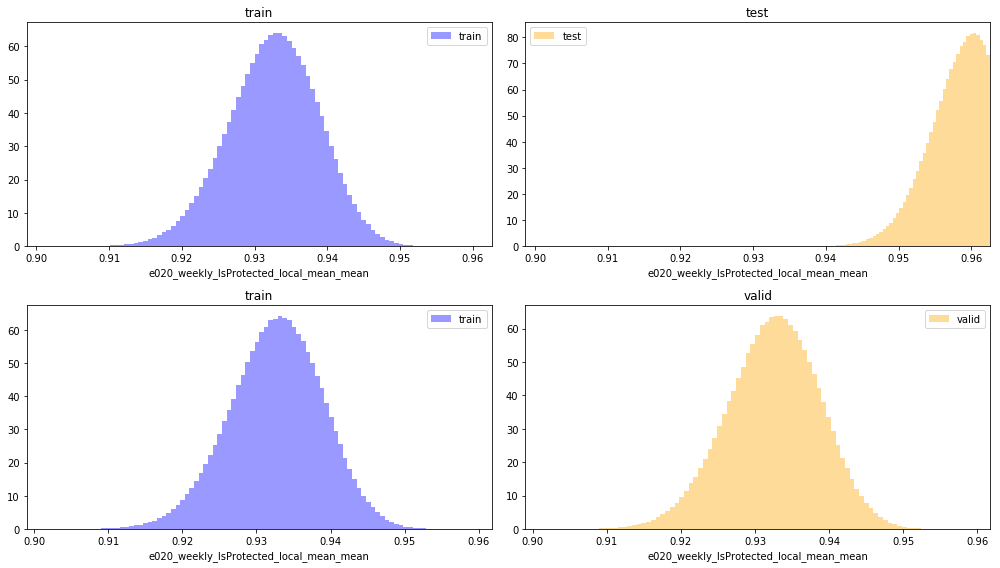

========== e020_six_hourly_Census_ThresholdOptIn_local_mean_mean ===========


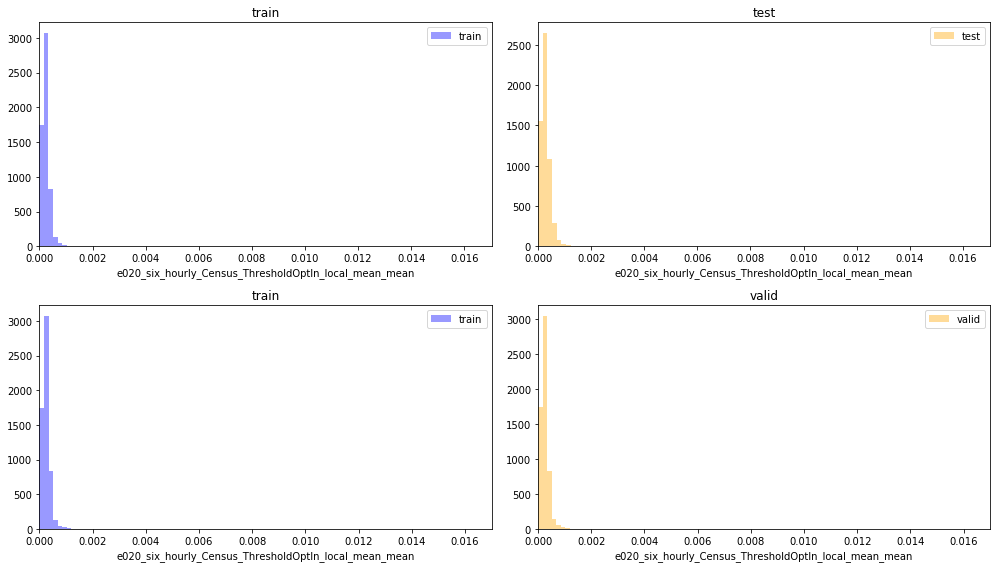

========== e020_monthly_Census_IsPenCapable_local_mean_cov ===========


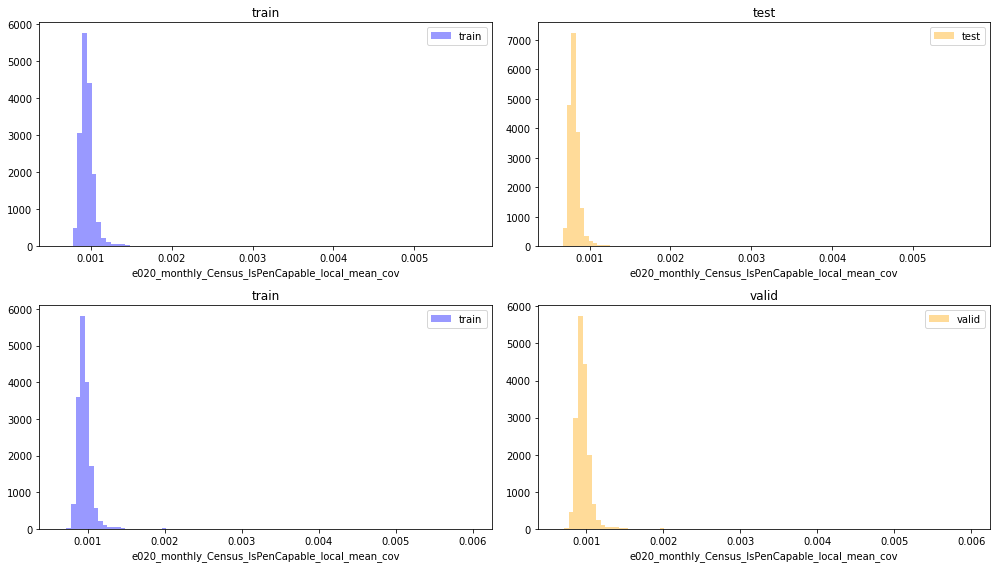

========== e020_six_hourly_IsSxsPassiveMode_local_mean_cov ===========


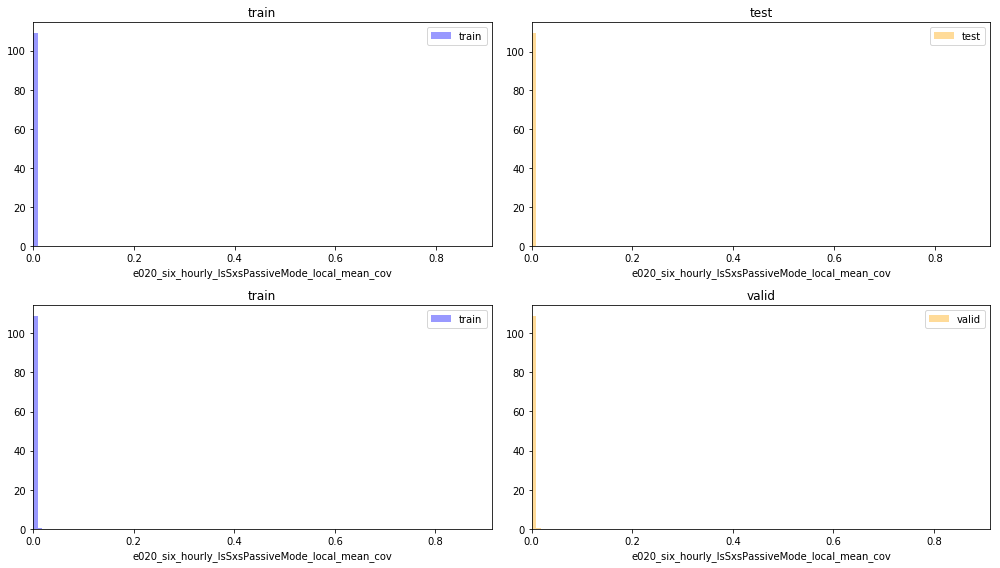

========== e020_six_hourly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_mean ===========


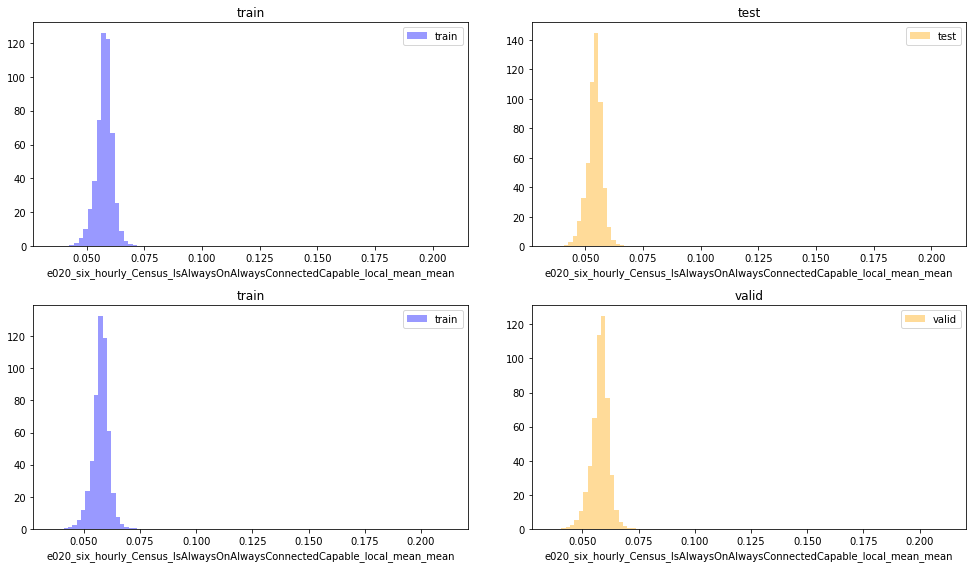

========== e020_daily_Census_IsPenCapable_local_mean_mean ===========


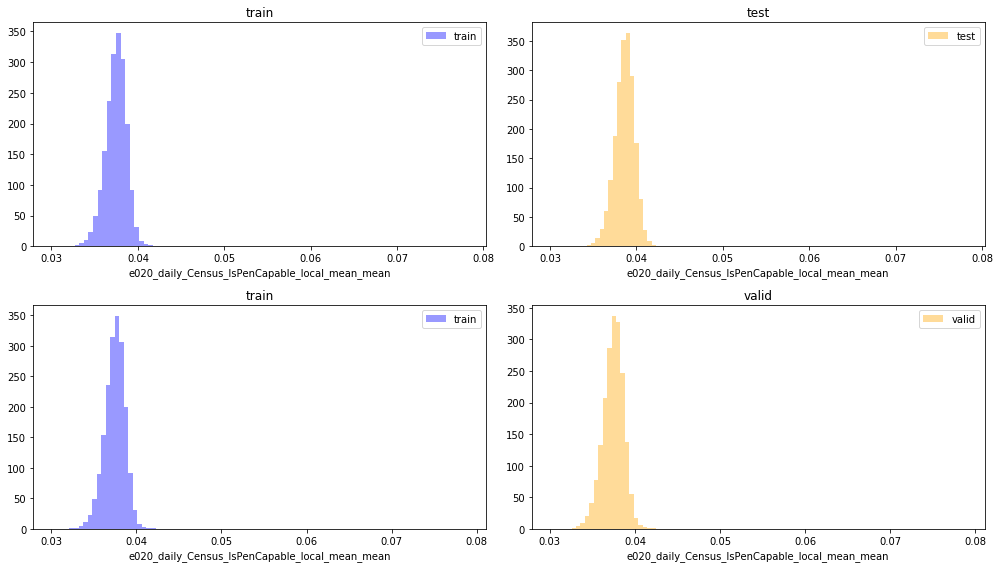

========== e020_daily_Census_IsVirtualDevice_local_mean_cov ===========


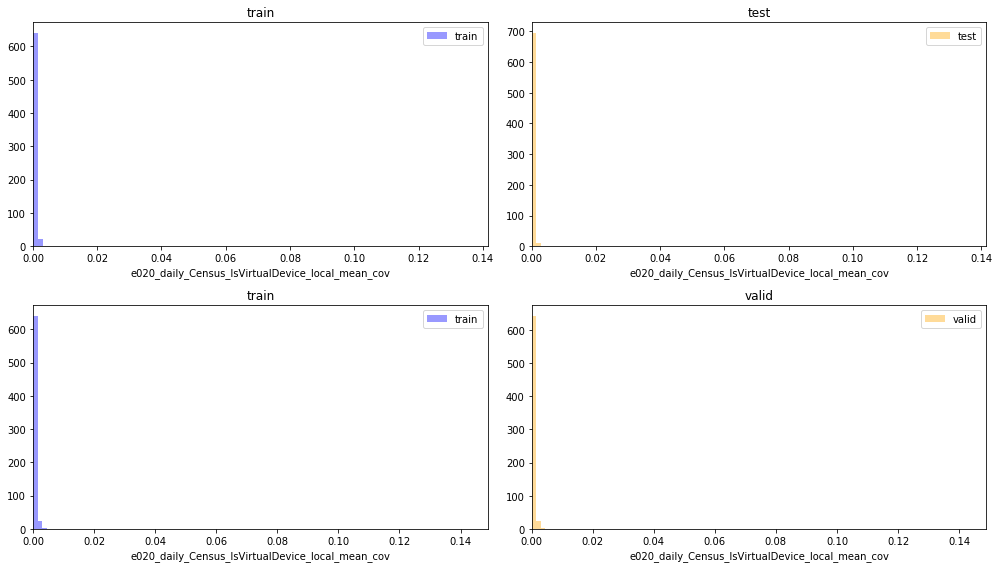

========== e020_six_hourly_Census_IsTouchEnabled_local_mean_cov ===========


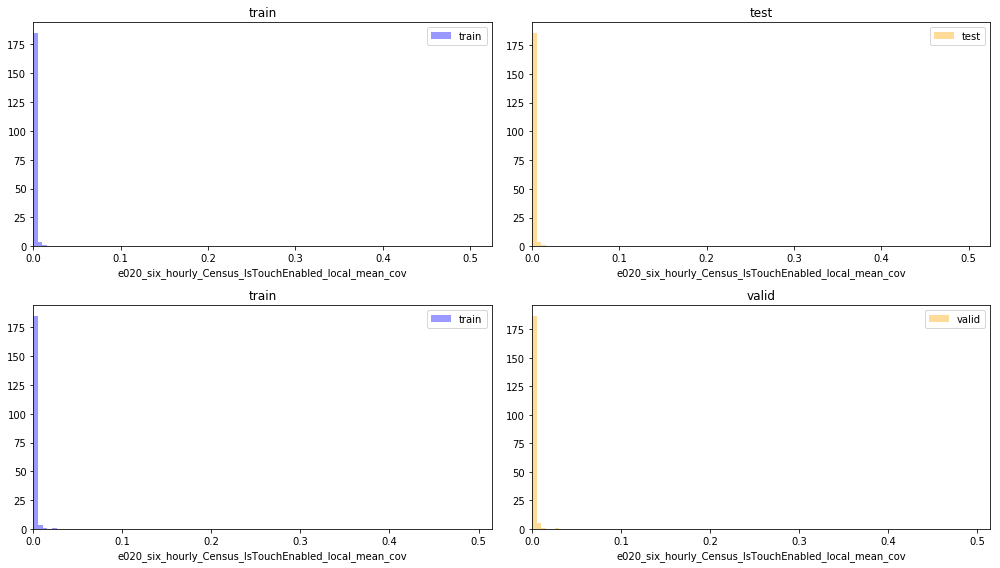

========== e020_monthly_Census_IsPortableOperatingSystem_local_mean_var ===========


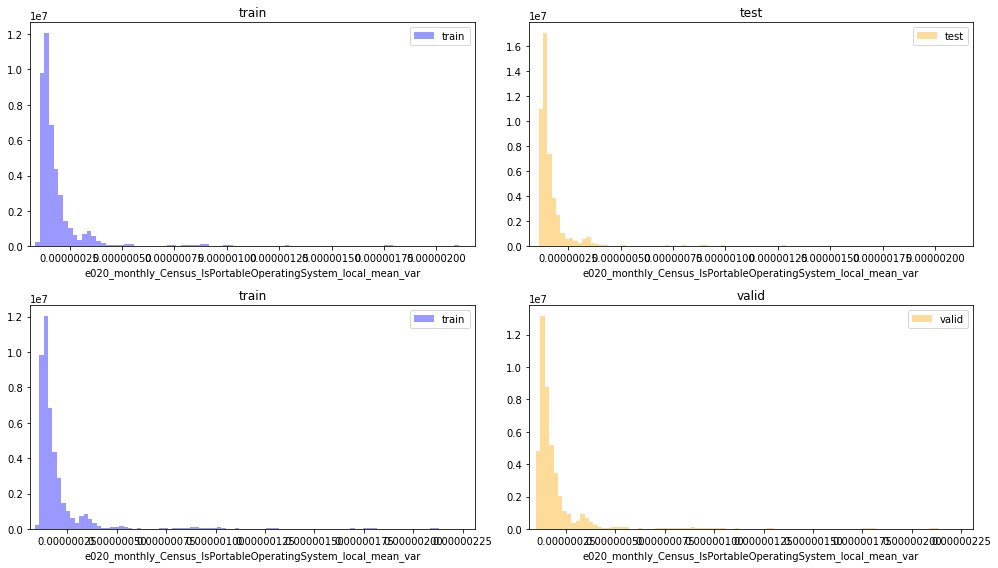

========== e020_weekly_Census_IsTouchEnabled_local_mean_var ===========


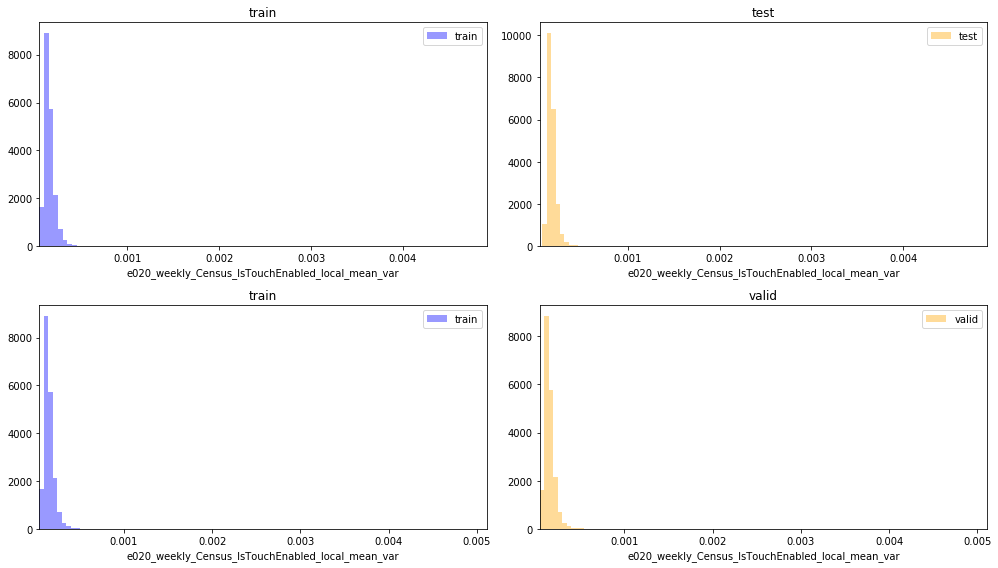

========== e020_weekly_Census_HasOpticalDiskDrive_local_mean_cov ===========


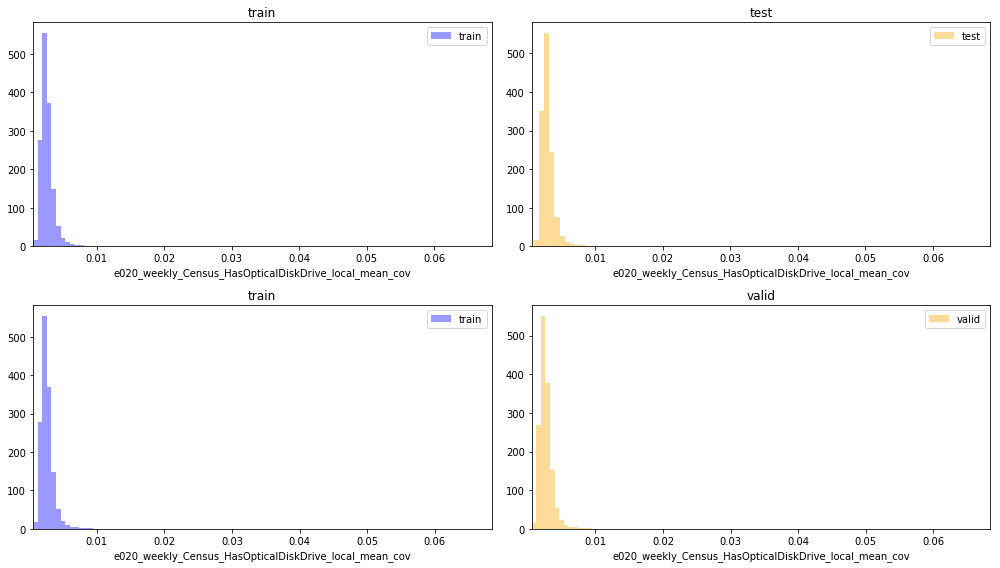

========== e020_six_hourly_Census_HasOpticalDiskDrive_local_mean_var ===========


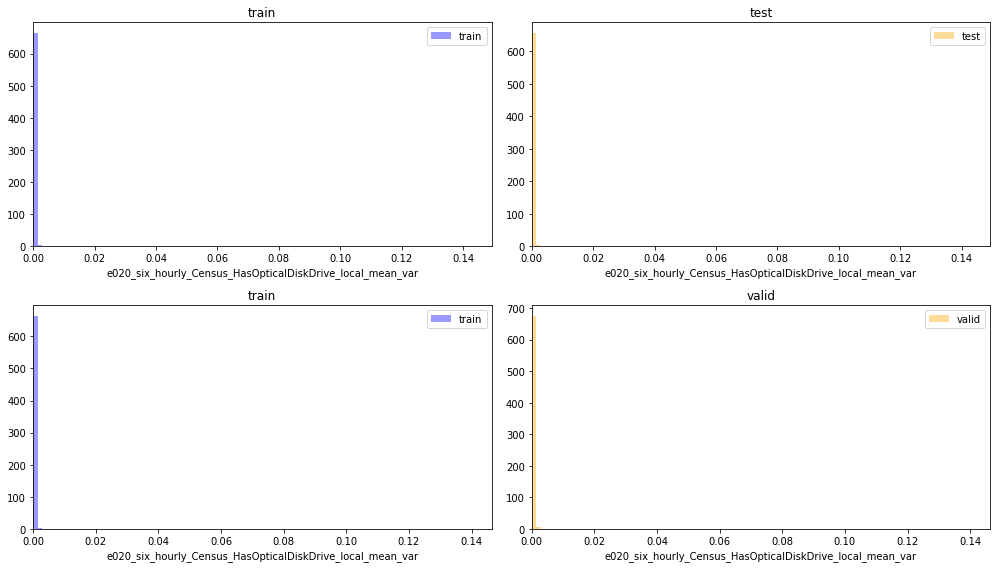

========== e020_monthly_Census_HasOpticalDiskDrive_local_mean_cov ===========


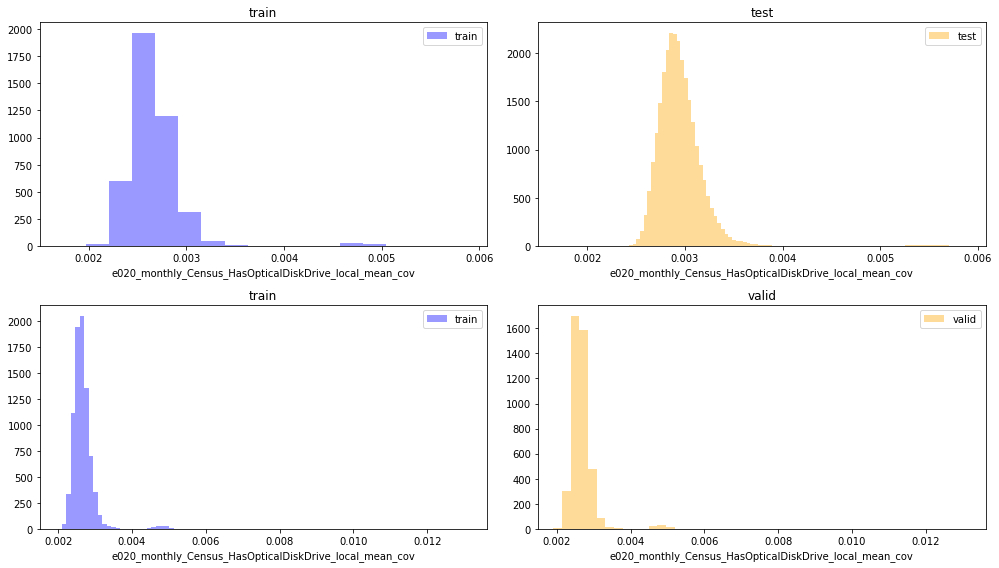

========== e020_Firewall_local_mean ===========


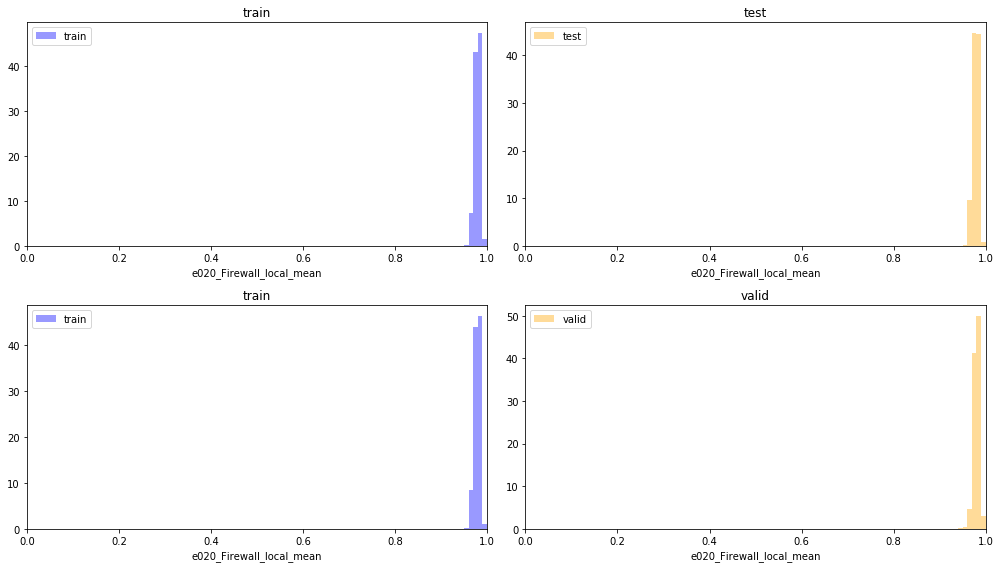

========== e020_weekly_Census_IsSecureBootEnabled_local_mean_mean ===========


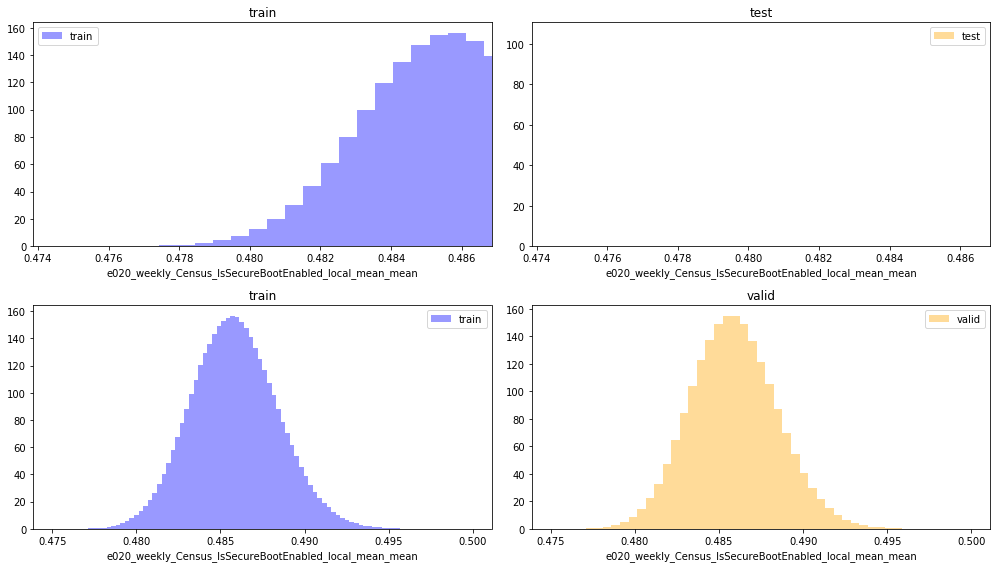

========== e020_Census_IsTouchEnabled_local_mean ===========


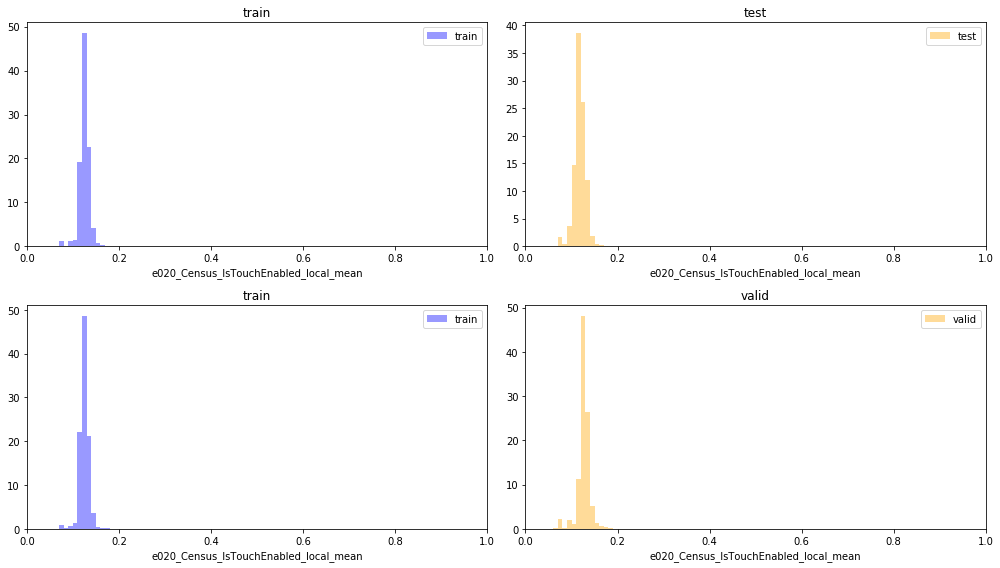

========== e020_monthly_HasTpm_local_mean_var ===========


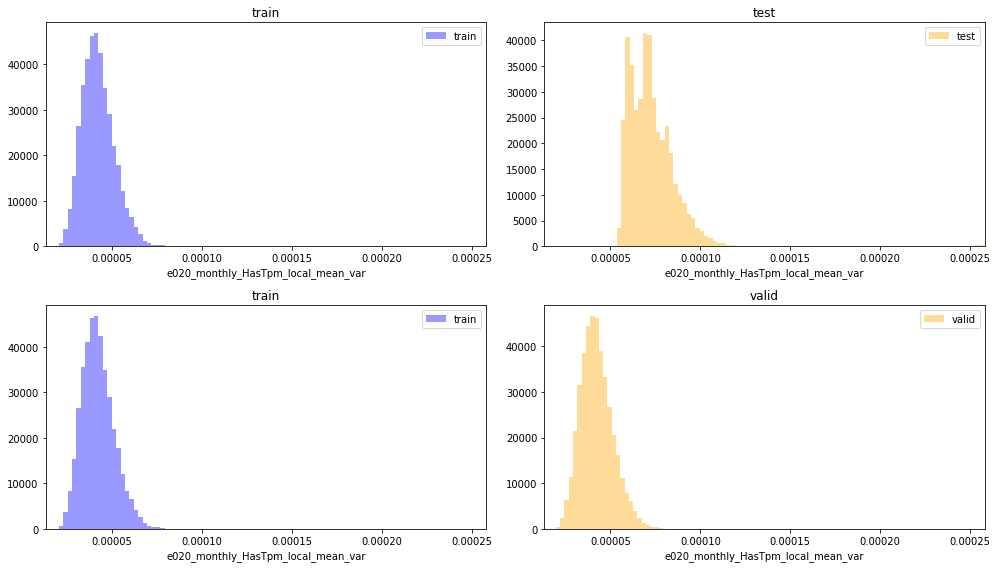

========== e020_daily_IsProtected_local_mean_cov ===========


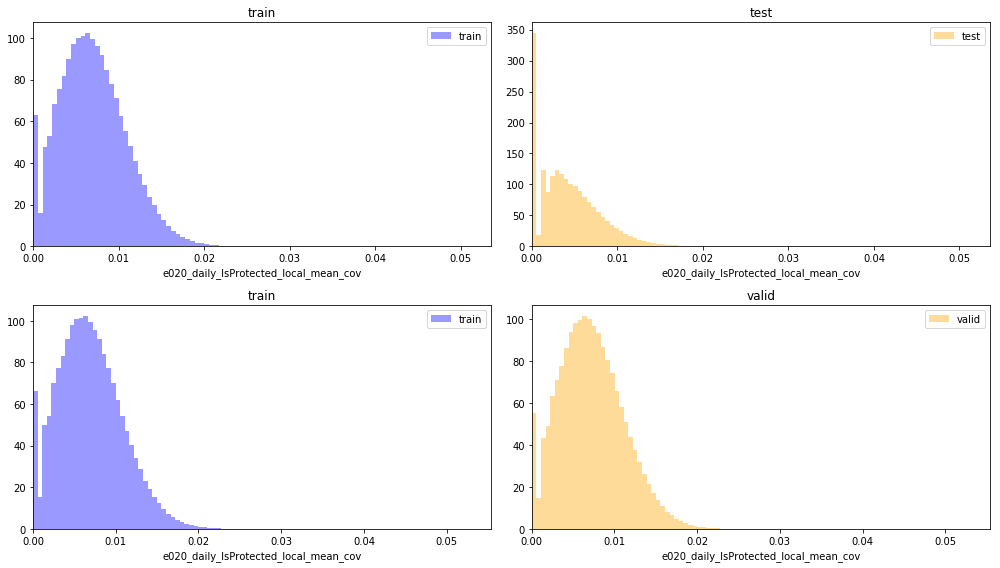

========== e020_daily_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_cov ===========


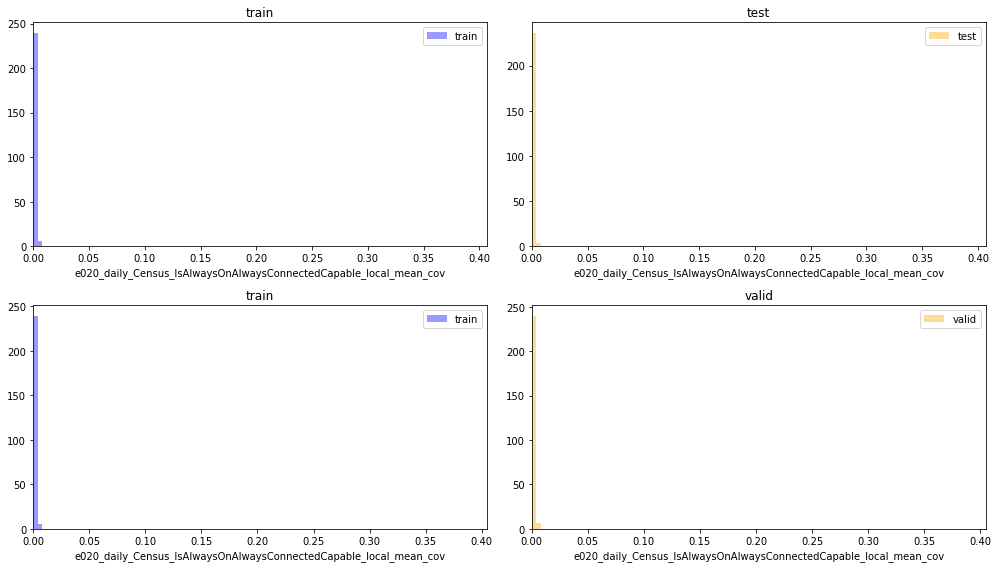

========== e020_monthly_IsProtected_local_mean_cov ===========


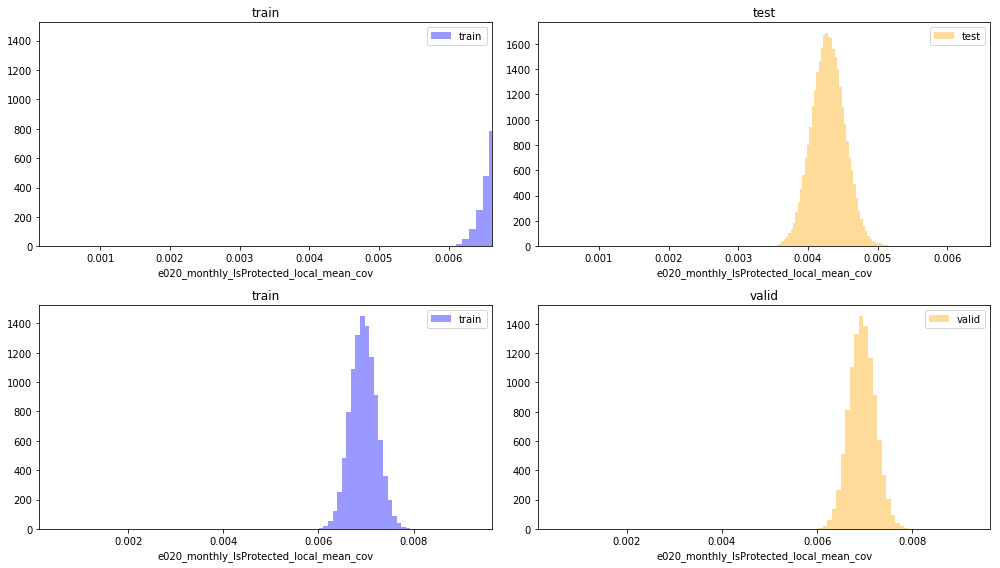

========== e020_monthly_Census_IsFlightingInternal_local_mean_cov ===========


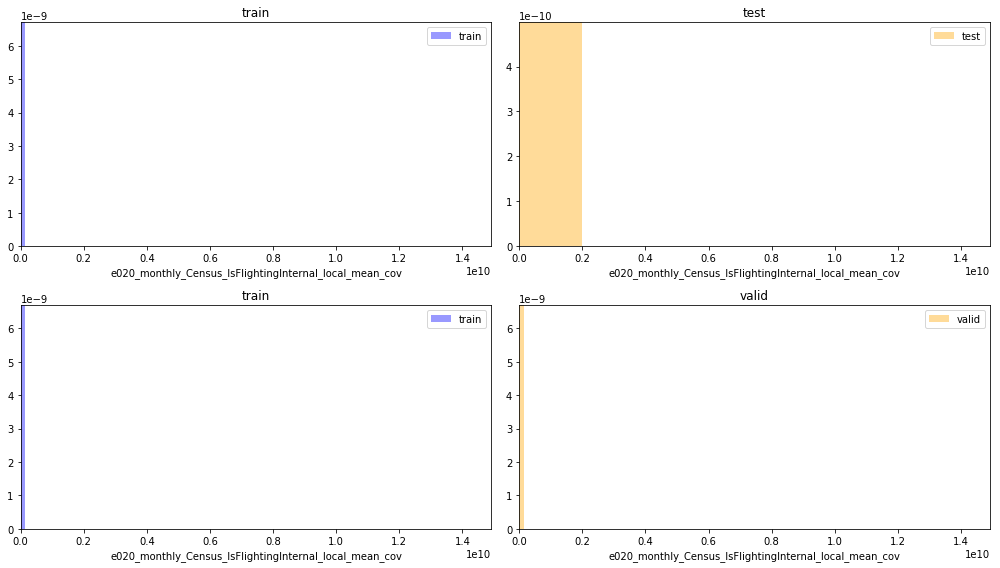

========== e020_monthly_Census_IsFlightsDisabled_local_mean_var ===========


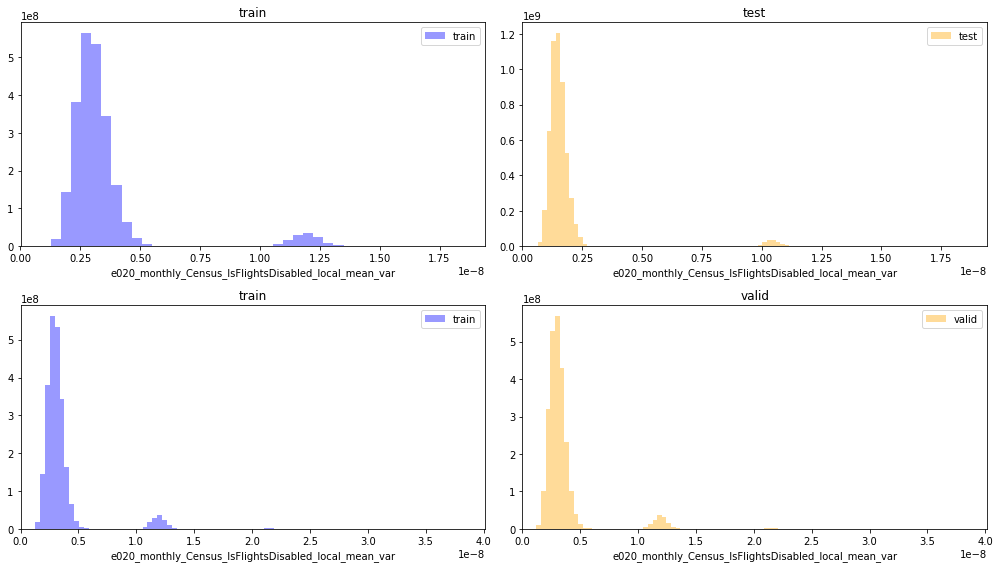

========== e020_six_hourly_Census_IsFlightingInternal_local_mean_cov ===========


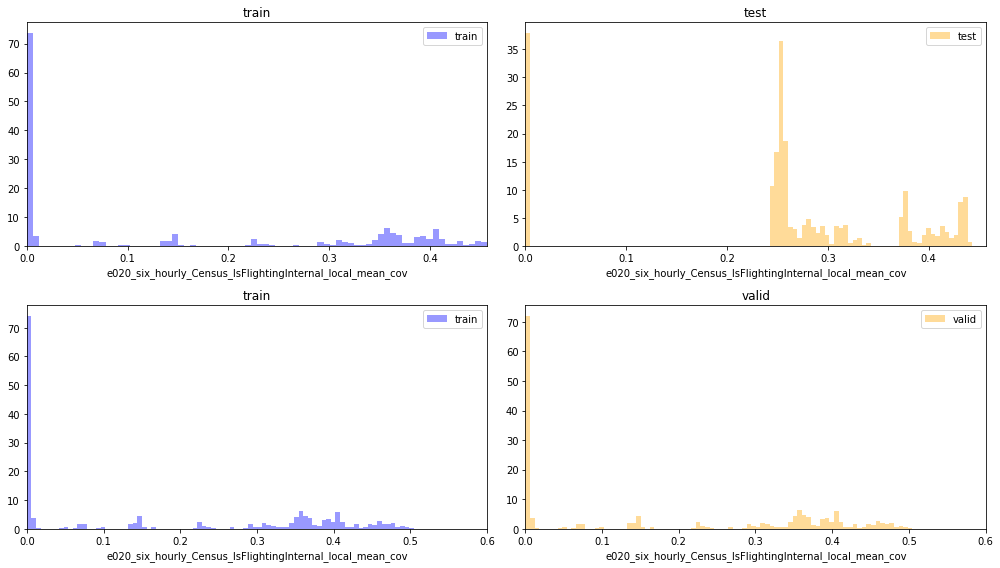

========== e020_daily_Firewall_local_mean_cov ===========


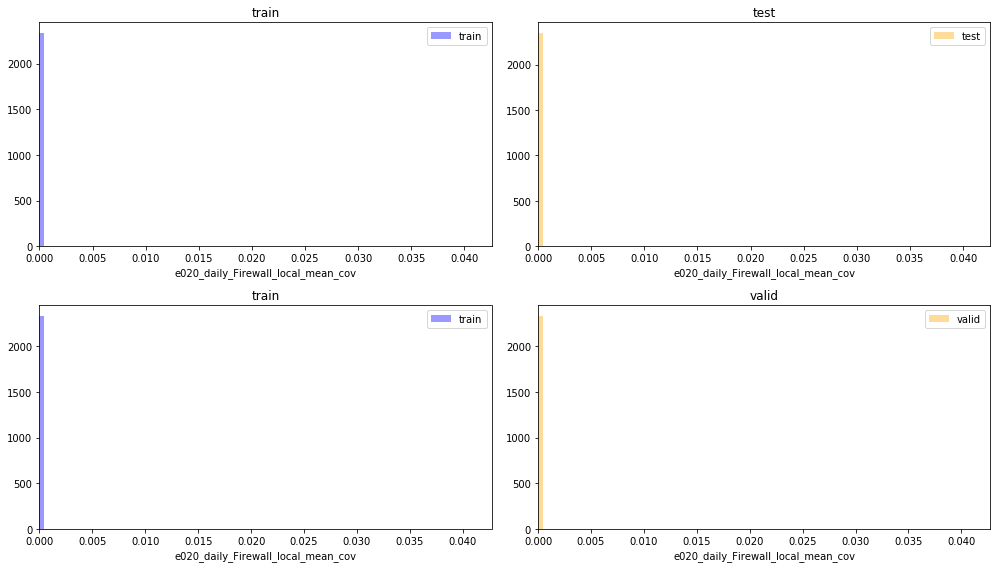

========== e020_daily_Census_IsTouchEnabled_local_mean_mean ===========


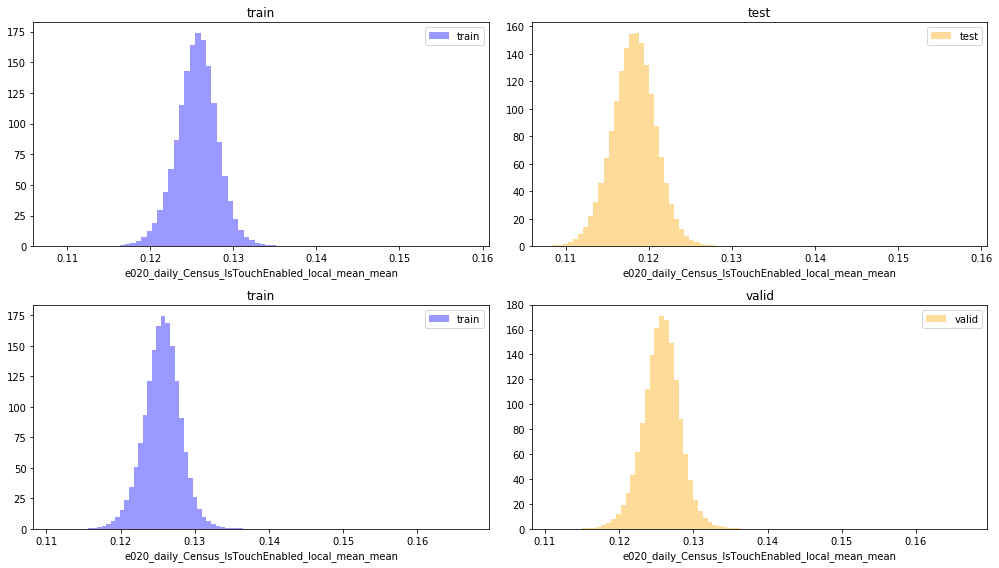

========== e020_six_hourly_Census_IsTouchEnabled_local_mean_var ===========


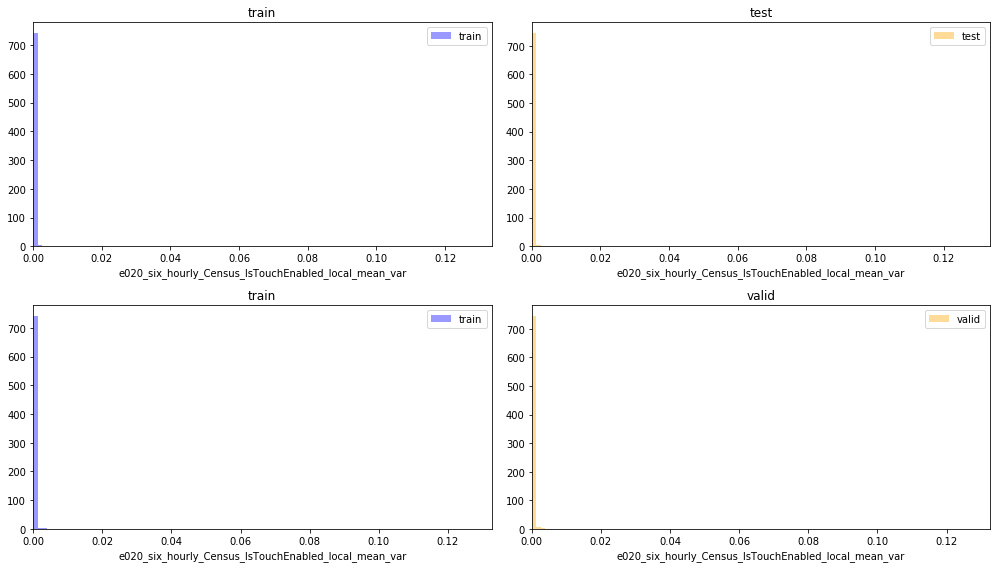

========== e020_monthly_Firewall_local_mean_cov ===========


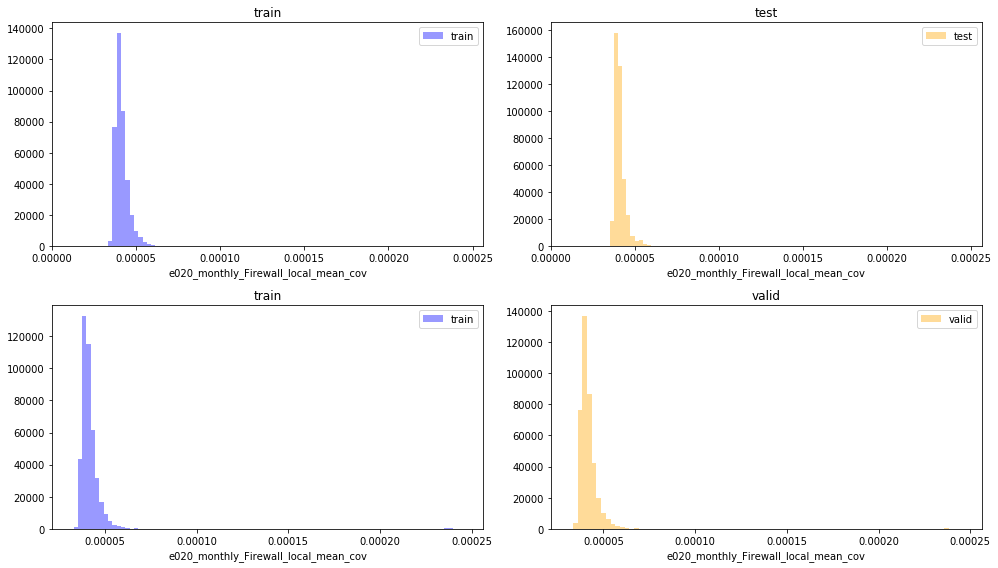

========== e020_monthly_SMode_local_mean_var ===========


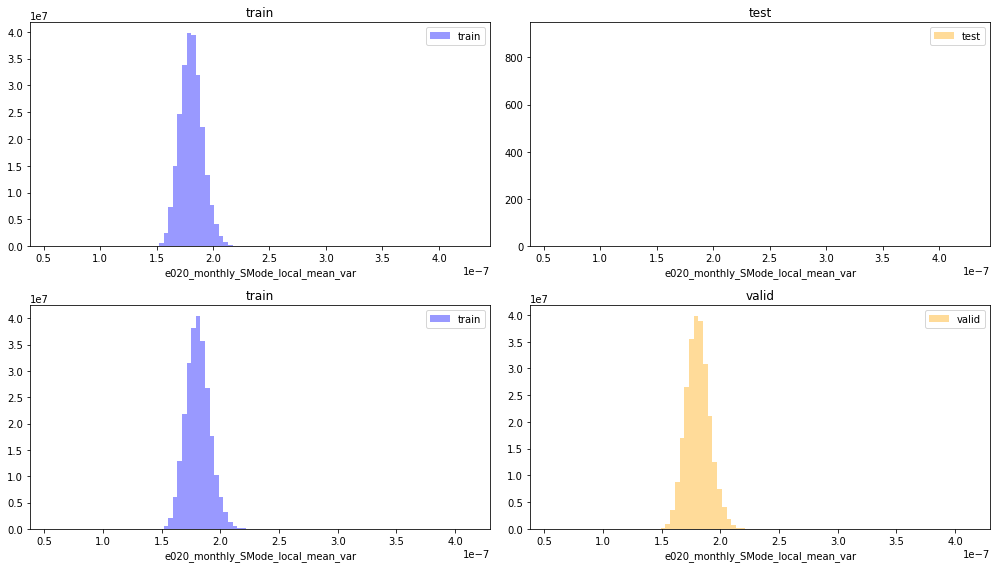

========== e020_daily_Census_IsWIMBootEnabled_local_mean_mean ===========


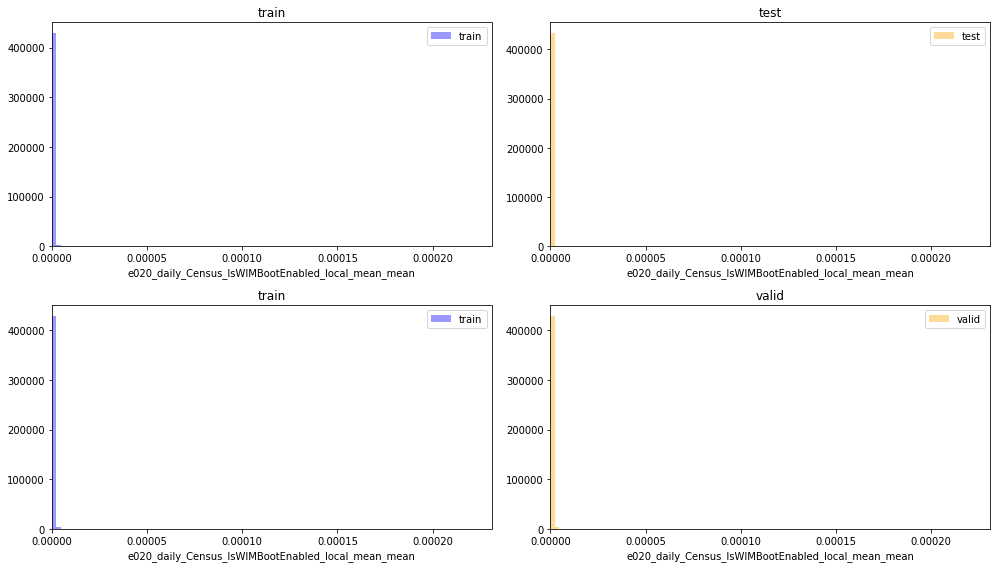

========== e020_daily_Census_IsPortableOperatingSystem_local_mean_mean ===========


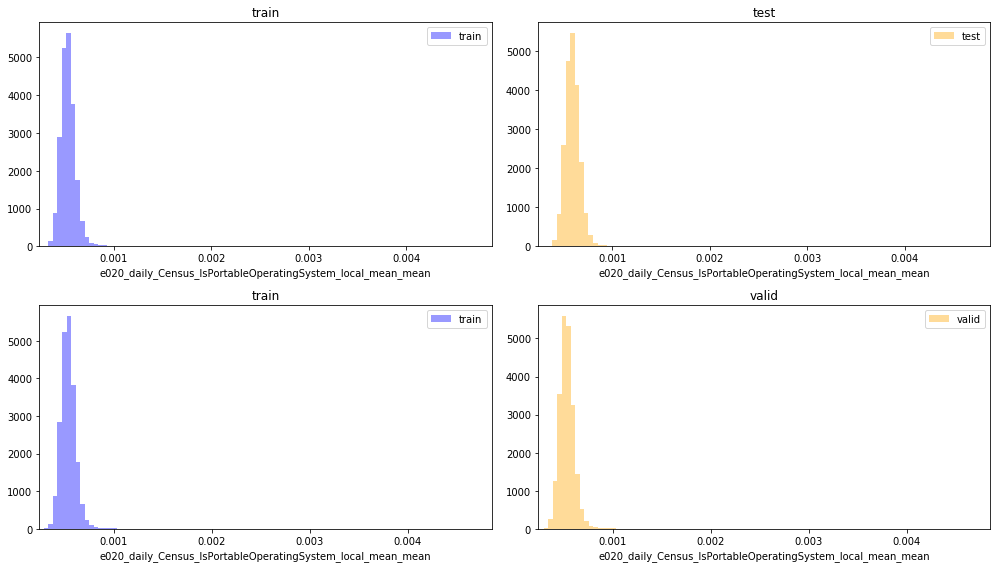

========== e020_weekly_Census_ThresholdOptIn_local_mean_cov ===========


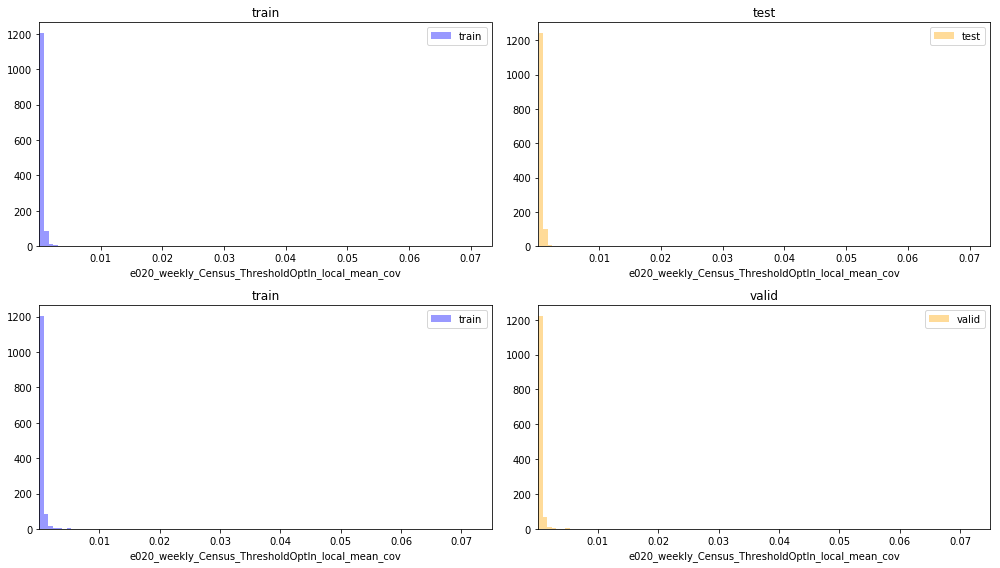

========== e020_monthly_Census_IsPenCapable_local_mean_var ===========


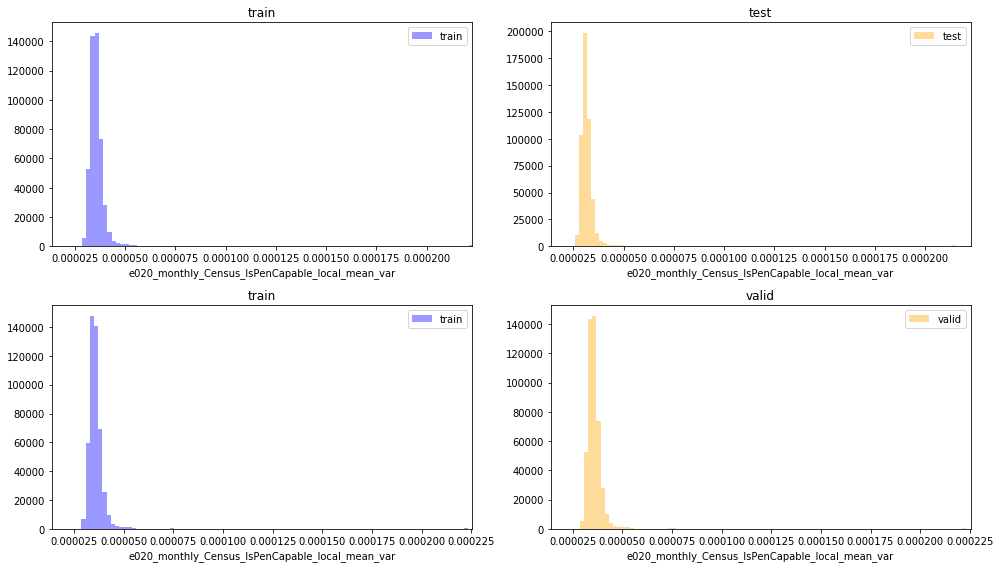

========== e020_six_hourly_HasDetections_local_mean_var ===========


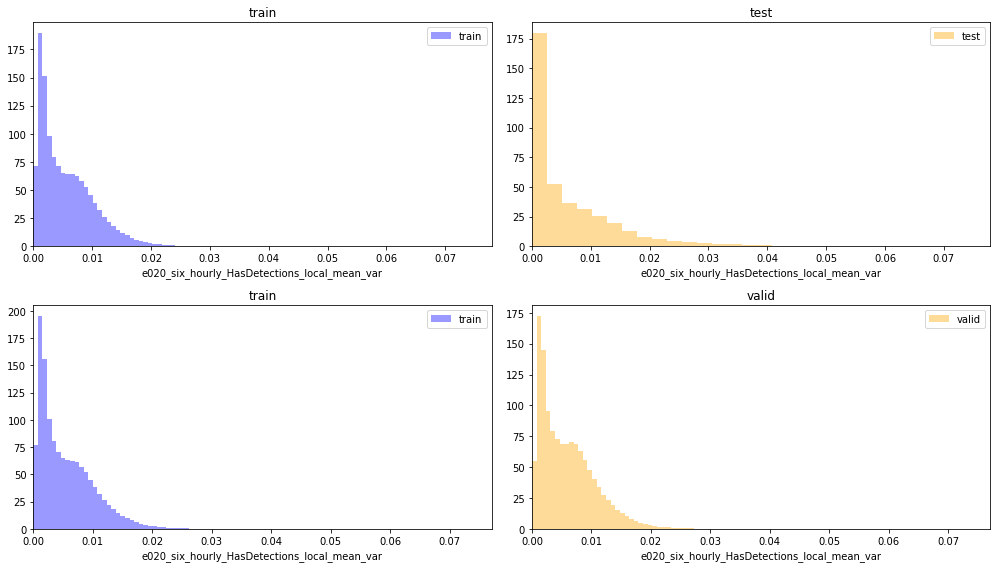

========== e020_IsBeta_local_mean ===========


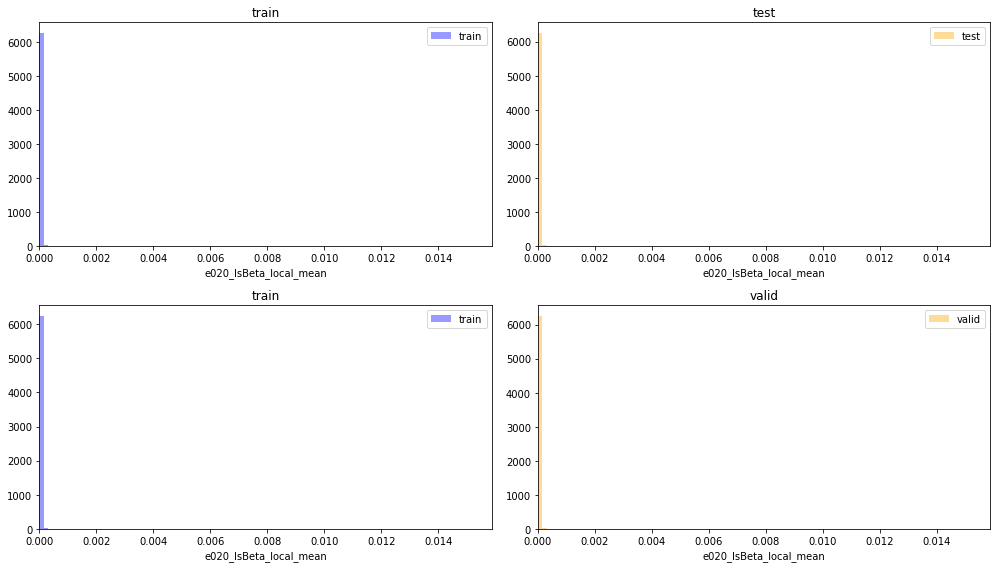

========== e020_six_hourly_AutoSampleOptIn_local_mean_cov ===========


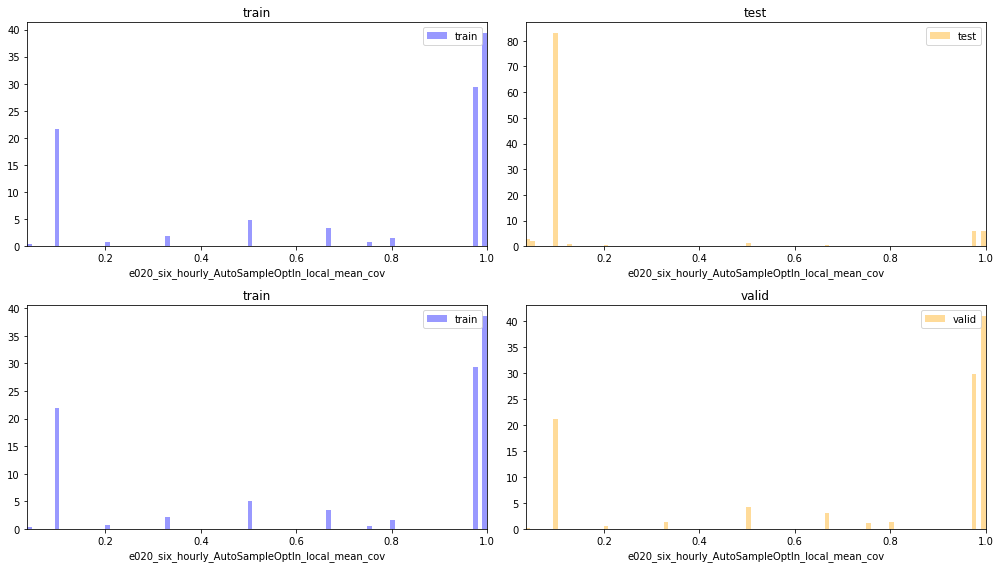

========== e020_daily_Census_IsTouchEnabled_local_mean_var ===========


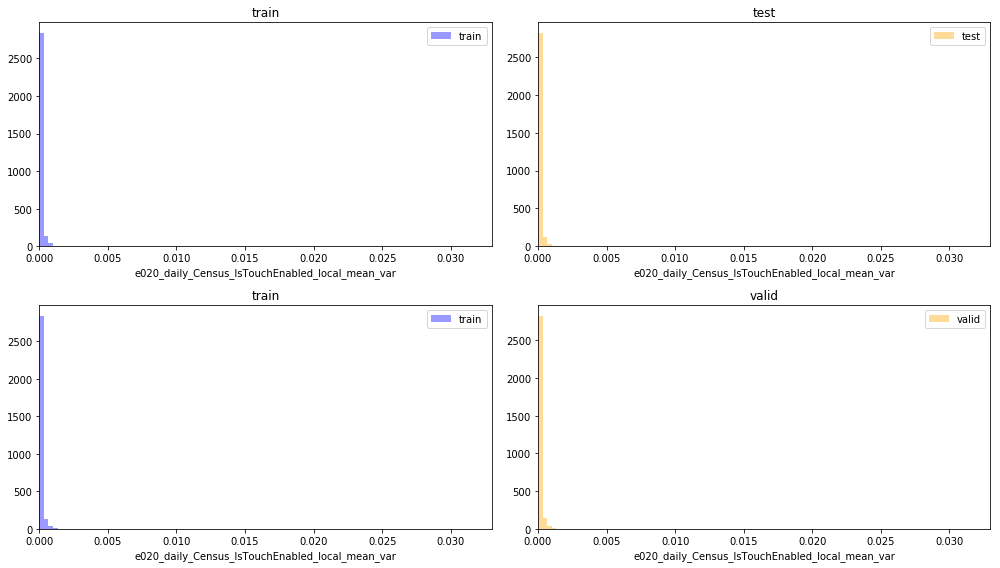

========== e020_IsSxsPassiveMode_local_mean ===========


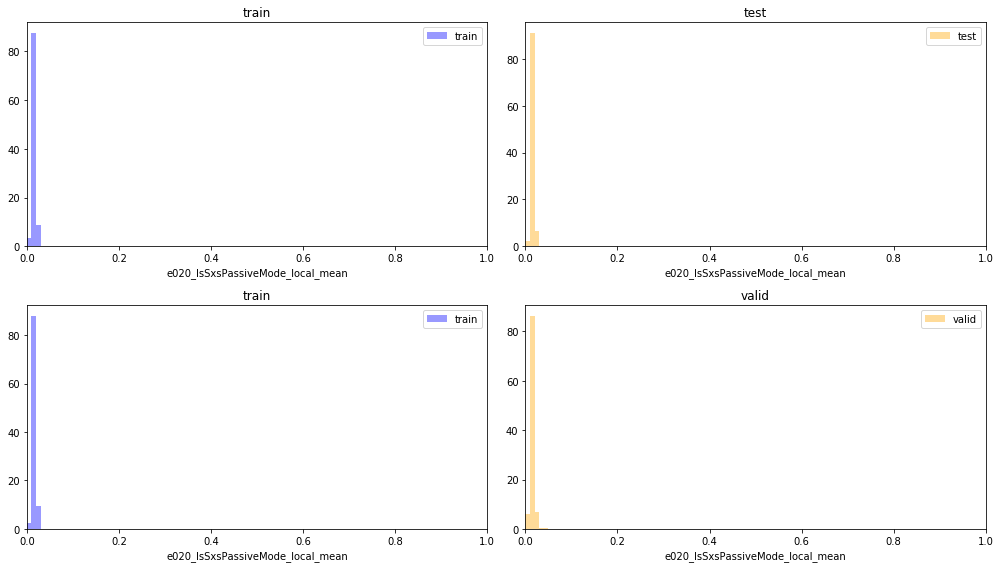

========== e020_daily_IsSxsPassiveMode_local_mean_var ===========


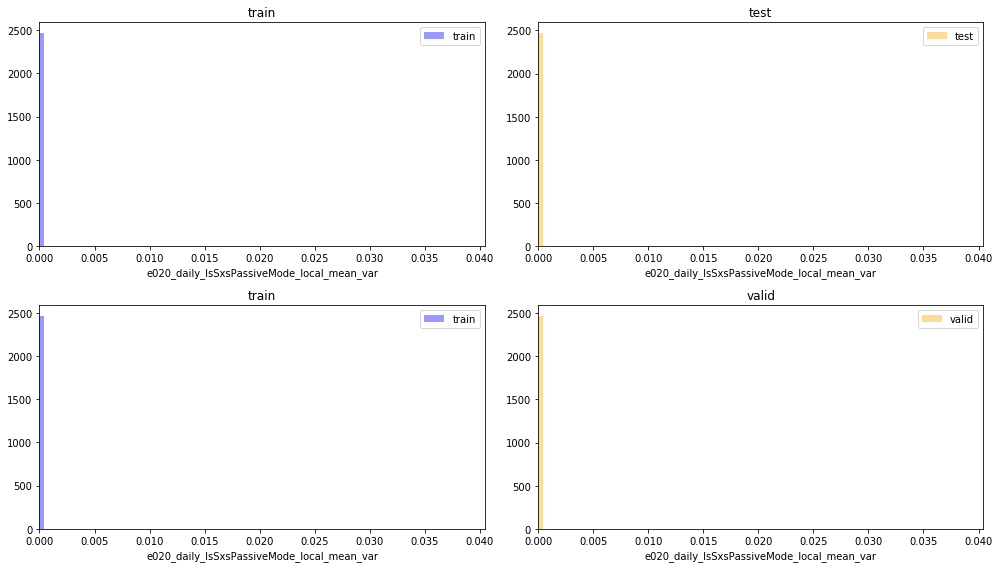

========== e020_daily_Census_IsSecureBootEnabled_local_mean_mean ===========


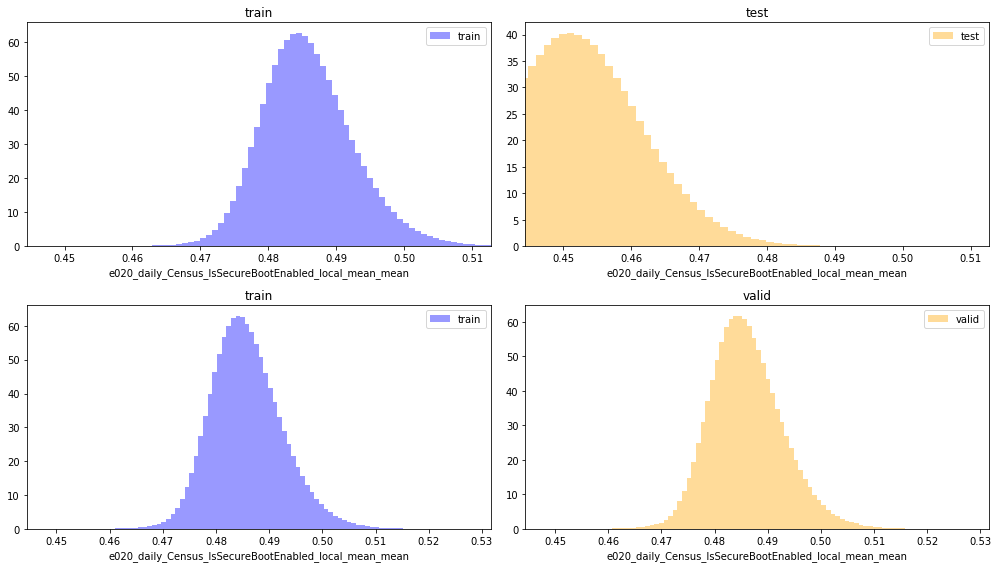

========== e020_daily_HasTpm_local_mean_cov ===========


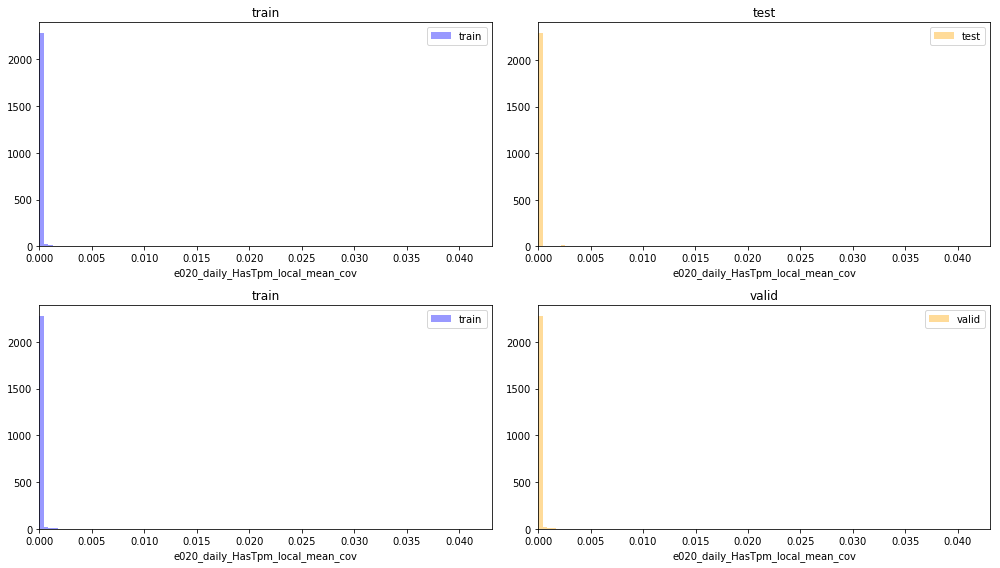

========== e020_weekly_Census_IsVirtualDevice_local_mean_var ===========


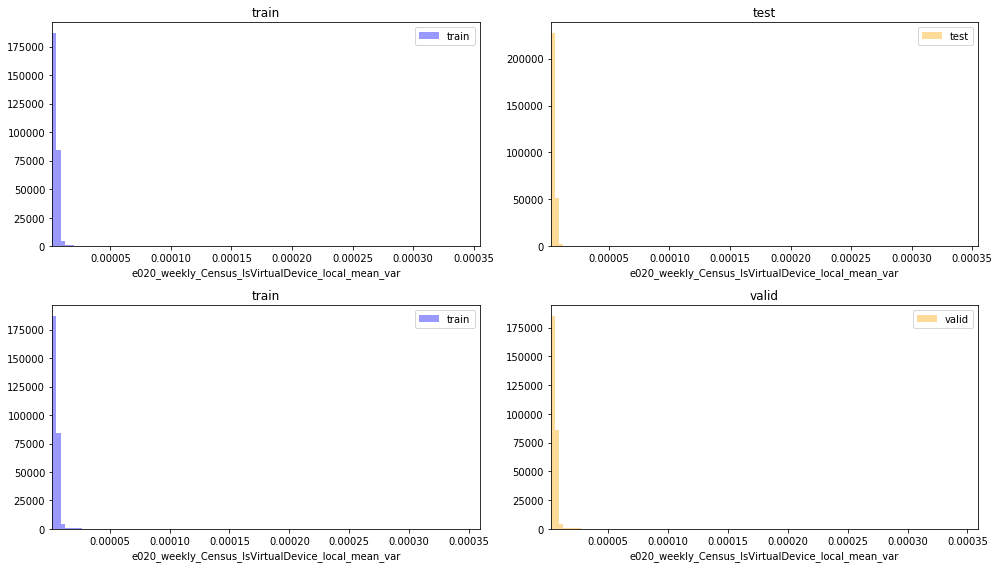

========== e020_six_hourly_IsBeta_local_mean_mean ===========


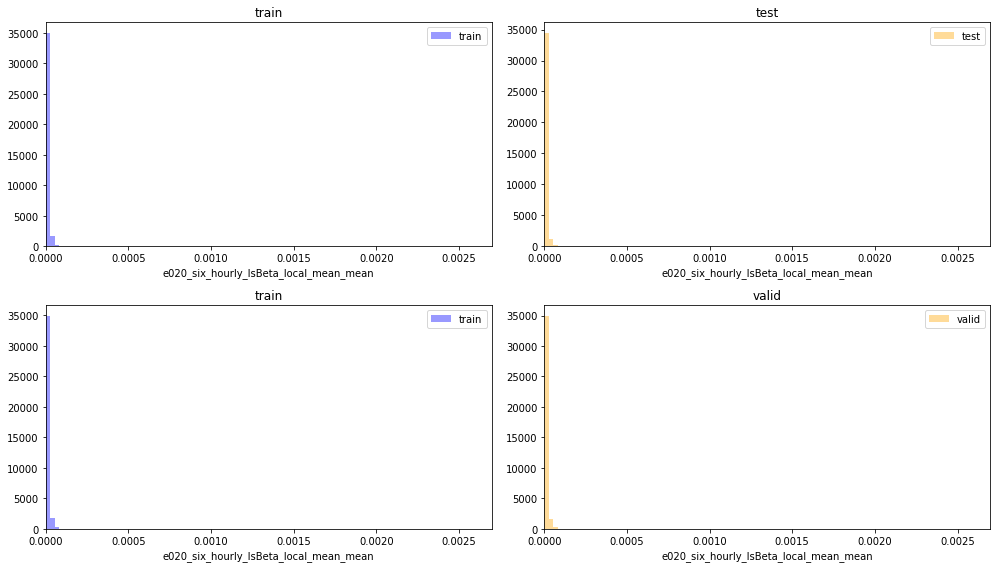

========== e020_monthly_Census_IsAlwaysOnAlwaysConnectedCapable_local_mean_cov ===========


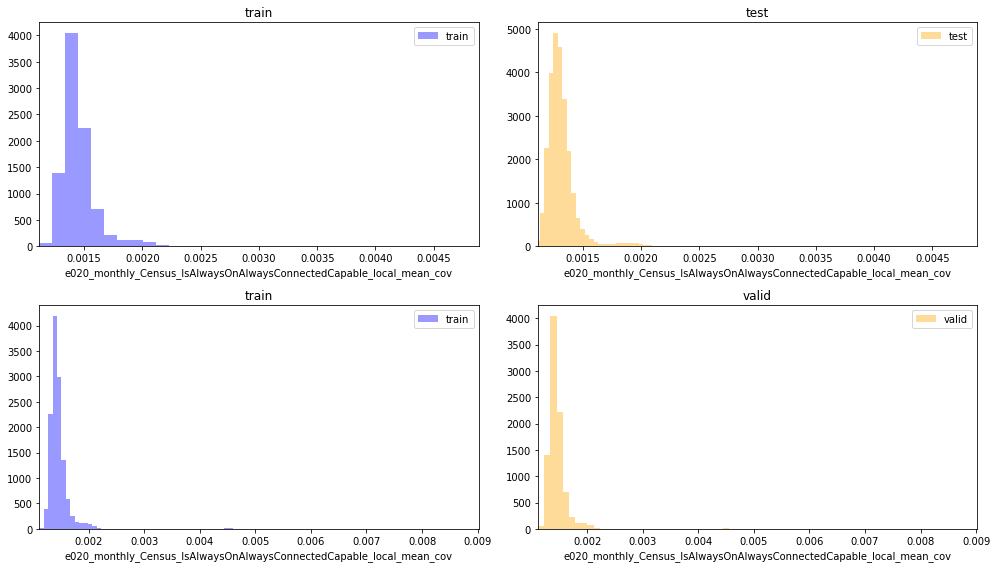

========== e020_Census_IsFlightingInternal_local_mean ===========


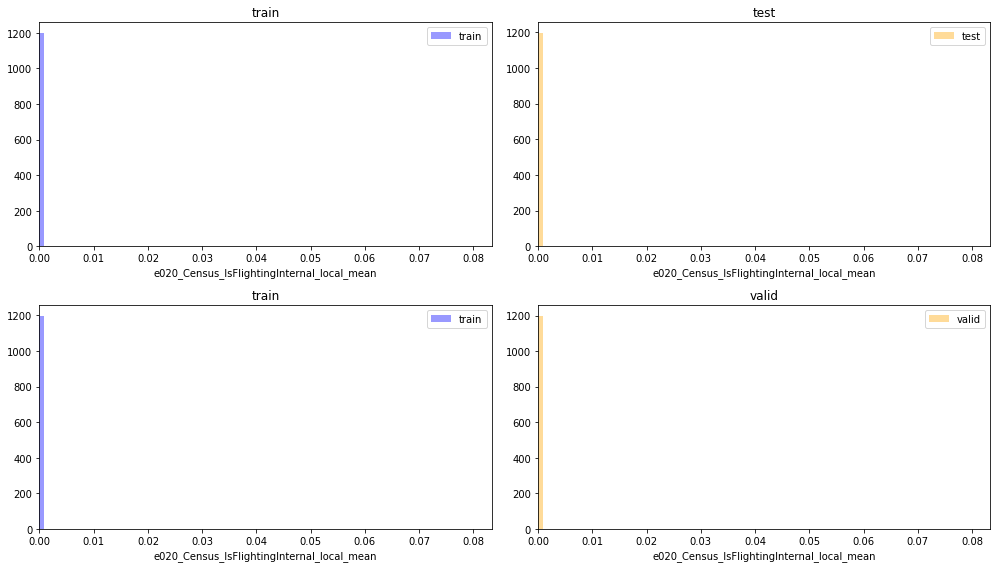

========== e020_six_hourly_Census_IsPortableOperatingSystem_local_mean_cov ===========


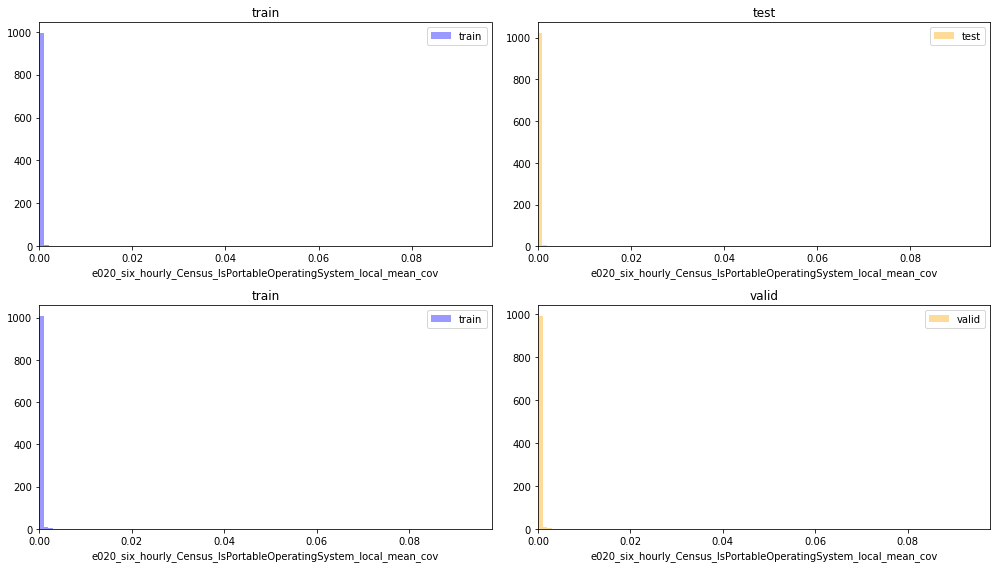

========== e020_six_hourly_Census_IsFlightsDisabled_local_mean_cov ===========


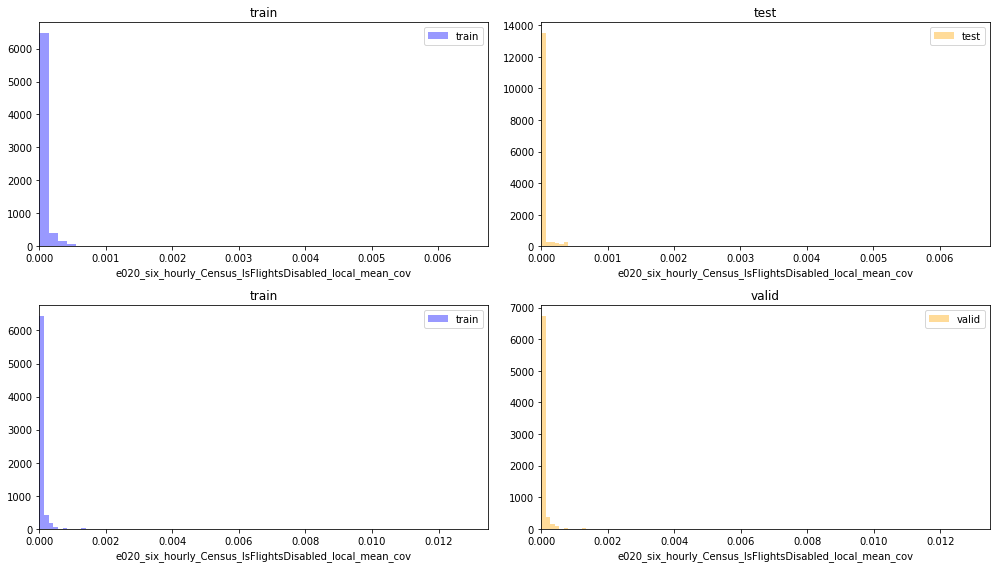

========== e020_monthly_Census_ThresholdOptIn_local_mean_var ===========


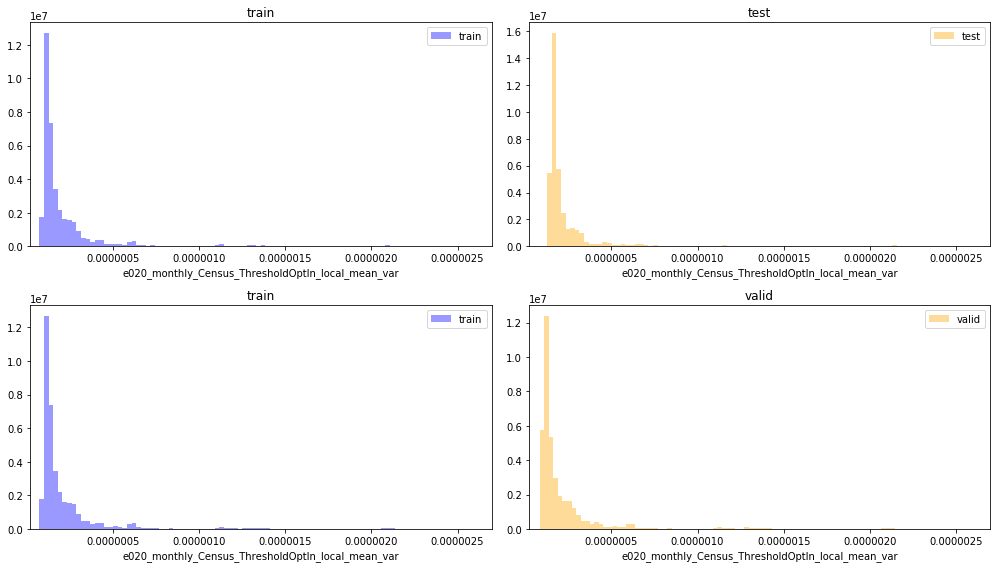

========== e020_daily_Firewall_local_mean_var ===========


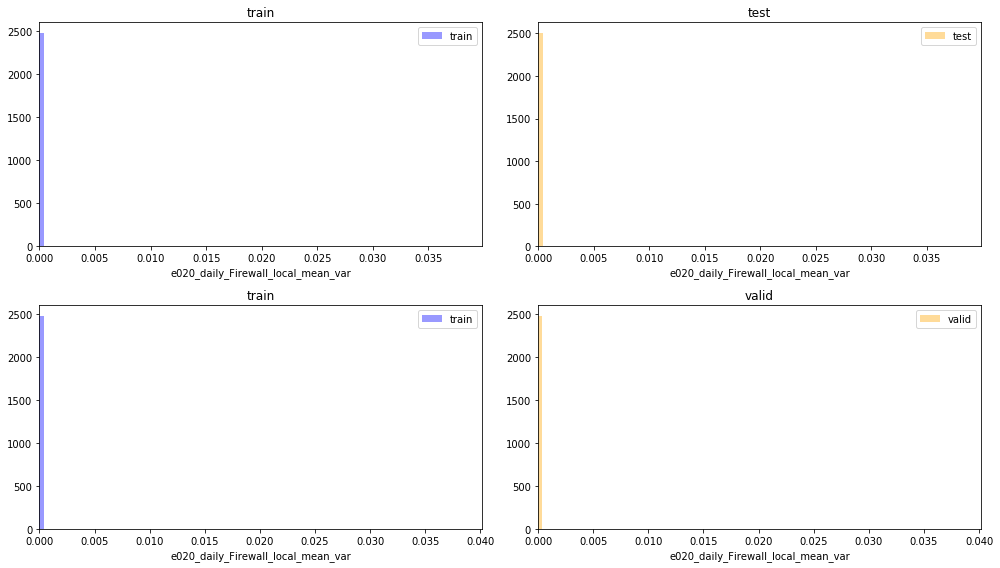

========== e020_Census_IsPenCapable_local_mean ===========


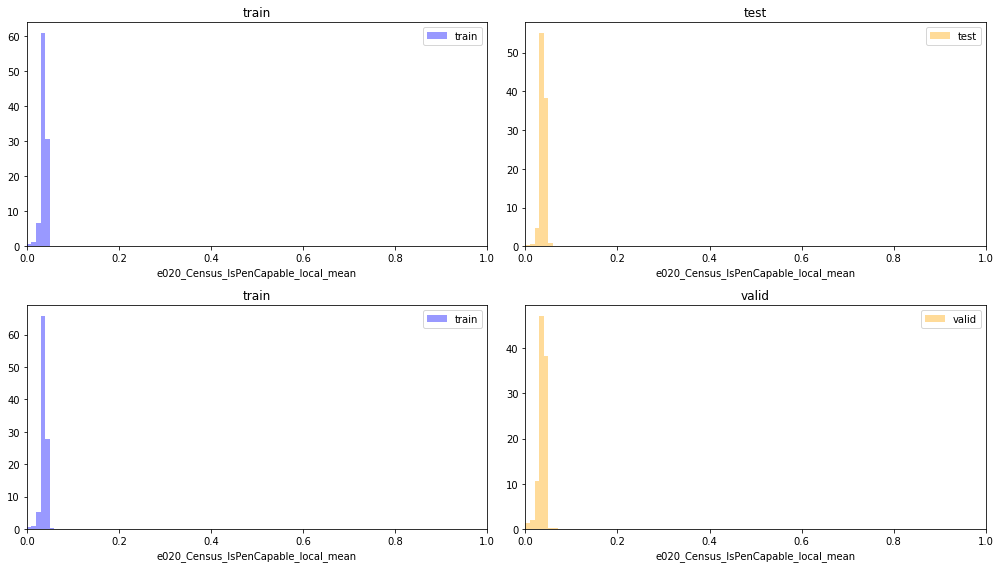

========== e020_monthly_Census_IsFlightingInternal_local_mean_var ===========


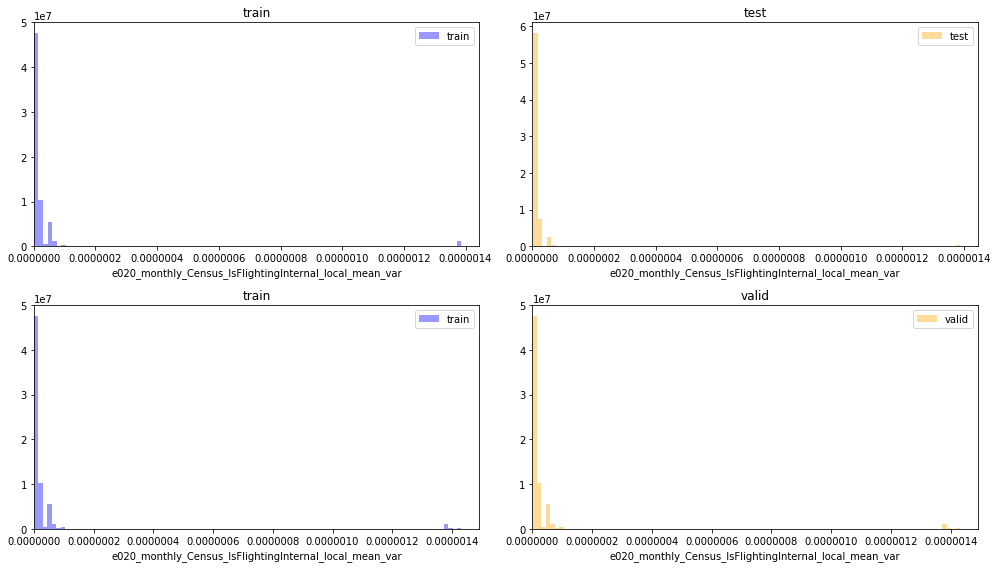

========== e020_six_hourly_HasTpm_local_mean_var ===========


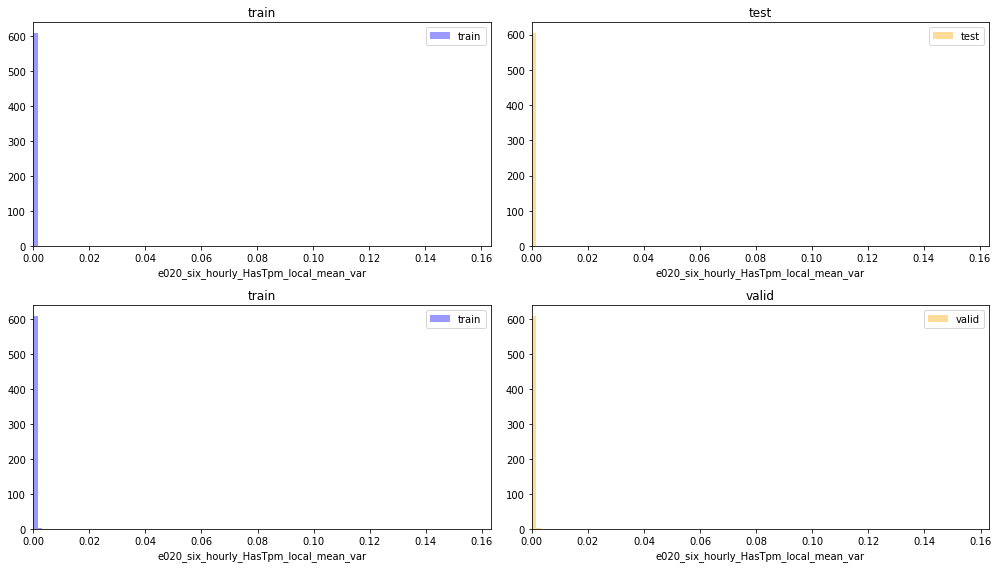

========== e020_monthly_IsProtected_local_mean_var ===========


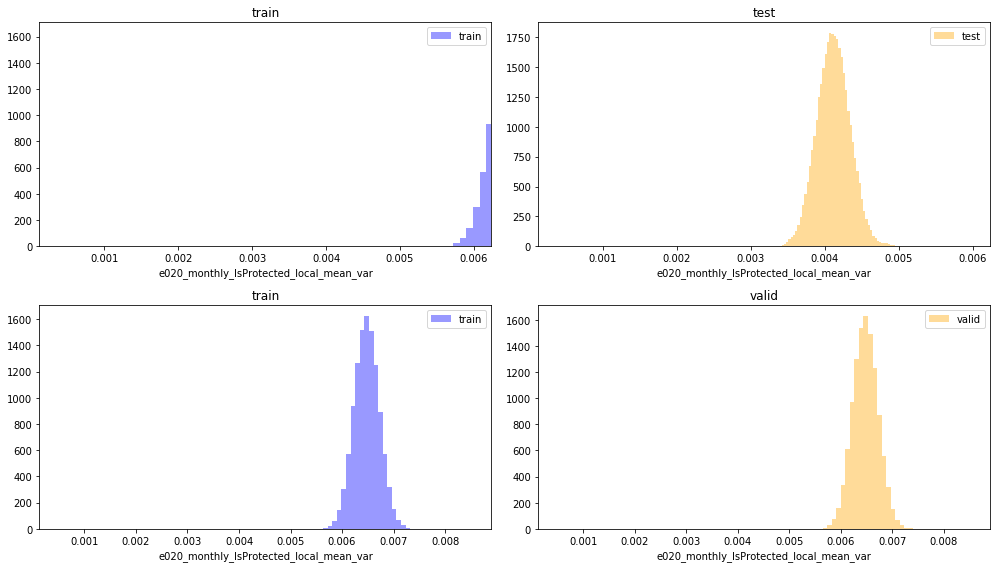

========== e020_daily_IsProtected_local_mean_mean ===========


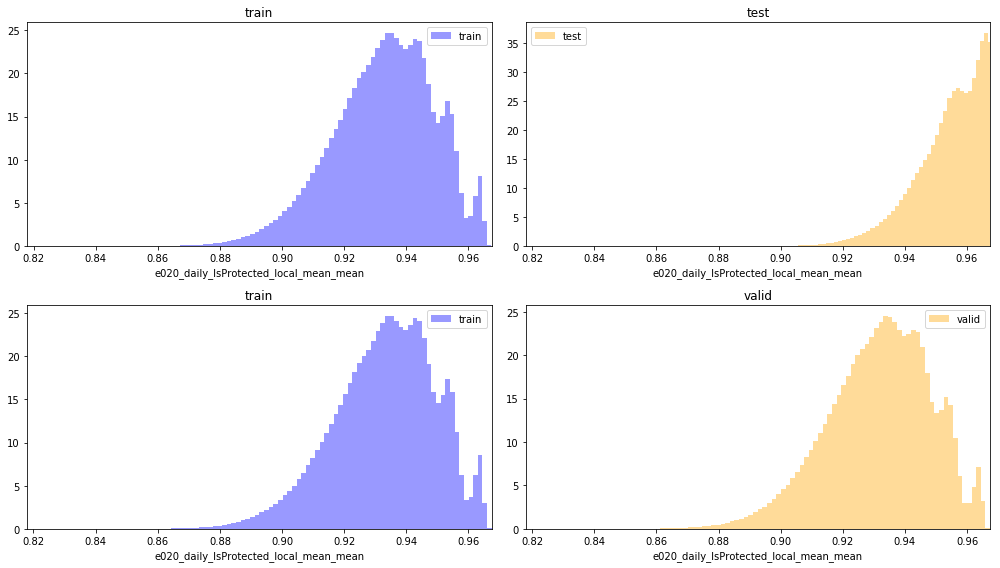

========== e020_weekly_Census_IsPenCapable_local_mean_cov ===========


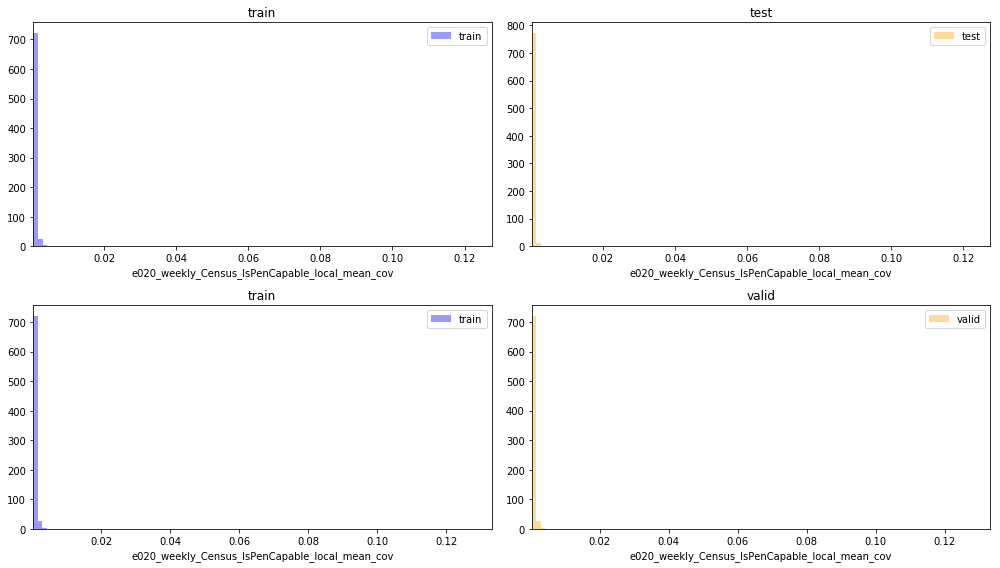

========== e020_weekly_Wdft_IsGamer_local_mean_cov ===========


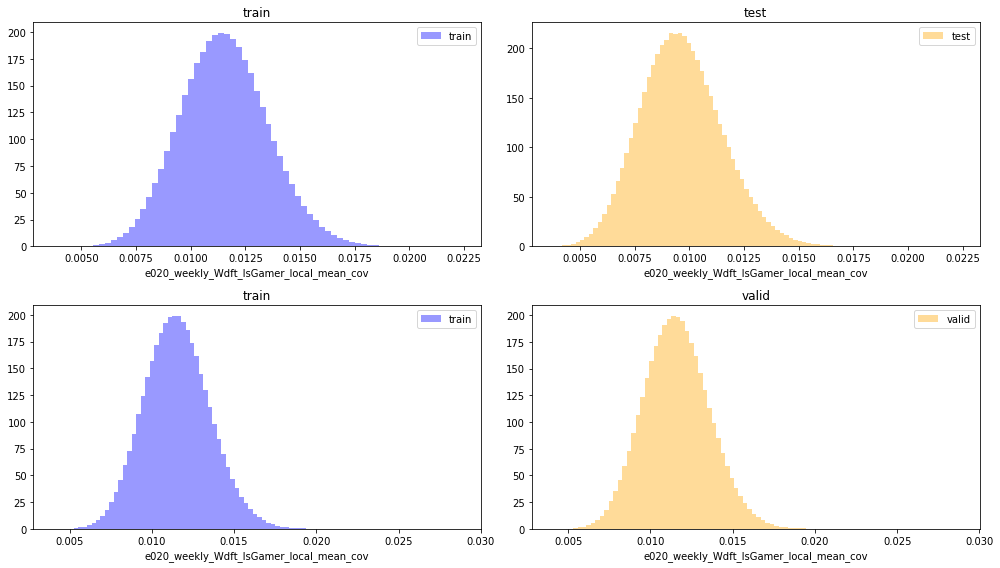

In [23]:
for col in trn_df.columns:
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    plot_train_and_test_hist(trn_df[col], tst_df[col], col, axs[0], 'train vs test', 'test')
    plot_train_and_test_hist(val_trn_df[col], val_val_df[col], col, axs[1], 'train vs valid', 'valid')
    print(f'========== {col} ===========')
    print(f'{trn_df.dropna().shape}, {tst_df.dropna().shape}')
    plt.tight_layout()
    plt.show()